In [1]:
# %load_ext autoreload
# %autoreload 2

# Set Trial Name

In [2]:
TRIAL_NAME = "17_lgbtuner"

import datetime
import pytz
NOW = datetime.datetime.now(pytz.timezone('Asia/Tokyo')).strftime('%Y%m%d%H%M%S')

# Load yaml

In [3]:
import yaml
CONFIG_DIR = '../config'
with open(f'{CONFIG_DIR}/run000.yml') as file:
    cfg = yaml.safe_load(file)

import sys
sys.path.append(cfg['SRC_DIR'])
cfg['run_name'] = TRIAL_NAME

# fix seed

In [4]:
from util import seed_everything
seed_everything(seed=33, use_torch=False)

# Make Output Folder

In [5]:
import os
OUTPUT_DIR = f'../../output/{NOW}_{TRIAL_NAME}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load Model

In [6]:
import pandas as pd
import numpy as np

sub = pd.read_csv('../../data/atmacup10__sample_submission.csv')
color = pd.read_csv('../../data/color.csv')
historical_person = pd.read_csv('../../data/historical_person.csv')
maker = pd.read_csv('../../data/maker.csv')
material = pd.read_csv('../../data/material.csv')
object_collection = pd.read_csv('../../data/object_collection.csv')
palette = pd.read_csv('../../data/palette.csv')
principal_maker_occupation = pd.read_csv('../../data/principal_maker_occupation.csv')
principal_maker = pd.read_csv('../../data/principal_maker.csv')
production_place = pd.read_csv('../../data/production_place.csv')
technique = pd.read_csv('../../data/technique.csv')
test = pd.read_csv('../../data/test.csv')
test[cfg['target']] = np.nan
train = pd.read_csv('../../data/train.csv')

In [7]:
train.head(2)

,object_id,art_series_id,title,description,long_title,principal_maker,principal_or_first_maker,sub_title,copyright_holder,more_title,acquisition_method,acquisition_date,acquisition_credit_line,dating_presenting_date,dating_sorting_date,dating_period,dating_year_early,dating_year_late,likes
0,0011d6be41612ec9eae3,93c092ba70beab248f31,The Avenue of Birches,NaN,"The Avenue of Birches, Jan Hackaert, 1660 - 1685",Jan Hackaert,Jan Hackaert,h 66.5cm × w 53.7cm × t 2.5cm × d 4.7cm,NaN,The Avenue of Birches,purchase,1808-01-01T00:00:00,NaN,1660 - 1685,1660.0,17,1660.0,1685.0,48
1,0012765f7a97ccc3e9e9,95c14fb11c54281ad7e0,Struik in bloei,NaN,"Struik in bloei, Richard Tepe (attributed to),...",Richard Tepe,Richard Tepe,h 165mm × w 223mm,erven Richard Tepe,Struik in bloei,purchase,2000-01-01T00:00:00,NaN,c. 1900 - c. 1930,1900.0,19,1900.0,1930.0,2


In [8]:
test.head(2)

,object_id,art_series_id,title,description,long_title,principal_maker,principal_or_first_maker,sub_title,copyright_holder,more_title,acquisition_method,acquisition_date,acquisition_credit_line,dating_presenting_date,dating_sorting_date,dating_period,dating_year_early,dating_year_late,likes
0,000405d9a5e3f49fc49d,a2aabd3cc8859f4260ad,Twee personen voor de Duizendjarige den te Wol...,NaN,Twee personen voor de Duizendjarige den te Wol...,Bernardus Bruining,Bernardus Bruining,h 167mm × w 108mm,NaN,Twee personen voor de Duizendjarige den te Wol...,transfer,1994-01-01T00:00:00,NaN,1850 - 1900,1850.0,19,1850.0,1900.0,NaN
1,001020bd00b149970f78,5d6a286cc3ab64c2c043,"Portrait of Philipp Ernst, Count of Hohenlohe ...","Portret van Philip Ernst (1585-1629), graaf va...","Portrait of Philipp Ernst, Count of Hohenlohe ...",Jan Antonisz van Ravesteyn,Jan Antonisz van Ravesteyn,h 29.7cm × w 24.1cm,NaN,"Portrait of Philipp Ernst, Count of Hohenlohe ...",nationalization 1795,1798-09-01T00:00:00,NaN,c. 1609 - c. 1633,1609.0,17,1609.0,1633.0,NaN


In [9]:
del_non_overlapping_list = [
    # 'object_id',
    'art_series_id',
    #'title',
    #'description',
    #'long_title',
    'principal_maker',
    'principal_or_first_maker',
    #'sub_title',
    'copyright_holder',
    #'more_title',
    'acquisition_method',
    # 'acquisition_date',
    # 'acquisition_credit_line',
    # 'dating_presenting_date',
    # 'dating_sorting_date',
    'dating_period',
    # 'dating_year_early',
    # 'dating_year_late'
]

from util import replace_non_overlap_val_to_missing
train, test = replace_non_overlap_val_to_missing(train,test,columns=del_non_overlapping_list)

In [10]:
train.head(2)

,object_id,art_series_id,title,description,long_title,principal_maker,principal_or_first_maker,sub_title,copyright_holder,more_title,acquisition_method,acquisition_date,acquisition_credit_line,dating_presenting_date,dating_sorting_date,dating_period,dating_year_early,dating_year_late,likes
0,0011d6be41612ec9eae3,other,The Avenue of Birches,NaN,"The Avenue of Birches, Jan Hackaert, 1660 - 1685",Jan Hackaert,Jan Hackaert,h 66.5cm × w 53.7cm × t 2.5cm × d 4.7cm,missing,The Avenue of Birches,purchase,1808-01-01T00:00:00,NaN,1660 - 1685,1660.0,17,1660.0,1685.0,48
1,0012765f7a97ccc3e9e9,other,Struik in bloei,NaN,"Struik in bloei, Richard Tepe (attributed to),...",Richard Tepe,Richard Tepe,h 165mm × w 223mm,erven Richard Tepe,Struik in bloei,purchase,2000-01-01T00:00:00,NaN,c. 1900 - c. 1930,1900.0,19,1900.0,1930.0,2


In [11]:
test.head(2)

,object_id,art_series_id,title,description,long_title,principal_maker,principal_or_first_maker,sub_title,copyright_holder,more_title,acquisition_method,acquisition_date,acquisition_credit_line,dating_presenting_date,dating_sorting_date,dating_period,dating_year_early,dating_year_late,likes
0,000405d9a5e3f49fc49d,other,Twee personen voor de Duizendjarige den te Wol...,NaN,Twee personen voor de Duizendjarige den te Wol...,Bernardus Bruining,Bernardus Bruining,h 167mm × w 108mm,missing,Twee personen voor de Duizendjarige den te Wol...,transfer,1994-01-01T00:00:00,NaN,1850 - 1900,1850.0,19,1850.0,1900.0,NaN
1,001020bd00b149970f78,other,"Portrait of Philipp Ernst, Count of Hohenlohe ...","Portret van Philip Ernst (1585-1629), graaf va...","Portrait of Philipp Ernst, Count of Hohenlohe ...",Jan Antonisz van Ravesteyn,Jan Antonisz van Ravesteyn,h 29.7cm × w 24.1cm,missing,"Portrait of Philipp Ernst, Count of Hohenlohe ...",nationalization 1795,1798-09-01T00:00:00,NaN,c. 1609 - c. 1633,1609.0,17,1609.0,1633.0,NaN


# Merge Data

In [12]:
group = train.groupby('principal_maker')

agg_df = pd.concat([
    group.size().rename('size'), # 著者が何回出てくるか. (value_counts と同じです)
    group['sub_title'].nunique().rename('sub_title_num'), # 著者ごとに何種類の sub_title を持っているか
    group['dating_sorting_date'].agg(['min', 'max', 'mean']), # 著者ごとに描いた年度の最小・最大・平均 (agg に配列を渡すと同時に複数やってくれます)
], axis=1)

agg_df.head()

,size,sub_title_num,min,max,mean
principal_maker,,,,,
A. Böeseken,5,5,1858.0,1873.0,1865.8
A. Lutz,1,1,1825.0,1825.0,1825.0
A. Mansuy,2,2,1860.0,1860.0,1860.0
A. Nissen,3,1,1860.0,1860.0,1860.0
A. Roussel,1,1,1905.0,1905.0,1905.0


In [13]:
train = pd.merge(train, 
         agg_df,
         on='principal_maker', 
         how='left')

test = pd.merge(test, 
         agg_df,
         on='principal_maker', 
         how='left')

In [14]:
train.columns

Index(['object_id', 'art_series_id', 'title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
       'copyright_holder', 'more_title', 'acquisition_method',
       'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date',
       'dating_sorting_date', 'dating_period', 'dating_year_early',
       'dating_year_late', 'likes', 'size', 'sub_title_num', 'min', 'max',
       'mean'],
      dtype='object')

# Feature Enginnering

In [15]:
def create_object_feature(input_df):        
    return input_df['likes'].copy()

create_object_feature(test).head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: likes, dtype: float64

In [16]:
def create_numeric_feature(input_df):
    use_columns = [
        'dating_period',
        'dating_year_early',
        'dating_year_late'
    ]

    return input_df[use_columns].copy()

create_numeric_feature(train).head(2)

,dating_period,dating_year_early,dating_year_late
0,17,1660.0,1685.0
1,19,1900.0,1930.0


In [17]:
def create_categorical_feature(input_df):
    use_columns = [
    'art_series_id',
    'principal_maker',
    'principal_or_first_maker',
    'copyright_holder',
    'acquisition_method',
    ]

    return input_df[use_columns].copy()

create_categorical_feature(train).head(2)

,art_series_id,principal_maker,principal_or_first_maker,copyright_holder,acquisition_method
0,other,Jan Hackaert,Jan Hackaert,missing,purchase
1,other,Richard Tepe,Richard Tepe,erven Richard Tepe,purchase


In [18]:
import datetime

def create_acquisition_feature(input_df):
    out_df = pd.DataFrame()
    
    use_columns = [
        'acquisition_date'
    ]
    
    out_df['year'] = pd.to_datetime(input_df['acquisition_date']).dt.year
    out_df['month'] = pd.to_datetime(input_df['acquisition_date']).dt.month
    out_df['dayofweek'] = pd.to_datetime(input_df['acquisition_date']).dt.dayofweek
    out_df['sum_time'] =  10**10 - pd.to_datetime(input_df['acquisition_date']).view('int') // 10**9
    
    return out_df.add_prefix('AcquisitionDate_')

create_acquisition_feature(train).head(2)

,AcquisitionDate_year,AcquisitionDate_month,AcquisitionDate_dayofweek,AcquisitionDate_sum_time
0,1808.0,1.0,4.0,15112288000
1,2000.0,1.0,5.0,9053315200


In [19]:
# from util import inf2nan

# def create_principal_maker_info_feature(input_df):
#     '''作者の情報を追加'''
#     out_df = pd.DataFrame()

#     input_df_object_id = input_df['object_id']
    
#     # 作成期間の平均の年を作成
#     train['dating_year_mean'] = (train['dating_year_early'] + train['dating_year_late']) / 2
#     test['dating_year_mean'] = (test['dating_year_early'] + test['dating_year_late']) / 2

#     merge_df = pd.concat([train, test],axis=0).reset_index(drop=True)

#     # 作成期間の平均までに稼いだ良いねの総数、作者の人気度指数
#     out_df['object_id'] = merge_df['object_id']
#     out_df['principal_maker'] = merge_df['principal_maker']
#     out_df['dating_year_mean'] = merge_df['dating_year_mean']
#     out_df['cumsum'] = merge_df.sort_values('dating_year_mean').groupby('principal_maker')['likes'].cumsum()
#     out_df['cumsum_fillnan'] = out_df.sort_values('dating_year_mean').groupby('principal_maker')['cumsum'].ffill()

#     # 作成期間の平均までに出した作品の数
#     tmp_df = pd.DataFrame()
#     tmp_df['object_id'] = train['object_id']
#     tmp_df['cumcount'] = train.sort_values('dating_year_mean').groupby('principal_maker').cumcount()
#     out_df = pd.merge(out_df, tmp_df, on='object_id', how='left')
#     out_df['cumcount_fillnan'] = out_df.sort_values('dating_year_mean').groupby('principal_maker')['cumcount'].ffill()

#     # 作成期間の平均における良いねの作品平均、作者の人気度指数
#     out_df['cumsum_per_cumcount'] = out_df['cumsum_fillnan'] / out_df['cumcount_fillnan']
#     out_df['cumsum_per_cumcount'] = inf2nan(out_df['cumsum_per_cumcount'])
    
#     # anonymousはnanにする
#     anonymous_idx = out_df[out_df['principal_maker'] == 'anonymous'].index
#     out_df.loc[anonymous_idx,['cumsum_fillnan','cumcount_fillnan','cumsum_per_cumcount']] = np.nan
    
#     # filter by id
#     out_df = out_df[out_df['object_id'].isin(input_df_object_id)].reset_index(drop=True)

#     return out_df[['cumsum_fillnan','cumcount_fillnan','cumsum_per_cumcount']].add_prefix('PrincipalMakerInfo_')

# create_principal_maker_info_feature(train).head(2)

In [20]:
def create_string_length_feature(input_df):
    out_df = pd.DataFrame()

    str_columns = [
        'title', 
        'long_title',
        'sub_title',
        'more_title'
        # and more
    ]

    for c in str_columns:
        out_df[c] = input_df[c].str.len()

    return out_df.add_prefix('StringLength__')

create_string_length_feature(train).head(2)

,StringLength__title,StringLength__long_title,StringLength__sub_title,StringLength__more_title
0,21,48,39.0,21.0
1,15,64,17.0,15.0


In [21]:
def create_count_encoding_feature(input_df):
    use_columns = [
        'acquisition_method',
        'title',
        'principal_maker',
        # and more
    ]

    out_df = pd.DataFrame()
    for column in use_columns:
        vc = train[column].value_counts()
        out_df[column] = input_df[column].map(vc)

    return out_df.add_prefix('CE_')

create_count_encoding_feature(train).head(2)

,CE_acquisition_method,CE_title,CE_principal_maker
0,4253,1,3
1,4253,1,180


In [22]:
def create_one_hot_encoding(input_df):
    use_columns = [
        'acquisition_method',
        'principal_maker'
    ]
    out_df = pd.DataFrame()
    for column in use_columns:

        # あまり巨大な行列にならないよう, 出現回数が 20 回を下回るカテゴリは考慮しない
        vc = train[column].value_counts()
        vc = vc[vc > 20]

        # 明示的に catgories を指定して, input_df によらず列の大きさが等しくなるようにする
        cat = pd.Categorical(input_df[column], categories=vc.index)

        # このタイミングで one-hot 化
        out_i = pd.get_dummies(cat)
        # column が Catgory 型として認識されているので list にして解除する (こうしないと concat でエラーになる)
        out_i.columns = out_i.columns.tolist()
        out_i = out_i.add_prefix(f'{column}=')
        out_df = pd.concat([out_df, out_i], axis=1)
    return out_df

create_one_hot_encoding(train).head(2)

,acquisition_method=purchase,acquisition_method=transfer,acquisition_method=gift,acquisition_method=unknown,acquisition_method=bequest,acquisition_method=loan,acquisition_method=missing,acquisition_method=nationalization 1795,principal_maker=anonymous,principal_maker=other,...,principal_maker=C.M. Ferrier & F. von Martens,principal_maker=James Valentine,principal_maker=Adolphe Zimmermans,principal_maker=Jan Banning,principal_maker=Wouter Johannes van Troostwijk,principal_maker=Jan Maurits Quinkhard,principal_maker=Cor Jaring,principal_maker=Jean Baptiste August Kessler,principal_maker=Gerard Edelinck,principal_maker=Augusta Curiel
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
import re

#  h 166mm × w 78/54mm

def get_h_from_subtitle(text:str):
    match_cm = re.search(r'h \S+cm', text)
    if match_cm:
        if match_cm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_cm.group()[2:-2])

    match_mm = re.search(r'h \S+mm', text)
    if match_mm:
        if match_mm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_mm.group()[2:-2])/100

def get_w_from_subtitle(text:str):
    match_cm = re.search(r'w \S+cm', text)
    if match_cm:
        if match_cm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_cm.group()[2:-2])

    match_mm = re.search(r'w \S+mm', text)
    if match_mm:
        if match_mm.group()[2:-2] == '':
            return np.nan
        elif match_mm.group()[2:-2] == '78/54':
            return float(78)
        else:
            return float(match_mm.group()[2:-2])/100    

def get_t_from_subtitle(text:str):
    match_cm = re.search(r't \S+cm', text)
    if match_cm:
        if match_cm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_cm.group()[2:-2])

    match_mm = re.search(r't \S+mm', text)
    if match_mm:
        if match_mm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_mm.group()[2:-2])/100   

def get_d_from_subtitle(text:str):
    match_cm = re.search(r'd \S+cm', text)
    if match_cm:
        if match_cm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_cm.group()[2:-2])

    match_mm = re.search(r'd \S+mm', text)
    if match_mm:
        if match_mm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_mm.group()[2:-2])/100   
        
def create_subtitle_info(input_df):
    out_df = pd.DataFrame()
     
    out_df['subtitle_h'] = input_df['sub_title'].fillna('missing').apply(lambda x : get_h_from_subtitle(x))
    out_df['subtitle_w'] = input_df['sub_title'].fillna('missing').apply(lambda x : get_w_from_subtitle(x))
    out_df['subtitle_t'] = input_df['sub_title'].fillna('missing').apply(lambda x : get_t_from_subtitle(x))
    out_df['subtitle_d'] = input_df['sub_title'].fillna('missing').apply(lambda x : get_d_from_subtitle(x))
    
    out_df['area'] = out_df['subtitle_h'] * out_df['subtitle_w']
    out_df['volume'] = out_df['subtitle_h'] * out_df['subtitle_w'] * out_df['subtitle_t']

    return out_df

create_subtitle_info(test).head(2)

,subtitle_h,subtitle_w,subtitle_t,subtitle_d,area,volume
0,1.67,1.08,NaN,NaN,1.8036,NaN
1,29.70,24.10,NaN,NaN,715.7700,NaN


In [24]:
# # train_emb_npy = np.load('../../extract_data/train_word_emb.npy')
# # test_emb_npy = np.load('../../extract_data/test_word_emb.npy')

# train_emb_npy = np.load('../../extract_data/train_description_emb_multilingual.npy')
# test_emb_npy = np.load('../../extract_data/test_description_emb_multilingual.npy')

# train_emb_df = pd.concat([train['object_id'], pd.DataFrame(train_emb_npy)],axis=1)
# test_emb_df = pd.concat([test['object_id'], pd.DataFrame(test_emb_npy)],axis=1)

# all_df = pd.concat([train_emb_df,test_emb_df],axis=0).reset_index(drop=True)

# all_df.to_pickle('../../extract_data/all_description_emb_multilingual.pkl')

In [25]:
from util import use_pca

def create_description_emb(input_df):
    out_df = pd.DataFrame()
    
    all_emb_df = pd.read_pickle('../../extract_data/all_description_emb_multilingual.pkl')
    
#     # 756 to 256
#     comp_num = 256

#     pca = PCA(n_components = comp_num)
#     pca_res = pca.fit_transform(all_emb_df.iloc[:,1:].values)
#     emb_df_256 = pd.DataFrame(pca_res, columns=[f'pca_{i}' for i in range(comp_num)])
#     all_emb_df_256 = pd.concat((all_emb_df['object_id'], emb_df_256), axis=1

    emb_df_256 = use_pca(all_emb_df.iloc[:,1:], 256)
    all_emb_df_256 = pd.concat((all_emb_df['object_id'], emb_df_256), axis=1)
    
    input_word_emb = pd.merge(input_df['object_id'], all_emb_df_256, on='object_id', how='left')
    
    # return input_word_emb[[num for num in range(768)]].add_prefix('DescriptionEmb_')
    return input_word_emb[[f'pca_{num}' for num in range(256)]].add_prefix('DescriptionEmb_')

create_description_emb(test).tail(2)

,DescriptionEmb_pca_0,DescriptionEmb_pca_1,DescriptionEmb_pca_2,DescriptionEmb_pca_3,DescriptionEmb_pca_4,DescriptionEmb_pca_5,DescriptionEmb_pca_6,DescriptionEmb_pca_7,DescriptionEmb_pca_8,DescriptionEmb_pca_9,...,DescriptionEmb_pca_246,DescriptionEmb_pca_247,DescriptionEmb_pca_248,DescriptionEmb_pca_249,DescriptionEmb_pca_250,DescriptionEmb_pca_251,DescriptionEmb_pca_252,DescriptionEmb_pca_253,DescriptionEmb_pca_254,DescriptionEmb_pca_255
12006,4.868668,-2.158478,0.022857,0.005380,-0.005051,-0.033197,-0.030381,0.001403,-0.000757,-0.003157,...,-0.000065,-0.000070,-0.000092,0.000011,0.000046,-0.000033,0.000201,0.000043,-0.000019,-0.000100
12007,-2.857192,-0.279424,-1.757070,-0.255253,-0.783499,-0.267255,-0.262804,-0.261662,0.870814,-0.289136,...,-0.002021,-0.026324,0.001770,-0.004371,0.023271,0.019867,0.020989,0.001674,0.005685,0.004983


In [26]:
# train_emb_npy = np.load('../../extract_data/train_word_emb.npy')
# test_emb_npy = np.load('../../extract_data/test_word_emb.npy')

# train_emb_npy = np.load('../../extract_data/train_description_emb_multilingual.npy')
# test_emb_npy = np.load('../../extract_data/test_description_emb_multilingual.npy')

train_emb_npy = np.load('../../extract_data/train_long_title_emb_multilingual.npy')
test_emb_npy = np.load('../../extract_data/test_long_title_emb_multilingual.npy')

train_emb_df = pd.concat([train['object_id'], pd.DataFrame(train_emb_npy)],axis=1)
test_emb_df = pd.concat([test['object_id'], pd.DataFrame(test_emb_npy)],axis=1)

all_df = pd.concat([train_emb_df,test_emb_df],axis=0).reset_index(drop=True)

all_df.to_pickle('../../extract_data/all_longtitle_emb_multilingual.pkl')

In [27]:
from util import use_pca

def create_longtitle_emb(input_df):
    out_df = pd.DataFrame()
    
    all_emb_df = pd.read_pickle('../../extract_data/all_longtitle_emb_multilingual.pkl')
    
#     # 756 to 256
#     comp_num = 256

#     pca = PCA(n_components = comp_num)
#     pca_res = pca.fit_transform(all_emb_df.iloc[:,1:].values)
#     emb_df_256 = pd.DataFrame(pca_res, columns=[f'pca_{i}' for i in range(comp_num)])
#     all_emb_df_256 = pd.concat((all_emb_df['object_id'], emb_df_256), axis=1

    emb_df_256 = use_pca(all_emb_df.iloc[:,1:], 256)
    all_emb_df_256 = pd.concat((all_emb_df['object_id'], emb_df_256), axis=1)
    
    input_word_emb = pd.merge(input_df['object_id'], all_emb_df_256, on='object_id', how='left')
    
    # return input_word_emb[[num for num in range(768)]].add_prefix('DescriptionEmb_')
    return input_word_emb[[f'pca_{num}' for num in range(256)]].add_prefix('LongTitleEmb_')

create_longtitle_emb(train).tail(2)

,LongTitleEmb_pca_0,LongTitleEmb_pca_1,LongTitleEmb_pca_2,LongTitleEmb_pca_3,LongTitleEmb_pca_4,LongTitleEmb_pca_5,LongTitleEmb_pca_6,LongTitleEmb_pca_7,LongTitleEmb_pca_8,LongTitleEmb_pca_9,...,LongTitleEmb_pca_246,LongTitleEmb_pca_247,LongTitleEmb_pca_248,LongTitleEmb_pca_249,LongTitleEmb_pca_250,LongTitleEmb_pca_251,LongTitleEmb_pca_252,LongTitleEmb_pca_253,LongTitleEmb_pca_254,LongTitleEmb_pca_255
12024,0.134985,0.274561,-0.355268,-0.568043,0.490873,-0.759762,0.800045,0.492067,-0.684613,-0.055676,...,-0.124085,-0.109650,0.011198,0.033917,-0.071648,0.004953,0.036293,-0.151615,0.046661,0.075901
12025,3.315138,0.391916,-0.387957,-0.729398,-0.963973,-1.700651,-0.560261,0.077447,0.027761,-0.265688,...,0.011082,-0.019668,0.018901,-0.077008,-0.060058,-0.031605,0.043291,0.041119,0.057007,0.006189


In [28]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [29]:
from tqdm import tqdm

def to_feature(input_df):
    """input_df を特徴量行列に変換した新しいデータフレームを返す.
    """

    processors = [
        create_object_feature,
        create_numeric_feature,
        create_categorical_feature,
        create_acquisition_feature,
        # create_principal_maker_info_feature,
        create_string_length_feature,
        create_count_encoding_feature,
        create_one_hot_encoding,
        create_subtitle_info,
        create_description_emb,
        create_longtitle_emb
    ]

    out_df = pd.DataFrame()

    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)
        # 長さが等しいことをチェック (ずれている場合, func の実装がおかしい)
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

train_feat= to_feature(train)
test_feat = to_feature(test)

train = train_feat.copy()
test = test_feat.copy()

 70%|███████   | 7/10 [00:00<00:00, 69.47it/s]

createcreate_object_feature  0.002[s]
createcreate_numeric_feature  0.002[s]
createcreate_categorical_feature  0.002[s]
createcreate_acquisition_feature  0.029[s]
createcreate_string_length_feature  0.016[s]
createcreate_count_encoding_feature  0.012[s]
createcreate_one_hot_encoding  0.010[s]
createcreate_subtitle_info  0.086[s]
createcreate_description_emb  1.040[s]


 80%|████████  | 8/10 [00:00<00:00, 45.58it/s]

createcreate_longtitle_emb  1.021[s]
createcreate_object_feature  0.000[s]
createcreate_numeric_feature  0.002[s]
createcreate_categorical_feature  0.002[s]
createcreate_acquisition_feature  0.013[s]
createcreate_string_length_feature  0.019[s]
createcreate_count_encoding_feature  0.013[s]
createcreate_one_hot_encoding  0.010[s]
createcreate_subtitle_info  0.083[s]
createcreate_description_emb  0.995[s]


100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

createcreate_longtitle_emb  0.978[s]


In [30]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

# train

In [31]:
train.isnull().sum()

likes                    0
dating_period            0
dating_year_early       10
dating_year_late        38
art_series_id            0
                        ..
LongTitleEmb_pca_251     0
LongTitleEmb_pca_252     0
LongTitleEmb_pca_253     0
LongTitleEmb_pca_254     0
LongTitleEmb_pca_255     0
Length: 636, dtype: int64

In [32]:
test.head(2)

,likes,dating_period,dating_year_early,dating_year_late,art_series_id,principal_maker,principal_or_first_maker,copyright_holder,acquisition_method,AcquisitionDate_year,...,LongTitleEmb_pca_246,LongTitleEmb_pca_247,LongTitleEmb_pca_248,LongTitleEmb_pca_249,LongTitleEmb_pca_250,LongTitleEmb_pca_251,LongTitleEmb_pca_252,LongTitleEmb_pca_253,LongTitleEmb_pca_254,LongTitleEmb_pca_255
0,NaN,19,1850.0,1900.0,other,Bernardus Bruining,Bernardus Bruining,missing,transfer,1994.0,...,0.037331,-0.039051,-0.107597,0.009122,-0.036311,0.045924,0.085534,-0.062058,0.054639,-0.039133
1,NaN,17,1609.0,1633.0,other,Jan Antonisz van Ravesteyn,Jan Antonisz van Ravesteyn,missing,nationalization 1795,1798.0,...,-0.076787,-0.089816,0.003000,-0.111474,-0.083266,0.067740,-0.035723,0.063153,0.034150,-0.079667


# reduce mem usage

In [33]:
# from util import reduce_mem_usage
# train_feat_df = reduce_mem_usage(train_feat_df)
# test_feat_df = reduce_mem_usage(test_feat_df)

# Lable Encoding

In [34]:
cat_col = train.select_dtypes('O').columns.tolist()

In [35]:
from fe import label_encode
train, test = label_encode(train, test, cat_col)

In [36]:
train.dtypes

likes                     int64
dating_period             int64
dating_year_early       float64
dating_year_late        float64
art_series_id             int64
                         ...   
LongTitleEmb_pca_251    float32
LongTitleEmb_pca_252    float32
LongTitleEmb_pca_253    float32
LongTitleEmb_pca_254    float32
LongTitleEmb_pca_255    float32
Length: 636, dtype: object

# add fold

In [37]:
from fold import add_fold_bin_skf
train = add_fold_bin_skf(train, train[cfg['target']], fold_num=5, bins=[0,1,10,100,1000, 27392])

# Target Encoding

In [38]:
train['dating_period']

0        17
1        19
2        19
3        19
4        19
         ..
12021    19
12022    18
12023    18
12024    17
12025    15
Name: dating_period, Length: 12026, dtype: int64

In [39]:
target_enc_list = [
    # 'art_series_id',
    'principal_maker',
    'principal_or_first_maker',
    'copyright_holder',
    'acquisition_method',
    'dating_period'
]

from fe import target_encoding
train, test = target_encoding(train, 
                              test, 
                              target = cfg['target'], 
                              target_enc_list = target_enc_list, 
                              fold_num = cfg['fold_num']
                             )

principal_maker
principal_or_first_maker
copyright_holder
acquisition_method
dating_period


# Make Model

In [40]:
use_col = train.columns.tolist()
use_col.remove('fold')
use_col.remove(cfg['target'])

In [41]:
use_col

['dating_period',
 'dating_year_early',
 'dating_year_late',
 'art_series_id',
 'principal_maker',
 'principal_or_first_maker',
 'copyright_holder',
 'acquisition_method',
 'AcquisitionDate_year',
 'AcquisitionDate_month',
 'AcquisitionDate_dayofweek',
 'AcquisitionDate_sum_time',
 'StringLength__title',
 'StringLength__long_title',
 'StringLength__sub_title',
 'StringLength__more_title',
 'CE_acquisition_method',
 'CE_title',
 'CE_principal_maker',
 'acquisition_method=purchase',
 'acquisition_method=transfer',
 'acquisition_method=gift',
 'acquisition_method=unknown',
 'acquisition_method=bequest',
 'acquisition_method=loan',
 'acquisition_method=missing',
 'acquisition_method=nationalization 1795',
 'principal_maker=anonymous',
 'principal_maker=other',
 'principal_maker=Johann Sadeler (I)',
 'principal_maker=Bernard Picart',
 'principal_maker=Richard Tepe',
 'principal_maker=anoniem (Monumentenzorg)',
 'principal_maker=Jan Luyken',
 'principal_maker=Raphaël Sadeler (I)',
 'principa

In [42]:
# 学習直前でwandbにログイン、こうしないと頻繁にnotebookが落ちる
from use_wandb import use_wandb
use_wandb(params=cfg['params'], PROJECT_NAME=cfg['competition_name'], TRIAL_NAME=TRIAL_NAME)

wandb: Currently logged in as: sinchir0 (use `wandb login --relogin` to force relogin)


In [45]:
from fe import target_encoding
from lgbm import LGBM

lgbm = LGBM(train=train,
  test=test,
  target='likes',
  use_col=use_col,
  cat_col=cat_col,
  cfg=cfg,
  OUTPUT_DIR=OUTPUT_DIR,
  DO_FIT=True,
  DO_SEED_AVE=False,
  DEBUG=False,
  is_target_log=True)

feature_importance_df, order = lgbm.feature_importance(PLOT=False)

[I 2021-03-08 01:42:00,909] A new study created in memory with name: no-name-8687480d-afaa-4b46-b09d-8410a0432000
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

--------------FOLDS : 0 --------------
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'principal_maker', 'principal_or_first_maker']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters fr

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18984	valid_1's rmse: 1.22762
[200]	valid_0's rmse: 1.02875	valid_1's rmse: 1.10893
[300]	valid_0's rmse: 0.958835	valid_1's rmse: 1.07844
[400]	valid_0's rmse: 0.908053	valid_1's rmse: 1.06525
[500]	valid_0's rmse: 0.865625	valid_1's rmse: 1.0564
[600]	valid_0's rmse: 0.827866	valid_1's rmse: 1.05067
[700]	valid_0's rmse: 0.794112	valid_1's rmse: 1.04621
[800]	valid_0's rmse: 0.76341	valid_1's rmse: 1.04216
[900]	valid_0's rmse: 0.735002	valid_1's rmse: 1.03932
[1000]	valid_0's rmse: 0.708675	valid_1's rmse: 1.03714
[1100]	valid_0's rmse: 0.684396	valid_1's rmse: 1.03523
[1200]	valid_0's rmse: 0.661392	valid_1's rmse: 1.03339
[1300]	valid_0's rmse: 0.639933	valid_1's rmse: 1.03214
[1400]	valid_0's rmse: 0.619939	valid_1's rmse: 1.03106
[1500]	valid_0's rmse: 0.600763	valid_1's rmse: 1.02938
[1600]	valid_0's rmse: 0.582715	valid_1's rmse: 1.02795
[1700]	valid_0's rmse: 0.565574	valid_1's rmse: 1.02693

feature_fraction, val_score: 1.019160:  14%|#4        | 1/7 [01:09<06:59, 69.98s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.19629	valid_1's rmse: 1.23134
[200]	valid_0's rmse: 1.03616	valid_1's rmse: 1.11242
[300]	valid_0's rmse: 0.966455	valid_1's rmse: 1.08069
[400]	valid_0's rmse: 0.917228	valid_1's rmse: 1.06673
[500]	valid_0's rmse: 0.876314	valid_1's rmse: 1.05859
[600]	valid_0's rmse: 0.839601	valid_1's rmse: 1.05172
[700]	valid_0's rmse: 0.806579	valid_1's rmse: 1.0469
[800]	valid_0's rmse: 0.776701	valid_1's rmse: 1.04262
[900]	valid_0's rmse: 0.748651	valid_1's rmse: 1.03818
[1000]	valid_0's rmse: 0.722595	valid_1's rmse: 1.03547
[1100]	valid_0's rmse: 0.698329	valid_1's rmse: 1.03346
[1200]	valid_0's rmse: 0.675619	valid_1's rmse: 1.03141
[1300]	valid_0's rmse: 0.654482	valid_1's rmse: 1.02933
[1400]	valid_0's rmse: 0.634457	valid_1's rmse: 1.02787
[1500]	valid_0's rmse: 0.615366	valid_1's rmse: 1.02671
[1600]	valid_0's rmse: 0.597134	valid_1's rmse: 1.02539
[1700]	valid_0's rmse: 0.579718	valid_1's rmse: 1.0249

feature_fraction, val_score: 1.016208:  29%|##8       | 2/7 [01:54<05:11, 62.34s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.19324	valid_1's rmse: 1.22788
[200]	valid_0's rmse: 1.03302	valid_1's rmse: 1.10899
[300]	valid_0's rmse: 0.963276	valid_1's rmse: 1.07931
[400]	valid_0's rmse: 0.913661	valid_1's rmse: 1.06594
[500]	valid_0's rmse: 0.872165	valid_1's rmse: 1.05803
[600]	valid_0's rmse: 0.834877	valid_1's rmse: 1.05194
[700]	valid_0's rmse: 0.801676	valid_1's rmse: 1.04714
[800]	valid_0's rmse: 0.771665	valid_1's rmse: 1.043
[900]	valid_0's rmse: 0.743663	valid_1's rmse: 1.03978
[1000]	valid_0's rmse: 0.717347	valid_1's rmse: 1.03748
[1100]	valid_0's rmse: 0.692875	valid_1's rmse: 1.03515
[1200]	valid_0's rmse: 0.670262	valid_1's rmse: 1.03333
[1300]	valid_0's rmse: 0.648941	valid_1's rmse: 1.03173
[1400]	valid_0's rmse: 0.628783	valid_1's rmse: 1.03063
[1500]	valid_0's rmse: 0.60974	valid_1's rmse: 1.02925
[1600]	valid_0's rmse: 0.591442	valid_1's rmse: 1.02838
[1700]	valid_0's rmse: 0.574249	valid_1's rmse: 1.02698


feature_fraction, val_score: 1.016208:  43%|####2     | 3/7 [02:38<03:47, 56.90s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18872	valid_1's rmse: 1.22683
[200]	valid_0's rmse: 1.02732	valid_1's rmse: 1.10831
[300]	valid_0's rmse: 0.956848	valid_1's rmse: 1.07944
[400]	valid_0's rmse: 0.90612	valid_1's rmse: 1.06513
[500]	valid_0's rmse: 0.863362	valid_1's rmse: 1.05674
[600]	valid_0's rmse: 0.825468	valid_1's rmse: 1.05057
[700]	valid_0's rmse: 0.791812	valid_1's rmse: 1.04598
[800]	valid_0's rmse: 0.760758	valid_1's rmse: 1.04161
[900]	valid_0's rmse: 0.732188	valid_1's rmse: 1.03868
[1000]	valid_0's rmse: 0.705944	valid_1's rmse: 1.03634
[1100]	valid_0's rmse: 0.681343	valid_1's rmse: 1.03445
[1200]	valid_0's rmse: 0.658266	valid_1's rmse: 1.03274
[1300]	valid_0's rmse: 0.636361	valid_1's rmse: 1.03103
[1400]	valid_0's rmse: 0.616188	valid_1's rmse: 1.02946
[1500]	valid_0's rmse: 0.597083	valid_1's rmse: 1.02811
[1600]	valid_0's rmse: 0.578849	valid_1's rmse: 1.02669
[1700]	valid_0's rmse: 0.561637	valid_1's rmse: 1.0258

feature_fraction, val_score: 1.016208:  57%|#####7    | 4/7 [03:47<03:01, 60.60s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.19134	valid_1's rmse: 1.2271
[200]	valid_0's rmse: 1.03088	valid_1's rmse: 1.10857
[300]	valid_0's rmse: 0.960923	valid_1's rmse: 1.0793
[400]	valid_0's rmse: 0.910929	valid_1's rmse: 1.06576
[500]	valid_0's rmse: 0.868776	valid_1's rmse: 1.05782
[600]	valid_0's rmse: 0.831571	valid_1's rmse: 1.05178
[700]	valid_0's rmse: 0.798071	valid_1's rmse: 1.04623
[800]	valid_0's rmse: 0.767438	valid_1's rmse: 1.04192
[900]	valid_0's rmse: 0.739366	valid_1's rmse: 1.03853
[1000]	valid_0's rmse: 0.713217	valid_1's rmse: 1.03606
[1100]	valid_0's rmse: 0.688749	valid_1's rmse: 1.03379
[1200]	valid_0's rmse: 0.666215	valid_1's rmse: 1.03165
[1300]	valid_0's rmse: 0.644627	valid_1's rmse: 1.03005
[1400]	valid_0's rmse: 0.624286	valid_1's rmse: 1.02866
[1500]	valid_0's rmse: 0.605127	valid_1's rmse: 1.02726
[1600]	valid_0's rmse: 0.586997	valid_1's rmse: 1.02658
[1700]	valid_0's rmse: 0.569766	valid_1's rmse: 1.02543

feature_fraction, val_score: 1.016208:  71%|#######1  | 5/7 [04:54<02:04, 62.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.20291	valid_1's rmse: 1.23576
[200]	valid_0's rmse: 1.04145	valid_1's rmse: 1.11416
[300]	valid_0's rmse: 0.9712	valid_1's rmse: 1.08242
[400]	valid_0's rmse: 0.922448	valid_1's rmse: 1.06839
[500]	valid_0's rmse: 0.88155	valid_1's rmse: 1.06006
[600]	valid_0's rmse: 0.845611	valid_1's rmse: 1.05401
[700]	valid_0's rmse: 0.812825	valid_1's rmse: 1.04814
[800]	valid_0's rmse: 0.782846	valid_1's rmse: 1.0437
[900]	valid_0's rmse: 0.755229	valid_1's rmse: 1.03998
[1000]	valid_0's rmse: 0.729405	valid_1's rmse: 1.03685
[1100]	valid_0's rmse: 0.704894	valid_1's rmse: 1.03453
[1200]	valid_0's rmse: 0.682578	valid_1's rmse: 1.0335
[1300]	valid_0's rmse: 0.661526	valid_1's rmse: 1.03173
[1400]	valid_0's rmse: 0.641384	valid_1's rmse: 1.03077
[1500]	valid_0's rmse: 0.622503	valid_1's rmse: 1.02971
[1600]	valid_0's rmse: 0.604222	valid_1's rmse: 1.02854
[1700]	valid_0's rmse: 0.586974	valid_1's rmse: 1.02757
[1

feature_fraction, val_score: 1.015997:  86%|########5 | 6/7 [05:47<00:59, 59.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18805	valid_1's rmse: 1.22587
[200]	valid_0's rmse: 1.02622	valid_1's rmse: 1.1082
[300]	valid_0's rmse: 0.955469	valid_1's rmse: 1.07812
[400]	valid_0's rmse: 0.904241	valid_1's rmse: 1.06506
[500]	valid_0's rmse: 0.861222	valid_1's rmse: 1.0567
[600]	valid_0's rmse: 0.823299	valid_1's rmse: 1.05083
[700]	valid_0's rmse: 0.789218	valid_1's rmse: 1.04511
[800]	valid_0's rmse: 0.758533	valid_1's rmse: 1.04131
[900]	valid_0's rmse: 0.72966	valid_1's rmse: 1.0382
[1000]	valid_0's rmse: 0.702986	valid_1's rmse: 1.03566
[1100]	valid_0's rmse: 0.678297	valid_1's rmse: 1.03352
[1200]	valid_0's rmse: 0.655335	valid_1's rmse: 1.03191
[1300]	valid_0's rmse: 0.633722	valid_1's rmse: 1.03067
[1400]	valid_0's rmse: 0.613307	valid_1's rmse: 1.02911
[1500]	valid_0's rmse: 0.594003	valid_1's rmse: 1.02788
[1600]	valid_0's rmse: 0.575786	valid_1's rmse: 1.02609
[1700]	valid_0's rmse: 0.55847	valid_1's rmse: 1.02524
[1

num_leaves, val_score: 1.015997:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.985481	valid_1's rmse: 1.20654
[200]	valid_0's rmse: 0.663983	valid_1's rmse: 1.07652
[300]	valid_0's rmse: 0.498946	valid_1's rmse: 1.04429
[400]	valid_0's rmse: 0.394732	valid_1's rmse: 1.03331
[500]	valid_0's rmse: 0.322298	valid_1's rmse: 1.02809
[600]	valid_0's rmse: 0.269812	valid_1's rmse: 1.02531
[700]	valid_0's rmse: 0.231553	valid_1's rmse: 1.0244
[800]	valid_0's rmse: 0.202966	valid_1's rmse: 1.02389
[900]	valid_0's rmse: 0.181342	valid_1's rmse: 1.02365
[1000]	valid_0's rmse: 0.164055	valid_1's rmse: 1.02304
[1100]	valid_0's rmse: 0.150232	valid_1's rmse: 1.02285
[1200]	valid_0's rmse: 0.139029	valid_1's rmse: 1.02279
Early stopping, best iteration is:
[1135]	valid_0's rmse: 0.14614	valid_1's rmse: 1.02279


num_leaves, val_score: 1.015997:   5%|5         | 1/20 [01:12<23:05, 72.90s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.17903	valid_1's rmse: 1.22943
[200]	valid_0's rmse: 1.00044	valid_1's rmse: 1.10635
[300]	valid_0's rmse: 0.917823	valid_1's rmse: 1.07293
[400]	valid_0's rmse: 0.859341	valid_1's rmse: 1.05852
[500]	valid_0's rmse: 0.810533	valid_1's rmse: 1.05036
[600]	valid_0's rmse: 0.767454	valid_1's rmse: 1.04322
[700]	valid_0's rmse: 0.728808	valid_1's rmse: 1.03772
[800]	valid_0's rmse: 0.693606	valid_1's rmse: 1.03389
[900]	valid_0's rmse: 0.661626	valid_1's rmse: 1.03014
[1000]	valid_0's rmse: 0.632202	valid_1's rmse: 1.02721
[1100]	valid_0's rmse: 0.604757	valid_1's rmse: 1.02505
[1200]	valid_0's rmse: 0.579415	valid_1's rmse: 1.02394
[1300]	valid_0's rmse: 0.555707	valid_1's rmse: 1.02261
[1400]	valid_0's rmse: 0.533756	valid_1's rmse: 1.02141
[1500]	valid_0's rmse: 0.513207	valid_1's rmse: 1.02021
[1600]	valid_0's rmse: 0.493888	valid_1's rmse: 1.01911
[1700]	valid_0's rmse: 0.475592	valid_1's rmse: 1.018

num_leaves, val_score: 1.013287:  10%|#         | 2/20 [01:57<19:19, 64.42s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.983139	valid_1's rmse: 1.20502
[200]	valid_0's rmse: 0.660688	valid_1's rmse: 1.07271
[300]	valid_0's rmse: 0.494742	valid_1's rmse: 1.04111
[400]	valid_0's rmse: 0.391074	valid_1's rmse: 1.03161
[500]	valid_0's rmse: 0.319051	valid_1's rmse: 1.0277
[600]	valid_0's rmse: 0.266987	valid_1's rmse: 1.02604
[700]	valid_0's rmse: 0.229186	valid_1's rmse: 1.02492
[800]	valid_0's rmse: 0.200783	valid_1's rmse: 1.02455
[900]	valid_0's rmse: 0.179571	valid_1's rmse: 1.02426
[1000]	valid_0's rmse: 0.162766	valid_1's rmse: 1.02423
Early stopping, best iteration is:
[968]	valid_0's rmse: 0.167772	valid_1's rmse: 1.0242


num_leaves, val_score: 1.013287:  15%|#5        | 3/20 [03:02<18:18, 64.62s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.24639	valid_1's rmse: 1.25449
[200]	valid_0's rmse: 1.11392	valid_1's rmse: 1.13754
[300]	valid_0's rmse: 1.06329	valid_1's rmse: 1.10563
[400]	valid_0's rmse: 1.03115	valid_1's rmse: 1.09261
[500]	valid_0's rmse: 1.00472	valid_1's rmse: 1.08455
[600]	valid_0's rmse: 0.982027	valid_1's rmse: 1.07885
[700]	valid_0's rmse: 0.961369	valid_1's rmse: 1.07389
[800]	valid_0's rmse: 0.942318	valid_1's rmse: 1.07033
[900]	valid_0's rmse: 0.924548	valid_1's rmse: 1.06613
[1000]	valid_0's rmse: 0.90771	valid_1's rmse: 1.06364
[1100]	valid_0's rmse: 0.891714	valid_1's rmse: 1.06111
[1200]	valid_0's rmse: 0.87653	valid_1's rmse: 1.05867
[1300]	valid_0's rmse: 0.862054	valid_1's rmse: 1.0568
[1400]	valid_0's rmse: 0.848247	valid_1's rmse: 1.05513
[1500]	valid_0's rmse: 0.835138	valid_1's rmse: 1.05383
[1600]	valid_0's rmse: 0.822421	valid_1's rmse: 1.0523
[1700]	valid_0's rmse: 0.810191	valid_1's rmse: 1.05118
[180

num_leaves, val_score: 1.013287:  20%|##        | 4/20 [03:39<15:02, 56.40s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11535	valid_1's rmse: 1.21883
[200]	valid_0's rmse: 0.889065	valid_1's rmse: 1.09002
[300]	valid_0's rmse: 0.773954	valid_1's rmse: 1.05628
[400]	valid_0's rmse: 0.692724	valid_1's rmse: 1.04409
[500]	valid_0's rmse: 0.625883	valid_1's rmse: 1.03624
[600]	valid_0's rmse: 0.569029	valid_1's rmse: 1.03139
[700]	valid_0's rmse: 0.519881	valid_1's rmse: 1.02793
[800]	valid_0's rmse: 0.477254	valid_1's rmse: 1.02549
[900]	valid_0's rmse: 0.439614	valid_1's rmse: 1.02335
[1000]	valid_0's rmse: 0.406409	valid_1's rmse: 1.02194
[1100]	valid_0's rmse: 0.376741	valid_1's rmse: 1.02053
[1200]	valid_0's rmse: 0.350369	valid_1's rmse: 1.01998
[1300]	valid_0's rmse: 0.327184	valid_1's rmse: 1.01908
[1400]	valid_0's rmse: 0.306577	valid_1's rmse: 1.0185
[1500]	valid_0's rmse: 0.287927	valid_1's rmse: 1.01843
[1600]	valid_0's rmse: 0.271161	valid_1's rmse: 1.01803
[1700]	valid_0's rmse: 0.2562	valid_1's rmse: 1.01802

num_leaves, val_score: 1.013287:  25%|##5       | 5/20 [04:24<13:13, 52.89s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.09869	valid_1's rmse: 1.21594
[200]	valid_0's rmse: 0.860095	valid_1's rmse: 1.08749
[300]	valid_0's rmse: 0.737412	valid_1's rmse: 1.05319
[400]	valid_0's rmse: 0.650175	valid_1's rmse: 1.03933
[500]	valid_0's rmse: 0.579628	valid_1's rmse: 1.03145
[600]	valid_0's rmse: 0.520323	valid_1's rmse: 1.02583
[700]	valid_0's rmse: 0.470133	valid_1's rmse: 1.02272
[800]	valid_0's rmse: 0.426945	valid_1's rmse: 1.02065
[900]	valid_0's rmse: 0.389606	valid_1's rmse: 1.01902
[1000]	valid_0's rmse: 0.35704	valid_1's rmse: 1.01803
[1100]	valid_0's rmse: 0.328728	valid_1's rmse: 1.01713
[1200]	valid_0's rmse: 0.303984	valid_1's rmse: 1.01644
[1300]	valid_0's rmse: 0.282359	valid_1's rmse: 1.01628
Early stopping, best iteration is:
[1261]	valid_0's rmse: 0.290539	valid_1's rmse: 1.01616


num_leaves, val_score: 1.013287:  30%|###       | 6/20 [05:08<11:42, 50.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.03321	valid_1's rmse: 1.20761
[200]	valid_0's rmse: 0.745826	valid_1's rmse: 1.07827
[300]	valid_0's rmse: 0.595831	valid_1's rmse: 1.0451
[400]	valid_0's rmse: 0.494429	valid_1's rmse: 1.0338
[500]	valid_0's rmse: 0.418018	valid_1's rmse: 1.0277
[600]	valid_0's rmse: 0.357912	valid_1's rmse: 1.02479
[700]	valid_0's rmse: 0.310577	valid_1's rmse: 1.02344
[800]	valid_0's rmse: 0.272981	valid_1's rmse: 1.02297
[900]	valid_0's rmse: 0.242902	valid_1's rmse: 1.02241
[1000]	valid_0's rmse: 0.218636	valid_1's rmse: 1.02219
[1100]	valid_0's rmse: 0.198821	valid_1's rmse: 1.02188
[1200]	valid_0's rmse: 0.182578	valid_1's rmse: 1.02168
[1300]	valid_0's rmse: 0.169199	valid_1's rmse: 1.02149
[1400]	valid_0's rmse: 0.157799	valid_1's rmse: 1.02156
Early stopping, best iteration is:
[1318]	valid_0's rmse: 0.167085	valid_1's rmse: 1.02144


num_leaves, val_score: 1.013287:  35%|###5      | 7/20 [06:16<12:02, 55.59s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.00703	valid_1's rmse: 1.20569
[200]	valid_0's rmse: 0.700903	valid_1's rmse: 1.07497
[300]	valid_0's rmse: 0.541618	valid_1's rmse: 1.042
[400]	valid_0's rmse: 0.437857	valid_1's rmse: 1.03131
[500]	valid_0's rmse: 0.362253	valid_1's rmse: 1.02614
[600]	valid_0's rmse: 0.305806	valid_1's rmse: 1.02322
[700]	valid_0's rmse: 0.263	valid_1's rmse: 1.02172
[800]	valid_0's rmse: 0.230123	valid_1's rmse: 1.02091
[900]	valid_0's rmse: 0.204839	valid_1's rmse: 1.02072
[1000]	valid_0's rmse: 0.184597	valid_1's rmse: 1.02058
[1100]	valid_0's rmse: 0.168437	valid_1's rmse: 1.02051
[1200]	valid_0's rmse: 0.155204	valid_1's rmse: 1.0203
[1300]	valid_0's rmse: 0.14405	valid_1's rmse: 1.02032
Early stopping, best iteration is:
[1257]	valid_0's rmse: 0.148627	valid_1's rmse: 1.0202


num_leaves, val_score: 1.013287:  40%|####      | 8/20 [07:27<12:01, 60.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.00974	valid_1's rmse: 1.20761
[200]	valid_0's rmse: 0.704931	valid_1's rmse: 1.07509
[300]	valid_0's rmse: 0.546599	valid_1's rmse: 1.04329
[400]	valid_0's rmse: 0.442996	valid_1's rmse: 1.03192
[500]	valid_0's rmse: 0.367419	valid_1's rmse: 1.02743
[600]	valid_0's rmse: 0.310319	valid_1's rmse: 1.02508
[700]	valid_0's rmse: 0.26717	valid_1's rmse: 1.0239
[800]	valid_0's rmse: 0.233986	valid_1's rmse: 1.02321
[900]	valid_0's rmse: 0.208268	valid_1's rmse: 1.0229
[1000]	valid_0's rmse: 0.187804	valid_1's rmse: 1.02264
[1100]	valid_0's rmse: 0.171216	valid_1's rmse: 1.02257
[1200]	valid_0's rmse: 0.157791	valid_1's rmse: 1.02269
Early stopping, best iteration is:
[1110]	valid_0's rmse: 0.169759	valid_1's rmse: 1.02252


num_leaves, val_score: 1.013287:  45%|####5     | 9/20 [08:29<11:08, 60.75s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.19788	valid_1's rmse: 1.23431
[200]	valid_0's rmse: 1.03305	valid_1's rmse: 1.11227
[300]	valid_0's rmse: 0.960083	valid_1's rmse: 1.07983
[400]	valid_0's rmse: 0.909154	valid_1's rmse: 1.06643
[500]	valid_0's rmse: 0.866497	valid_1's rmse: 1.05825
[600]	valid_0's rmse: 0.82882	valid_1's rmse: 1.05122
[700]	valid_0's rmse: 0.794544	valid_1's rmse: 1.04563
[800]	valid_0's rmse: 0.763476	valid_1's rmse: 1.04223
[900]	valid_0's rmse: 0.734677	valid_1's rmse: 1.03883
[1000]	valid_0's rmse: 0.708057	valid_1's rmse: 1.03508
[1100]	valid_0's rmse: 0.682883	valid_1's rmse: 1.0325
[1200]	valid_0's rmse: 0.659682	valid_1's rmse: 1.03079
[1300]	valid_0's rmse: 0.638172	valid_1's rmse: 1.02908
[1400]	valid_0's rmse: 0.617563	valid_1's rmse: 1.02759
[1500]	valid_0's rmse: 0.598197	valid_1's rmse: 1.02621
[1600]	valid_0's rmse: 0.579703	valid_1's rmse: 1.02477
[1700]	valid_0's rmse: 0.562026	valid_1's rmse: 1.02377

num_leaves, val_score: 1.013287:  50%|#####     | 10/20 [08:57<08:29, 50.99s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.1218	valid_1's rmse: 1.22013
[200]	valid_0's rmse: 0.900743	valid_1's rmse: 1.09249
[300]	valid_0's rmse: 0.788981	valid_1's rmse: 1.05871
[400]	valid_0's rmse: 0.709607	valid_1's rmse: 1.04606
[500]	valid_0's rmse: 0.64484	valid_1's rmse: 1.03861
[600]	valid_0's rmse: 0.588858	valid_1's rmse: 1.03361
[700]	valid_0's rmse: 0.540413	valid_1's rmse: 1.03015
[800]	valid_0's rmse: 0.497937	valid_1's rmse: 1.02759
[900]	valid_0's rmse: 0.460478	valid_1's rmse: 1.02544
[1000]	valid_0's rmse: 0.427283	valid_1's rmse: 1.02377
[1100]	valid_0's rmse: 0.39732	valid_1's rmse: 1.02275
[1200]	valid_0's rmse: 0.370445	valid_1's rmse: 1.02192
[1300]	valid_0's rmse: 0.346771	valid_1's rmse: 1.0215
[1400]	valid_0's rmse: 0.325391	valid_1's rmse: 1.02158
Early stopping, best iteration is:
[1323]	valid_0's rmse: 0.341685	valid_1's rmse: 1.02146


num_leaves, val_score: 1.013287:  55%|#####5    | 11/20 [09:35<07:02, 46.95s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.0869	valid_1's rmse: 1.2151
[200]	valid_0's rmse: 0.839037	valid_1's rmse: 1.08569
[300]	valid_0's rmse: 0.710643	valid_1's rmse: 1.0526
[400]	valid_0's rmse: 0.620375	valid_1's rmse: 1.03989
[500]	valid_0's rmse: 0.548136	valid_1's rmse: 1.03277
[600]	valid_0's rmse: 0.488031	valid_1's rmse: 1.02817
[700]	valid_0's rmse: 0.4375	valid_1's rmse: 1.02565
[800]	valid_0's rmse: 0.394797	valid_1's rmse: 1.02349
[900]	valid_0's rmse: 0.35815	valid_1's rmse: 1.02188
[1000]	valid_0's rmse: 0.326518	valid_1's rmse: 1.02067
[1100]	valid_0's rmse: 0.299324	valid_1's rmse: 1.02044
[1200]	valid_0's rmse: 0.275803	valid_1's rmse: 1.02021
[1300]	valid_0's rmse: 0.255475	valid_1's rmse: 1.01991
[1400]	valid_0's rmse: 0.237973	valid_1's rmse: 1.01988
Early stopping, best iteration is:
[1318]	valid_0's rmse: 0.25217	valid_1's rmse: 1.01985


num_leaves, val_score: 1.013287:  60%|######    | 12/20 [10:20<06:11, 46.50s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.16455	valid_1's rmse: 1.22734
[200]	valid_0's rmse: 0.975381	valid_1's rmse: 1.10282
[300]	valid_0's rmse: 0.885846	valid_1's rmse: 1.06854
[400]	valid_0's rmse: 0.821238	valid_1's rmse: 1.05542
[500]	valid_0's rmse: 0.767881	valid_1's rmse: 1.0471
[600]	valid_0's rmse: 0.720859	valid_1's rmse: 1.04073
[700]	valid_0's rmse: 0.679601	valid_1's rmse: 1.0364
[800]	valid_0's rmse: 0.642122	valid_1's rmse: 1.03297
[900]	valid_0's rmse: 0.607835	valid_1's rmse: 1.03005
[1000]	valid_0's rmse: 0.576837	valid_1's rmse: 1.02707
[1100]	valid_0's rmse: 0.547929	valid_1's rmse: 1.02466
[1200]	valid_0's rmse: 0.521456	valid_1's rmse: 1.02315
[1300]	valid_0's rmse: 0.497346	valid_1's rmse: 1.02147
[1400]	valid_0's rmse: 0.474709	valid_1's rmse: 1.02044
[1500]	valid_0's rmse: 0.454039	valid_1's rmse: 1.01968
[1600]	valid_0's rmse: 0.434269	valid_1's rmse: 1.01882
[1700]	valid_0's rmse: 0.41591	valid_1's rmse: 1.01814

num_leaves, val_score: 1.013287:  65%|######5   | 13/20 [11:04<05:20, 45.76s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18112	valid_1's rmse: 1.23027
[200]	valid_0's rmse: 1.00394	valid_1's rmse: 1.10761
[300]	valid_0's rmse: 0.922778	valid_1's rmse: 1.07458
[400]	valid_0's rmse: 0.864766	valid_1's rmse: 1.06061
[500]	valid_0's rmse: 0.816595	valid_1's rmse: 1.05196
[600]	valid_0's rmse: 0.773801	valid_1's rmse: 1.04546
[700]	valid_0's rmse: 0.735537	valid_1's rmse: 1.04033
[800]	valid_0's rmse: 0.701319	valid_1's rmse: 1.03624
[900]	valid_0's rmse: 0.66971	valid_1's rmse: 1.03256
[1000]	valid_0's rmse: 0.640561	valid_1's rmse: 1.02945
[1100]	valid_0's rmse: 0.613371	valid_1's rmse: 1.0276
[1200]	valid_0's rmse: 0.58832	valid_1's rmse: 1.02575
[1300]	valid_0's rmse: 0.565089	valid_1's rmse: 1.02429
[1400]	valid_0's rmse: 0.543249	valid_1's rmse: 1.02323
[1500]	valid_0's rmse: 0.522996	valid_1's rmse: 1.02196
[1600]	valid_0's rmse: 0.503802	valid_1's rmse: 1.02104
[1700]	valid_0's rmse: 0.485847	valid_1's rmse: 1.0203
[

num_leaves, val_score: 1.013287:  70%|#######   | 14/20 [11:38<04:12, 42.12s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.32712	valid_1's rmse: 1.32577
[200]	valid_0's rmse: 1.2166	valid_1's rmse: 1.21664
[300]	valid_0's rmse: 1.17347	valid_1's rmse: 1.17623
[400]	valid_0's rmse: 1.14981	valid_1's rmse: 1.15388
[500]	valid_0's rmse: 1.13471	valid_1's rmse: 1.14129
[600]	valid_0's rmse: 1.12369	valid_1's rmse: 1.13274
[700]	valid_0's rmse: 1.11461	valid_1's rmse: 1.12697
[800]	valid_0's rmse: 1.10681	valid_1's rmse: 1.12265
[900]	valid_0's rmse: 1.1	valid_1's rmse: 1.11927
[1000]	valid_0's rmse: 1.09352	valid_1's rmse: 1.1162
[1100]	valid_0's rmse: 1.08732	valid_1's rmse: 1.11369
[1200]	valid_0's rmse: 1.0816	valid_1's rmse: 1.11097
[1300]	valid_0's rmse: 1.07612	valid_1's rmse: 1.10871
[1400]	valid_0's rmse: 1.07089	valid_1's rmse: 1.10692
[1500]	valid_0's rmse: 1.06592	valid_1's rmse: 1.10514
[1600]	valid_0's rmse: 1.06127	valid_1's rmse: 1.1033
[1700]	valid_0's rmse: 1.05669	valid_1's rmse: 1.10174
[1800]	valid_0's rms

num_leaves, val_score: 1.013287:  75%|#######5  | 15/20 [11:54<02:50, 34.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.06529	valid_1's rmse: 1.21117
[200]	valid_0's rmse: 0.801345	valid_1's rmse: 1.08208
[300]	valid_0's rmse: 0.663642	valid_1's rmse: 1.04895
[400]	valid_0's rmse: 0.568282	valid_1's rmse: 1.0362
[500]	valid_0's rmse: 0.492994	valid_1's rmse: 1.02895
[600]	valid_0's rmse: 0.431799	valid_1's rmse: 1.02531
[700]	valid_0's rmse: 0.381945	valid_1's rmse: 1.02285
[800]	valid_0's rmse: 0.34026	valid_1's rmse: 1.02184
[900]	valid_0's rmse: 0.305566	valid_1's rmse: 1.02093
[1000]	valid_0's rmse: 0.276614	valid_1's rmse: 1.02032
[1100]	valid_0's rmse: 0.252129	valid_1's rmse: 1.01992
[1200]	valid_0's rmse: 0.231658	valid_1's rmse: 1.01997
[1300]	valid_0's rmse: 0.214148	valid_1's rmse: 1.01972
[1400]	valid_0's rmse: 0.199357	valid_1's rmse: 1.01979
Early stopping, best iteration is:
[1306]	valid_0's rmse: 0.213224	valid_1's rmse: 1.01967


num_leaves, val_score: 1.013287:  80%|########  | 16/20 [12:45<02:37, 39.37s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.1767	valid_1's rmse: 1.22897
[200]	valid_0's rmse: 0.996428	valid_1's rmse: 1.10564
[300]	valid_0's rmse: 0.913034	valid_1's rmse: 1.07169
[400]	valid_0's rmse: 0.853694	valid_1's rmse: 1.05754
[500]	valid_0's rmse: 0.804275	valid_1's rmse: 1.04893
[600]	valid_0's rmse: 0.760525	valid_1's rmse: 1.0433
[700]	valid_0's rmse: 0.721391	valid_1's rmse: 1.03875
[800]	valid_0's rmse: 0.685817	valid_1's rmse: 1.03502
[900]	valid_0's rmse: 0.653524	valid_1's rmse: 1.03163
[1000]	valid_0's rmse: 0.623854	valid_1's rmse: 1.0289
[1100]	valid_0's rmse: 0.595984	valid_1's rmse: 1.02694
[1200]	valid_0's rmse: 0.570511	valid_1's rmse: 1.02559
[1300]	valid_0's rmse: 0.547005	valid_1's rmse: 1.02398
[1400]	valid_0's rmse: 0.524683	valid_1's rmse: 1.02288
[1500]	valid_0's rmse: 0.504215	valid_1's rmse: 1.02162
[1600]	valid_0's rmse: 0.484753	valid_1's rmse: 1.0205
[1700]	valid_0's rmse: 0.466494	valid_1's rmse: 1.01969


num_leaves, val_score: 1.013287:  85%|########5 | 17/20 [13:20<01:53, 37.99s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.13847	valid_1's rmse: 1.22227
[200]	valid_0's rmse: 0.929921	valid_1's rmse: 1.09493
[300]	valid_0's rmse: 0.826929	valid_1's rmse: 1.06056
[400]	valid_0's rmse: 0.753466	valid_1's rmse: 1.04683
[500]	valid_0's rmse: 0.692197	valid_1's rmse: 1.03928
[600]	valid_0's rmse: 0.639433	valid_1's rmse: 1.03341
[700]	valid_0's rmse: 0.593275	valid_1's rmse: 1.02966
[800]	valid_0's rmse: 0.552318	valid_1's rmse: 1.02663
[900]	valid_0's rmse: 0.515388	valid_1's rmse: 1.02444
[1000]	valid_0's rmse: 0.48205	valid_1's rmse: 1.02249
[1100]	valid_0's rmse: 0.452111	valid_1's rmse: 1.02121
[1200]	valid_0's rmse: 0.42486	valid_1's rmse: 1.02038
[1300]	valid_0's rmse: 0.400296	valid_1's rmse: 1.01988
[1400]	valid_0's rmse: 0.377681	valid_1's rmse: 1.01927
[1500]	valid_0's rmse: 0.357336	valid_1's rmse: 1.01934
Early stopping, best iteration is:
[1427]	valid_0's rmse: 0.372012	valid_1's rmse: 1.0192


num_leaves, val_score: 1.013287:  90%|######### | 18/20 [13:50<01:11, 35.70s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.0587	valid_1's rmse: 1.21064
[200]	valid_0's rmse: 0.790214	valid_1's rmse: 1.08166
[300]	valid_0's rmse: 0.650024	valid_1's rmse: 1.04799
[400]	valid_0's rmse: 0.553284	valid_1's rmse: 1.03648
[500]	valid_0's rmse: 0.477647	valid_1's rmse: 1.03058
[600]	valid_0's rmse: 0.416599	valid_1's rmse: 1.02664
[700]	valid_0's rmse: 0.366769	valid_1's rmse: 1.02404
[800]	valid_0's rmse: 0.325931	valid_1's rmse: 1.02249
[900]	valid_0's rmse: 0.291995	valid_1's rmse: 1.02153
[1000]	valid_0's rmse: 0.263813	valid_1's rmse: 1.02068
[1100]	valid_0's rmse: 0.240351	valid_1's rmse: 1.02056
[1200]	valid_0's rmse: 0.220676	valid_1's rmse: 1.02042
[1300]	valid_0's rmse: 0.204133	valid_1's rmse: 1.02037
[1400]	valid_0's rmse: 0.190099	valid_1's rmse: 1.02016
[1500]	valid_0's rmse: 0.178182	valid_1's rmse: 1.02002
[1600]	valid_0's rmse: 0.167855	valid_1's rmse: 1.01994
[1700]	valid_0's rmse: 0.158627	valid_1's rmse: 1.020

num_leaves, val_score: 1.013287:  95%|#########5| 19/20 [14:54<00:44, 44.16s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.15167	valid_1's rmse: 1.22495
[200]	valid_0's rmse: 0.953248	valid_1's rmse: 1.09932
[300]	valid_0's rmse: 0.857051	valid_1's rmse: 1.06392
[400]	valid_0's rmse: 0.788209	valid_1's rmse: 1.05052
[500]	valid_0's rmse: 0.730843	valid_1's rmse: 1.04216
[600]	valid_0's rmse: 0.681151	valid_1's rmse: 1.03655
[700]	valid_0's rmse: 0.637074	valid_1's rmse: 1.03248
[800]	valid_0's rmse: 0.597841	valid_1's rmse: 1.02929
[900]	valid_0's rmse: 0.562118	valid_1's rmse: 1.02662
[1000]	valid_0's rmse: 0.529512	valid_1's rmse: 1.0241
[1100]	valid_0's rmse: 0.499766	valid_1's rmse: 1.0229
[1200]	valid_0's rmse: 0.472721	valid_1's rmse: 1.02161
[1300]	valid_0's rmse: 0.448095	valid_1's rmse: 1.02072
[1400]	valid_0's rmse: 0.425432	valid_1's rmse: 1.01952
[1500]	valid_0's rmse: 0.404722	valid_1's rmse: 1.01885
[1600]	valid_0's rmse: 0.385229	valid_1's rmse: 1.01815
[1700]	valid_0's rmse: 0.367444	valid_1's rmse: 1.0176

bagging, val_score: 1.013287:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18094	valid_1's rmse: 1.23325
[200]	valid_0's rmse: 1.00439	valid_1's rmse: 1.11292
[300]	valid_0's rmse: 0.922442	valid_1's rmse: 1.08013
[400]	valid_0's rmse: 0.864703	valid_1's rmse: 1.06514
[500]	valid_0's rmse: 0.81649	valid_1's rmse: 1.05506
[600]	valid_0's rmse: 0.774238	valid_1's rmse: 1.04817
[700]	valid_0's rmse: 0.736182	valid_1's rmse: 1.04299
[800]	valid_0's rmse: 0.701403	valid_1's rmse: 1.03955
[900]	valid_0's rmse: 0.669774	valid_1's rmse: 1.03599
[1000]	valid_0's rmse: 0.640342	valid_1's rmse: 1.03268
[1100]	valid_0's rmse: 0.612736	valid_1's rmse: 1.03066
[1200]	valid_0's rmse: 0.587267	valid_1's rmse: 1.02883
[1300]	valid_0's rmse: 0.563726	valid_1's rmse: 1.02735
[1400]	valid_0's rmse: 0.541644	valid_1's rmse: 1.02564
[1500]	valid_0's rmse: 0.520912	valid_1's rmse: 1.02434
[1600]	valid_0's rmse: 0.50099	valid_1's rmse: 1.02411
[1700]	valid_0's rmse: 0.482597	valid_1's rmse: 1.02324

bagging, val_score: 1.013287:  10%|#         | 1/10 [00:27<04:11, 27.98s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18248	valid_1's rmse: 1.23414
[200]	valid_0's rmse: 1.00541	valid_1's rmse: 1.11147
[300]	valid_0's rmse: 0.923358	valid_1's rmse: 1.07849
[400]	valid_0's rmse: 0.865925	valid_1's rmse: 1.06583
[500]	valid_0's rmse: 0.818419	valid_1's rmse: 1.05676
[600]	valid_0's rmse: 0.775423	valid_1's rmse: 1.0487
[700]	valid_0's rmse: 0.736484	valid_1's rmse: 1.04404
[800]	valid_0's rmse: 0.701618	valid_1's rmse: 1.03956
[900]	valid_0's rmse: 0.66957	valid_1's rmse: 1.03562
[1000]	valid_0's rmse: 0.640017	valid_1's rmse: 1.0329
[1100]	valid_0's rmse: 0.613004	valid_1's rmse: 1.03051
[1200]	valid_0's rmse: 0.587819	valid_1's rmse: 1.02835
[1300]	valid_0's rmse: 0.564225	valid_1's rmse: 1.02633
[1400]	valid_0's rmse: 0.542191	valid_1's rmse: 1.02508
[1500]	valid_0's rmse: 0.521511	valid_1's rmse: 1.0238
[1600]	valid_0's rmse: 0.501937	valid_1's rmse: 1.02278
[1700]	valid_0's rmse: 0.483578	valid_1's rmse: 1.02179
[

bagging, val_score: 1.013287:  20%|##        | 2/10 [01:00<03:55, 29.42s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18213	valid_1's rmse: 1.23306
[200]	valid_0's rmse: 1.00395	valid_1's rmse: 1.10776
[300]	valid_0's rmse: 0.9217	valid_1's rmse: 1.07296
[400]	valid_0's rmse: 0.864235	valid_1's rmse: 1.0584
[500]	valid_0's rmse: 0.815362	valid_1's rmse: 1.0485
[600]	valid_0's rmse: 0.77273	valid_1's rmse: 1.04143
[700]	valid_0's rmse: 0.734429	valid_1's rmse: 1.0366
[800]	valid_0's rmse: 0.700206	valid_1's rmse: 1.03331
[900]	valid_0's rmse: 0.668594	valid_1's rmse: 1.02993
[1000]	valid_0's rmse: 0.639309	valid_1's rmse: 1.02778
[1100]	valid_0's rmse: 0.611658	valid_1's rmse: 1.02485
[1200]	valid_0's rmse: 0.586441	valid_1's rmse: 1.02291
[1300]	valid_0's rmse: 0.562892	valid_1's rmse: 1.02186
[1400]	valid_0's rmse: 0.54086	valid_1's rmse: 1.02081
[1500]	valid_0's rmse: 0.52041	valid_1's rmse: 1.01931
[1600]	valid_0's rmse: 0.500963	valid_1's rmse: 1.01816
[1700]	valid_0's rmse: 0.482776	valid_1's rmse: 1.01734
[1800

bagging, val_score: 1.011763:  30%|###       | 3/10 [01:39<03:45, 32.19s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.17555	valid_1's rmse: 1.22742
[200]	valid_0's rmse: 0.997081	valid_1's rmse: 1.10367
[300]	valid_0's rmse: 0.915044	valid_1's rmse: 1.06991
[400]	valid_0's rmse: 0.856344	valid_1's rmse: 1.05732
[500]	valid_0's rmse: 0.807214	valid_1's rmse: 1.04993
[600]	valid_0's rmse: 0.763842	valid_1's rmse: 1.04376
[700]	valid_0's rmse: 0.725254	valid_1's rmse: 1.03909
[800]	valid_0's rmse: 0.690036	valid_1's rmse: 1.03534
[900]	valid_0's rmse: 0.658417	valid_1's rmse: 1.03258
[1000]	valid_0's rmse: 0.628913	valid_1's rmse: 1.03046
[1100]	valid_0's rmse: 0.601688	valid_1's rmse: 1.02795
[1200]	valid_0's rmse: 0.576765	valid_1's rmse: 1.02625
[1300]	valid_0's rmse: 0.553506	valid_1's rmse: 1.02438
[1400]	valid_0's rmse: 0.531776	valid_1's rmse: 1.02291
[1500]	valid_0's rmse: 0.511384	valid_1's rmse: 1.02164
[1600]	valid_0's rmse: 0.492373	valid_1's rmse: 1.02041
[1700]	valid_0's rmse: 0.474781	valid_1's rmse: 1.02

bagging, val_score: 1.011763:  40%|####      | 4/10 [02:21<03:31, 35.17s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.17851	valid_1's rmse: 1.22998
[200]	valid_0's rmse: 1.00114	valid_1's rmse: 1.10761
[300]	valid_0's rmse: 0.919263	valid_1's rmse: 1.07475
[400]	valid_0's rmse: 0.861193	valid_1's rmse: 1.06268
[500]	valid_0's rmse: 0.813206	valid_1's rmse: 1.05397
[600]	valid_0's rmse: 0.769721	valid_1's rmse: 1.04782
[700]	valid_0's rmse: 0.731	valid_1's rmse: 1.04327
[800]	valid_0's rmse: 0.695813	valid_1's rmse: 1.03863
[900]	valid_0's rmse: 0.663721	valid_1's rmse: 1.03595
[1000]	valid_0's rmse: 0.634028	valid_1's rmse: 1.03337
[1100]	valid_0's rmse: 0.606456	valid_1's rmse: 1.03099
[1200]	valid_0's rmse: 0.581371	valid_1's rmse: 1.0293
[1300]	valid_0's rmse: 0.557534	valid_1's rmse: 1.02787
[1400]	valid_0's rmse: 0.535779	valid_1's rmse: 1.02695
[1500]	valid_0's rmse: 0.515276	valid_1's rmse: 1.02596
[1600]	valid_0's rmse: 0.495824	valid_1's rmse: 1.02531
[1700]	valid_0's rmse: 0.477901	valid_1's rmse: 1.02486
[

bagging, val_score: 1.011763:  50%|#####     | 5/10 [02:53<02:51, 34.27s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18329	valid_1's rmse: 1.2342
[200]	valid_0's rmse: 1.00649	valid_1's rmse: 1.11092
[300]	valid_0's rmse: 0.924237	valid_1's rmse: 1.07598
[400]	valid_0's rmse: 0.866252	valid_1's rmse: 1.06057
[500]	valid_0's rmse: 0.818069	valid_1's rmse: 1.04958
[600]	valid_0's rmse: 0.776438	valid_1's rmse: 1.0435
[700]	valid_0's rmse: 0.738072	valid_1's rmse: 1.03895
[800]	valid_0's rmse: 0.703378	valid_1's rmse: 1.03528
[900]	valid_0's rmse: 0.671307	valid_1's rmse: 1.0309
[1000]	valid_0's rmse: 0.642017	valid_1's rmse: 1.02815
[1100]	valid_0's rmse: 0.614786	valid_1's rmse: 1.02665
[1200]	valid_0's rmse: 0.589378	valid_1's rmse: 1.02524
[1300]	valid_0's rmse: 0.565804	valid_1's rmse: 1.02436
[1400]	valid_0's rmse: 0.54354	valid_1's rmse: 1.0229
[1500]	valid_0's rmse: 0.522868	valid_1's rmse: 1.02116
[1600]	valid_0's rmse: 0.503292	valid_1's rmse: 1.02027
[1700]	valid_0's rmse: 0.484853	valid_1's rmse: 1.0192
[18

bagging, val_score: 1.011763:  60%|######    | 6/10 [03:18<02:05, 31.31s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.17835	valid_1's rmse: 1.22969
[200]	valid_0's rmse: 1.00029	valid_1's rmse: 1.10661
[300]	valid_0's rmse: 0.918625	valid_1's rmse: 1.0727
[400]	valid_0's rmse: 0.860915	valid_1's rmse: 1.05919
[500]	valid_0's rmse: 0.812053	valid_1's rmse: 1.05061
[600]	valid_0's rmse: 0.768362	valid_1's rmse: 1.0438
[700]	valid_0's rmse: 0.729662	valid_1's rmse: 1.04008
[800]	valid_0's rmse: 0.694724	valid_1's rmse: 1.036
[900]	valid_0's rmse: 0.662632	valid_1's rmse: 1.03292
[1000]	valid_0's rmse: 0.633275	valid_1's rmse: 1.03029
[1100]	valid_0's rmse: 0.606008	valid_1's rmse: 1.02839
[1200]	valid_0's rmse: 0.580698	valid_1's rmse: 1.0263
[1300]	valid_0's rmse: 0.557148	valid_1's rmse: 1.02538
[1400]	valid_0's rmse: 0.535011	valid_1's rmse: 1.02404
[1500]	valid_0's rmse: 0.514437	valid_1's rmse: 1.02313
[1600]	valid_0's rmse: 0.495221	valid_1's rmse: 1.02208
[1700]	valid_0's rmse: 0.477082	valid_1's rmse: 1.02151
[1

bagging, val_score: 1.011763:  70%|#######   | 7/10 [03:54<01:38, 32.88s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.17859	valid_1's rmse: 1.23064
[200]	valid_0's rmse: 1.00075	valid_1's rmse: 1.10809
[300]	valid_0's rmse: 0.918964	valid_1's rmse: 1.07523
[400]	valid_0's rmse: 0.860907	valid_1's rmse: 1.06146
[500]	valid_0's rmse: 0.812671	valid_1's rmse: 1.05307
[600]	valid_0's rmse: 0.769552	valid_1's rmse: 1.04584
[700]	valid_0's rmse: 0.730511	valid_1's rmse: 1.04107
[800]	valid_0's rmse: 0.695646	valid_1's rmse: 1.03776
[900]	valid_0's rmse: 0.663981	valid_1's rmse: 1.035
[1000]	valid_0's rmse: 0.634131	valid_1's rmse: 1.03249
[1100]	valid_0's rmse: 0.606891	valid_1's rmse: 1.03079
[1200]	valid_0's rmse: 0.581724	valid_1's rmse: 1.02923
[1300]	valid_0's rmse: 0.558195	valid_1's rmse: 1.0278
[1400]	valid_0's rmse: 0.536096	valid_1's rmse: 1.02632
[1500]	valid_0's rmse: 0.515748	valid_1's rmse: 1.02576
[1600]	valid_0's rmse: 0.496215	valid_1's rmse: 1.02433
[1700]	valid_0's rmse: 0.478199	valid_1's rmse: 1.02364


bagging, val_score: 1.011763:  80%|########  | 8/10 [04:23<01:03, 31.59s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.1815	valid_1's rmse: 1.2343
[200]	valid_0's rmse: 1.00447	valid_1's rmse: 1.11208
[300]	valid_0's rmse: 0.922026	valid_1's rmse: 1.07937
[400]	valid_0's rmse: 0.863902	valid_1's rmse: 1.06493
[500]	valid_0's rmse: 0.815646	valid_1's rmse: 1.05522
[600]	valid_0's rmse: 0.772487	valid_1's rmse: 1.04725
[700]	valid_0's rmse: 0.734061	valid_1's rmse: 1.04177
[800]	valid_0's rmse: 0.699704	valid_1's rmse: 1.03702
[900]	valid_0's rmse: 0.667876	valid_1's rmse: 1.03445
[1000]	valid_0's rmse: 0.638264	valid_1's rmse: 1.03186
[1100]	valid_0's rmse: 0.611324	valid_1's rmse: 1.02919
[1200]	valid_0's rmse: 0.586332	valid_1's rmse: 1.02729
[1300]	valid_0's rmse: 0.562738	valid_1's rmse: 1.02562
[1400]	valid_0's rmse: 0.541074	valid_1's rmse: 1.02375
[1500]	valid_0's rmse: 0.520462	valid_1's rmse: 1.02224
[1600]	valid_0's rmse: 0.501147	valid_1's rmse: 1.02145
[1700]	valid_0's rmse: 0.482642	valid_1's rmse: 1.02038

bagging, val_score: 1.011763:  90%|######### | 9/10 [04:58<00:32, 32.56s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18697	valid_1's rmse: 1.238
[200]	valid_0's rmse: 1.00978	valid_1's rmse: 1.11325
[300]	valid_0's rmse: 0.927911	valid_1's rmse: 1.07736
[400]	valid_0's rmse: 0.870737	valid_1's rmse: 1.06278
[500]	valid_0's rmse: 0.821859	valid_1's rmse: 1.05197
[600]	valid_0's rmse: 0.779169	valid_1's rmse: 1.04601
[700]	valid_0's rmse: 0.741222	valid_1's rmse: 1.04105
[800]	valid_0's rmse: 0.706825	valid_1's rmse: 1.03698
[900]	valid_0's rmse: 0.675425	valid_1's rmse: 1.03411
[1000]	valid_0's rmse: 0.64563	valid_1's rmse: 1.03153
[1100]	valid_0's rmse: 0.618706	valid_1's rmse: 1.02927
[1200]	valid_0's rmse: 0.593449	valid_1's rmse: 1.02675
[1300]	valid_0's rmse: 0.570089	valid_1's rmse: 1.02548
[1400]	valid_0's rmse: 0.547968	valid_1's rmse: 1.02399
[1500]	valid_0's rmse: 0.527319	valid_1's rmse: 1.02305
[1600]	valid_0's rmse: 0.507869	valid_1's rmse: 1.02188
[1700]	valid_0's rmse: 0.4896	valid_1's rmse: 1.02134
[1

feature_fraction_stage2, val_score: 1.011763:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.17684	valid_1's rmse: 1.22853
[200]	valid_0's rmse: 0.999152	valid_1's rmse: 1.10503
[300]	valid_0's rmse: 0.917714	valid_1's rmse: 1.07188
[400]	valid_0's rmse: 0.859639	valid_1's rmse: 1.05738
[500]	valid_0's rmse: 0.810704	valid_1's rmse: 1.04756
[600]	valid_0's rmse: 0.767262	valid_1's rmse: 1.04008
[700]	valid_0's rmse: 0.728784	valid_1's rmse: 1.0348
[800]	valid_0's rmse: 0.694235	valid_1's rmse: 1.0314
[900]	valid_0's rmse: 0.662345	valid_1's rmse: 1.02728
[1000]	valid_0's rmse: 0.632751	valid_1's rmse: 1.02403
[1100]	valid_0's rmse: 0.60542	valid_1's rmse: 1.02144
[1200]	valid_0's rmse: 0.580069	valid_1's rmse: 1.01962
[1300]	valid_0's rmse: 0.556438	valid_1's rmse: 1.01835
[1400]	valid_0's rmse: 0.534512	valid_1's rmse: 1.01755
[1500]	valid_0's rmse: 0.514056	valid_1's rmse: 1.01666
[1600]	valid_0's rmse: 0.494481	valid_1's rmse: 1.01502
[1700]	valid_0's rmse: 0.476199	valid_1's rmse: 1.01396

feature_fraction_stage2, val_score: 1.011763:  33%|###3      | 1/3 [00:31<01:03, 31.93s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.17943	valid_1's rmse: 1.22987
[200]	valid_0's rmse: 1.0012	valid_1's rmse: 1.10653
[300]	valid_0's rmse: 0.91925	valid_1's rmse: 1.07279
[400]	valid_0's rmse: 0.861853	valid_1's rmse: 1.05885
[500]	valid_0's rmse: 0.813166	valid_1's rmse: 1.04906
[600]	valid_0's rmse: 0.770518	valid_1's rmse: 1.04204
[700]	valid_0's rmse: 0.732247	valid_1's rmse: 1.03644
[800]	valid_0's rmse: 0.69739	valid_1's rmse: 1.03205
[900]	valid_0's rmse: 0.66495	valid_1's rmse: 1.02851
[1000]	valid_0's rmse: 0.635527	valid_1's rmse: 1.02594
[1100]	valid_0's rmse: 0.608053	valid_1's rmse: 1.02447
[1200]	valid_0's rmse: 0.58271	valid_1's rmse: 1.02257
[1300]	valid_0's rmse: 0.559108	valid_1's rmse: 1.02112
[1400]	valid_0's rmse: 0.537131	valid_1's rmse: 1.01903
[1500]	valid_0's rmse: 0.516326	valid_1's rmse: 1.01795
[1600]	valid_0's rmse: 0.496912	valid_1's rmse: 1.01679
[1700]	valid_0's rmse: 0.478439	valid_1's rmse: 1.01597
[1

feature_fraction_stage2, val_score: 1.011763:  67%|######6   | 2/3 [01:02<00:31, 31.65s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18111	valid_1's rmse: 1.23272
[200]	valid_0's rmse: 1.00311	valid_1's rmse: 1.10807
[300]	valid_0's rmse: 0.921168	valid_1's rmse: 1.07333
[400]	valid_0's rmse: 0.863761	valid_1's rmse: 1.05942
[500]	valid_0's rmse: 0.815273	valid_1's rmse: 1.04974
[600]	valid_0's rmse: 0.772536	valid_1's rmse: 1.04325
[700]	valid_0's rmse: 0.734015	valid_1's rmse: 1.03767
[800]	valid_0's rmse: 0.69964	valid_1's rmse: 1.03383
[900]	valid_0's rmse: 0.667617	valid_1's rmse: 1.03039
[1000]	valid_0's rmse: 0.638124	valid_1's rmse: 1.02782
[1100]	valid_0's rmse: 0.610778	valid_1's rmse: 1.02526
[1200]	valid_0's rmse: 0.585295	valid_1's rmse: 1.02337
[1300]	valid_0's rmse: 0.561883	valid_1's rmse: 1.02182
[1400]	valid_0's rmse: 0.539831	valid_1's rmse: 1.02044
[1500]	valid_0's rmse: 0.519089	valid_1's rmse: 1.01942
[1600]	valid_0's rmse: 0.499633	valid_1's rmse: 1.01827
[1700]	valid_0's rmse: 0.481319	valid_1's rmse: 1.0173

regularization_factors, val_score: 1.011763:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.17915	valid_1's rmse: 1.23191
[200]	valid_0's rmse: 1.00074	valid_1's rmse: 1.10773
[300]	valid_0's rmse: 0.918576	valid_1's rmse: 1.07292
[400]	valid_0's rmse: 0.860984	valid_1's rmse: 1.05966
[500]	valid_0's rmse: 0.811994	valid_1's rmse: 1.05036
[600]	valid_0's rmse: 0.769083	valid_1's rmse: 1.0437
[700]	valid_0's rmse: 0.7303	valid_1's rmse: 1.03934
[800]	valid_0's rmse: 0.695439	valid_1's rmse: 1.03535
[900]	valid_0's rmse: 0.663832	valid_1's rmse: 1.03266
[1000]	valid_0's rmse: 0.634857	valid_1's rmse: 1.02989
[1100]	valid_0's rmse: 0.607417	valid_1's rmse: 1.02829
[1200]	valid_0's rmse: 0.581911	valid_1's rmse: 1.02588
[1300]	valid_0's rmse: 0.558053	valid_1's rmse: 1.02503
[1400]	valid_0's rmse: 0.535607	valid_1's rmse: 1.0239
[1500]	valid_0's rmse: 0.515236	valid_1's rmse: 1.02304
[1600]	valid_0's rmse: 0.495783	valid_1's rmse: 1.02155
[1700]	valid_0's rmse: 0.477363	valid_1's rmse: 1.02073
[

regularization_factors, val_score: 1.011763:   5%|5         | 1/20 [00:25<08:11, 25.89s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18036	valid_1's rmse: 1.23185
[200]	valid_0's rmse: 1.00197	valid_1's rmse: 1.10706
[300]	valid_0's rmse: 0.919987	valid_1's rmse: 1.07313
[400]	valid_0's rmse: 0.861973	valid_1's rmse: 1.06032
[500]	valid_0's rmse: 0.813149	valid_1's rmse: 1.05108
[600]	valid_0's rmse: 0.770543	valid_1's rmse: 1.04406
[700]	valid_0's rmse: 0.732396	valid_1's rmse: 1.03922
[800]	valid_0's rmse: 0.697404	valid_1's rmse: 1.03541
[900]	valid_0's rmse: 0.665474	valid_1's rmse: 1.03196
[1000]	valid_0's rmse: 0.636061	valid_1's rmse: 1.03025
[1100]	valid_0's rmse: 0.608963	valid_1's rmse: 1.02781
[1200]	valid_0's rmse: 0.583564	valid_1's rmse: 1.02583
[1300]	valid_0's rmse: 0.55989	valid_1's rmse: 1.02539
[1400]	valid_0's rmse: 0.537719	valid_1's rmse: 1.02416
[1500]	valid_0's rmse: 0.517147	valid_1's rmse: 1.02311
[1600]	valid_0's rmse: 0.497575	valid_1's rmse: 1.02223
[1700]	valid_0's rmse: 0.479282	valid_1's rmse: 1.0208

regularization_factors, val_score: 1.011763:  10%|#         | 2/20 [01:04<08:53, 29.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.17921	valid_1's rmse: 1.23195
[200]	valid_0's rmse: 1.00093	valid_1's rmse: 1.10794
[300]	valid_0's rmse: 0.919202	valid_1's rmse: 1.07338
[400]	valid_0's rmse: 0.861571	valid_1's rmse: 1.05932
[500]	valid_0's rmse: 0.812196	valid_1's rmse: 1.05009
[600]	valid_0's rmse: 0.769187	valid_1's rmse: 1.04383
[700]	valid_0's rmse: 0.731079	valid_1's rmse: 1.03776
[800]	valid_0's rmse: 0.696089	valid_1's rmse: 1.03418
[900]	valid_0's rmse: 0.664257	valid_1's rmse: 1.03101
[1000]	valid_0's rmse: 0.634922	valid_1's rmse: 1.02895
[1100]	valid_0's rmse: 0.607437	valid_1's rmse: 1.02672
[1200]	valid_0's rmse: 0.58184	valid_1's rmse: 1.02476
[1300]	valid_0's rmse: 0.55823	valid_1's rmse: 1.02328
[1400]	valid_0's rmse: 0.536109	valid_1's rmse: 1.02292
[1500]	valid_0's rmse: 0.515686	valid_1's rmse: 1.02192
[1600]	valid_0's rmse: 0.496117	valid_1's rmse: 1.02034
[1700]	valid_0's rmse: 0.47784	valid_1's rmse: 1.01901


regularization_factors, val_score: 1.011763:  15%|#5        | 3/20 [01:34<08:27, 29.87s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.17915	valid_1's rmse: 1.23118
[200]	valid_0's rmse: 1.00086	valid_1's rmse: 1.10726
[300]	valid_0's rmse: 0.918818	valid_1's rmse: 1.07352
[400]	valid_0's rmse: 0.861288	valid_1's rmse: 1.05918
[500]	valid_0's rmse: 0.812381	valid_1's rmse: 1.05059
[600]	valid_0's rmse: 0.769355	valid_1's rmse: 1.0437
[700]	valid_0's rmse: 0.731004	valid_1's rmse: 1.03919
[800]	valid_0's rmse: 0.69584	valid_1's rmse: 1.03494
[900]	valid_0's rmse: 0.664	valid_1's rmse: 1.03123
[1000]	valid_0's rmse: 0.634459	valid_1's rmse: 1.02826
[1100]	valid_0's rmse: 0.606701	valid_1's rmse: 1.02623
[1200]	valid_0's rmse: 0.581351	valid_1's rmse: 1.02412
[1300]	valid_0's rmse: 0.557829	valid_1's rmse: 1.0224
[1400]	valid_0's rmse: 0.535672	valid_1's rmse: 1.02092
[1500]	valid_0's rmse: 0.515157	valid_1's rmse: 1.01979
[1600]	valid_0's rmse: 0.495502	valid_1's rmse: 1.01881
[1700]	valid_0's rmse: 0.477299	valid_1's rmse: 1.01768
[18

regularization_factors, val_score: 1.011763:  20%|##        | 4/20 [02:04<07:57, 29.81s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.1793	valid_1's rmse: 1.23194
[200]	valid_0's rmse: 1.00099	valid_1's rmse: 1.10773
[300]	valid_0's rmse: 0.918511	valid_1's rmse: 1.07304
[400]	valid_0's rmse: 0.860923	valid_1's rmse: 1.05948
[500]	valid_0's rmse: 0.811876	valid_1's rmse: 1.05008
[600]	valid_0's rmse: 0.769173	valid_1's rmse: 1.04382
[700]	valid_0's rmse: 0.731199	valid_1's rmse: 1.03899
[800]	valid_0's rmse: 0.696474	valid_1's rmse: 1.03469
[900]	valid_0's rmse: 0.664737	valid_1's rmse: 1.0326
[1000]	valid_0's rmse: 0.635401	valid_1's rmse: 1.03019
[1100]	valid_0's rmse: 0.607905	valid_1's rmse: 1.02795
[1200]	valid_0's rmse: 0.582504	valid_1's rmse: 1.02569
[1300]	valid_0's rmse: 0.558763	valid_1's rmse: 1.02406
[1400]	valid_0's rmse: 0.536724	valid_1's rmse: 1.02259
[1500]	valid_0's rmse: 0.516237	valid_1's rmse: 1.02197
[1600]	valid_0's rmse: 0.496843	valid_1's rmse: 1.0213
[1700]	valid_0's rmse: 0.478533	valid_1's rmse: 1.02078


regularization_factors, val_score: 1.011763:  25%|##5       | 5/20 [02:30<07:12, 28.82s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.17979	valid_1's rmse: 1.23237
[200]	valid_0's rmse: 1.00094	valid_1's rmse: 1.10846
[300]	valid_0's rmse: 0.91883	valid_1's rmse: 1.07443
[400]	valid_0's rmse: 0.861015	valid_1's rmse: 1.06002
[500]	valid_0's rmse: 0.811838	valid_1's rmse: 1.05128
[600]	valid_0's rmse: 0.768703	valid_1's rmse: 1.04386
[700]	valid_0's rmse: 0.730491	valid_1's rmse: 1.0396
[800]	valid_0's rmse: 0.695832	valid_1's rmse: 1.03628
[900]	valid_0's rmse: 0.664172	valid_1's rmse: 1.03303
[1000]	valid_0's rmse: 0.6347	valid_1's rmse: 1.03094
[1100]	valid_0's rmse: 0.607031	valid_1's rmse: 1.02944
[1200]	valid_0's rmse: 0.581646	valid_1's rmse: 1.02679
[1300]	valid_0's rmse: 0.557976	valid_1's rmse: 1.02587
[1400]	valid_0's rmse: 0.535654	valid_1's rmse: 1.0246
[1500]	valid_0's rmse: 0.515102	valid_1's rmse: 1.02382
[1600]	valid_0's rmse: 0.495616	valid_1's rmse: 1.02292
[1700]	valid_0's rmse: 0.477012	valid_1's rmse: 1.02142
[1

regularization_factors, val_score: 1.011763:  30%|###       | 6/20 [03:05<07:06, 30.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.1927	valid_1's rmse: 1.23582
[200]	valid_0's rmse: 1.01735	valid_1's rmse: 1.10952
[300]	valid_0's rmse: 0.936313	valid_1's rmse: 1.07529
[400]	valid_0's rmse: 0.881167	valid_1's rmse: 1.06035
[500]	valid_0's rmse: 0.834902	valid_1's rmse: 1.0509
[600]	valid_0's rmse: 0.794276	valid_1's rmse: 1.044
[700]	valid_0's rmse: 0.758113	valid_1's rmse: 1.03942
[800]	valid_0's rmse: 0.725611	valid_1's rmse: 1.03536
[900]	valid_0's rmse: 0.695739	valid_1's rmse: 1.03179
[1000]	valid_0's rmse: 0.668436	valid_1's rmse: 1.02888
[1100]	valid_0's rmse: 0.642705	valid_1's rmse: 1.02678
[1200]	valid_0's rmse: 0.619046	valid_1's rmse: 1.02452
[1300]	valid_0's rmse: 0.596932	valid_1's rmse: 1.02274
[1400]	valid_0's rmse: 0.576206	valid_1's rmse: 1.02119
[1500]	valid_0's rmse: 0.556867	valid_1's rmse: 1.01943
[1600]	valid_0's rmse: 0.538765	valid_1's rmse: 1.01834
[1700]	valid_0's rmse: 0.521549	valid_1's rmse: 1.0176
[1

regularization_factors, val_score: 1.011763:  35%|###5      | 7/20 [03:34<06:31, 30.09s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18422	valid_1's rmse: 1.2332
[200]	valid_0's rmse: 1.00572	valid_1's rmse: 1.10851
[300]	valid_0's rmse: 0.923158	valid_1's rmse: 1.07329
[400]	valid_0's rmse: 0.865823	valid_1's rmse: 1.05847
[500]	valid_0's rmse: 0.81716	valid_1's rmse: 1.04924
[600]	valid_0's rmse: 0.774282	valid_1's rmse: 1.04261
[700]	valid_0's rmse: 0.736416	valid_1's rmse: 1.03775
[800]	valid_0's rmse: 0.701921	valid_1's rmse: 1.03371
[900]	valid_0's rmse: 0.669919	valid_1's rmse: 1.02996
[1000]	valid_0's rmse: 0.640737	valid_1's rmse: 1.02792
[1100]	valid_0's rmse: 0.613375	valid_1's rmse: 1.0258
[1200]	valid_0's rmse: 0.58809	valid_1's rmse: 1.02451
[1300]	valid_0's rmse: 0.564619	valid_1's rmse: 1.02269
[1400]	valid_0's rmse: 0.542403	valid_1's rmse: 1.02115
[1500]	valid_0's rmse: 0.521486	valid_1's rmse: 1.02019
[1600]	valid_0's rmse: 0.50187	valid_1's rmse: 1.01898
[1700]	valid_0's rmse: 0.483735	valid_1's rmse: 1.01812
[1

regularization_factors, val_score: 1.011763:  40%|####      | 8/20 [04:02<05:53, 29.48s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18141	valid_1's rmse: 1.23344
[200]	valid_0's rmse: 1.00284	valid_1's rmse: 1.10854
[300]	valid_0's rmse: 0.92036	valid_1's rmse: 1.07363
[400]	valid_0's rmse: 0.862501	valid_1's rmse: 1.05952
[500]	valid_0's rmse: 0.813308	valid_1's rmse: 1.05077
[600]	valid_0's rmse: 0.770694	valid_1's rmse: 1.04461
[700]	valid_0's rmse: 0.732174	valid_1's rmse: 1.03981
[800]	valid_0's rmse: 0.697478	valid_1's rmse: 1.03582
[900]	valid_0's rmse: 0.66572	valid_1's rmse: 1.03213
[1000]	valid_0's rmse: 0.636385	valid_1's rmse: 1.02961
[1100]	valid_0's rmse: 0.608785	valid_1's rmse: 1.02778
[1200]	valid_0's rmse: 0.583451	valid_1's rmse: 1.02575
[1300]	valid_0's rmse: 0.559872	valid_1's rmse: 1.02493
[1400]	valid_0's rmse: 0.537779	valid_1's rmse: 1.02393
[1500]	valid_0's rmse: 0.517402	valid_1's rmse: 1.0232
[1600]	valid_0's rmse: 0.497829	valid_1's rmse: 1.02229
[1700]	valid_0's rmse: 0.47952	valid_1's rmse: 1.02136
[

regularization_factors, val_score: 1.011763:  45%|####5     | 9/20 [04:31<05:22, 29.30s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.17986	valid_1's rmse: 1.23217
[200]	valid_0's rmse: 1.00155	valid_1's rmse: 1.10842
[300]	valid_0's rmse: 0.919169	valid_1's rmse: 1.07387
[400]	valid_0's rmse: 0.861205	valid_1's rmse: 1.05979
[500]	valid_0's rmse: 0.811932	valid_1's rmse: 1.05054
[600]	valid_0's rmse: 0.769124	valid_1's rmse: 1.04465
[700]	valid_0's rmse: 0.731028	valid_1's rmse: 1.03931
[800]	valid_0's rmse: 0.696249	valid_1's rmse: 1.0351
[900]	valid_0's rmse: 0.664214	valid_1's rmse: 1.0317
[1000]	valid_0's rmse: 0.634535	valid_1's rmse: 1.02928
[1100]	valid_0's rmse: 0.606917	valid_1's rmse: 1.02746
[1200]	valid_0's rmse: 0.5817	valid_1's rmse: 1.02503
[1300]	valid_0's rmse: 0.558065	valid_1's rmse: 1.02369
[1400]	valid_0's rmse: 0.535619	valid_1's rmse: 1.02264
[1500]	valid_0's rmse: 0.515028	valid_1's rmse: 1.02189
[1600]	valid_0's rmse: 0.495324	valid_1's rmse: 1.02097
[1700]	valid_0's rmse: 0.477046	valid_1's rmse: 1.01949
[

regularization_factors, val_score: 1.011763:  50%|#####     | 10/20 [05:04<05:03, 30.35s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.19258	valid_1's rmse: 1.23636
[200]	valid_0's rmse: 1.01738	valid_1's rmse: 1.11032
[300]	valid_0's rmse: 0.936508	valid_1's rmse: 1.07578
[400]	valid_0's rmse: 0.881078	valid_1's rmse: 1.06122
[500]	valid_0's rmse: 0.835112	valid_1's rmse: 1.05194
[600]	valid_0's rmse: 0.794871	valid_1's rmse: 1.04533
[700]	valid_0's rmse: 0.758587	valid_1's rmse: 1.041
[800]	valid_0's rmse: 0.726372	valid_1's rmse: 1.03676
[900]	valid_0's rmse: 0.696552	valid_1's rmse: 1.03353
[1000]	valid_0's rmse: 0.669342	valid_1's rmse: 1.0309
[1100]	valid_0's rmse: 0.64394	valid_1's rmse: 1.02913
[1200]	valid_0's rmse: 0.620284	valid_1's rmse: 1.02676
[1300]	valid_0's rmse: 0.598231	valid_1's rmse: 1.025
[1400]	valid_0's rmse: 0.577402	valid_1's rmse: 1.02399
[1500]	valid_0's rmse: 0.557992	valid_1's rmse: 1.02252
[1600]	valid_0's rmse: 0.539781	valid_1's rmse: 1.02107
[1700]	valid_0's rmse: 0.522594	valid_1's rmse: 1.02039
[18

regularization_factors, val_score: 1.011763:  55%|#####5    | 11/20 [05:33<04:30, 30.03s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.17921	valid_1's rmse: 1.23195
[200]	valid_0's rmse: 1.00111	valid_1's rmse: 1.10798
[300]	valid_0's rmse: 0.919219	valid_1's rmse: 1.07343
[400]	valid_0's rmse: 0.861746	valid_1's rmse: 1.05919
[500]	valid_0's rmse: 0.812844	valid_1's rmse: 1.05075
[600]	valid_0's rmse: 0.769763	valid_1's rmse: 1.04401
[700]	valid_0's rmse: 0.731374	valid_1's rmse: 1.03875
[800]	valid_0's rmse: 0.696267	valid_1's rmse: 1.03449
[900]	valid_0's rmse: 0.664211	valid_1's rmse: 1.03166
[1000]	valid_0's rmse: 0.634631	valid_1's rmse: 1.02945
[1100]	valid_0's rmse: 0.606834	valid_1's rmse: 1.02744
[1200]	valid_0's rmse: 0.581239	valid_1's rmse: 1.02517
[1300]	valid_0's rmse: 0.557559	valid_1's rmse: 1.02434
[1400]	valid_0's rmse: 0.535633	valid_1's rmse: 1.02301
[1500]	valid_0's rmse: 0.514914	valid_1's rmse: 1.02174
[1600]	valid_0's rmse: 0.495381	valid_1's rmse: 1.02086
[1700]	valid_0's rmse: 0.477268	valid_1's rmse: 1.019

regularization_factors, val_score: 1.011763:  60%|######    | 12/20 [06:06<04:06, 30.80s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.17916	valid_1's rmse: 1.23118
[200]	valid_0's rmse: 1.00076	valid_1's rmse: 1.10757
[300]	valid_0's rmse: 0.918777	valid_1's rmse: 1.07375
[400]	valid_0's rmse: 0.861202	valid_1's rmse: 1.05966
[500]	valid_0's rmse: 0.811974	valid_1's rmse: 1.05093
[600]	valid_0's rmse: 0.76926	valid_1's rmse: 1.04455
[700]	valid_0's rmse: 0.730949	valid_1's rmse: 1.03958
[800]	valid_0's rmse: 0.695982	valid_1's rmse: 1.03506
[900]	valid_0's rmse: 0.664231	valid_1's rmse: 1.03218
[1000]	valid_0's rmse: 0.634521	valid_1's rmse: 1.03001
[1100]	valid_0's rmse: 0.606819	valid_1's rmse: 1.02792
[1200]	valid_0's rmse: 0.581332	valid_1's rmse: 1.02544
[1300]	valid_0's rmse: 0.557612	valid_1's rmse: 1.0244
[1400]	valid_0's rmse: 0.535352	valid_1's rmse: 1.02314
[1500]	valid_0's rmse: 0.514855	valid_1's rmse: 1.02209
[1600]	valid_0's rmse: 0.495346	valid_1's rmse: 1.02119
[1700]	valid_0's rmse: 0.476988	valid_1's rmse: 1.02049

regularization_factors, val_score: 1.011763:  65%|######5   | 13/20 [06:31<03:24, 29.23s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.19749	valid_1's rmse: 1.23849
[200]	valid_0's rmse: 1.02446	valid_1's rmse: 1.11208
[300]	valid_0's rmse: 0.944446	valid_1's rmse: 1.0767
[400]	valid_0's rmse: 0.889628	valid_1's rmse: 1.06077
[500]	valid_0's rmse: 0.844413	valid_1's rmse: 1.05142
[600]	valid_0's rmse: 0.805156	valid_1's rmse: 1.04506
[700]	valid_0's rmse: 0.769944	valid_1's rmse: 1.04024
[800]	valid_0's rmse: 0.738249	valid_1's rmse: 1.03729
[900]	valid_0's rmse: 0.708661	valid_1's rmse: 1.03406
[1000]	valid_0's rmse: 0.68173	valid_1's rmse: 1.03135
[1100]	valid_0's rmse: 0.656688	valid_1's rmse: 1.02937
[1200]	valid_0's rmse: 0.633438	valid_1's rmse: 1.02699
[1300]	valid_0's rmse: 0.611597	valid_1's rmse: 1.02622
[1400]	valid_0's rmse: 0.591104	valid_1's rmse: 1.02493
[1500]	valid_0's rmse: 0.572115	valid_1's rmse: 1.02357
[1600]	valid_0's rmse: 0.55428	valid_1's rmse: 1.02218
[1700]	valid_0's rmse: 0.537313	valid_1's rmse: 1.0211
[

regularization_factors, val_score: 1.011763:  70%|#######   | 14/20 [06:53<02:42, 27.11s/it]

Early stopping, best iteration is:
[1829]	valid_0's rmse: 0.516885	valid_1's rmse: 1.0197


[I 2021-03-08 02:18:45,681] Trial 53 finished with value: 1.0196959972462996 and parameters: {'lambda_l1': 5.111796895641025, 'lambda_l2': 2.623660182842671e-06}. Best is trial 46 with value: 1.0126563204205306.
regularization_factors, val_score: 1.011763:  70%|#######   | 14/20 [06:53<02:42, 27.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.17921	valid_1's rmse: 1.23195
[200]	valid_0's rmse: 1.00123	valid_1's rmse: 1.10786
[300]	valid_0's rmse: 0.91924	valid_1's rmse: 1.07339
[400]	valid_0's rmse: 0.861433	valid_1's rmse: 1.059
[500]	valid_0's rmse: 0.812458	valid_1's rmse: 1.05044
[600]	valid_0's rmse: 0.769569	valid_1's rmse: 1.04484
[700]	valid_0's rmse: 0.731481	valid_1's rmse: 1.0408
[800]	valid_0's rmse: 0.69661	valid_1's rmse: 1.03629
[900]	valid_0's rmse: 0.66456	valid_1's rmse: 1.03315
[1000]	valid_0's rmse: 0.635354	valid_1's rmse: 1.03174
[1100]	valid_0's rmse: 0.608069	valid_1's rmse: 1.02967
[1200]	valid_0's rmse: 0.582759	valid_1's rmse: 1.02783
[1300]	valid_0's rmse: 0.559171	valid_1's rmse: 1.02628
[1400]	valid_0's rmse: 0.536797	valid_1's rmse: 1.02489
[1500]	valid_0's rmse: 0.516345	valid_1's rmse: 1.02397
[1600]	valid_0's rmse: 0.496861	valid_1's rmse: 1.02317
[1700]	valid_0's rmse: 0.478379	valid_1's rmse: 1.02201
[18

regularization_factors, val_score: 1.011763:  75%|#######5  | 15/20 [07:23<02:19, 27.90s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.17938	valid_1's rmse: 1.23201
[200]	valid_0's rmse: 1.00143	valid_1's rmse: 1.1088
[300]	valid_0's rmse: 0.919193	valid_1's rmse: 1.0741
[400]	valid_0's rmse: 0.86152	valid_1's rmse: 1.05992
[500]	valid_0's rmse: 0.812431	valid_1's rmse: 1.05086
[600]	valid_0's rmse: 0.769773	valid_1's rmse: 1.04355
[700]	valid_0's rmse: 0.731163	valid_1's rmse: 1.03913
[800]	valid_0's rmse: 0.696139	valid_1's rmse: 1.03495
[900]	valid_0's rmse: 0.664384	valid_1's rmse: 1.03153
[1000]	valid_0's rmse: 0.635206	valid_1's rmse: 1.02876
[1100]	valid_0's rmse: 0.607612	valid_1's rmse: 1.02659
[1200]	valid_0's rmse: 0.582261	valid_1's rmse: 1.02457
[1300]	valid_0's rmse: 0.558323	valid_1's rmse: 1.0235
[1400]	valid_0's rmse: 0.536189	valid_1's rmse: 1.02222
[1500]	valid_0's rmse: 0.515679	valid_1's rmse: 1.02073
[1600]	valid_0's rmse: 0.495986	valid_1's rmse: 1.01993
[1700]	valid_0's rmse: 0.477616	valid_1's rmse: 1.01881
[

regularization_factors, val_score: 1.011763:  80%|########  | 16/20 [07:47<01:47, 26.80s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.20329	valid_1's rmse: 1.24265
[200]	valid_0's rmse: 1.02827	valid_1's rmse: 1.11514
[300]	valid_0's rmse: 0.946221	valid_1's rmse: 1.07914
[400]	valid_0's rmse: 0.889909	valid_1's rmse: 1.06352
[500]	valid_0's rmse: 0.842616	valid_1's rmse: 1.05352
[600]	valid_0's rmse: 0.800822	valid_1's rmse: 1.04695
[700]	valid_0's rmse: 0.763243	valid_1's rmse: 1.04188
[800]	valid_0's rmse: 0.729226	valid_1's rmse: 1.03826
[900]	valid_0's rmse: 0.697645	valid_1's rmse: 1.03482
[1000]	valid_0's rmse: 0.668924	valid_1's rmse: 1.032
[1100]	valid_0's rmse: 0.64172	valid_1's rmse: 1.02952
[1200]	valid_0's rmse: 0.616241	valid_1's rmse: 1.02775
[1300]	valid_0's rmse: 0.592583	valid_1's rmse: 1.02584
[1400]	valid_0's rmse: 0.570415	valid_1's rmse: 1.02508
[1500]	valid_0's rmse: 0.549632	valid_1's rmse: 1.02442
[1600]	valid_0's rmse: 0.529688	valid_1's rmse: 1.02344
[1700]	valid_0's rmse: 0.510825	valid_1's rmse: 1.0226
[

regularization_factors, val_score: 1.011763:  85%|########5 | 17/20 [08:20<01:26, 28.72s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.17917	valid_1's rmse: 1.23119
[200]	valid_0's rmse: 1.00076	valid_1's rmse: 1.10757
[300]	valid_0's rmse: 0.918781	valid_1's rmse: 1.07375
[400]	valid_0's rmse: 0.861205	valid_1's rmse: 1.05966
[500]	valid_0's rmse: 0.811975	valid_1's rmse: 1.05093
[600]	valid_0's rmse: 0.769182	valid_1's rmse: 1.0443
[700]	valid_0's rmse: 0.73094	valid_1's rmse: 1.03996
[800]	valid_0's rmse: 0.696137	valid_1's rmse: 1.03583
[900]	valid_0's rmse: 0.664189	valid_1's rmse: 1.03317
[1000]	valid_0's rmse: 0.63475	valid_1's rmse: 1.03081
[1100]	valid_0's rmse: 0.606858	valid_1's rmse: 1.02846
[1200]	valid_0's rmse: 0.581313	valid_1's rmse: 1.02657
[1300]	valid_0's rmse: 0.557542	valid_1's rmse: 1.02538
[1400]	valid_0's rmse: 0.535481	valid_1's rmse: 1.02405
[1500]	valid_0's rmse: 0.515014	valid_1's rmse: 1.02239
[1600]	valid_0's rmse: 0.495509	valid_1's rmse: 1.02162
[1700]	valid_0's rmse: 0.477491	valid_1's rmse: 1.02072


regularization_factors, val_score: 1.011763:  90%|######### | 18/20 [08:48<00:56, 28.35s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18185	valid_1's rmse: 1.23286
[200]	valid_0's rmse: 1.004	valid_1's rmse: 1.10836
[300]	valid_0's rmse: 0.922266	valid_1's rmse: 1.07438
[400]	valid_0's rmse: 0.865164	valid_1's rmse: 1.05939
[500]	valid_0's rmse: 0.816662	valid_1's rmse: 1.05136
[600]	valid_0's rmse: 0.774266	valid_1's rmse: 1.04516
[700]	valid_0's rmse: 0.736363	valid_1's rmse: 1.03968
[800]	valid_0's rmse: 0.701854	valid_1's rmse: 1.03625
[900]	valid_0's rmse: 0.670544	valid_1's rmse: 1.03294
[1000]	valid_0's rmse: 0.641455	valid_1's rmse: 1.03025
[1100]	valid_0's rmse: 0.614268	valid_1's rmse: 1.02792
[1200]	valid_0's rmse: 0.588952	valid_1's rmse: 1.02574
[1300]	valid_0's rmse: 0.565283	valid_1's rmse: 1.02461
[1400]	valid_0's rmse: 0.543289	valid_1's rmse: 1.02371
[1500]	valid_0's rmse: 0.523048	valid_1's rmse: 1.02261
[1600]	valid_0's rmse: 0.503774	valid_1's rmse: 1.0215
[1700]	valid_0's rmse: 0.485551	valid_1's rmse: 1.02093


regularization_factors, val_score: 1.011763:  95%|#########5| 19/20 [09:21<00:29, 29.91s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.17953	valid_1's rmse: 1.23208
[200]	valid_0's rmse: 1.0009	valid_1's rmse: 1.10838
[300]	valid_0's rmse: 0.918391	valid_1's rmse: 1.07404
[400]	valid_0's rmse: 0.860751	valid_1's rmse: 1.0606
[500]	valid_0's rmse: 0.811644	valid_1's rmse: 1.05188
[600]	valid_0's rmse: 0.768522	valid_1's rmse: 1.04511
[700]	valid_0's rmse: 0.730111	valid_1's rmse: 1.04015
[800]	valid_0's rmse: 0.695473	valid_1's rmse: 1.03607
[900]	valid_0's rmse: 0.663692	valid_1's rmse: 1.03295
[1000]	valid_0's rmse: 0.634479	valid_1's rmse: 1.03026
[1100]	valid_0's rmse: 0.606854	valid_1's rmse: 1.02869
[1200]	valid_0's rmse: 0.581581	valid_1's rmse: 1.026
[1300]	valid_0's rmse: 0.557877	valid_1's rmse: 1.02476
[1400]	valid_0's rmse: 0.535739	valid_1's rmse: 1.02349
[1500]	valid_0's rmse: 0.515305	valid_1's rmse: 1.0222
[1600]	valid_0's rmse: 0.495713	valid_1's rmse: 1.02071
[1700]	valid_0's rmse: 0.477464	valid_1's rmse: 1.02005
[1

min_data_in_leaf, val_score: 1.011763:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18213	valid_1's rmse: 1.23306
[200]	valid_0's rmse: 1.00395	valid_1's rmse: 1.10776
[300]	valid_0's rmse: 0.9217	valid_1's rmse: 1.07296
[400]	valid_0's rmse: 0.864235	valid_1's rmse: 1.0584
[500]	valid_0's rmse: 0.815362	valid_1's rmse: 1.0485
[600]	valid_0's rmse: 0.77273	valid_1's rmse: 1.04143
[700]	valid_0's rmse: 0.734429	valid_1's rmse: 1.0366
[800]	valid_0's rmse: 0.700206	valid_1's rmse: 1.03331
[900]	valid_0's rmse: 0.668594	valid_1's rmse: 1.02993
[1000]	valid_0's rmse: 0.639309	valid_1's rmse: 1.02778
[1100]	valid_0's rmse: 0.611658	valid_1's rmse: 1.02485
[1200]	valid_0's rmse: 0.586441	valid_1's rmse: 1.02291
[1300]	valid_0's rmse: 0.562892	valid_1's rmse: 1.02186
[1400]	valid_0's rmse: 0.54086	valid_1's rmse: 1.02081
[1500]	valid_0's rmse: 0.52041	valid_1's rmse: 1.01931
[1600]	valid_0's rmse: 0.500963	valid_1's rmse: 1.01816
[1700]	valid_0's rmse: 0.482776	valid_1's rmse: 1.01734
[1800

min_data_in_leaf, val_score: 1.011763:  20%|##        | 1/5 [00:38<02:35, 38.97s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18213	valid_1's rmse: 1.23306
[200]	valid_0's rmse: 1.00395	valid_1's rmse: 1.10776
[300]	valid_0's rmse: 0.9217	valid_1's rmse: 1.07296
[400]	valid_0's rmse: 0.864235	valid_1's rmse: 1.0584
[500]	valid_0's rmse: 0.815362	valid_1's rmse: 1.0485
[600]	valid_0's rmse: 0.77273	valid_1's rmse: 1.04143
[700]	valid_0's rmse: 0.734429	valid_1's rmse: 1.0366
[800]	valid_0's rmse: 0.700206	valid_1's rmse: 1.03331
[900]	valid_0's rmse: 0.668594	valid_1's rmse: 1.02993
[1000]	valid_0's rmse: 0.639309	valid_1's rmse: 1.02778
[1100]	valid_0's rmse: 0.611658	valid_1's rmse: 1.02485
[1200]	valid_0's rmse: 0.586441	valid_1's rmse: 1.02291
[1300]	valid_0's rmse: 0.562892	valid_1's rmse: 1.02186
[1400]	valid_0's rmse: 0.54086	valid_1's rmse: 1.02081
[1500]	valid_0's rmse: 0.52041	valid_1's rmse: 1.01931
[1600]	valid_0's rmse: 0.500963	valid_1's rmse: 1.01816
[1700]	valid_0's rmse: 0.482776	valid_1's rmse: 1.01734
[1800

min_data_in_leaf, val_score: 1.011763:  40%|####      | 2/5 [01:17<01:56, 38.88s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18213	valid_1's rmse: 1.23306
[200]	valid_0's rmse: 1.00395	valid_1's rmse: 1.10776
[300]	valid_0's rmse: 0.9217	valid_1's rmse: 1.07296
[400]	valid_0's rmse: 0.864235	valid_1's rmse: 1.0584
[500]	valid_0's rmse: 0.815362	valid_1's rmse: 1.0485
[600]	valid_0's rmse: 0.77273	valid_1's rmse: 1.04143
[700]	valid_0's rmse: 0.734429	valid_1's rmse: 1.0366
[800]	valid_0's rmse: 0.700206	valid_1's rmse: 1.03331
[900]	valid_0's rmse: 0.668594	valid_1's rmse: 1.02993
[1000]	valid_0's rmse: 0.639309	valid_1's rmse: 1.02778
[1100]	valid_0's rmse: 0.611658	valid_1's rmse: 1.02485
[1200]	valid_0's rmse: 0.586441	valid_1's rmse: 1.02291
[1300]	valid_0's rmse: 0.562892	valid_1's rmse: 1.02186
[1400]	valid_0's rmse: 0.54086	valid_1's rmse: 1.02081
[1500]	valid_0's rmse: 0.52041	valid_1's rmse: 1.01931
[1600]	valid_0's rmse: 0.500963	valid_1's rmse: 1.01816
[1700]	valid_0's rmse: 0.482776	valid_1's rmse: 1.01734
[1800

min_data_in_leaf, val_score: 1.011763:  60%|######    | 3/5 [01:56<01:17, 38.85s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18213	valid_1's rmse: 1.23306
[200]	valid_0's rmse: 1.00395	valid_1's rmse: 1.10776
[300]	valid_0's rmse: 0.9217	valid_1's rmse: 1.07296
[400]	valid_0's rmse: 0.864235	valid_1's rmse: 1.0584
[500]	valid_0's rmse: 0.815362	valid_1's rmse: 1.0485
[600]	valid_0's rmse: 0.77273	valid_1's rmse: 1.04143
[700]	valid_0's rmse: 0.734429	valid_1's rmse: 1.0366
[800]	valid_0's rmse: 0.700206	valid_1's rmse: 1.03331
[900]	valid_0's rmse: 0.668594	valid_1's rmse: 1.02993
[1000]	valid_0's rmse: 0.639309	valid_1's rmse: 1.02778
[1100]	valid_0's rmse: 0.611658	valid_1's rmse: 1.02485
[1200]	valid_0's rmse: 0.586441	valid_1's rmse: 1.02291
[1300]	valid_0's rmse: 0.562892	valid_1's rmse: 1.02186
[1400]	valid_0's rmse: 0.54086	valid_1's rmse: 1.02081
[1500]	valid_0's rmse: 0.52041	valid_1's rmse: 1.01931
[1600]	valid_0's rmse: 0.500963	valid_1's rmse: 1.01816
[1700]	valid_0's rmse: 0.482776	valid_1's rmse: 1.01734
[1800

min_data_in_leaf, val_score: 1.011763:  80%|########  | 4/5 [02:34<00:38, 38.69s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18213	valid_1's rmse: 1.23306
[200]	valid_0's rmse: 1.00395	valid_1's rmse: 1.10776
[300]	valid_0's rmse: 0.9217	valid_1's rmse: 1.07296
[400]	valid_0's rmse: 0.864235	valid_1's rmse: 1.0584
[500]	valid_0's rmse: 0.815362	valid_1's rmse: 1.0485
[600]	valid_0's rmse: 0.77273	valid_1's rmse: 1.04143
[700]	valid_0's rmse: 0.734429	valid_1's rmse: 1.0366
[800]	valid_0's rmse: 0.700206	valid_1's rmse: 1.03331
[900]	valid_0's rmse: 0.668594	valid_1's rmse: 1.02993
[1000]	valid_0's rmse: 0.639309	valid_1's rmse: 1.02778
[1100]	valid_0's rmse: 0.611658	valid_1's rmse: 1.02485
[1200]	valid_0's rmse: 0.586441	valid_1's rmse: 1.02291
[1300]	valid_0's rmse: 0.562892	valid_1's rmse: 1.02186
[1400]	valid_0's rmse: 0.54086	valid_1's rmse: 1.02081
[1500]	valid_0's rmse: 0.52041	valid_1's rmse: 1.01931
[1600]	valid_0's rmse: 0.500963	valid_1's rmse: 1.01816
[1700]	valid_0's rmse: 0.482776	valid_1's rmse: 1.01734
[1800

min_data_in_leaf, val_score: 1.011763: 100%|##########| 5/5 [03:13<00:00, 38.70s/it]


Fold 0 rmsle: 1.0116
--------------FOLDS : 1 --------------


[I 2021-03-08 02:24:58,267] A new study created in memory with name: no-name-554a4bf6-928d-4f3c-8ae7-2d1c670ece8c
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'principal_maker', 'principal_or_first_maker']
  warnings.w

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18452	valid_1's rmse: 1.22907
[200]	valid_0's rmse: 1.02323	valid_1's rmse: 1.11976
[300]	valid_0's rmse: 0.953858	valid_1's rmse: 1.09498
[400]	valid_0's rmse: 0.903436	valid_1's rmse: 1.08349
[500]	valid_0's rmse: 0.86106	valid_1's rmse: 1.07609
[600]	valid_0's rmse: 0.823639	valid_1's rmse: 1.07096
[700]	valid_0's rmse: 0.789865	valid_1's rmse: 1.06664
[800]	valid_0's rmse: 0.759221	valid_1's rmse: 1.06259
[900]	valid_0's rmse: 0.730773	valid_1's rmse: 1.05989
[1000]	valid_0's rmse: 0.70463	valid_1's rmse: 1.0572
[1100]	valid_0's rmse: 0.680128	valid_1's rmse: 1.05521
[1200]	valid_0's rmse: 0.65708	valid_1's rmse: 1.0534
[1300]	valid_0's rmse: 0.635665	valid_1's rmse: 1.05233
[1400]	valid_0's rmse: 0.615218	valid_1's rmse: 1.05081
[1500]	valid_0's rmse: 0.595869	valid_1's rmse: 1.04975
[1600]	valid_0's rmse: 0.577767	valid_1's rmse: 1.04931
[1700]	valid_0's rmse: 0.560198	valid_1's rmse: 1.04834
[1

feature_fraction, val_score: 1.042558:  14%|#4        | 1/7 [00:58<05:49, 58.30s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18594	valid_1's rmse: 1.22989
[200]	valid_0's rmse: 1.02464	valid_1's rmse: 1.11944
[300]	valid_0's rmse: 0.954679	valid_1's rmse: 1.09406
[400]	valid_0's rmse: 0.90485	valid_1's rmse: 1.08354
[500]	valid_0's rmse: 0.862757	valid_1's rmse: 1.07559
[600]	valid_0's rmse: 0.825561	valid_1's rmse: 1.06997
[700]	valid_0's rmse: 0.792031	valid_1's rmse: 1.06559
[800]	valid_0's rmse: 0.761508	valid_1's rmse: 1.06192
[900]	valid_0's rmse: 0.73308	valid_1's rmse: 1.05949
[1000]	valid_0's rmse: 0.707043	valid_1's rmse: 1.05645
[1100]	valid_0's rmse: 0.682577	valid_1's rmse: 1.05522
[1200]	valid_0's rmse: 0.659723	valid_1's rmse: 1.05372
[1300]	valid_0's rmse: 0.638445	valid_1's rmse: 1.05161
[1400]	valid_0's rmse: 0.618169	valid_1's rmse: 1.05022
[1500]	valid_0's rmse: 0.598967	valid_1's rmse: 1.04904
[1600]	valid_0's rmse: 0.580761	valid_1's rmse: 1.04791
[1700]	valid_0's rmse: 0.563286	valid_1's rmse: 1.04703

feature_fraction, val_score: 1.041847:  29%|##8       | 2/7 [01:46<04:37, 55.40s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.19653	valid_1's rmse: 1.23756
[200]	valid_0's rmse: 1.03422	valid_1's rmse: 1.12453
[300]	valid_0's rmse: 0.964018	valid_1's rmse: 1.09584
[400]	valid_0's rmse: 0.916239	valid_1's rmse: 1.08502
[500]	valid_0's rmse: 0.875416	valid_1's rmse: 1.07695
[600]	valid_0's rmse: 0.839222	valid_1's rmse: 1.07172
[700]	valid_0's rmse: 0.80641	valid_1's rmse: 1.06706
[800]	valid_0's rmse: 0.776627	valid_1's rmse: 1.06283
[900]	valid_0's rmse: 0.74911	valid_1's rmse: 1.05998
[1000]	valid_0's rmse: 0.723342	valid_1's rmse: 1.05741
[1100]	valid_0's rmse: 0.699337	valid_1's rmse: 1.05489
[1200]	valid_0's rmse: 0.676828	valid_1's rmse: 1.05282
[1300]	valid_0's rmse: 0.655857	valid_1's rmse: 1.05035
[1400]	valid_0's rmse: 0.636005	valid_1's rmse: 1.04944
[1500]	valid_0's rmse: 0.617235	valid_1's rmse: 1.04836
[1600]	valid_0's rmse: 0.59925	valid_1's rmse: 1.04693
[1700]	valid_0's rmse: 0.582256	valid_1's rmse: 1.04641


feature_fraction, val_score: 1.040277:  43%|####2     | 3/7 [02:17<03:11, 47.92s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18315	valid_1's rmse: 1.22919
[200]	valid_0's rmse: 1.02026	valid_1's rmse: 1.12129
[300]	valid_0's rmse: 0.949658	valid_1's rmse: 1.09672
[400]	valid_0's rmse: 0.898755	valid_1's rmse: 1.0859
[500]	valid_0's rmse: 0.855968	valid_1's rmse: 1.07906
[600]	valid_0's rmse: 0.818363	valid_1's rmse: 1.0736
[700]	valid_0's rmse: 0.784247	valid_1's rmse: 1.06952
[800]	valid_0's rmse: 0.752968	valid_1's rmse: 1.06561
[900]	valid_0's rmse: 0.724179	valid_1's rmse: 1.06258
[1000]	valid_0's rmse: 0.697626	valid_1's rmse: 1.05989
[1100]	valid_0's rmse: 0.672806	valid_1's rmse: 1.05781
[1200]	valid_0's rmse: 0.649702	valid_1's rmse: 1.05623
[1300]	valid_0's rmse: 0.627953	valid_1's rmse: 1.05474
[1400]	valid_0's rmse: 0.607596	valid_1's rmse: 1.05337
[1500]	valid_0's rmse: 0.588283	valid_1's rmse: 1.05245
[1600]	valid_0's rmse: 0.570174	valid_1's rmse: 1.05153
[1700]	valid_0's rmse: 0.55287	valid_1's rmse: 1.05073


feature_fraction, val_score: 1.040277:  57%|#####7    | 4/7 [03:13<02:31, 50.50s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18792	valid_1's rmse: 1.23076
[200]	valid_0's rmse: 1.02726	valid_1's rmse: 1.12091
[300]	valid_0's rmse: 0.957544	valid_1's rmse: 1.09594
[400]	valid_0's rmse: 0.908179	valid_1's rmse: 1.08516
[500]	valid_0's rmse: 0.86653	valid_1's rmse: 1.07835
[600]	valid_0's rmse: 0.829645	valid_1's rmse: 1.07275
[700]	valid_0's rmse: 0.796261	valid_1's rmse: 1.0682
[800]	valid_0's rmse: 0.766162	valid_1's rmse: 1.06429
[900]	valid_0's rmse: 0.738179	valid_1's rmse: 1.06063
[1000]	valid_0's rmse: 0.712095	valid_1's rmse: 1.05777
[1100]	valid_0's rmse: 0.687884	valid_1's rmse: 1.05564
[1200]	valid_0's rmse: 0.664984	valid_1's rmse: 1.05359
[1300]	valid_0's rmse: 0.643701	valid_1's rmse: 1.05215
[1400]	valid_0's rmse: 0.623714	valid_1's rmse: 1.05065
[1500]	valid_0's rmse: 0.604647	valid_1's rmse: 1.04931
[1600]	valid_0's rmse: 0.586213	valid_1's rmse: 1.04833
[1700]	valid_0's rmse: 0.568917	valid_1's rmse: 1.04714

feature_fraction, val_score: 1.040277:  71%|#######1  | 5/7 [03:55<01:35, 47.87s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.1841	valid_1's rmse: 1.22846
[200]	valid_0's rmse: 1.0219	valid_1's rmse: 1.11955
[300]	valid_0's rmse: 0.95151	valid_1's rmse: 1.09476
[400]	valid_0's rmse: 0.900976	valid_1's rmse: 1.08413
[500]	valid_0's rmse: 0.858379	valid_1's rmse: 1.077
[600]	valid_0's rmse: 0.820587	valid_1's rmse: 1.07259
[700]	valid_0's rmse: 0.787053	valid_1's rmse: 1.06791
[800]	valid_0's rmse: 0.7563	valid_1's rmse: 1.06422
[900]	valid_0's rmse: 0.727846	valid_1's rmse: 1.06196
[1000]	valid_0's rmse: 0.701485	valid_1's rmse: 1.05931
[1100]	valid_0's rmse: 0.676771	valid_1's rmse: 1.0568
[1200]	valid_0's rmse: 0.654056	valid_1's rmse: 1.05449
[1300]	valid_0's rmse: 0.632595	valid_1's rmse: 1.05384
[1400]	valid_0's rmse: 0.612112	valid_1's rmse: 1.0525
[1500]	valid_0's rmse: 0.592639	valid_1's rmse: 1.0518
[1600]	valid_0's rmse: 0.574707	valid_1's rmse: 1.05069
[1700]	valid_0's rmse: 0.557263	valid_1's rmse: 1.04991
[1800]	

feature_fraction, val_score: 1.040277:  86%|########5 | 6/7 [04:46<00:48, 48.85s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.19049	valid_1's rmse: 1.23323
[200]	valid_0's rmse: 1.03013	valid_1's rmse: 1.12271
[300]	valid_0's rmse: 0.960448	valid_1's rmse: 1.09539
[400]	valid_0's rmse: 0.911468	valid_1's rmse: 1.08355
[500]	valid_0's rmse: 0.870076	valid_1's rmse: 1.07565
[600]	valid_0's rmse: 0.833398	valid_1's rmse: 1.0702
[700]	valid_0's rmse: 0.800377	valid_1's rmse: 1.06603
[800]	valid_0's rmse: 0.77054	valid_1's rmse: 1.06241
[900]	valid_0's rmse: 0.742283	valid_1's rmse: 1.05938
[1000]	valid_0's rmse: 0.716711	valid_1's rmse: 1.05612
[1100]	valid_0's rmse: 0.692908	valid_1's rmse: 1.05401
[1200]	valid_0's rmse: 0.670095	valid_1's rmse: 1.05228
[1300]	valid_0's rmse: 0.648871	valid_1's rmse: 1.05023
[1400]	valid_0's rmse: 0.628586	valid_1's rmse: 1.04923
[1500]	valid_0's rmse: 0.609594	valid_1's rmse: 1.04818
[1600]	valid_0's rmse: 0.591478	valid_1's rmse: 1.0467
[1700]	valid_0's rmse: 0.574362	valid_1's rmse: 1.04551


num_leaves, val_score: 1.040206:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.997031	valid_1's rmse: 1.20177
[200]	valid_0's rmse: 0.690465	valid_1's rmse: 1.08102
[300]	valid_0's rmse: 0.531761	valid_1's rmse: 1.05645
[400]	valid_0's rmse: 0.428212	valid_1's rmse: 1.04973
[500]	valid_0's rmse: 0.353323	valid_1's rmse: 1.04709
[600]	valid_0's rmse: 0.297476	valid_1's rmse: 1.04618
[700]	valid_0's rmse: 0.25539	valid_1's rmse: 1.04561
[800]	valid_0's rmse: 0.222907	valid_1's rmse: 1.04527
[900]	valid_0's rmse: 0.19783	valid_1's rmse: 1.0451
[1000]	valid_0's rmse: 0.178116	valid_1's rmse: 1.04498
Early stopping, best iteration is:
[936]	valid_0's rmse: 0.190184	valid_1's rmse: 1.04488


num_leaves, val_score: 1.040206:   5%|5         | 1/20 [01:08<21:34, 68.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.10583	valid_1's rmse: 1.21449
[200]	valid_0's rmse: 0.881011	valid_1's rmse: 1.09573
[300]	valid_0's rmse: 0.767657	valid_1's rmse: 1.06762
[400]	valid_0's rmse: 0.686216	valid_1's rmse: 1.05846
[500]	valid_0's rmse: 0.619231	valid_1's rmse: 1.05294
[600]	valid_0's rmse: 0.562535	valid_1's rmse: 1.04923
[700]	valid_0's rmse: 0.513376	valid_1's rmse: 1.04614
[800]	valid_0's rmse: 0.470617	valid_1's rmse: 1.044
[900]	valid_0's rmse: 0.432873	valid_1's rmse: 1.04183
[1000]	valid_0's rmse: 0.39959	valid_1's rmse: 1.04081
[1100]	valid_0's rmse: 0.370359	valid_1's rmse: 1.04027
[1200]	valid_0's rmse: 0.344236	valid_1's rmse: 1.03946
[1300]	valid_0's rmse: 0.321075	valid_1's rmse: 1.03923
Early stopping, best iteration is:
[1295]	valid_0's rmse: 0.32223	valid_1's rmse: 1.03912


num_leaves, val_score: 1.039120:  10%|#         | 2/20 [01:49<18:01, 60.09s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.00788	valid_1's rmse: 1.20165
[200]	valid_0's rmse: 0.708205	valid_1's rmse: 1.08248
[300]	valid_0's rmse: 0.55267	valid_1's rmse: 1.05757
[400]	valid_0's rmse: 0.449906	valid_1's rmse: 1.05006
[500]	valid_0's rmse: 0.374125	valid_1's rmse: 1.04717
[600]	valid_0's rmse: 0.316628	valid_1's rmse: 1.04583
[700]	valid_0's rmse: 0.272557	valid_1's rmse: 1.04472
[800]	valid_0's rmse: 0.238146	valid_1's rmse: 1.04445
[900]	valid_0's rmse: 0.211351	valid_1's rmse: 1.04386
[1000]	valid_0's rmse: 0.189992	valid_1's rmse: 1.04373
[1100]	valid_0's rmse: 0.172856	valid_1's rmse: 1.0436
[1200]	valid_0's rmse: 0.158738	valid_1's rmse: 1.04368
Early stopping, best iteration is:
[1122]	valid_0's rmse: 0.169574	valid_1's rmse: 1.04355


num_leaves, val_score: 1.039120:  15%|#5        | 3/20 [02:59<17:51, 63.03s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.984102	valid_1's rmse: 1.19995
[200]	valid_0's rmse: 0.667846	valid_1's rmse: 1.07995
[300]	valid_0's rmse: 0.504954	valid_1's rmse: 1.05621
[400]	valid_0's rmse: 0.401161	valid_1's rmse: 1.04965
[500]	valid_0's rmse: 0.327962	valid_1's rmse: 1.04694
[600]	valid_0's rmse: 0.274518	valid_1's rmse: 1.04579
[700]	valid_0's rmse: 0.235046	valid_1's rmse: 1.04549
[800]	valid_0's rmse: 0.205332	valid_1's rmse: 1.04516
[900]	valid_0's rmse: 0.182747	valid_1's rmse: 1.0448
[1000]	valid_0's rmse: 0.165062	valid_1's rmse: 1.04481
Early stopping, best iteration is:
[990]	valid_0's rmse: 0.166636	valid_1's rmse: 1.04474


num_leaves, val_score: 1.039120:  20%|##        | 4/20 [04:15<17:49, 66.86s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.36422	valid_1's rmse: 1.36367
[200]	valid_0's rmse: 1.27004	valid_1's rmse: 1.2686
[300]	valid_0's rmse: 1.22734	valid_1's rmse: 1.22598
[400]	valid_0's rmse: 1.2	valid_1's rmse: 1.20026
[500]	valid_0's rmse: 1.18088	valid_1's rmse: 1.18317
[600]	valid_0's rmse: 1.16666	valid_1's rmse: 1.17172
[700]	valid_0's rmse: 1.1559	valid_1's rmse: 1.16332
[800]	valid_0's rmse: 1.14735	valid_1's rmse: 1.15752
[900]	valid_0's rmse: 1.14048	valid_1's rmse: 1.15338
[1000]	valid_0's rmse: 1.13471	valid_1's rmse: 1.15004
[1100]	valid_0's rmse: 1.12965	valid_1's rmse: 1.14743
[1200]	valid_0's rmse: 1.12531	valid_1's rmse: 1.14511
[1300]	valid_0's rmse: 1.12136	valid_1's rmse: 1.14325
[1400]	valid_0's rmse: 1.1177	valid_1's rmse: 1.14136
[1500]	valid_0's rmse: 1.11414	valid_1's rmse: 1.13955
[1600]	valid_0's rmse: 1.11085	valid_1's rmse: 1.13829
[1700]	valid_0's rmse: 1.10769	valid_1's rmse: 1.13667
[1800]	valid_0's rm

num_leaves, val_score: 1.039120:  25%|##5       | 5/20 [04:25<12:30, 50.00s/it]

Early stopping, best iteration is:
[7489]	valid_0's rmse: 1.0099	valid_1's rmse: 1.10285
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.03237	valid_1's rmse: 1.20365
[200]	valid_0's rmse: 0.75085	valid_1's rmse: 1.08239
[300]	valid_0's rmse: 0.604481	valid_1's rmse: 1.05632
[400]	valid_0's rmse: 0.504762	valid_1's rmse: 1.04834
[500]	valid_0's rmse: 0.42876	valid_1's rmse: 1.04347
[600]	valid_0's rmse: 0.368786	valid_1's rmse: 1.04229
[700]	valid_0's rmse: 0.321105	valid_1's rmse: 1.04104
[800]	valid_0's rmse: 0.2824	valid_1's rmse: 1.03962
[900]	valid_0's rmse: 0.251383	valid_1's rmse: 1.03907
[1000]	valid_0's rmse: 0.225965	valid_1's rmse: 1.03866
[1100]	valid_0's rmse: 0.205324	valid_1's rmse: 1.03847
[1200]	valid_0's rmse: 0.188104	valid_1's rmse: 1.03846
[1300]	valid_0's rmse: 0.173856	valid_1's rmse: 1.03833
[1400]	valid_0's rmse: 0.161853	valid_1's rmse: 1.03823
[1500]	valid_0's rmse: 0.151713	valid_1's rmse: 1.03813
Early stopping, best it

num_leaves, val_score: 1.038080:  30%|###       | 6/20 [05:44<13:40, 58.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.98327	valid_1's rmse: 1.1996
[200]	valid_0's rmse: 0.66605	valid_1's rmse: 1.08003
[300]	valid_0's rmse: 0.503818	valid_1's rmse: 1.05552
[400]	valid_0's rmse: 0.400338	valid_1's rmse: 1.0497
[500]	valid_0's rmse: 0.326971	valid_1's rmse: 1.04748
[600]	valid_0's rmse: 0.273794	valid_1's rmse: 1.04617
[700]	valid_0's rmse: 0.23465	valid_1's rmse: 1.04597
[800]	valid_0's rmse: 0.205133	valid_1's rmse: 1.04612
Early stopping, best iteration is:
[710]	valid_0's rmse: 0.231327	valid_1's rmse: 1.04584


num_leaves, val_score: 1.038080:  35%|###5      | 7/20 [06:39<12:29, 57.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04448	valid_1's rmse: 1.20502
[200]	valid_0's rmse: 0.772639	valid_1's rmse: 1.08589
[300]	valid_0's rmse: 0.631244	valid_1's rmse: 1.06122
[400]	valid_0's rmse: 0.533848	valid_1's rmse: 1.05263
[500]	valid_0's rmse: 0.458007	valid_1's rmse: 1.04877
[600]	valid_0's rmse: 0.397306	valid_1's rmse: 1.04688
[700]	valid_0's rmse: 0.348063	valid_1's rmse: 1.0455
[800]	valid_0's rmse: 0.307785	valid_1's rmse: 1.04466
[900]	valid_0's rmse: 0.274592	valid_1's rmse: 1.04387
[1000]	valid_0's rmse: 0.247226	valid_1's rmse: 1.04334
[1100]	valid_0's rmse: 0.224491	valid_1's rmse: 1.04287
[1200]	valid_0's rmse: 0.205673	valid_1's rmse: 1.04258
Early stopping, best iteration is:
[1152]	valid_0's rmse: 0.214298	valid_1's rmse: 1.0425


num_leaves, val_score: 1.038080:  40%|####      | 8/20 [07:38<11:33, 57.79s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.06465	valid_1's rmse: 1.2083
[200]	valid_0's rmse: 0.808301	valid_1's rmse: 1.08853
[300]	valid_0's rmse: 0.675827	valid_1's rmse: 1.06194
[400]	valid_0's rmse: 0.582725	valid_1's rmse: 1.05212
[500]	valid_0's rmse: 0.508722	valid_1's rmse: 1.04735
[600]	valid_0's rmse: 0.448346	valid_1's rmse: 1.04495
[700]	valid_0's rmse: 0.397843	valid_1's rmse: 1.04388
[800]	valid_0's rmse: 0.355255	valid_1's rmse: 1.04242
[900]	valid_0's rmse: 0.319622	valid_1's rmse: 1.04138
[1000]	valid_0's rmse: 0.289675	valid_1's rmse: 1.04089
[1100]	valid_0's rmse: 0.264237	valid_1's rmse: 1.04092
[1200]	valid_0's rmse: 0.242601	valid_1's rmse: 1.04092
Early stopping, best iteration is:
[1155]	valid_0's rmse: 0.251925	valid_1's rmse: 1.04073


num_leaves, val_score: 1.038080:  45%|####5     | 9/20 [08:28<10:10, 55.54s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.07907	valid_1's rmse: 1.2087
[200]	valid_0's rmse: 0.833642	valid_1's rmse: 1.08964
[300]	valid_0's rmse: 0.707566	valid_1's rmse: 1.06298
[400]	valid_0's rmse: 0.618012	valid_1's rmse: 1.05345
[500]	valid_0's rmse: 0.545423	valid_1's rmse: 1.04875
[600]	valid_0's rmse: 0.485892	valid_1's rmse: 1.04575
[700]	valid_0's rmse: 0.435677	valid_1's rmse: 1.04325
[800]	valid_0's rmse: 0.392408	valid_1's rmse: 1.04109
[900]	valid_0's rmse: 0.355462	valid_1's rmse: 1.04
[1000]	valid_0's rmse: 0.323875	valid_1's rmse: 1.03931
[1100]	valid_0's rmse: 0.29673	valid_1's rmse: 1.03925
[1200]	valid_0's rmse: 0.273172	valid_1's rmse: 1.03903
[1300]	valid_0's rmse: 0.252998	valid_1's rmse: 1.0389
[1400]	valid_0's rmse: 0.235453	valid_1's rmse: 1.03898
Early stopping, best iteration is:
[1321]	valid_0's rmse: 0.249165	valid_1's rmse: 1.0388


num_leaves, val_score: 1.038080:  50%|#####     | 10/20 [09:18<09:00, 54.03s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.16475	valid_1's rmse: 1.22677
[200]	valid_0's rmse: 0.984507	valid_1's rmse: 1.11458
[300]	valid_0's rmse: 0.901244	valid_1's rmse: 1.08739
[400]	valid_0's rmse: 0.842229	valid_1's rmse: 1.07655
[500]	valid_0's rmse: 0.791651	valid_1's rmse: 1.06996
[600]	valid_0's rmse: 0.747414	valid_1's rmse: 1.06523
[700]	valid_0's rmse: 0.708105	valid_1's rmse: 1.06085
[800]	valid_0's rmse: 0.672469	valid_1's rmse: 1.0571
[900]	valid_0's rmse: 0.63938	valid_1's rmse: 1.05428
[1000]	valid_0's rmse: 0.609211	valid_1's rmse: 1.05179
[1100]	valid_0's rmse: 0.581718	valid_1's rmse: 1.04963
[1200]	valid_0's rmse: 0.556064	valid_1's rmse: 1.04814
[1300]	valid_0's rmse: 0.532476	valid_1's rmse: 1.04687
[1400]	valid_0's rmse: 0.510355	valid_1's rmse: 1.0454
[1500]	valid_0's rmse: 0.489732	valid_1's rmse: 1.04485
[1600]	valid_0's rmse: 0.470216	valid_1's rmse: 1.04449
[1700]	valid_0's rmse: 0.45195	valid_1's rmse: 1.04385


num_leaves, val_score: 1.038080:  55%|#####5    | 11/20 [09:50<07:06, 47.37s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.02366	valid_1's rmse: 1.20346
[200]	valid_0's rmse: 0.735739	valid_1's rmse: 1.08514
[300]	valid_0's rmse: 0.585921	valid_1's rmse: 1.05982
[400]	valid_0's rmse: 0.484935	valid_1's rmse: 1.05146
[500]	valid_0's rmse: 0.408677	valid_1's rmse: 1.04843
[600]	valid_0's rmse: 0.349508	valid_1's rmse: 1.04652
[700]	valid_0's rmse: 0.302958	valid_1's rmse: 1.04506
[800]	valid_0's rmse: 0.265786	valid_1's rmse: 1.04422
[900]	valid_0's rmse: 0.235983	valid_1's rmse: 1.04353
[1000]	valid_0's rmse: 0.212015	valid_1's rmse: 1.04365
[1100]	valid_0's rmse: 0.192589	valid_1's rmse: 1.04316
[1200]	valid_0's rmse: 0.176567	valid_1's rmse: 1.04285
Early stopping, best iteration is:
[1197]	valid_0's rmse: 0.176969	valid_1's rmse: 1.04282


num_leaves, val_score: 1.038080:  60%|######    | 12/20 [10:59<07:09, 53.73s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.0829	valid_1's rmse: 1.20997
[200]	valid_0's rmse: 0.840374	valid_1's rmse: 1.09114
[300]	valid_0's rmse: 0.715594	valid_1's rmse: 1.06439
[400]	valid_0's rmse: 0.627043	valid_1's rmse: 1.05432
[500]	valid_0's rmse: 0.555576	valid_1's rmse: 1.04917
[600]	valid_0's rmse: 0.49623	valid_1's rmse: 1.04638
[700]	valid_0's rmse: 0.445888	valid_1's rmse: 1.04409
[800]	valid_0's rmse: 0.402682	valid_1's rmse: 1.04191
[900]	valid_0's rmse: 0.365616	valid_1's rmse: 1.04089
[1000]	valid_0's rmse: 0.333574	valid_1's rmse: 1.04002
[1100]	valid_0's rmse: 0.305902	valid_1's rmse: 1.03954
[1200]	valid_0's rmse: 0.28189	valid_1's rmse: 1.03894
[1300]	valid_0's rmse: 0.26116	valid_1's rmse: 1.03875
Early stopping, best iteration is:
[1265]	valid_0's rmse: 0.268126	valid_1's rmse: 1.03859


num_leaves, val_score: 1.038080:  65%|######5   | 13/20 [11:47<06:04, 52.12s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.13137	valid_1's rmse: 1.21973
[200]	valid_0's rmse: 0.925854	valid_1's rmse: 1.10324
[300]	valid_0's rmse: 0.825252	valid_1's rmse: 1.07589
[400]	valid_0's rmse: 0.752968	valid_1's rmse: 1.06485
[500]	valid_0's rmse: 0.692684	valid_1's rmse: 1.05828
[600]	valid_0's rmse: 0.640844	valid_1's rmse: 1.05343
[700]	valid_0's rmse: 0.594914	valid_1's rmse: 1.05009
[800]	valid_0's rmse: 0.553996	valid_1's rmse: 1.04698
[900]	valid_0's rmse: 0.517199	valid_1's rmse: 1.04443
[1000]	valid_0's rmse: 0.484132	valid_1's rmse: 1.04268
[1100]	valid_0's rmse: 0.454243	valid_1's rmse: 1.04193
[1200]	valid_0's rmse: 0.427298	valid_1's rmse: 1.04091
[1300]	valid_0's rmse: 0.402829	valid_1's rmse: 1.03992
[1400]	valid_0's rmse: 0.380449	valid_1's rmse: 1.03953
[1500]	valid_0's rmse: 0.36035	valid_1's rmse: 1.03944
[1600]	valid_0's rmse: 0.341636	valid_1's rmse: 1.039
[1700]	valid_0's rmse: 0.324469	valid_1's rmse: 1.0389


num_leaves, val_score: 1.038080:  70%|#######   | 14/20 [12:29<04:54, 49.04s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.03582	valid_1's rmse: 1.20416
[200]	valid_0's rmse: 0.757067	valid_1's rmse: 1.08298
[300]	valid_0's rmse: 0.612082	valid_1's rmse: 1.05796
[400]	valid_0's rmse: 0.512805	valid_1's rmse: 1.04935
[500]	valid_0's rmse: 0.436562	valid_1's rmse: 1.04505
[600]	valid_0's rmse: 0.376374	valid_1's rmse: 1.0434
[700]	valid_0's rmse: 0.328142	valid_1's rmse: 1.04191
[800]	valid_0's rmse: 0.288882	valid_1's rmse: 1.04107
[900]	valid_0's rmse: 0.257194	valid_1's rmse: 1.04007
[1000]	valid_0's rmse: 0.231292	valid_1's rmse: 1.03991
[1100]	valid_0's rmse: 0.209983	valid_1's rmse: 1.03967
[1200]	valid_0's rmse: 0.192275	valid_1's rmse: 1.03984
Early stopping, best iteration is:
[1142]	valid_0's rmse: 0.202192	valid_1's rmse: 1.03952


num_leaves, val_score: 1.038080:  75%|#######5  | 15/20 [13:30<04:22, 52.56s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.07591	valid_1's rmse: 1.20883
[200]	valid_0's rmse: 0.827896	valid_1's rmse: 1.09004
[300]	valid_0's rmse: 0.700076	valid_1's rmse: 1.06369
[400]	valid_0's rmse: 0.609436	valid_1's rmse: 1.0545
[500]	valid_0's rmse: 0.536397	valid_1's rmse: 1.04992
[600]	valid_0's rmse: 0.476477	valid_1's rmse: 1.04712
[700]	valid_0's rmse: 0.426419	valid_1's rmse: 1.04515
[800]	valid_0's rmse: 0.383439	valid_1's rmse: 1.04383
[900]	valid_0's rmse: 0.346894	valid_1's rmse: 1.04295
[1000]	valid_0's rmse: 0.315511	valid_1's rmse: 1.04207
[1100]	valid_0's rmse: 0.288614	valid_1's rmse: 1.04214
[1200]	valid_0's rmse: 0.265503	valid_1's rmse: 1.04174
[1300]	valid_0's rmse: 0.24562	valid_1's rmse: 1.04171
Early stopping, best iteration is:
[1230]	valid_0's rmse: 0.259192	valid_1's rmse: 1.04156


num_leaves, val_score: 1.038080:  80%|########  | 16/20 [14:18<03:25, 51.39s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.965258	valid_1's rmse: 1.19834
[200]	valid_0's rmse: 0.637036	valid_1's rmse: 1.07996
[300]	valid_0's rmse: 0.469862	valid_1's rmse: 1.05661
[400]	valid_0's rmse: 0.367177	valid_1's rmse: 1.05188
[500]	valid_0's rmse: 0.297122	valid_1's rmse: 1.04935
[600]	valid_0's rmse: 0.247787	valid_1's rmse: 1.04886
[700]	valid_0's rmse: 0.212403	valid_1's rmse: 1.04853
[800]	valid_0's rmse: 0.186157	valid_1's rmse: 1.04861
Early stopping, best iteration is:
[705]	valid_0's rmse: 0.210911	valid_1's rmse: 1.0485


num_leaves, val_score: 1.038080:  85%|########5 | 17/20 [15:18<02:41, 53.89s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.2681	valid_1's rmse: 1.27563
[200]	valid_0's rmse: 1.14934	valid_1's rmse: 1.16665
[300]	valid_0's rmse: 1.10732	valid_1's rmse: 1.13606
[400]	valid_0's rmse: 1.08367	valid_1's rmse: 1.12419
[500]	valid_0's rmse: 1.06608	valid_1's rmse: 1.11731
[600]	valid_0's rmse: 1.05083	valid_1's rmse: 1.11292
[700]	valid_0's rmse: 1.03707	valid_1's rmse: 1.10895
[800]	valid_0's rmse: 1.0245	valid_1's rmse: 1.10576
[900]	valid_0's rmse: 1.01262	valid_1's rmse: 1.10279
[1000]	valid_0's rmse: 1.00157	valid_1's rmse: 1.10014
[1100]	valid_0's rmse: 0.990842	valid_1's rmse: 1.09765
[1200]	valid_0's rmse: 0.98067	valid_1's rmse: 1.09567
[1300]	valid_0's rmse: 0.9711	valid_1's rmse: 1.0938
[1400]	valid_0's rmse: 0.961967	valid_1's rmse: 1.09204
[1500]	valid_0's rmse: 0.953024	valid_1's rmse: 1.09034
[1600]	valid_0's rmse: 0.944232	valid_1's rmse: 1.08914
[1700]	valid_0's rmse: 0.935874	valid_1's rmse: 1.08771
[1800]	vali

num_leaves, val_score: 1.038080:  90%|######### | 18/20 [15:41<01:29, 44.56s/it]

Early stopping, best iteration is:
[5898]	valid_0's rmse: 0.704787	valid_1's rmse: 1.06043


[I 2021-03-08 02:45:57,121] Trial 24 finished with value: 1.0604316314418765 and parameters: {'num_leaves': 6}. Best is trial 12 with value: 1.0380799611936546.
num_leaves, val_score: 1.038080:  90%|######### | 18/20 [15:41<01:29, 44.56s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.01918	valid_1's rmse: 1.20428
[200]	valid_0's rmse: 0.728274	valid_1's rmse: 1.08316
[300]	valid_0's rmse: 0.577009	valid_1's rmse: 1.05653
[400]	valid_0's rmse: 0.47551	valid_1's rmse: 1.04852
[500]	valid_0's rmse: 0.399603	valid_1's rmse: 1.04546
[600]	valid_0's rmse: 0.340764	valid_1's rmse: 1.04328
[700]	valid_0's rmse: 0.294676	valid_1's rmse: 1.04178
[800]	valid_0's rmse: 0.25814	valid_1's rmse: 1.04158
[900]	valid_0's rmse: 0.229134	valid_1's rmse: 1.04117
[1000]	valid_0's rmse: 0.205928	valid_1's rmse: 1.04085
[1100]	valid_0's rmse: 0.187203	valid_1's rmse: 1.04054
[1200]	valid_0's rmse: 0.17164	valid_1's rmse: 1.04039
[1300]	valid_0's rmse: 0.158801	valid_1's rmse: 1.04027
[1400]	valid_0's rmse: 0.148049	valid_1's rmse: 1.04046
Early stopping, best iteration is:
[1332]	valid_0's rmse: 0.155188	valid_1's rmse: 1.04026


num_leaves, val_score: 1.038080:  95%|#########5| 19/20 [16:57<00:54, 54.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.05606	valid_1's rmse: 1.20664
[200]	valid_0's rmse: 0.79258	valid_1's rmse: 1.08573
[300]	valid_0's rmse: 0.655665	valid_1's rmse: 1.05971
[400]	valid_0's rmse: 0.560209	valid_1's rmse: 1.05114
[500]	valid_0's rmse: 0.485654	valid_1's rmse: 1.04781
[600]	valid_0's rmse: 0.425001	valid_1's rmse: 1.04575
[700]	valid_0's rmse: 0.375184	valid_1's rmse: 1.04422
[800]	valid_0's rmse: 0.333395	valid_1's rmse: 1.04323
[900]	valid_0's rmse: 0.298956	valid_1's rmse: 1.04279
[1000]	valid_0's rmse: 0.269915	valid_1's rmse: 1.04226
[1100]	valid_0's rmse: 0.245679	valid_1's rmse: 1.04203
[1200]	valid_0's rmse: 0.225252	valid_1's rmse: 1.04172
[1300]	valid_0's rmse: 0.208077	valid_1's rmse: 1.04163
Early stopping, best iteration is:
[1270]	valid_0's rmse: 0.21308	valid_1's rmse: 1.0415


bagging, val_score: 1.038080:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04305	valid_1's rmse: 1.20711
[200]	valid_0's rmse: 0.766895	valid_1's rmse: 1.08652
[300]	valid_0's rmse: 0.622069	valid_1's rmse: 1.0614
[400]	valid_0's rmse: 0.523102	valid_1's rmse: 1.05317
[500]	valid_0's rmse: 0.44691	valid_1's rmse: 1.04803
[600]	valid_0's rmse: 0.386707	valid_1's rmse: 1.04672
[700]	valid_0's rmse: 0.338053	valid_1's rmse: 1.04514
[800]	valid_0's rmse: 0.298206	valid_1's rmse: 1.04442
[900]	valid_0's rmse: 0.265726	valid_1's rmse: 1.0436
[1000]	valid_0's rmse: 0.239227	valid_1's rmse: 1.04355
[1100]	valid_0's rmse: 0.217719	valid_1's rmse: 1.04324
Early stopping, best iteration is:
[1080]	valid_0's rmse: 0.221635	valid_1's rmse: 1.04314


bagging, val_score: 1.038080:  10%|#         | 1/10 [00:56<08:24, 56.03s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04336	valid_1's rmse: 1.20581
[200]	valid_0's rmse: 0.765571	valid_1's rmse: 1.08591
[300]	valid_0's rmse: 0.620605	valid_1's rmse: 1.06024
[400]	valid_0's rmse: 0.521625	valid_1's rmse: 1.05239
[500]	valid_0's rmse: 0.445785	valid_1's rmse: 1.04873
[600]	valid_0's rmse: 0.385522	valid_1's rmse: 1.04684
[700]	valid_0's rmse: 0.336894	valid_1's rmse: 1.04544
[800]	valid_0's rmse: 0.297361	valid_1's rmse: 1.04395
[900]	valid_0's rmse: 0.265072	valid_1's rmse: 1.04386
Early stopping, best iteration is:
[863]	valid_0's rmse: 0.276243	valid_1's rmse: 1.04369


bagging, val_score: 1.038080:  20%|##        | 2/10 [01:42<07:04, 53.10s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.02874	valid_1's rmse: 1.20187
[200]	valid_0's rmse: 0.746089	valid_1's rmse: 1.0831
[300]	valid_0's rmse: 0.599262	valid_1's rmse: 1.05839
[400]	valid_0's rmse: 0.49969	valid_1's rmse: 1.05076
[500]	valid_0's rmse: 0.423762	valid_1's rmse: 1.0479
[600]	valid_0's rmse: 0.363862	valid_1's rmse: 1.04625
[700]	valid_0's rmse: 0.316164	valid_1's rmse: 1.04537
[800]	valid_0's rmse: 0.277858	valid_1's rmse: 1.04486
[900]	valid_0's rmse: 0.247014	valid_1's rmse: 1.04472
[1000]	valid_0's rmse: 0.221878	valid_1's rmse: 1.04426
[1100]	valid_0's rmse: 0.201461	valid_1's rmse: 1.04393
[1200]	valid_0's rmse: 0.184439	valid_1's rmse: 1.04366
[1300]	valid_0's rmse: 0.170197	valid_1's rmse: 1.04362
[1400]	valid_0's rmse: 0.158371	valid_1's rmse: 1.04355
[1500]	valid_0's rmse: 0.14798	valid_1's rmse: 1.0435
Early stopping, best iteration is:
[1497]	valid_0's rmse: 0.148249	valid_1's rmse: 1.04348


bagging, val_score: 1.038080:  30%|###       | 3/10 [03:01<07:06, 60.94s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.05377	valid_1's rmse: 1.20652
[200]	valid_0's rmse: 0.780608	valid_1's rmse: 1.08671
[300]	valid_0's rmse: 0.637522	valid_1's rmse: 1.06342
[400]	valid_0's rmse: 0.539007	valid_1's rmse: 1.05449
[500]	valid_0's rmse: 0.463232	valid_1's rmse: 1.0503
[600]	valid_0's rmse: 0.402418	valid_1's rmse: 1.04775
[700]	valid_0's rmse: 0.353227	valid_1's rmse: 1.04608
[800]	valid_0's rmse: 0.312803	valid_1's rmse: 1.04537
[900]	valid_0's rmse: 0.27972	valid_1's rmse: 1.04541
Early stopping, best iteration is:
[859]	valid_0's rmse: 0.292519	valid_1's rmse: 1.04512


bagging, val_score: 1.038080:  40%|####      | 4/10 [03:46<05:36, 56.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.05562	valid_1's rmse: 1.20977
[200]	valid_0's rmse: 0.786946	valid_1's rmse: 1.09012
[300]	valid_0's rmse: 0.643796	valid_1's rmse: 1.06332
[400]	valid_0's rmse: 0.545495	valid_1's rmse: 1.05578
[500]	valid_0's rmse: 0.468773	valid_1's rmse: 1.05117
[600]	valid_0's rmse: 0.407789	valid_1's rmse: 1.04786
[700]	valid_0's rmse: 0.358258	valid_1's rmse: 1.04608
[800]	valid_0's rmse: 0.317863	valid_1's rmse: 1.04538
[900]	valid_0's rmse: 0.284499	valid_1's rmse: 1.04547
Early stopping, best iteration is:
[825]	valid_0's rmse: 0.309054	valid_1's rmse: 1.04496


bagging, val_score: 1.038080:  50%|#####     | 5/10 [04:31<04:23, 52.72s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.01781	valid_1's rmse: 1.20072
[200]	valid_0's rmse: 0.732604	valid_1's rmse: 1.08226
[300]	valid_0's rmse: 0.584087	valid_1's rmse: 1.05817
[400]	valid_0's rmse: 0.483402	valid_1's rmse: 1.05105
[500]	valid_0's rmse: 0.407265	valid_1's rmse: 1.04803
[600]	valid_0's rmse: 0.347833	valid_1's rmse: 1.04611
[700]	valid_0's rmse: 0.30083	valid_1's rmse: 1.04501
[800]	valid_0's rmse: 0.263326	valid_1's rmse: 1.04433
[900]	valid_0's rmse: 0.233499	valid_1's rmse: 1.04389
[1000]	valid_0's rmse: 0.209239	valid_1's rmse: 1.04362
[1100]	valid_0's rmse: 0.189336	valid_1's rmse: 1.04337
[1200]	valid_0's rmse: 0.172969	valid_1's rmse: 1.04329
[1300]	valid_0's rmse: 0.159002	valid_1's rmse: 1.04335
Early stopping, best iteration is:
[1209]	valid_0's rmse: 0.17165	valid_1's rmse: 1.04326


bagging, val_score: 1.038080:  60%|######    | 6/10 [05:40<03:50, 57.58s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.02441	valid_1's rmse: 1.20294
[200]	valid_0's rmse: 0.740139	valid_1's rmse: 1.08354
[300]	valid_0's rmse: 0.591781	valid_1's rmse: 1.05915
[400]	valid_0's rmse: 0.491685	valid_1's rmse: 1.05227
[500]	valid_0's rmse: 0.415431	valid_1's rmse: 1.04912
[600]	valid_0's rmse: 0.355818	valid_1's rmse: 1.04689
[700]	valid_0's rmse: 0.308605	valid_1's rmse: 1.04575
[800]	valid_0's rmse: 0.270644	valid_1's rmse: 1.04522
[900]	valid_0's rmse: 0.240154	valid_1's rmse: 1.0449
[1000]	valid_0's rmse: 0.215596	valid_1's rmse: 1.04474
[1100]	valid_0's rmse: 0.19552	valid_1's rmse: 1.04484
Early stopping, best iteration is:
[1020]	valid_0's rmse: 0.211364	valid_1's rmse: 1.04465


bagging, val_score: 1.038080:  70%|#######   | 7/10 [06:42<02:57, 59.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.02644	valid_1's rmse: 1.20433
[200]	valid_0's rmse: 0.743188	valid_1's rmse: 1.08511
[300]	valid_0's rmse: 0.595758	valid_1's rmse: 1.05889
[400]	valid_0's rmse: 0.495763	valid_1's rmse: 1.05055
[500]	valid_0's rmse: 0.420062	valid_1's rmse: 1.04747
[600]	valid_0's rmse: 0.360268	valid_1's rmse: 1.04515
[700]	valid_0's rmse: 0.312796	valid_1's rmse: 1.04368
[800]	valid_0's rmse: 0.274815	valid_1's rmse: 1.04308
Early stopping, best iteration is:
[796]	valid_0's rmse: 0.276191	valid_1's rmse: 1.04297


bagging, val_score: 1.038080:  80%|########  | 8/10 [07:29<01:50, 55.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.01724	valid_1's rmse: 1.20054
[200]	valid_0's rmse: 0.731652	valid_1's rmse: 1.08064
[300]	valid_0's rmse: 0.583314	valid_1's rmse: 1.05671
[400]	valid_0's rmse: 0.482568	valid_1's rmse: 1.05034
[500]	valid_0's rmse: 0.406451	valid_1's rmse: 1.04743
[600]	valid_0's rmse: 0.347143	valid_1's rmse: 1.04584
[700]	valid_0's rmse: 0.30008	valid_1's rmse: 1.04492
[800]	valid_0's rmse: 0.262613	valid_1's rmse: 1.04421
[900]	valid_0's rmse: 0.232861	valid_1's rmse: 1.04381
[1000]	valid_0's rmse: 0.208758	valid_1's rmse: 1.0436
[1100]	valid_0's rmse: 0.189068	valid_1's rmse: 1.04367
Early stopping, best iteration is:
[1028]	valid_0's rmse: 0.202869	valid_1's rmse: 1.04353


bagging, val_score: 1.038080:  90%|######### | 9/10 [08:30<00:57, 57.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.02772	valid_1's rmse: 1.20288
[200]	valid_0's rmse: 0.745179	valid_1's rmse: 1.08305
[300]	valid_0's rmse: 0.597537	valid_1's rmse: 1.05903
[400]	valid_0's rmse: 0.497432	valid_1's rmse: 1.05218
[500]	valid_0's rmse: 0.420898	valid_1's rmse: 1.049
[600]	valid_0's rmse: 0.36098	valid_1's rmse: 1.04671
[700]	valid_0's rmse: 0.313486	valid_1's rmse: 1.04556
[800]	valid_0's rmse: 0.275622	valid_1's rmse: 1.04471
[900]	valid_0's rmse: 0.244946	valid_1's rmse: 1.04414
[1000]	valid_0's rmse: 0.220227	valid_1's rmse: 1.04404
[1100]	valid_0's rmse: 0.199876	valid_1's rmse: 1.04382
[1200]	valid_0's rmse: 0.183198	valid_1's rmse: 1.04387
Early stopping, best iteration is:
[1104]	valid_0's rmse: 0.199157	valid_1's rmse: 1.04376


feature_fraction_stage2, val_score: 1.038080:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.03844	valid_1's rmse: 1.2097
[200]	valid_0's rmse: 0.758438	valid_1's rmse: 1.08891
[300]	valid_0's rmse: 0.612487	valid_1's rmse: 1.06226
[400]	valid_0's rmse: 0.512747	valid_1's rmse: 1.05334
[500]	valid_0's rmse: 0.435991	valid_1's rmse: 1.05058
[600]	valid_0's rmse: 0.375844	valid_1's rmse: 1.04868
[700]	valid_0's rmse: 0.327428	valid_1's rmse: 1.0475
[800]	valid_0's rmse: 0.288266	valid_1's rmse: 1.04665
[900]	valid_0's rmse: 0.256714	valid_1's rmse: 1.04603
[1000]	valid_0's rmse: 0.230967	valid_1's rmse: 1.04532
[1100]	valid_0's rmse: 0.209837	valid_1's rmse: 1.04503
[1200]	valid_0's rmse: 0.192212	valid_1's rmse: 1.04514
Early stopping, best iteration is:
[1142]	valid_0's rmse: 0.20203	valid_1's rmse: 1.04497


feature_fraction_stage2, val_score: 1.038080:  17%|#6        | 1/6 [00:52<04:22, 52.51s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.03626	valid_1's rmse: 1.20691
[200]	valid_0's rmse: 0.75563	valid_1's rmse: 1.0857
[300]	valid_0's rmse: 0.609299	valid_1's rmse: 1.0594
[400]	valid_0's rmse: 0.509728	valid_1's rmse: 1.05128
[500]	valid_0's rmse: 0.433073	valid_1's rmse: 1.04728
[600]	valid_0's rmse: 0.372927	valid_1's rmse: 1.04528
[700]	valid_0's rmse: 0.324698	valid_1's rmse: 1.04393
[800]	valid_0's rmse: 0.286035	valid_1's rmse: 1.04268
[900]	valid_0's rmse: 0.254688	valid_1's rmse: 1.04256
[1000]	valid_0's rmse: 0.229039	valid_1's rmse: 1.04228
[1100]	valid_0's rmse: 0.208023	valid_1's rmse: 1.04202
[1200]	valid_0's rmse: 0.190607	valid_1's rmse: 1.04178
[1300]	valid_0's rmse: 0.176273	valid_1's rmse: 1.04172
Early stopping, best iteration is:
[1250]	valid_0's rmse: 0.183242	valid_1's rmse: 1.0416


feature_fraction_stage2, val_score: 1.038080:  33%|###3      | 2/6 [01:53<03:39, 54.96s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.03032	valid_1's rmse: 1.20382
[200]	valid_0's rmse: 0.748239	valid_1's rmse: 1.08595
[300]	valid_0's rmse: 0.601766	valid_1's rmse: 1.0607
[400]	valid_0's rmse: 0.501763	valid_1's rmse: 1.05237
[500]	valid_0's rmse: 0.425435	valid_1's rmse: 1.04907
[600]	valid_0's rmse: 0.365529	valid_1's rmse: 1.04717
[700]	valid_0's rmse: 0.317853	valid_1's rmse: 1.046
[800]	valid_0's rmse: 0.279444	valid_1's rmse: 1.04508
[900]	valid_0's rmse: 0.248759	valid_1's rmse: 1.0447
[1000]	valid_0's rmse: 0.223583	valid_1's rmse: 1.04433
[1100]	valid_0's rmse: 0.202922	valid_1's rmse: 1.04415
[1200]	valid_0's rmse: 0.185936	valid_1's rmse: 1.04415
Early stopping, best iteration is:
[1157]	valid_0's rmse: 0.192857	valid_1's rmse: 1.04398


feature_fraction_stage2, val_score: 1.038080:  50%|#####     | 3/6 [03:02<02:57, 59.16s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.03234	valid_1's rmse: 1.20544
[200]	valid_0's rmse: 0.750496	valid_1's rmse: 1.08608
[300]	valid_0's rmse: 0.604558	valid_1's rmse: 1.06114
[400]	valid_0's rmse: 0.504689	valid_1's rmse: 1.05382
[500]	valid_0's rmse: 0.428334	valid_1's rmse: 1.04985
[600]	valid_0's rmse: 0.368185	valid_1's rmse: 1.0473
[700]	valid_0's rmse: 0.320333	valid_1's rmse: 1.04641
[800]	valid_0's rmse: 0.28178	valid_1's rmse: 1.04536
[900]	valid_0's rmse: 0.250798	valid_1's rmse: 1.045
[1000]	valid_0's rmse: 0.225698	valid_1's rmse: 1.0446
[1100]	valid_0's rmse: 0.205013	valid_1's rmse: 1.04453
Early stopping, best iteration is:
[1066]	valid_0's rmse: 0.211565	valid_1's rmse: 1.0445


feature_fraction_stage2, val_score: 1.038080:  67%|######6   | 4/6 [04:02<01:58, 59.37s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.03346	valid_1's rmse: 1.20582
[200]	valid_0's rmse: 0.751976	valid_1's rmse: 1.0854
[300]	valid_0's rmse: 0.60551	valid_1's rmse: 1.0595
[400]	valid_0's rmse: 0.505958	valid_1's rmse: 1.05121
[500]	valid_0's rmse: 0.429836	valid_1's rmse: 1.04757
[600]	valid_0's rmse: 0.370007	valid_1's rmse: 1.04507
[700]	valid_0's rmse: 0.322032	valid_1's rmse: 1.04408
[800]	valid_0's rmse: 0.283495	valid_1's rmse: 1.04306
[900]	valid_0's rmse: 0.252169	valid_1's rmse: 1.04272
[1000]	valid_0's rmse: 0.226615	valid_1's rmse: 1.04258
Early stopping, best iteration is:
[921]	valid_0's rmse: 0.246478	valid_1's rmse: 1.04244


feature_fraction_stage2, val_score: 1.038080:  83%|########3 | 5/6 [04:51<00:56, 56.53s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.02851	valid_1's rmse: 1.20266
[200]	valid_0's rmse: 0.745794	valid_1's rmse: 1.08524
[300]	valid_0's rmse: 0.598984	valid_1's rmse: 1.0602
[400]	valid_0's rmse: 0.499195	valid_1's rmse: 1.05217
[500]	valid_0's rmse: 0.423121	valid_1's rmse: 1.04813
[600]	valid_0's rmse: 0.363333	valid_1's rmse: 1.04616
[700]	valid_0's rmse: 0.315804	valid_1's rmse: 1.04505
[800]	valid_0's rmse: 0.277809	valid_1's rmse: 1.04413
[900]	valid_0's rmse: 0.247044	valid_1's rmse: 1.04384
[1000]	valid_0's rmse: 0.222039	valid_1's rmse: 1.04374
[1100]	valid_0's rmse: 0.201601	valid_1's rmse: 1.0437
Early stopping, best iteration is:
[1094]	valid_0's rmse: 0.202709	valid_1's rmse: 1.04362


regularization_factors, val_score: 1.038080:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.02918	valid_1's rmse: 1.20165
[200]	valid_0's rmse: 0.747054	valid_1's rmse: 1.08261
[300]	valid_0's rmse: 0.600068	valid_1's rmse: 1.0568
[400]	valid_0's rmse: 0.499671	valid_1's rmse: 1.0496
[500]	valid_0's rmse: 0.422771	valid_1's rmse: 1.04665
[600]	valid_0's rmse: 0.362307	valid_1's rmse: 1.04516
[700]	valid_0's rmse: 0.314006	valid_1's rmse: 1.04394
[800]	valid_0's rmse: 0.275068	valid_1's rmse: 1.0429
[900]	valid_0's rmse: 0.243929	valid_1's rmse: 1.04222
[1000]	valid_0's rmse: 0.218489	valid_1's rmse: 1.04183
[1100]	valid_0's rmse: 0.197607	valid_1's rmse: 1.04149
[1200]	valid_0's rmse: 0.180424	valid_1's rmse: 1.04137
Early stopping, best iteration is:
[1147]	valid_0's rmse: 0.189147	valid_1's rmse: 1.04108


regularization_factors, val_score: 1.038080:   5%|5         | 1/20 [01:03<20:07, 63.53s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.0283	valid_1's rmse: 1.20262
[200]	valid_0's rmse: 0.747267	valid_1's rmse: 1.08352
[300]	valid_0's rmse: 0.600307	valid_1's rmse: 1.05986
[400]	valid_0's rmse: 0.499932	valid_1's rmse: 1.05215
[500]	valid_0's rmse: 0.422936	valid_1's rmse: 1.04807
[600]	valid_0's rmse: 0.362406	valid_1's rmse: 1.04693
[700]	valid_0's rmse: 0.314444	valid_1's rmse: 1.04549
[800]	valid_0's rmse: 0.275854	valid_1's rmse: 1.04449
[900]	valid_0's rmse: 0.244828	valid_1's rmse: 1.04386
[1000]	valid_0's rmse: 0.219644	valid_1's rmse: 1.04335
[1100]	valid_0's rmse: 0.198898	valid_1's rmse: 1.04301
[1200]	valid_0's rmse: 0.181685	valid_1's rmse: 1.04291
Early stopping, best iteration is:
[1166]	valid_0's rmse: 0.187186	valid_1's rmse: 1.04276


regularization_factors, val_score: 1.038080:  10%|#         | 2/20 [02:09<19:16, 64.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.02231	valid_1's rmse: 1.20122
[200]	valid_0's rmse: 0.741606	valid_1's rmse: 1.08608
[300]	valid_0's rmse: 0.594847	valid_1's rmse: 1.06274
[400]	valid_0's rmse: 0.4944	valid_1's rmse: 1.05466
[500]	valid_0's rmse: 0.417587	valid_1's rmse: 1.05082
[600]	valid_0's rmse: 0.357154	valid_1's rmse: 1.04931
[700]	valid_0's rmse: 0.309146	valid_1's rmse: 1.04848
[800]	valid_0's rmse: 0.270736	valid_1's rmse: 1.0484
[900]	valid_0's rmse: 0.239843	valid_1's rmse: 1.04781
[1000]	valid_0's rmse: 0.214783	valid_1's rmse: 1.04758
[1100]	valid_0's rmse: 0.194462	valid_1's rmse: 1.04746
Early stopping, best iteration is:
[1053]	valid_0's rmse: 0.203509	valid_1's rmse: 1.0473


regularization_factors, val_score: 1.038080:  15%|#5        | 3/20 [03:07<17:42, 62.48s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.05888	valid_1's rmse: 1.2127
[200]	valid_0's rmse: 0.787456	valid_1's rmse: 1.09063
[300]	valid_0's rmse: 0.645302	valid_1's rmse: 1.06198
[400]	valid_0's rmse: 0.549111	valid_1's rmse: 1.05363
[500]	valid_0's rmse: 0.47615	valid_1's rmse: 1.04923
[600]	valid_0's rmse: 0.419208	valid_1's rmse: 1.0469
[700]	valid_0's rmse: 0.373052	valid_1's rmse: 1.04536
[800]	valid_0's rmse: 0.335473	valid_1's rmse: 1.04397
[900]	valid_0's rmse: 0.30452	valid_1's rmse: 1.04332
[1000]	valid_0's rmse: 0.278891	valid_1's rmse: 1.04255
[1100]	valid_0's rmse: 0.257347	valid_1's rmse: 1.04246
[1200]	valid_0's rmse: 0.239064	valid_1's rmse: 1.04252
Early stopping, best iteration is:
[1124]	valid_0's rmse: 0.252736	valid_1's rmse: 1.04235


regularization_factors, val_score: 1.038080:  20%|##        | 4/20 [03:53<15:19, 57.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.02223	valid_1's rmse: 1.20131
[200]	valid_0's rmse: 0.741683	valid_1's rmse: 1.08385
[300]	valid_0's rmse: 0.594717	valid_1's rmse: 1.05986
[400]	valid_0's rmse: 0.494426	valid_1's rmse: 1.0519
[500]	valid_0's rmse: 0.417458	valid_1's rmse: 1.04817
[600]	valid_0's rmse: 0.357189	valid_1's rmse: 1.04666
[700]	valid_0's rmse: 0.309209	valid_1's rmse: 1.04586
[800]	valid_0's rmse: 0.270628	valid_1's rmse: 1.04492
[900]	valid_0's rmse: 0.239828	valid_1's rmse: 1.0444
[1000]	valid_0's rmse: 0.214882	valid_1's rmse: 1.04378
[1100]	valid_0's rmse: 0.194335	valid_1's rmse: 1.04349
[1200]	valid_0's rmse: 0.177372	valid_1's rmse: 1.04343
[1300]	valid_0's rmse: 0.163269	valid_1's rmse: 1.04348
Early stopping, best iteration is:
[1253]	valid_0's rmse: 0.169611	valid_1's rmse: 1.04332


regularization_factors, val_score: 1.038080:  25%|##5       | 5/20 [05:00<15:04, 60.30s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.02249	valid_1's rmse: 1.20014
[200]	valid_0's rmse: 0.741527	valid_1's rmse: 1.08247
[300]	valid_0's rmse: 0.594623	valid_1's rmse: 1.05854
[400]	valid_0's rmse: 0.49395	valid_1's rmse: 1.05062
[500]	valid_0's rmse: 0.417252	valid_1's rmse: 1.04705
[600]	valid_0's rmse: 0.356995	valid_1's rmse: 1.04593
[700]	valid_0's rmse: 0.309117	valid_1's rmse: 1.04499
[800]	valid_0's rmse: 0.270848	valid_1's rmse: 1.04441
[900]	valid_0's rmse: 0.240066	valid_1's rmse: 1.04407
Early stopping, best iteration is:
[899]	valid_0's rmse: 0.240324	valid_1's rmse: 1.04405


regularization_factors, val_score: 1.038080:  30%|###       | 6/20 [05:51<13:26, 57.62s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.02223	valid_1's rmse: 1.20131
[200]	valid_0's rmse: 0.741671	valid_1's rmse: 1.08359
[300]	valid_0's rmse: 0.595157	valid_1's rmse: 1.06044
[400]	valid_0's rmse: 0.494709	valid_1's rmse: 1.05204
[500]	valid_0's rmse: 0.417797	valid_1's rmse: 1.04851
[600]	valid_0's rmse: 0.357457	valid_1's rmse: 1.04708
[700]	valid_0's rmse: 0.309473	valid_1's rmse: 1.0457
[800]	valid_0's rmse: 0.271044	valid_1's rmse: 1.04471
[900]	valid_0's rmse: 0.240174	valid_1's rmse: 1.04371
[1000]	valid_0's rmse: 0.215159	valid_1's rmse: 1.04358
[1100]	valid_0's rmse: 0.194767	valid_1's rmse: 1.04309
[1200]	valid_0's rmse: 0.177938	valid_1's rmse: 1.04292
[1300]	valid_0's rmse: 0.163698	valid_1's rmse: 1.04287
Early stopping, best iteration is:
[1277]	valid_0's rmse: 0.166809	valid_1's rmse: 1.04274


regularization_factors, val_score: 1.038080:  35%|###5      | 7/20 [06:59<13:09, 60.73s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.02808	valid_1's rmse: 1.20127
[200]	valid_0's rmse: 0.748216	valid_1's rmse: 1.08214
[300]	valid_0's rmse: 0.602836	valid_1's rmse: 1.05782
[400]	valid_0's rmse: 0.503941	valid_1's rmse: 1.05007
[500]	valid_0's rmse: 0.428365	valid_1's rmse: 1.04632
[600]	valid_0's rmse: 0.369362	valid_1's rmse: 1.04459
[700]	valid_0's rmse: 0.322195	valid_1's rmse: 1.04327
[800]	valid_0's rmse: 0.284145	valid_1's rmse: 1.04248
[900]	valid_0's rmse: 0.253522	valid_1's rmse: 1.04204
[1000]	valid_0's rmse: 0.228583	valid_1's rmse: 1.04205
Early stopping, best iteration is:
[916]	valid_0's rmse: 0.249217	valid_1's rmse: 1.04191


regularization_factors, val_score: 1.038080:  40%|####      | 8/20 [07:50<11:31, 57.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.03418	valid_1's rmse: 1.20468
[200]	valid_0's rmse: 0.752402	valid_1's rmse: 1.08246
[300]	valid_0's rmse: 0.604638	valid_1's rmse: 1.0564
[400]	valid_0's rmse: 0.503938	valid_1's rmse: 1.048
[500]	valid_0's rmse: 0.426737	valid_1's rmse: 1.04427
[600]	valid_0's rmse: 0.36617	valid_1's rmse: 1.04242
[700]	valid_0's rmse: 0.31742	valid_1's rmse: 1.04098
[800]	valid_0's rmse: 0.278207	valid_1's rmse: 1.04015
[900]	valid_0's rmse: 0.246709	valid_1's rmse: 1.03975
[1000]	valid_0's rmse: 0.22101	valid_1's rmse: 1.03935
[1100]	valid_0's rmse: 0.199778	valid_1's rmse: 1.0392
[1200]	valid_0's rmse: 0.182426	valid_1's rmse: 1.03913
Early stopping, best iteration is:
[1114]	valid_0's rmse: 0.197139	valid_1's rmse: 1.03909


regularization_factors, val_score: 1.038080:  45%|####5     | 9/20 [08:53<10:54, 59.47s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.02223	valid_1's rmse: 1.20131
[200]	valid_0's rmse: 0.741606	valid_1's rmse: 1.08312
[300]	valid_0's rmse: 0.594995	valid_1's rmse: 1.05894
[400]	valid_0's rmse: 0.494301	valid_1's rmse: 1.05119
[500]	valid_0's rmse: 0.417245	valid_1's rmse: 1.04788
[600]	valid_0's rmse: 0.356943	valid_1's rmse: 1.04568
[700]	valid_0's rmse: 0.309047	valid_1's rmse: 1.04462
[800]	valid_0's rmse: 0.270722	valid_1's rmse: 1.04349
[900]	valid_0's rmse: 0.239987	valid_1's rmse: 1.0431
[1000]	valid_0's rmse: 0.215016	valid_1's rmse: 1.0426
[1100]	valid_0's rmse: 0.194638	valid_1's rmse: 1.04228
[1200]	valid_0's rmse: 0.177661	valid_1's rmse: 1.04218
Early stopping, best iteration is:
[1142]	valid_0's rmse: 0.187079	valid_1's rmse: 1.04213


regularization_factors, val_score: 1.038080:  50%|#####     | 10/20 [09:55<10:01, 60.12s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.07396	valid_1's rmse: 1.21794
[200]	valid_0's rmse: 0.797727	valid_1's rmse: 1.09461
[300]	valid_0's rmse: 0.648325	valid_1's rmse: 1.06502
[400]	valid_0's rmse: 0.545334	valid_1's rmse: 1.05409
[500]	valid_0's rmse: 0.465873	valid_1's rmse: 1.05005
[600]	valid_0's rmse: 0.402664	valid_1's rmse: 1.04706
[700]	valid_0's rmse: 0.351513	valid_1's rmse: 1.04546
[800]	valid_0's rmse: 0.309684	valid_1's rmse: 1.04433
[900]	valid_0's rmse: 0.275327	valid_1's rmse: 1.04384
[1000]	valid_0's rmse: 0.246681	valid_1's rmse: 1.04298
[1100]	valid_0's rmse: 0.223153	valid_1's rmse: 1.04269
Early stopping, best iteration is:
[1087]	valid_0's rmse: 0.225975	valid_1's rmse: 1.04265


regularization_factors, val_score: 1.038080:  55%|#####5    | 11/20 [10:55<09:00, 60.04s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.10334	valid_1's rmse: 1.22762
[200]	valid_0's rmse: 0.839294	valid_1's rmse: 1.10274
[300]	valid_0's rmse: 0.692647	valid_1's rmse: 1.07158
[400]	valid_0's rmse: 0.589619	valid_1's rmse: 1.06066
[500]	valid_0's rmse: 0.509371	valid_1's rmse: 1.0551
[600]	valid_0's rmse: 0.444697	valid_1's rmse: 1.05231
[700]	valid_0's rmse: 0.3917	valid_1's rmse: 1.05052
[800]	valid_0's rmse: 0.347338	valid_1's rmse: 1.04926
[900]	valid_0's rmse: 0.310313	valid_1's rmse: 1.04816
[1000]	valid_0's rmse: 0.279138	valid_1's rmse: 1.04782
[1100]	valid_0's rmse: 0.252972	valid_1's rmse: 1.04787
Early stopping, best iteration is:
[1023]	valid_0's rmse: 0.272707	valid_1's rmse: 1.0477


regularization_factors, val_score: 1.038080:  60%|######    | 12/20 [11:49<07:45, 58.22s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.02272	valid_1's rmse: 1.20074
[200]	valid_0's rmse: 0.74186	valid_1's rmse: 1.08405
[300]	valid_0's rmse: 0.594824	valid_1's rmse: 1.06029
[400]	valid_0's rmse: 0.494267	valid_1's rmse: 1.05258
[500]	valid_0's rmse: 0.417708	valid_1's rmse: 1.04939
[600]	valid_0's rmse: 0.357235	valid_1's rmse: 1.04712
[700]	valid_0's rmse: 0.309223	valid_1's rmse: 1.04645
[800]	valid_0's rmse: 0.270831	valid_1's rmse: 1.04568
[900]	valid_0's rmse: 0.239913	valid_1's rmse: 1.04571
Early stopping, best iteration is:
[881]	valid_0's rmse: 0.245245	valid_1's rmse: 1.04556


regularization_factors, val_score: 1.038080:  65%|######5   | 13/20 [12:39<06:30, 55.80s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.02264	valid_1's rmse: 1.20056
[200]	valid_0's rmse: 0.741845	valid_1's rmse: 1.08284
[300]	valid_0's rmse: 0.595158	valid_1's rmse: 1.0577
[400]	valid_0's rmse: 0.494608	valid_1's rmse: 1.05122
[500]	valid_0's rmse: 0.417637	valid_1's rmse: 1.0478
[600]	valid_0's rmse: 0.357471	valid_1's rmse: 1.04526
[700]	valid_0's rmse: 0.309328	valid_1's rmse: 1.04409
[800]	valid_0's rmse: 0.270854	valid_1's rmse: 1.04282
[900]	valid_0's rmse: 0.240133	valid_1's rmse: 1.04208
[1000]	valid_0's rmse: 0.215175	valid_1's rmse: 1.04188
[1100]	valid_0's rmse: 0.194696	valid_1's rmse: 1.04176
Early stopping, best iteration is:
[1076]	valid_0's rmse: 0.199201	valid_1's rmse: 1.04166


regularization_factors, val_score: 1.038080:  70%|#######   | 14/20 [13:44<05:50, 58.43s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.05486	valid_1's rmse: 1.21188
[200]	valid_0's rmse: 0.773719	valid_1's rmse: 1.08835
[300]	valid_0's rmse: 0.624457	valid_1's rmse: 1.06124
[400]	valid_0's rmse: 0.522413	valid_1's rmse: 1.0525
[500]	valid_0's rmse: 0.444386	valid_1's rmse: 1.04832
[600]	valid_0's rmse: 0.382756	valid_1's rmse: 1.04582
[700]	valid_0's rmse: 0.333282	valid_1's rmse: 1.04442
[800]	valid_0's rmse: 0.292576	valid_1's rmse: 1.04334
[900]	valid_0's rmse: 0.259672	valid_1's rmse: 1.04273
[1000]	valid_0's rmse: 0.232626	valid_1's rmse: 1.04202
[1100]	valid_0's rmse: 0.210525	valid_1's rmse: 1.04189
[1200]	valid_0's rmse: 0.192036	valid_1's rmse: 1.04154
[1300]	valid_0's rmse: 0.17677	valid_1's rmse: 1.04155
[1400]	valid_0's rmse: 0.163831	valid_1's rmse: 1.0414
Early stopping, best iteration is:
[1375]	valid_0's rmse: 0.166898	valid_1's rmse: 1.04129


regularization_factors, val_score: 1.038080:  75%|#######5  | 15/20 [14:58<05:15, 63.15s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.02467	valid_1's rmse: 1.20106
[200]	valid_0's rmse: 0.743923	valid_1's rmse: 1.08348
[300]	valid_0's rmse: 0.597035	valid_1's rmse: 1.05977
[400]	valid_0's rmse: 0.496793	valid_1's rmse: 1.05202
[500]	valid_0's rmse: 0.419826	valid_1's rmse: 1.04811
[600]	valid_0's rmse: 0.359528	valid_1's rmse: 1.04661
[700]	valid_0's rmse: 0.311281	valid_1's rmse: 1.04601
[800]	valid_0's rmse: 0.27264	valid_1's rmse: 1.04523
[900]	valid_0's rmse: 0.241431	valid_1's rmse: 1.04486
[1000]	valid_0's rmse: 0.216367	valid_1's rmse: 1.04461
[1100]	valid_0's rmse: 0.195807	valid_1's rmse: 1.04451
[1200]	valid_0's rmse: 0.178768	valid_1's rmse: 1.04489
Early stopping, best iteration is:
[1152]	valid_0's rmse: 0.186559	valid_1's rmse: 1.0444


regularization_factors, val_score: 1.038080:  80%|########  | 16/20 [16:02<04:14, 63.53s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.02222	valid_1's rmse: 1.20128
[200]	valid_0's rmse: 0.741666	valid_1's rmse: 1.08356
[300]	valid_0's rmse: 0.594919	valid_1's rmse: 1.06062
[400]	valid_0's rmse: 0.494445	valid_1's rmse: 1.05313
[500]	valid_0's rmse: 0.417288	valid_1's rmse: 1.04933
[600]	valid_0's rmse: 0.356861	valid_1's rmse: 1.0472
[700]	valid_0's rmse: 0.308858	valid_1's rmse: 1.04565
[800]	valid_0's rmse: 0.2705	valid_1's rmse: 1.04399
[900]	valid_0's rmse: 0.239741	valid_1's rmse: 1.04347
[1000]	valid_0's rmse: 0.214671	valid_1's rmse: 1.04316
[1100]	valid_0's rmse: 0.1943	valid_1's rmse: 1.04303
[1200]	valid_0's rmse: 0.177339	valid_1's rmse: 1.04296
Early stopping, best iteration is:
[1138]	valid_0's rmse: 0.187503	valid_1's rmse: 1.04279


regularization_factors, val_score: 1.038080:  85%|########5 | 17/20 [17:05<03:10, 63.36s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.02258	valid_1's rmse: 1.19929
[200]	valid_0's rmse: 0.741601	valid_1's rmse: 1.08253
[300]	valid_0's rmse: 0.594861	valid_1's rmse: 1.05944
[400]	valid_0's rmse: 0.494582	valid_1's rmse: 1.05322
[500]	valid_0's rmse: 0.417687	valid_1's rmse: 1.04985
[600]	valid_0's rmse: 0.357234	valid_1's rmse: 1.04824
[700]	valid_0's rmse: 0.309547	valid_1's rmse: 1.04701
[800]	valid_0's rmse: 0.270908	valid_1's rmse: 1.04608
[900]	valid_0's rmse: 0.240175	valid_1's rmse: 1.04529
[1000]	valid_0's rmse: 0.215273	valid_1's rmse: 1.04499
[1100]	valid_0's rmse: 0.194906	valid_1's rmse: 1.04487
[1200]	valid_0's rmse: 0.178012	valid_1's rmse: 1.04439
[1300]	valid_0's rmse: 0.163787	valid_1's rmse: 1.04447
Early stopping, best iteration is:
[1238]	valid_0's rmse: 0.172379	valid_1's rmse: 1.04427


regularization_factors, val_score: 1.038080:  90%|######### | 18/20 [18:14<02:09, 64.86s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.02209	valid_1's rmse: 1.20004
[200]	valid_0's rmse: 0.741217	valid_1's rmse: 1.08314
[300]	valid_0's rmse: 0.594651	valid_1's rmse: 1.06028
[400]	valid_0's rmse: 0.494053	valid_1's rmse: 1.0531
[500]	valid_0's rmse: 0.417267	valid_1's rmse: 1.04942
[600]	valid_0's rmse: 0.357077	valid_1's rmse: 1.04793
[700]	valid_0's rmse: 0.30938	valid_1's rmse: 1.04637
[800]	valid_0's rmse: 0.271008	valid_1's rmse: 1.04573
[900]	valid_0's rmse: 0.240043	valid_1's rmse: 1.04514
[1000]	valid_0's rmse: 0.214983	valid_1's rmse: 1.04491
Early stopping, best iteration is:
[961]	valid_0's rmse: 0.224116	valid_1's rmse: 1.04488


regularization_factors, val_score: 1.038080:  95%|#########5| 19/20 [19:07<01:01, 61.42s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.12058	valid_1's rmse: 1.22679
[200]	valid_0's rmse: 0.884305	valid_1's rmse: 1.10881
[300]	valid_0's rmse: 0.756412	valid_1's rmse: 1.0777
[400]	valid_0's rmse: 0.667478	valid_1's rmse: 1.06651
[500]	valid_0's rmse: 0.598517	valid_1's rmse: 1.06062
[600]	valid_0's rmse: 0.543088	valid_1's rmse: 1.05717
[700]	valid_0's rmse: 0.497381	valid_1's rmse: 1.0543
[800]	valid_0's rmse: 0.458961	valid_1's rmse: 1.0527
[900]	valid_0's rmse: 0.426244	valid_1's rmse: 1.0516
[1000]	valid_0's rmse: 0.398065	valid_1's rmse: 1.05112
[1100]	valid_0's rmse: 0.373535	valid_1's rmse: 1.05059
[1200]	valid_0's rmse: 0.352427	valid_1's rmse: 1.05005
[1300]	valid_0's rmse: 0.334092	valid_1's rmse: 1.04972
[1400]	valid_0's rmse: 0.317782	valid_1's rmse: 1.04966
[1500]	valid_0's rmse: 0.303788	valid_1's rmse: 1.0494
[1600]	valid_0's rmse: 0.291451	valid_1's rmse: 1.04916
[1700]	valid_0's rmse: 0.280442	valid_1's rmse: 1.049
[18

min_data_in_leaf, val_score: 1.038080:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.03237	valid_1's rmse: 1.20365
[200]	valid_0's rmse: 0.75085	valid_1's rmse: 1.08239
[300]	valid_0's rmse: 0.604481	valid_1's rmse: 1.05632
[400]	valid_0's rmse: 0.504762	valid_1's rmse: 1.04834
[500]	valid_0's rmse: 0.42876	valid_1's rmse: 1.04347
[600]	valid_0's rmse: 0.368786	valid_1's rmse: 1.04229
[700]	valid_0's rmse: 0.321105	valid_1's rmse: 1.04104
[800]	valid_0's rmse: 0.2824	valid_1's rmse: 1.03962
[900]	valid_0's rmse: 0.251383	valid_1's rmse: 1.03907
[1000]	valid_0's rmse: 0.225965	valid_1's rmse: 1.03866
[1100]	valid_0's rmse: 0.205324	valid_1's rmse: 1.03847
[1200]	valid_0's rmse: 0.188104	valid_1's rmse: 1.03846
[1300]	valid_0's rmse: 0.173856	valid_1's rmse: 1.03833
[1400]	valid_0's rmse: 0.161853	valid_1's rmse: 1.03823
[1500]	valid_0's rmse: 0.151713	valid_1's rmse: 1.03813
Early stopping, best iteration is:
[1488]	valid_0's rmse: 0.152836	valid_1's rmse: 1.03808


min_data_in_leaf, val_score: 1.038080:  20%|##        | 1/5 [01:16<05:04, 76.17s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.03237	valid_1's rmse: 1.20365
[200]	valid_0's rmse: 0.75085	valid_1's rmse: 1.08239
[300]	valid_0's rmse: 0.604481	valid_1's rmse: 1.05632
[400]	valid_0's rmse: 0.504762	valid_1's rmse: 1.04834
[500]	valid_0's rmse: 0.42876	valid_1's rmse: 1.04347
[600]	valid_0's rmse: 0.368786	valid_1's rmse: 1.04229
[700]	valid_0's rmse: 0.321105	valid_1's rmse: 1.04104
[800]	valid_0's rmse: 0.2824	valid_1's rmse: 1.03962
[900]	valid_0's rmse: 0.251383	valid_1's rmse: 1.03907
[1000]	valid_0's rmse: 0.225965	valid_1's rmse: 1.03866
[1100]	valid_0's rmse: 0.205324	valid_1's rmse: 1.03847
[1200]	valid_0's rmse: 0.188104	valid_1's rmse: 1.03846
[1300]	valid_0's rmse: 0.173856	valid_1's rmse: 1.03833
[1400]	valid_0's rmse: 0.161853	valid_1's rmse: 1.03823
[1500]	valid_0's rmse: 0.151713	valid_1's rmse: 1.03813
Early stopping, best iteration is:
[1488]	valid_0's rmse: 0.152836	valid_1's rmse: 1.03808


min_data_in_leaf, val_score: 1.038080:  40%|####      | 2/5 [02:33<03:49, 76.62s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.03237	valid_1's rmse: 1.20365
[200]	valid_0's rmse: 0.75085	valid_1's rmse: 1.08239
[300]	valid_0's rmse: 0.604481	valid_1's rmse: 1.05632
[400]	valid_0's rmse: 0.504762	valid_1's rmse: 1.04834
[500]	valid_0's rmse: 0.42876	valid_1's rmse: 1.04347
[600]	valid_0's rmse: 0.368786	valid_1's rmse: 1.04229
[700]	valid_0's rmse: 0.321105	valid_1's rmse: 1.04104
[800]	valid_0's rmse: 0.2824	valid_1's rmse: 1.03962
[900]	valid_0's rmse: 0.251383	valid_1's rmse: 1.03907
[1000]	valid_0's rmse: 0.225965	valid_1's rmse: 1.03866
[1100]	valid_0's rmse: 0.205324	valid_1's rmse: 1.03847
[1200]	valid_0's rmse: 0.188104	valid_1's rmse: 1.03846
[1300]	valid_0's rmse: 0.173856	valid_1's rmse: 1.03833
[1400]	valid_0's rmse: 0.161853	valid_1's rmse: 1.03823
[1500]	valid_0's rmse: 0.151713	valid_1's rmse: 1.03813
Early stopping, best iteration is:
[1488]	valid_0's rmse: 0.152836	valid_1's rmse: 1.03808


min_data_in_leaf, val_score: 1.038080:  60%|######    | 3/5 [03:50<02:33, 76.72s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.03237	valid_1's rmse: 1.20365
[200]	valid_0's rmse: 0.75085	valid_1's rmse: 1.08239
[300]	valid_0's rmse: 0.604481	valid_1's rmse: 1.05632
[400]	valid_0's rmse: 0.504762	valid_1's rmse: 1.04834
[500]	valid_0's rmse: 0.42876	valid_1's rmse: 1.04347
[600]	valid_0's rmse: 0.368786	valid_1's rmse: 1.04229
[700]	valid_0's rmse: 0.321105	valid_1's rmse: 1.04104
[800]	valid_0's rmse: 0.2824	valid_1's rmse: 1.03962
[900]	valid_0's rmse: 0.251383	valid_1's rmse: 1.03907
[1000]	valid_0's rmse: 0.225965	valid_1's rmse: 1.03866
[1100]	valid_0's rmse: 0.205324	valid_1's rmse: 1.03847
[1200]	valid_0's rmse: 0.188104	valid_1's rmse: 1.03846
[1300]	valid_0's rmse: 0.173856	valid_1's rmse: 1.03833
[1400]	valid_0's rmse: 0.161853	valid_1's rmse: 1.03823
[1500]	valid_0's rmse: 0.151713	valid_1's rmse: 1.03813
Early stopping, best iteration is:
[1488]	valid_0's rmse: 0.152836	valid_1's rmse: 1.03808


min_data_in_leaf, val_score: 1.038080:  80%|########  | 4/5 [05:06<01:16, 76.56s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.03237	valid_1's rmse: 1.20365
[200]	valid_0's rmse: 0.75085	valid_1's rmse: 1.08239
[300]	valid_0's rmse: 0.604481	valid_1's rmse: 1.05632
[400]	valid_0's rmse: 0.504762	valid_1's rmse: 1.04834
[500]	valid_0's rmse: 0.42876	valid_1's rmse: 1.04347
[600]	valid_0's rmse: 0.368786	valid_1's rmse: 1.04229
[700]	valid_0's rmse: 0.321105	valid_1's rmse: 1.04104
[800]	valid_0's rmse: 0.2824	valid_1's rmse: 1.03962
[900]	valid_0's rmse: 0.251383	valid_1's rmse: 1.03907
[1000]	valid_0's rmse: 0.225965	valid_1's rmse: 1.03866
[1100]	valid_0's rmse: 0.205324	valid_1's rmse: 1.03847
[1200]	valid_0's rmse: 0.188104	valid_1's rmse: 1.03846
[1300]	valid_0's rmse: 0.173856	valid_1's rmse: 1.03833
[1400]	valid_0's rmse: 0.161853	valid_1's rmse: 1.03823
[1500]	valid_0's rmse: 0.151713	valid_1's rmse: 1.03813
Early stopping, best iteration is:
[1488]	valid_0's rmse: 0.152836	valid_1's rmse: 1.03808


min_data_in_leaf, val_score: 1.038080: 100%|##########| 5/5 [06:24<00:00, 76.85s/it]


Fold 1 rmsle: 1.0380


[I 2021-03-08 03:30:00,421] A new study created in memory with name: no-name-c613e8f6-71bb-47dc-a7c7-d609739e8f89
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

--------------FOLDS : 2 --------------
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'principal_maker', 'principal_or_first_maker']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters fr

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.19018	valid_1's rmse: 1.21582
[200]	valid_0's rmse: 1.03201	valid_1's rmse: 1.10277
[300]	valid_0's rmse: 0.962615	valid_1's rmse: 1.07325
[400]	valid_0's rmse: 0.91198	valid_1's rmse: 1.05819
[500]	valid_0's rmse: 0.868966	valid_1's rmse: 1.04909
[600]	valid_0's rmse: 0.831225	valid_1's rmse: 1.04333
[700]	valid_0's rmse: 0.796963	valid_1's rmse: 1.03902
[800]	valid_0's rmse: 0.765744	valid_1's rmse: 1.03529
[900]	valid_0's rmse: 0.737472	valid_1's rmse: 1.03226
[1000]	valid_0's rmse: 0.710727	valid_1's rmse: 1.02953
[1100]	valid_0's rmse: 0.685768	valid_1's rmse: 1.02756
[1200]	valid_0's rmse: 0.662706	valid_1's rmse: 1.02593
[1300]	valid_0's rmse: 0.641002	valid_1's rmse: 1.02443
[1400]	valid_0's rmse: 0.620527	valid_1's rmse: 1.02334
[1500]	valid_0's rmse: 0.600963	valid_1's rmse: 1.02176
[1600]	valid_0's rmse: 0.582526	valid_1's rmse: 1.02087
[1700]	valid_0's rmse: 0.565027	valid_1's rmse: 1.0199

feature_fraction, val_score: 1.017047:  14%|#4        | 1/7 [00:45<04:33, 45.51s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.19353	valid_1's rmse: 1.21748
[200]	valid_0's rmse: 1.0351	valid_1's rmse: 1.10422
[300]	valid_0's rmse: 0.967252	valid_1's rmse: 1.07424
[400]	valid_0's rmse: 0.917359	valid_1's rmse: 1.05827
[500]	valid_0's rmse: 0.875391	valid_1's rmse: 1.04895
[600]	valid_0's rmse: 0.838303	valid_1's rmse: 1.04292
[700]	valid_0's rmse: 0.804623	valid_1's rmse: 1.03786
[800]	valid_0's rmse: 0.774055	valid_1's rmse: 1.03445
[900]	valid_0's rmse: 0.746114	valid_1's rmse: 1.03133
[1000]	valid_0's rmse: 0.719597	valid_1's rmse: 1.02877
[1100]	valid_0's rmse: 0.694787	valid_1's rmse: 1.0264
[1200]	valid_0's rmse: 0.671605	valid_1's rmse: 1.02451
[1300]	valid_0's rmse: 0.649914	valid_1's rmse: 1.02338
[1400]	valid_0's rmse: 0.629379	valid_1's rmse: 1.02192
[1500]	valid_0's rmse: 0.61046	valid_1's rmse: 1.02108
[1600]	valid_0's rmse: 0.591985	valid_1's rmse: 1.01945
[1700]	valid_0's rmse: 0.574698	valid_1's rmse: 1.01867


feature_fraction, val_score: 1.015784:  29%|##8       | 2/7 [01:20<03:31, 42.29s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.19163	valid_1's rmse: 1.2158
[200]	valid_0's rmse: 1.03302	valid_1's rmse: 1.10333
[300]	valid_0's rmse: 0.964746	valid_1's rmse: 1.07432
[400]	valid_0's rmse: 0.914721	valid_1's rmse: 1.0599
[500]	valid_0's rmse: 0.872381	valid_1's rmse: 1.05111
[600]	valid_0's rmse: 0.834763	valid_1's rmse: 1.0444
[700]	valid_0's rmse: 0.800932	valid_1's rmse: 1.04008
[800]	valid_0's rmse: 0.77	valid_1's rmse: 1.03628
[900]	valid_0's rmse: 0.74154	valid_1's rmse: 1.03293
[1000]	valid_0's rmse: 0.714915	valid_1's rmse: 1.03042
[1100]	valid_0's rmse: 0.690138	valid_1's rmse: 1.02815
[1200]	valid_0's rmse: 0.666741	valid_1's rmse: 1.02691
[1300]	valid_0's rmse: 0.645161	valid_1's rmse: 1.02562
[1400]	valid_0's rmse: 0.62468	valid_1's rmse: 1.02504
[1500]	valid_0's rmse: 0.60528	valid_1's rmse: 1.02405
[1600]	valid_0's rmse: 0.586993	valid_1's rmse: 1.02307
[1700]	valid_0's rmse: 0.569693	valid_1's rmse: 1.02221
[1800]	

feature_fraction, val_score: 1.015784:  43%|####2     | 3/7 [02:00<02:46, 41.53s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.2032	valid_1's rmse: 1.22667
[200]	valid_0's rmse: 1.04328	valid_1's rmse: 1.10991
[300]	valid_0's rmse: 0.973607	valid_1's rmse: 1.07769
[400]	valid_0's rmse: 0.925309	valid_1's rmse: 1.06256
[500]	valid_0's rmse: 0.884387	valid_1's rmse: 1.05271
[600]	valid_0's rmse: 0.848028	valid_1's rmse: 1.04558
[700]	valid_0's rmse: 0.815342	valid_1's rmse: 1.0405
[800]	valid_0's rmse: 0.785367	valid_1's rmse: 1.03564
[900]	valid_0's rmse: 0.757565	valid_1's rmse: 1.03228
[1000]	valid_0's rmse: 0.73145	valid_1's rmse: 1.03023
[1100]	valid_0's rmse: 0.706973	valid_1's rmse: 1.02807
[1200]	valid_0's rmse: 0.68432	valid_1's rmse: 1.02625
[1300]	valid_0's rmse: 0.662835	valid_1's rmse: 1.02433
[1400]	valid_0's rmse: 0.642503	valid_1's rmse: 1.02313
[1500]	valid_0's rmse: 0.623291	valid_1's rmse: 1.02103
[1600]	valid_0's rmse: 0.604937	valid_1's rmse: 1.01923
[1700]	valid_0's rmse: 0.587854	valid_1's rmse: 1.01824
[

feature_fraction, val_score: 1.014113:  57%|#####7    | 4/7 [02:27<01:51, 37.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18977	valid_1's rmse: 1.21518
[200]	valid_0's rmse: 1.03034	valid_1's rmse: 1.10252
[300]	valid_0's rmse: 0.960354	valid_1's rmse: 1.07217
[400]	valid_0's rmse: 0.909716	valid_1's rmse: 1.05707
[500]	valid_0's rmse: 0.866926	valid_1's rmse: 1.04851
[600]	valid_0's rmse: 0.828982	valid_1's rmse: 1.04296
[700]	valid_0's rmse: 0.794476	valid_1's rmse: 1.03808
[800]	valid_0's rmse: 0.762899	valid_1's rmse: 1.0347
[900]	valid_0's rmse: 0.734042	valid_1's rmse: 1.03157
[1000]	valid_0's rmse: 0.707314	valid_1's rmse: 1.02915
[1100]	valid_0's rmse: 0.682139	valid_1's rmse: 1.02636
[1200]	valid_0's rmse: 0.658637	valid_1's rmse: 1.02457
[1300]	valid_0's rmse: 0.636771	valid_1's rmse: 1.02335
[1400]	valid_0's rmse: 0.616137	valid_1's rmse: 1.02262
[1500]	valid_0's rmse: 0.596614	valid_1's rmse: 1.02184
[1600]	valid_0's rmse: 0.578218	valid_1's rmse: 1.02032
[1700]	valid_0's rmse: 0.56085	valid_1's rmse: 1.01992

feature_fraction, val_score: 1.014113:  71%|#######1  | 5/7 [03:23<01:25, 42.84s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18936	valid_1's rmse: 1.21552
[200]	valid_0's rmse: 1.0294	valid_1's rmse: 1.10188
[300]	valid_0's rmse: 0.959343	valid_1's rmse: 1.07231
[400]	valid_0's rmse: 0.908373	valid_1's rmse: 1.05754
[500]	valid_0's rmse: 0.86529	valid_1's rmse: 1.04957
[600]	valid_0's rmse: 0.826775	valid_1's rmse: 1.04342
[700]	valid_0's rmse: 0.791978	valid_1's rmse: 1.03883
[800]	valid_0's rmse: 0.760517	valid_1's rmse: 1.03546
[900]	valid_0's rmse: 0.731456	valid_1's rmse: 1.03239
[1000]	valid_0's rmse: 0.704706	valid_1's rmse: 1.02953
[1100]	valid_0's rmse: 0.679559	valid_1's rmse: 1.02734
[1200]	valid_0's rmse: 0.65622	valid_1's rmse: 1.02512
[1300]	valid_0's rmse: 0.634409	valid_1's rmse: 1.02391
[1400]	valid_0's rmse: 0.613459	valid_1's rmse: 1.02297
[1500]	valid_0's rmse: 0.593918	valid_1's rmse: 1.02184
[1600]	valid_0's rmse: 0.575564	valid_1's rmse: 1.02102
[1700]	valid_0's rmse: 0.558004	valid_1's rmse: 1.02029


feature_fraction, val_score: 1.014113:  86%|########5 | 6/7 [04:09<00:43, 43.82s/it]

Early stopping, best iteration is:
[2098]	valid_0's rmse: 0.496858	valid_1's rmse: 1.01805
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.19646	valid_1's rmse: 1.22055
[200]	valid_0's rmse: 1.03758	valid_1's rmse: 1.10581
[300]	valid_0's rmse: 0.969169	valid_1's rmse: 1.07503
[400]	valid_0's rmse: 0.919788	valid_1's rmse: 1.05941
[500]	valid_0's rmse: 0.878424	valid_1's rmse: 1.05175
[600]	valid_0's rmse: 0.841677	valid_1's rmse: 1.04437
[700]	valid_0's rmse: 0.808507	valid_1's rmse: 1.03953
[800]	valid_0's rmse: 0.778311	valid_1's rmse: 1.03572
[900]	valid_0's rmse: 0.750588	valid_1's rmse: 1.03296
[1000]	valid_0's rmse: 0.724495	valid_1's rmse: 1.03074
[1100]	valid_0's rmse: 0.699992	valid_1's rmse: 1.02871
[1200]	valid_0's rmse: 0.677042	valid_1's rmse: 1.02703
[1300]	valid_0's rmse: 0.65548	valid_1's rmse: 1.02627
[1400]	valid_0's rmse: 0.635207	valid_1's rmse: 1.02499
[1500]	valid_0's rmse: 0.616216	valid_1's rmse: 1.02404
[1600]	valid_0's rm

num_leaves, val_score: 1.014113:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.06867	valid_1's rmse: 1.19352
[200]	valid_0's rmse: 0.806443	valid_1's rmse: 1.06531
[300]	valid_0's rmse: 0.669318	valid_1's rmse: 1.03437
[400]	valid_0's rmse: 0.573508	valid_1's rmse: 1.02455
[500]	valid_0's rmse: 0.49778	valid_1's rmse: 1.01887
[600]	valid_0's rmse: 0.435906	valid_1's rmse: 1.0159
[700]	valid_0's rmse: 0.385213	valid_1's rmse: 1.01396
[800]	valid_0's rmse: 0.342736	valid_1's rmse: 1.01279
[900]	valid_0's rmse: 0.30743	valid_1's rmse: 1.01257
[1000]	valid_0's rmse: 0.277683	valid_1's rmse: 1.01241
[1100]	valid_0's rmse: 0.252695	valid_1's rmse: 1.01232
Early stopping, best iteration is:
[1042]	valid_0's rmse: 0.266662	valid_1's rmse: 1.01212


num_leaves, val_score: 1.012122:   5%|5         | 1/20 [00:41<13:11, 41.65s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.02848	valid_1's rmse: 1.18962
[200]	valid_0's rmse: 0.735968	valid_1's rmse: 1.05994
[300]	valid_0's rmse: 0.583142	valid_1's rmse: 1.02902
[400]	valid_0's rmse: 0.479863	valid_1's rmse: 1.01899
[500]	valid_0's rmse: 0.402813	valid_1's rmse: 1.01443
[600]	valid_0's rmse: 0.343125	valid_1's rmse: 1.01268
[700]	valid_0's rmse: 0.296332	valid_1's rmse: 1.0118
[800]	valid_0's rmse: 0.259525	valid_1's rmse: 1.01163
[900]	valid_0's rmse: 0.230356	valid_1's rmse: 1.01126
[1000]	valid_0's rmse: 0.206821	valid_1's rmse: 1.01164
Early stopping, best iteration is:
[904]	valid_0's rmse: 0.229324	valid_1's rmse: 1.01123


num_leaves, val_score: 1.011233:  10%|#         | 2/20 [01:28<12:57, 43.21s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.14756	valid_1's rmse: 1.21076
[200]	valid_0's rmse: 0.94633	valid_1's rmse: 1.08671
[300]	valid_0's rmse: 0.847987	valid_1's rmse: 1.05522
[400]	valid_0's rmse: 0.777293	valid_1's rmse: 1.04232
[500]	valid_0's rmse: 0.718066	valid_1's rmse: 1.03394
[600]	valid_0's rmse: 0.666246	valid_1's rmse: 1.02839
[700]	valid_0's rmse: 0.621034	valid_1's rmse: 1.02425
[800]	valid_0's rmse: 0.580212	valid_1's rmse: 1.02087
[900]	valid_0's rmse: 0.543855	valid_1's rmse: 1.01916
[1000]	valid_0's rmse: 0.510471	valid_1's rmse: 1.0172
[1100]	valid_0's rmse: 0.48035	valid_1's rmse: 1.01634
[1200]	valid_0's rmse: 0.452993	valid_1's rmse: 1.01579
[1300]	valid_0's rmse: 0.428074	valid_1's rmse: 1.01518
[1400]	valid_0's rmse: 0.40488	valid_1's rmse: 1.01498
[1500]	valid_0's rmse: 0.384076	valid_1's rmse: 1.01455
[1600]	valid_0's rmse: 0.364876	valid_1's rmse: 1.01435
Early stopping, best iteration is:
[1534]	valid_0's rmse

num_leaves, val_score: 1.011233:  15%|#5        | 3/20 [01:57<11:04, 39.08s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.983202	valid_1's rmse: 1.18553
[200]	valid_0's rmse: 0.659678	valid_1's rmse: 1.05483
[300]	valid_0's rmse: 0.493596	valid_1's rmse: 1.02574
[400]	valid_0's rmse: 0.38905	valid_1's rmse: 1.01714
[500]	valid_0's rmse: 0.316183	valid_1's rmse: 1.01386
[600]	valid_0's rmse: 0.264117	valid_1's rmse: 1.01223
[700]	valid_0's rmse: 0.226317	valid_1's rmse: 1.01183
[800]	valid_0's rmse: 0.197933	valid_1's rmse: 1.01199
Early stopping, best iteration is:
[723]	valid_0's rmse: 0.218994	valid_1's rmse: 1.01175


num_leaves, val_score: 1.011233:  20%|##        | 4/20 [02:48<11:19, 42.46s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.1135	valid_1's rmse: 1.20157
[200]	valid_0's rmse: 0.885561	valid_1's rmse: 1.07609
[300]	valid_0's rmse: 0.770024	valid_1's rmse: 1.04326
[400]	valid_0's rmse: 0.68727	valid_1's rmse: 1.0301
[500]	valid_0's rmse: 0.619033	valid_1's rmse: 1.02296
[600]	valid_0's rmse: 0.560867	valid_1's rmse: 1.01861
[700]	valid_0's rmse: 0.510922	valid_1's rmse: 1.01621
[800]	valid_0's rmse: 0.46736	valid_1's rmse: 1.01397
[900]	valid_0's rmse: 0.429233	valid_1's rmse: 1.01224
[1000]	valid_0's rmse: 0.395679	valid_1's rmse: 1.01174
[1100]	valid_0's rmse: 0.365966	valid_1's rmse: 1.01104
[1200]	valid_0's rmse: 0.339729	valid_1's rmse: 1.01078
[1300]	valid_0's rmse: 0.316401	valid_1's rmse: 1.01084
Early stopping, best iteration is:
[1201]	valid_0's rmse: 0.339484	valid_1's rmse: 1.01076


num_leaves, val_score: 1.010759:  25%|##5       | 5/20 [03:24<10:09, 40.64s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.03468	valid_1's rmse: 1.19047
[200]	valid_0's rmse: 0.746881	valid_1's rmse: 1.06036
[300]	valid_0's rmse: 0.595425	valid_1's rmse: 1.02964
[400]	valid_0's rmse: 0.493395	valid_1's rmse: 1.02085
[500]	valid_0's rmse: 0.415964	valid_1's rmse: 1.01638
[600]	valid_0's rmse: 0.355493	valid_1's rmse: 1.01489
[700]	valid_0's rmse: 0.308099	valid_1's rmse: 1.01361
[800]	valid_0's rmse: 0.270215	valid_1's rmse: 1.01334
[900]	valid_0's rmse: 0.239889	valid_1's rmse: 1.01319
[1000]	valid_0's rmse: 0.215371	valid_1's rmse: 1.01301
[1100]	valid_0's rmse: 0.195663	valid_1's rmse: 1.01295
Early stopping, best iteration is:
[1058]	valid_0's rmse: 0.203424	valid_1's rmse: 1.01277


num_leaves, val_score: 1.010759:  30%|###       | 6/20 [04:15<10:12, 43.73s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.21429	valid_1's rmse: 1.2301
[200]	valid_0's rmse: 1.06244	valid_1's rmse: 1.11481
[300]	valid_0's rmse: 0.998741	valid_1's rmse: 1.08312
[400]	valid_0's rmse: 0.954977	valid_1's rmse: 1.06744
[500]	valid_0's rmse: 0.91792	valid_1's rmse: 1.05788
[600]	valid_0's rmse: 0.885291	valid_1's rmse: 1.05134
[700]	valid_0's rmse: 0.855672	valid_1's rmse: 1.04546
[800]	valid_0's rmse: 0.828366	valid_1's rmse: 1.04116
[900]	valid_0's rmse: 0.803188	valid_1's rmse: 1.03718
[1000]	valid_0's rmse: 0.779242	valid_1's rmse: 1.0349
[1100]	valid_0's rmse: 0.756477	valid_1's rmse: 1.03274
[1200]	valid_0's rmse: 0.735362	valid_1's rmse: 1.03072
[1300]	valid_0's rmse: 0.715626	valid_1's rmse: 1.02871
[1400]	valid_0's rmse: 0.696758	valid_1's rmse: 1.02722
[1500]	valid_0's rmse: 0.678781	valid_1's rmse: 1.02517
[1600]	valid_0's rmse: 0.661616	valid_1's rmse: 1.02356
[1700]	valid_0's rmse: 0.645472	valid_1's rmse: 1.02251


num_leaves, val_score: 1.010759:  35%|###5      | 7/20 [04:38<08:05, 37.33s/it]

Early stopping, best iteration is:
[2627]	valid_0's rmse: 0.522402	valid_1's rmse: 1.01589
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.13619	valid_1's rmse: 1.20778
[200]	valid_0's rmse: 0.926476	valid_1's rmse: 1.08312
[300]	valid_0's rmse: 0.822187	valid_1's rmse: 1.05068
[400]	valid_0's rmse: 0.747475	valid_1's rmse: 1.03783
[500]	valid_0's rmse: 0.684656	valid_1's rmse: 1.02989
[600]	valid_0's rmse: 0.630719	valid_1's rmse: 1.02503
[700]	valid_0's rmse: 0.583606	valid_1's rmse: 1.02152
[800]	valid_0's rmse: 0.541812	valid_1's rmse: 1.01928
[900]	valid_0's rmse: 0.504508	valid_1's rmse: 1.0175
[1000]	valid_0's rmse: 0.470661	valid_1's rmse: 1.01581
[1100]	valid_0's rmse: 0.440326	valid_1's rmse: 1.01508
[1200]	valid_0's rmse: 0.412925	valid_1's rmse: 1.01464
[1300]	valid_0's rmse: 0.388137	valid_1's rmse: 1.01382
[1400]	valid_0's rmse: 0.365588	valid_1's rmse: 1.01365
[1500]	valid_0's rmse: 0.345249	valid_1's rmse: 1.01351
[1600]	valid_0's r

num_leaves, val_score: 1.010759:  40%|####      | 8/20 [05:10<07:10, 35.88s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.06943	valid_1's rmse: 1.19424
[200]	valid_0's rmse: 0.807741	valid_1's rmse: 1.06631
[300]	valid_0's rmse: 0.671007	valid_1's rmse: 1.03457
[400]	valid_0's rmse: 0.575533	valid_1's rmse: 1.02418
[500]	valid_0's rmse: 0.500048	valid_1's rmse: 1.01835
[600]	valid_0's rmse: 0.438528	valid_1's rmse: 1.01459
[700]	valid_0's rmse: 0.387868	valid_1's rmse: 1.01323
[800]	valid_0's rmse: 0.34532	valid_1's rmse: 1.01273
[900]	valid_0's rmse: 0.309686	valid_1's rmse: 1.01225
[1000]	valid_0's rmse: 0.279813	valid_1's rmse: 1.0116
[1100]	valid_0's rmse: 0.254707	valid_1's rmse: 1.01119
[1200]	valid_0's rmse: 0.233522	valid_1's rmse: 1.0114
Early stopping, best iteration is:
[1119]	valid_0's rmse: 0.250439	valid_1's rmse: 1.01117


num_leaves, val_score: 1.010759:  45%|####5     | 9/20 [05:53<06:59, 38.12s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.12165	valid_1's rmse: 1.20286
[200]	valid_0's rmse: 0.900396	valid_1's rmse: 1.07672
[300]	valid_0's rmse: 0.78874	valid_1's rmse: 1.04419
[400]	valid_0's rmse: 0.708559	valid_1's rmse: 1.03063
[500]	valid_0's rmse: 0.642331	valid_1's rmse: 1.02314
[600]	valid_0's rmse: 0.585586	valid_1's rmse: 1.01907
[700]	valid_0's rmse: 0.536689	valid_1's rmse: 1.01608
[800]	valid_0's rmse: 0.493508	valid_1's rmse: 1.01413
[900]	valid_0's rmse: 0.455534	valid_1's rmse: 1.01312
[1000]	valid_0's rmse: 0.421752	valid_1's rmse: 1.01242
[1100]	valid_0's rmse: 0.391452	valid_1's rmse: 1.01133
[1200]	valid_0's rmse: 0.364479	valid_1's rmse: 1.01102
[1300]	valid_0's rmse: 0.340317	valid_1's rmse: 1.01035
[1400]	valid_0's rmse: 0.318936	valid_1's rmse: 1.01015
[1500]	valid_0's rmse: 0.299522	valid_1's rmse: 1.01
Early stopping, best iteration is:
[1474]	valid_0's rmse: 0.304333	valid_1's rmse: 1.00988


num_leaves, val_score: 1.009878:  50%|#####     | 10/20 [06:30<06:18, 37.82s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.00272	valid_1's rmse: 1.18667
[200]	valid_0's rmse: 0.693132	valid_1's rmse: 1.05796
[300]	valid_0's rmse: 0.53173	valid_1's rmse: 1.02764
[400]	valid_0's rmse: 0.42685	valid_1's rmse: 1.01911
[500]	valid_0's rmse: 0.351219	valid_1's rmse: 1.01559
[600]	valid_0's rmse: 0.29501	valid_1's rmse: 1.01433
[700]	valid_0's rmse: 0.252806	valid_1's rmse: 1.01348
Early stopping, best iteration is:
[697]	valid_0's rmse: 0.253883	valid_1's rmse: 1.01347


num_leaves, val_score: 1.009878:  55%|#####5    | 11/20 [07:14<05:56, 39.62s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11246	valid_1's rmse: 1.20133
[200]	valid_0's rmse: 0.8835	valid_1's rmse: 1.07515
[300]	valid_0's rmse: 0.766412	valid_1's rmse: 1.0438
[400]	valid_0's rmse: 0.683055	valid_1's rmse: 1.0305
[500]	valid_0's rmse: 0.614237	valid_1's rmse: 1.02341
[600]	valid_0's rmse: 0.556372	valid_1's rmse: 1.01931
[700]	valid_0's rmse: 0.506529	valid_1's rmse: 1.01691
[800]	valid_0's rmse: 0.462769	valid_1's rmse: 1.01486
[900]	valid_0's rmse: 0.424827	valid_1's rmse: 1.01281
[1000]	valid_0's rmse: 0.391235	valid_1's rmse: 1.01253
[1100]	valid_0's rmse: 0.361594	valid_1's rmse: 1.01191
[1200]	valid_0's rmse: 0.335328	valid_1's rmse: 1.01202
Early stopping, best iteration is:
[1102]	valid_0's rmse: 0.361063	valid_1's rmse: 1.01187


num_leaves, val_score: 1.009878:  60%|######    | 12/20 [07:45<04:55, 36.90s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.23382	valid_1's rmse: 1.23973
[200]	valid_0's rmse: 1.09503	valid_1's rmse: 1.12546
[300]	valid_0's rmse: 1.04038	valid_1's rmse: 1.09327
[400]	valid_0's rmse: 1.00433	valid_1's rmse: 1.07827
[500]	valid_0's rmse: 0.974491	valid_1's rmse: 1.06877
[600]	valid_0's rmse: 0.948249	valid_1's rmse: 1.06252
[700]	valid_0's rmse: 0.92413	valid_1's rmse: 1.05686
[800]	valid_0's rmse: 0.901994	valid_1's rmse: 1.05242
[900]	valid_0's rmse: 0.881399	valid_1's rmse: 1.04906
[1000]	valid_0's rmse: 0.861965	valid_1's rmse: 1.04576
[1100]	valid_0's rmse: 0.843301	valid_1's rmse: 1.0434
[1200]	valid_0's rmse: 0.825685	valid_1's rmse: 1.04061
[1300]	valid_0's rmse: 0.809093	valid_1's rmse: 1.03844
[1400]	valid_0's rmse: 0.793165	valid_1's rmse: 1.03644
[1500]	valid_0's rmse: 0.777745	valid_1's rmse: 1.03438
[1600]	valid_0's rmse: 0.762816	valid_1's rmse: 1.03315
[1700]	valid_0's rmse: 0.748897	valid_1's rmse: 1.03156
[

num_leaves, val_score: 1.009878:  65%|######5   | 13/20 [08:09<03:52, 33.16s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.0942	valid_1's rmse: 1.19883
[200]	valid_0's rmse: 0.85133	valid_1's rmse: 1.07118
[300]	valid_0's rmse: 0.72531	valid_1's rmse: 1.03964
[400]	valid_0's rmse: 0.636256	valid_1's rmse: 1.02669
[500]	valid_0's rmse: 0.563934	valid_1's rmse: 1.02063
[600]	valid_0's rmse: 0.503725	valid_1's rmse: 1.01722
[700]	valid_0's rmse: 0.452828	valid_1's rmse: 1.01436
[800]	valid_0's rmse: 0.409159	valid_1's rmse: 1.01283
[900]	valid_0's rmse: 0.371605	valid_1's rmse: 1.01192
[1000]	valid_0's rmse: 0.339137	valid_1's rmse: 1.01163
[1100]	valid_0's rmse: 0.310624	valid_1's rmse: 1.01109
[1200]	valid_0's rmse: 0.286257	valid_1's rmse: 1.011
[1300]	valid_0's rmse: 0.265226	valid_1's rmse: 1.0109
[1400]	valid_0's rmse: 0.246732	valid_1's rmse: 1.01073
Early stopping, best iteration is:
[1366]	valid_0's rmse: 0.252794	valid_1's rmse: 1.01069


num_leaves, val_score: 1.009878:  70%|#######   | 14/20 [08:52<03:36, 36.08s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.08279	valid_1's rmse: 1.19547
[200]	valid_0's rmse: 0.831468	valid_1's rmse: 1.06854
[300]	valid_0's rmse: 0.700728	valid_1's rmse: 1.0376
[400]	valid_0's rmse: 0.608797	valid_1's rmse: 1.0258
[500]	valid_0's rmse: 0.534775	valid_1's rmse: 1.01983
[600]	valid_0's rmse: 0.473527	valid_1's rmse: 1.0176
[700]	valid_0's rmse: 0.422613	valid_1's rmse: 1.0161
[800]	valid_0's rmse: 0.379348	valid_1's rmse: 1.01467
[900]	valid_0's rmse: 0.342491	valid_1's rmse: 1.01433
[1000]	valid_0's rmse: 0.311116	valid_1's rmse: 1.01407
[1100]	valid_0's rmse: 0.284009	valid_1's rmse: 1.01391
[1200]	valid_0's rmse: 0.260998	valid_1's rmse: 1.01382
Early stopping, best iteration is:
[1128]	valid_0's rmse: 0.277353	valid_1's rmse: 1.01369


num_leaves, val_score: 1.009878:  75%|#######5  | 15/20 [09:32<03:05, 37.10s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04514	valid_1's rmse: 1.18913
[200]	valid_0's rmse: 0.76567	valid_1's rmse: 1.06097
[300]	valid_0's rmse: 0.618414	valid_1's rmse: 1.03059
[400]	valid_0's rmse: 0.517992	valid_1's rmse: 1.02142
[500]	valid_0's rmse: 0.440803	valid_1's rmse: 1.01672
[600]	valid_0's rmse: 0.379637	valid_1's rmse: 1.01416
[700]	valid_0's rmse: 0.330626	valid_1's rmse: 1.01312
[800]	valid_0's rmse: 0.291195	valid_1's rmse: 1.01274
[900]	valid_0's rmse: 0.259154	valid_1's rmse: 1.01275
Early stopping, best iteration is:
[829]	valid_0's rmse: 0.28112	valid_1's rmse: 1.01263


num_leaves, val_score: 1.009878:  80%|########  | 16/20 [10:10<02:30, 37.56s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.21131	valid_1's rmse: 1.22951
[200]	valid_0's rmse: 1.05733	valid_1's rmse: 1.11458
[300]	valid_0's rmse: 0.991903	valid_1's rmse: 1.08229
[400]	valid_0's rmse: 0.946839	valid_1's rmse: 1.06734
[500]	valid_0's rmse: 0.908708	valid_1's rmse: 1.0577
[600]	valid_0's rmse: 0.874982	valid_1's rmse: 1.05172
[700]	valid_0's rmse: 0.844653	valid_1's rmse: 1.04587
[800]	valid_0's rmse: 0.816369	valid_1's rmse: 1.04228
[900]	valid_0's rmse: 0.790581	valid_1's rmse: 1.03879
[1000]	valid_0's rmse: 0.76584	valid_1's rmse: 1.03568
[1100]	valid_0's rmse: 0.742816	valid_1's rmse: 1.0334
[1200]	valid_0's rmse: 0.721289	valid_1's rmse: 1.03161
[1300]	valid_0's rmse: 0.700949	valid_1's rmse: 1.03001
[1400]	valid_0's rmse: 0.681901	valid_1's rmse: 1.0287
[1500]	valid_0's rmse: 0.663547	valid_1's rmse: 1.02708
[1600]	valid_0's rmse: 0.646039	valid_1's rmse: 1.02559
[1700]	valid_0's rmse: 0.629588	valid_1's rmse: 1.02442
[

num_leaves, val_score: 1.009878:  85%|########5 | 17/20 [10:34<01:39, 33.29s/it]

Early stopping, best iteration is:
[2569]	valid_0's rmse: 0.512047	valid_1's rmse: 1.0162
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.0942	valid_1's rmse: 1.19883
[200]	valid_0's rmse: 0.85133	valid_1's rmse: 1.07118
[300]	valid_0's rmse: 0.72531	valid_1's rmse: 1.03964
[400]	valid_0's rmse: 0.636256	valid_1's rmse: 1.02669
[500]	valid_0's rmse: 0.563934	valid_1's rmse: 1.02063
[600]	valid_0's rmse: 0.503725	valid_1's rmse: 1.01722
[700]	valid_0's rmse: 0.452828	valid_1's rmse: 1.01436
[800]	valid_0's rmse: 0.409159	valid_1's rmse: 1.01283
[900]	valid_0's rmse: 0.371605	valid_1's rmse: 1.01192
[1000]	valid_0's rmse: 0.339137	valid_1's rmse: 1.01163
[1100]	valid_0's rmse: 0.310624	valid_1's rmse: 1.01109
[1200]	valid_0's rmse: 0.286257	valid_1's rmse: 1.011
[1300]	valid_0's rmse: 0.265226	valid_1's rmse: 1.0109
[1400]	valid_0's rmse: 0.246732	valid_1's rmse: 1.01073
Early stopping, best iteration is:
[1366]	valid_0's rmse: 0.252794	valid_1's rms

num_leaves, val_score: 1.009878:  90%|######### | 18/20 [11:18<01:12, 36.48s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.01278	valid_1's rmse: 1.18855
[200]	valid_0's rmse: 0.709247	valid_1's rmse: 1.05948
[300]	valid_0's rmse: 0.551009	valid_1's rmse: 1.02922
[400]	valid_0's rmse: 0.446557	valid_1's rmse: 1.01997
[500]	valid_0's rmse: 0.370057	valid_1's rmse: 1.01605
[600]	valid_0's rmse: 0.312136	valid_1's rmse: 1.01429
[700]	valid_0's rmse: 0.268173	valid_1's rmse: 1.01414
[800]	valid_0's rmse: 0.234116	valid_1's rmse: 1.01377
Early stopping, best iteration is:
[799]	valid_0's rmse: 0.234429	valid_1's rmse: 1.01372


num_leaves, val_score: 1.009878:  95%|#########5| 19/20 [12:03<00:39, 39.09s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.16017	valid_1's rmse: 1.21358
[200]	valid_0's rmse: 0.968637	valid_1's rmse: 1.09118
[300]	valid_0's rmse: 0.876532	valid_1's rmse: 1.05898
[400]	valid_0's rmse: 0.810675	valid_1's rmse: 1.04451
[500]	valid_0's rmse: 0.754874	valid_1's rmse: 1.03565
[600]	valid_0's rmse: 0.706062	valid_1's rmse: 1.0305
[700]	valid_0's rmse: 0.663077	valid_1's rmse: 1.02622
[800]	valid_0's rmse: 0.624278	valid_1's rmse: 1.02344
[900]	valid_0's rmse: 0.589248	valid_1's rmse: 1.02074
[1000]	valid_0's rmse: 0.556873	valid_1's rmse: 1.01876
[1100]	valid_0's rmse: 0.527314	valid_1's rmse: 1.01691
[1200]	valid_0's rmse: 0.500218	valid_1's rmse: 1.01604
[1300]	valid_0's rmse: 0.475285	valid_1's rmse: 1.01506
[1400]	valid_0's rmse: 0.452266	valid_1's rmse: 1.01419
[1500]	valid_0's rmse: 0.430855	valid_1's rmse: 1.0134
[1600]	valid_0's rmse: 0.411001	valid_1's rmse: 1.01274
[1700]	valid_0's rmse: 0.392869	valid_1's rmse: 1.0126

bagging, val_score: 1.009878:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.13559	valid_1's rmse: 1.21708
[200]	valid_0's rmse: 0.920291	valid_1's rmse: 1.09055
[300]	valid_0's rmse: 0.808983	valid_1's rmse: 1.0548
[400]	valid_0's rmse: 0.730063	valid_1's rmse: 1.04041
[500]	valid_0's rmse: 0.6653	valid_1's rmse: 1.03424
[600]	valid_0's rmse: 0.608745	valid_1's rmse: 1.02882
[700]	valid_0's rmse: 0.559439	valid_1's rmse: 1.02495
[800]	valid_0's rmse: 0.516568	valid_1's rmse: 1.02374
[900]	valid_0's rmse: 0.477989	valid_1's rmse: 1.02192
[1000]	valid_0's rmse: 0.443886	valid_1's rmse: 1.02131
Early stopping, best iteration is:
[953]	valid_0's rmse: 0.459517	valid_1's rmse: 1.02089


bagging, val_score: 1.009878:  10%|#         | 1/10 [00:23<03:28, 23.15s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11562	valid_1's rmse: 1.20212
[200]	valid_0's rmse: 0.893559	valid_1's rmse: 1.07689
[300]	valid_0's rmse: 0.781097	valid_1's rmse: 1.04558
[400]	valid_0's rmse: 0.699813	valid_1's rmse: 1.03275
[500]	valid_0's rmse: 0.632189	valid_1's rmse: 1.02548
[600]	valid_0's rmse: 0.574821	valid_1's rmse: 1.02163
[700]	valid_0's rmse: 0.525305	valid_1's rmse: 1.01871
[800]	valid_0's rmse: 0.482305	valid_1's rmse: 1.01684
[900]	valid_0's rmse: 0.445007	valid_1's rmse: 1.01557
[1000]	valid_0's rmse: 0.412223	valid_1's rmse: 1.01442
[1100]	valid_0's rmse: 0.383287	valid_1's rmse: 1.01363
[1200]	valid_0's rmse: 0.357311	valid_1's rmse: 1.0132
[1300]	valid_0's rmse: 0.334422	valid_1's rmse: 1.01287
[1400]	valid_0's rmse: 0.313756	valid_1's rmse: 1.0129
Early stopping, best iteration is:
[1314]	valid_0's rmse: 0.331511	valid_1's rmse: 1.01281


bagging, val_score: 1.009878:  20%|##        | 2/10 [00:57<03:33, 26.66s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.13348	valid_1's rmse: 1.21282
[200]	valid_0's rmse: 0.914927	valid_1's rmse: 1.08418
[300]	valid_0's rmse: 0.804493	valid_1's rmse: 1.04935
[400]	valid_0's rmse: 0.724858	valid_1's rmse: 1.03606
[500]	valid_0's rmse: 0.659931	valid_1's rmse: 1.02765
[600]	valid_0's rmse: 0.60412	valid_1's rmse: 1.02358
[700]	valid_0's rmse: 0.555436	valid_1's rmse: 1.02069
[800]	valid_0's rmse: 0.512247	valid_1's rmse: 1.01889
[900]	valid_0's rmse: 0.473717	valid_1's rmse: 1.01743
[1000]	valid_0's rmse: 0.439169	valid_1's rmse: 1.01634
[1100]	valid_0's rmse: 0.408668	valid_1's rmse: 1.01513
[1200]	valid_0's rmse: 0.381604	valid_1's rmse: 1.01477
[1300]	valid_0's rmse: 0.357106	valid_1's rmse: 1.0141
[1400]	valid_0's rmse: 0.334921	valid_1's rmse: 1.01386
[1500]	valid_0's rmse: 0.31486	valid_1's rmse: 1.01394
Early stopping, best iteration is:
[1411]	valid_0's rmse: 0.332667	valid_1's rmse: 1.01369


bagging, val_score: 1.009878:  30%|###       | 3/10 [01:30<03:18, 28.39s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.12793	valid_1's rmse: 1.20841
[200]	valid_0's rmse: 0.908035	valid_1's rmse: 1.08026
[300]	valid_0's rmse: 0.797103	valid_1's rmse: 1.04836
[400]	valid_0's rmse: 0.717607	valid_1's rmse: 1.03544
[500]	valid_0's rmse: 0.652401	valid_1's rmse: 1.02834
[600]	valid_0's rmse: 0.596326	valid_1's rmse: 1.02441
[700]	valid_0's rmse: 0.547457	valid_1's rmse: 1.02166
[800]	valid_0's rmse: 0.504272	valid_1's rmse: 1.01908
[900]	valid_0's rmse: 0.465947	valid_1's rmse: 1.01832
[1000]	valid_0's rmse: 0.431939	valid_1's rmse: 1.01701
[1100]	valid_0's rmse: 0.401609	valid_1's rmse: 1.01597
[1200]	valid_0's rmse: 0.374335	valid_1's rmse: 1.01559
Early stopping, best iteration is:
[1183]	valid_0's rmse: 0.378839	valid_1's rmse: 1.01548


bagging, val_score: 1.009878:  40%|####      | 4/10 [01:59<02:50, 28.49s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11824	valid_1's rmse: 1.2015
[200]	valid_0's rmse: 0.89748	valid_1's rmse: 1.07597
[300]	valid_0's rmse: 0.785123	valid_1's rmse: 1.04312
[400]	valid_0's rmse: 0.704891	valid_1's rmse: 1.02981
[500]	valid_0's rmse: 0.638793	valid_1's rmse: 1.02351
[600]	valid_0's rmse: 0.581857	valid_1's rmse: 1.01866
[700]	valid_0's rmse: 0.532957	valid_1's rmse: 1.01599
[800]	valid_0's rmse: 0.490027	valid_1's rmse: 1.01375
[900]	valid_0's rmse: 0.451614	valid_1's rmse: 1.0123
[1000]	valid_0's rmse: 0.418023	valid_1's rmse: 1.01148
[1100]	valid_0's rmse: 0.388265	valid_1's rmse: 1.01085
[1200]	valid_0's rmse: 0.361662	valid_1's rmse: 1.01037
[1300]	valid_0's rmse: 0.33777	valid_1's rmse: 1.01
[1400]	valid_0's rmse: 0.316424	valid_1's rmse: 1.00943
Early stopping, best iteration is:
[1395]	valid_0's rmse: 0.317455	valid_1's rmse: 1.00935


bagging, val_score: 1.009354:  50%|#####     | 5/10 [02:34<02:32, 30.48s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.13923	valid_1's rmse: 1.21476
[200]	valid_0's rmse: 0.922221	valid_1's rmse: 1.08626
[300]	valid_0's rmse: 0.812664	valid_1's rmse: 1.05177
[400]	valid_0's rmse: 0.733616	valid_1's rmse: 1.03657
[500]	valid_0's rmse: 0.66833	valid_1's rmse: 1.02938
[600]	valid_0's rmse: 0.612105	valid_1's rmse: 1.02443
[700]	valid_0's rmse: 0.56364	valid_1's rmse: 1.02088
[800]	valid_0's rmse: 0.520767	valid_1's rmse: 1.01904
[900]	valid_0's rmse: 0.482159	valid_1's rmse: 1.01802
[1000]	valid_0's rmse: 0.447881	valid_1's rmse: 1.01763
[1100]	valid_0's rmse: 0.417408	valid_1's rmse: 1.01614
[1200]	valid_0's rmse: 0.389988	valid_1's rmse: 1.01573
[1300]	valid_0's rmse: 0.365092	valid_1's rmse: 1.0154
Early stopping, best iteration is:
[1221]	valid_0's rmse: 0.384488	valid_1's rmse: 1.0152


bagging, val_score: 1.009354:  60%|######    | 6/10 [03:02<01:59, 29.76s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.12942	valid_1's rmse: 1.212
[200]	valid_0's rmse: 0.911144	valid_1's rmse: 1.08449
[300]	valid_0's rmse: 0.799202	valid_1's rmse: 1.05035
[400]	valid_0's rmse: 0.719835	valid_1's rmse: 1.03585
[500]	valid_0's rmse: 0.654471	valid_1's rmse: 1.02795
[600]	valid_0's rmse: 0.597893	valid_1's rmse: 1.024
[700]	valid_0's rmse: 0.54941	valid_1's rmse: 1.02086
[800]	valid_0's rmse: 0.506354	valid_1's rmse: 1.01927
[900]	valid_0's rmse: 0.468013	valid_1's rmse: 1.01775
[1000]	valid_0's rmse: 0.434213	valid_1's rmse: 1.01677
[1100]	valid_0's rmse: 0.40347	valid_1's rmse: 1.01632
[1200]	valid_0's rmse: 0.376474	valid_1's rmse: 1.01585
[1300]	valid_0's rmse: 0.351844	valid_1's rmse: 1.01582
[1400]	valid_0's rmse: 0.329689	valid_1's rmse: 1.01557
Early stopping, best iteration is:
[1386]	valid_0's rmse: 0.332601	valid_1's rmse: 1.01543


bagging, val_score: 1.009354:  70%|#######   | 7/10 [03:35<01:32, 30.75s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11524	valid_1's rmse: 1.19994
[200]	valid_0's rmse: 0.893263	valid_1's rmse: 1.07477
[300]	valid_0's rmse: 0.780732	valid_1's rmse: 1.04479
[400]	valid_0's rmse: 0.699298	valid_1's rmse: 1.03267
[500]	valid_0's rmse: 0.63185	valid_1's rmse: 1.02578
[600]	valid_0's rmse: 0.574998	valid_1's rmse: 1.02177
[700]	valid_0's rmse: 0.525665	valid_1's rmse: 1.01916
[800]	valid_0's rmse: 0.482596	valid_1's rmse: 1.01712
[900]	valid_0's rmse: 0.444804	valid_1's rmse: 1.01571
[1000]	valid_0's rmse: 0.411452	valid_1's rmse: 1.01457
[1100]	valid_0's rmse: 0.382405	valid_1's rmse: 1.0142
[1200]	valid_0's rmse: 0.356644	valid_1's rmse: 1.01353
[1300]	valid_0's rmse: 0.333507	valid_1's rmse: 1.01336
Early stopping, best iteration is:
[1283]	valid_0's rmse: 0.337327	valid_1's rmse: 1.01328


bagging, val_score: 1.009354:  80%|########  | 8/10 [04:09<01:03, 31.80s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11955	valid_1's rmse: 1.20367
[200]	valid_0's rmse: 0.899042	valid_1's rmse: 1.0789
[300]	valid_0's rmse: 0.786898	valid_1's rmse: 1.04662
[400]	valid_0's rmse: 0.706747	valid_1's rmse: 1.03356
[500]	valid_0's rmse: 0.640969	valid_1's rmse: 1.02664
[600]	valid_0's rmse: 0.584288	valid_1's rmse: 1.02211
[700]	valid_0's rmse: 0.534967	valid_1's rmse: 1.0189
[800]	valid_0's rmse: 0.491908	valid_1's rmse: 1.01815
[900]	valid_0's rmse: 0.453765	valid_1's rmse: 1.0171
[1000]	valid_0's rmse: 0.419978	valid_1's rmse: 1.01588
[1100]	valid_0's rmse: 0.389823	valid_1's rmse: 1.01535
[1200]	valid_0's rmse: 0.363347	valid_1's rmse: 1.01487
[1300]	valid_0's rmse: 0.339379	valid_1's rmse: 1.01435
[1400]	valid_0's rmse: 0.318167	valid_1's rmse: 1.01406
Early stopping, best iteration is:
[1366]	valid_0's rmse: 0.325036	valid_1's rmse: 1.01397


bagging, val_score: 1.009354:  90%|######### | 9/10 [04:44<00:32, 32.71s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.12901	valid_1's rmse: 1.21116
[200]	valid_0's rmse: 0.911292	valid_1's rmse: 1.08476
[300]	valid_0's rmse: 0.799498	valid_1's rmse: 1.05093
[400]	valid_0's rmse: 0.719862	valid_1's rmse: 1.03572
[500]	valid_0's rmse: 0.654614	valid_1's rmse: 1.02832
[600]	valid_0's rmse: 0.598133	valid_1's rmse: 1.02301
[700]	valid_0's rmse: 0.548652	valid_1's rmse: 1.01994
[800]	valid_0's rmse: 0.50592	valid_1's rmse: 1.01889
[900]	valid_0's rmse: 0.467521	valid_1's rmse: 1.0168
[1000]	valid_0's rmse: 0.433601	valid_1's rmse: 1.01603
[1100]	valid_0's rmse: 0.40325	valid_1's rmse: 1.01538
[1200]	valid_0's rmse: 0.376175	valid_1's rmse: 1.01517
[1300]	valid_0's rmse: 0.351747	valid_1's rmse: 1.01433
[1400]	valid_0's rmse: 0.329587	valid_1's rmse: 1.01403
Early stopping, best iteration is:
[1385]	valid_0's rmse: 0.332753	valid_1's rmse: 1.01395


feature_fraction_stage2, val_score: 1.009354:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11393	valid_1's rmse: 1.19807
[200]	valid_0's rmse: 0.892716	valid_1's rmse: 1.07496
[300]	valid_0's rmse: 0.780358	valid_1's rmse: 1.04228
[400]	valid_0's rmse: 0.6997	valid_1's rmse: 1.02961
[500]	valid_0's rmse: 0.633236	valid_1's rmse: 1.02275
[600]	valid_0's rmse: 0.576344	valid_1's rmse: 1.0187
[700]	valid_0's rmse: 0.526989	valid_1's rmse: 1.0161
[800]	valid_0's rmse: 0.483879	valid_1's rmse: 1.01452
[900]	valid_0's rmse: 0.445947	valid_1's rmse: 1.01262
[1000]	valid_0's rmse: 0.412296	valid_1's rmse: 1.01135
[1100]	valid_0's rmse: 0.382772	valid_1's rmse: 1.01073
[1200]	valid_0's rmse: 0.356688	valid_1's rmse: 1.01044
Early stopping, best iteration is:
[1164]	valid_0's rmse: 0.365555	valid_1's rmse: 1.01022


feature_fraction_stage2, val_score: 1.009354:  33%|###3      | 1/3 [00:33<01:07, 33.51s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11659	valid_1's rmse: 1.19997
[200]	valid_0's rmse: 0.895958	valid_1's rmse: 1.07678
[300]	valid_0's rmse: 0.78377	valid_1's rmse: 1.04518
[400]	valid_0's rmse: 0.703068	valid_1's rmse: 1.03236
[500]	valid_0's rmse: 0.636587	valid_1's rmse: 1.02535
[600]	valid_0's rmse: 0.57987	valid_1's rmse: 1.02181
[700]	valid_0's rmse: 0.530477	valid_1's rmse: 1.01855
[800]	valid_0's rmse: 0.487579	valid_1's rmse: 1.01633
[900]	valid_0's rmse: 0.449644	valid_1's rmse: 1.01476
[1000]	valid_0's rmse: 0.416005	valid_1's rmse: 1.01408
[1100]	valid_0's rmse: 0.386043	valid_1's rmse: 1.01296
[1200]	valid_0's rmse: 0.359731	valid_1's rmse: 1.01266
[1300]	valid_0's rmse: 0.335695	valid_1's rmse: 1.01227
[1400]	valid_0's rmse: 0.314198	valid_1's rmse: 1.01253
Early stopping, best iteration is:
[1308]	valid_0's rmse: 0.333824	valid_1's rmse: 1.01219


feature_fraction_stage2, val_score: 1.009354:  67%|######6   | 2/3 [01:07<00:33, 33.75s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11208	valid_1's rmse: 1.19913
[200]	valid_0's rmse: 0.891526	valid_1's rmse: 1.07789
[300]	valid_0's rmse: 0.77913	valid_1's rmse: 1.04422
[400]	valid_0's rmse: 0.698542	valid_1's rmse: 1.03131
[500]	valid_0's rmse: 0.631536	valid_1's rmse: 1.02358
[600]	valid_0's rmse: 0.574634	valid_1's rmse: 1.01855
[700]	valid_0's rmse: 0.525428	valid_1's rmse: 1.01567
[800]	valid_0's rmse: 0.482327	valid_1's rmse: 1.01464
[900]	valid_0's rmse: 0.444135	valid_1's rmse: 1.01323
[1000]	valid_0's rmse: 0.410264	valid_1's rmse: 1.01214
[1100]	valid_0's rmse: 0.38045	valid_1's rmse: 1.01164
[1200]	valid_0's rmse: 0.354367	valid_1's rmse: 1.01136
[1300]	valid_0's rmse: 0.330722	valid_1's rmse: 1.0107
[1400]	valid_0's rmse: 0.309684	valid_1's rmse: 1.01105
Early stopping, best iteration is:
[1303]	valid_0's rmse: 0.330092	valid_1's rmse: 1.01066


regularization_factors, val_score: 1.009354:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11304	valid_1's rmse: 1.1984
[200]	valid_0's rmse: 0.892688	valid_1's rmse: 1.0748
[300]	valid_0's rmse: 0.780135	valid_1's rmse: 1.04228
[400]	valid_0's rmse: 0.699539	valid_1's rmse: 1.03027
[500]	valid_0's rmse: 0.633013	valid_1's rmse: 1.02296
[600]	valid_0's rmse: 0.575444	valid_1's rmse: 1.01843
[700]	valid_0's rmse: 0.526481	valid_1's rmse: 1.01555
[800]	valid_0's rmse: 0.483315	valid_1's rmse: 1.01319
[900]	valid_0's rmse: 0.445116	valid_1's rmse: 1.01231
[1000]	valid_0's rmse: 0.411842	valid_1's rmse: 1.01144
[1100]	valid_0's rmse: 0.381802	valid_1's rmse: 1.01057
[1200]	valid_0's rmse: 0.355363	valid_1's rmse: 1.01042
[1300]	valid_0's rmse: 0.331616	valid_1's rmse: 1.01
[1400]	valid_0's rmse: 0.310694	valid_1's rmse: 1.00973
[1500]	valid_0's rmse: 0.291911	valid_1's rmse: 1.00953
Early stopping, best iteration is:
[1446]	valid_0's rmse: 0.301756	valid_1's rmse: 1.00936


regularization_factors, val_score: 1.009354:   5%|5         | 1/20 [00:34<10:47, 34.10s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.12629	valid_1's rmse: 1.20302
[200]	valid_0's rmse: 0.904358	valid_1's rmse: 1.07744
[300]	valid_0's rmse: 0.791051	valid_1's rmse: 1.0442
[400]	valid_0's rmse: 0.710582	valid_1's rmse: 1.03134
[500]	valid_0's rmse: 0.64432	valid_1's rmse: 1.0239
[600]	valid_0's rmse: 0.587083	valid_1's rmse: 1.01941
[700]	valid_0's rmse: 0.537843	valid_1's rmse: 1.01711
[800]	valid_0's rmse: 0.494339	valid_1's rmse: 1.01552
[900]	valid_0's rmse: 0.456026	valid_1's rmse: 1.01442
[1000]	valid_0's rmse: 0.422152	valid_1's rmse: 1.01387
[1100]	valid_0's rmse: 0.391987	valid_1's rmse: 1.01328
[1200]	valid_0's rmse: 0.365409	valid_1's rmse: 1.01325
Early stopping, best iteration is:
[1178]	valid_0's rmse: 0.370867	valid_1's rmse: 1.01311


regularization_factors, val_score: 1.009354:  10%|#         | 2/20 [01:09<10:19, 34.39s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11381	valid_1's rmse: 1.19843
[200]	valid_0's rmse: 0.893299	valid_1's rmse: 1.07457
[300]	valid_0's rmse: 0.781104	valid_1's rmse: 1.04149
[400]	valid_0's rmse: 0.700407	valid_1's rmse: 1.02876
[500]	valid_0's rmse: 0.633626	valid_1's rmse: 1.02189
[600]	valid_0's rmse: 0.576132	valid_1's rmse: 1.01789
[700]	valid_0's rmse: 0.526912	valid_1's rmse: 1.01476
[800]	valid_0's rmse: 0.483707	valid_1's rmse: 1.01278
[900]	valid_0's rmse: 0.44552	valid_1's rmse: 1.01142
[1000]	valid_0's rmse: 0.412158	valid_1's rmse: 1.01021
[1100]	valid_0's rmse: 0.382258	valid_1's rmse: 1.00941
[1200]	valid_0's rmse: 0.3562	valid_1's rmse: 1.00952
Early stopping, best iteration is:
[1127]	valid_0's rmse: 0.374763	valid_1's rmse: 1.00917


regularization_factors, val_score: 1.009168:  15%|#5        | 3/20 [01:38<09:18, 32.85s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.14976	valid_1's rmse: 1.21262
[200]	valid_0's rmse: 0.932581	valid_1's rmse: 1.08763
[300]	valid_0's rmse: 0.819458	valid_1's rmse: 1.05224
[400]	valid_0's rmse: 0.739681	valid_1's rmse: 1.03797
[500]	valid_0's rmse: 0.674112	valid_1's rmse: 1.03
[600]	valid_0's rmse: 0.617227	valid_1's rmse: 1.02496
[700]	valid_0's rmse: 0.567697	valid_1's rmse: 1.02181
[800]	valid_0's rmse: 0.523697	valid_1's rmse: 1.01935
[900]	valid_0's rmse: 0.484442	valid_1's rmse: 1.01805
[1000]	valid_0's rmse: 0.449752	valid_1's rmse: 1.01701
[1100]	valid_0's rmse: 0.41828	valid_1's rmse: 1.0161
[1200]	valid_0's rmse: 0.390573	valid_1's rmse: 1.01539
[1300]	valid_0's rmse: 0.365174	valid_1's rmse: 1.01539
[1400]	valid_0's rmse: 0.342542	valid_1's rmse: 1.01496
[1500]	valid_0's rmse: 0.322212	valid_1's rmse: 1.01503
[1600]	valid_0's rmse: 0.303708	valid_1's rmse: 1.015
Early stopping, best iteration is:
[1556]	valid_0's rmse: 0

regularization_factors, val_score: 1.009168:  20%|##        | 4/20 [02:17<09:17, 34.84s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11423	valid_1's rmse: 1.19742
[200]	valid_0's rmse: 0.893889	valid_1's rmse: 1.07335
[300]	valid_0's rmse: 0.781403	valid_1's rmse: 1.04109
[400]	valid_0's rmse: 0.700585	valid_1's rmse: 1.02837
[500]	valid_0's rmse: 0.633988	valid_1's rmse: 1.02109
[600]	valid_0's rmse: 0.576778	valid_1's rmse: 1.01685
[700]	valid_0's rmse: 0.527674	valid_1's rmse: 1.01398
[800]	valid_0's rmse: 0.484578	valid_1's rmse: 1.01134
[900]	valid_0's rmse: 0.446545	valid_1's rmse: 1.00962
[1000]	valid_0's rmse: 0.412765	valid_1's rmse: 1.00875
[1100]	valid_0's rmse: 0.383013	valid_1's rmse: 1.00783
[1200]	valid_0's rmse: 0.356642	valid_1's rmse: 1.00765
[1300]	valid_0's rmse: 0.33291	valid_1's rmse: 1.00722
Early stopping, best iteration is:
[1289]	valid_0's rmse: 0.33535	valid_1's rmse: 1.00707


regularization_factors, val_score: 1.007072:  25%|##5       | 5/20 [02:50<08:33, 34.21s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11912	valid_1's rmse: 1.20085
[200]	valid_0's rmse: 0.898136	valid_1's rmse: 1.0761
[300]	valid_0's rmse: 0.785404	valid_1's rmse: 1.04276
[400]	valid_0's rmse: 0.704308	valid_1's rmse: 1.0298
[500]	valid_0's rmse: 0.637985	valid_1's rmse: 1.02266
[600]	valid_0's rmse: 0.580808	valid_1's rmse: 1.01869
[700]	valid_0's rmse: 0.531566	valid_1's rmse: 1.01558
[800]	valid_0's rmse: 0.488257	valid_1's rmse: 1.0133
[900]	valid_0's rmse: 0.449906	valid_1's rmse: 1.01195
[1000]	valid_0's rmse: 0.41615	valid_1's rmse: 1.01108
[1100]	valid_0's rmse: 0.386362	valid_1's rmse: 1.01035
[1200]	valid_0's rmse: 0.360156	valid_1's rmse: 1.01009
[1300]	valid_0's rmse: 0.336127	valid_1's rmse: 1.00972
Early stopping, best iteration is:
[1296]	valid_0's rmse: 0.337036	valid_1's rmse: 1.00964


regularization_factors, val_score: 1.007072:  30%|###       | 6/20 [03:22<07:50, 33.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11317	valid_1's rmse: 1.19828
[200]	valid_0's rmse: 0.892763	valid_1's rmse: 1.07452
[300]	valid_0's rmse: 0.780422	valid_1's rmse: 1.04367
[400]	valid_0's rmse: 0.699724	valid_1's rmse: 1.03193
[500]	valid_0's rmse: 0.633373	valid_1's rmse: 1.02572
[600]	valid_0's rmse: 0.576004	valid_1's rmse: 1.02088
[700]	valid_0's rmse: 0.526799	valid_1's rmse: 1.01772
[800]	valid_0's rmse: 0.48338	valid_1's rmse: 1.01545
[900]	valid_0's rmse: 0.445319	valid_1's rmse: 1.01418
[1000]	valid_0's rmse: 0.411742	valid_1's rmse: 1.01326
[1100]	valid_0's rmse: 0.381861	valid_1's rmse: 1.012
[1200]	valid_0's rmse: 0.355772	valid_1's rmse: 1.01171
[1300]	valid_0's rmse: 0.331892	valid_1's rmse: 1.0113
[1400]	valid_0's rmse: 0.310801	valid_1's rmse: 1.01117
[1500]	valid_0's rmse: 0.292113	valid_1's rmse: 1.01125
Early stopping, best iteration is:
[1454]	valid_0's rmse: 0.300288	valid_1's rmse: 1.01103


regularization_factors, val_score: 1.007072:  35%|###5      | 7/20 [03:57<07:19, 33.82s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11293	valid_1's rmse: 1.19824
[200]	valid_0's rmse: 0.892453	valid_1's rmse: 1.07389
[300]	valid_0's rmse: 0.77998	valid_1's rmse: 1.04151
[400]	valid_0's rmse: 0.698944	valid_1's rmse: 1.02989
[500]	valid_0's rmse: 0.63256	valid_1's rmse: 1.02359
[600]	valid_0's rmse: 0.575245	valid_1's rmse: 1.01819
[700]	valid_0's rmse: 0.525943	valid_1's rmse: 1.01531
[800]	valid_0's rmse: 0.483098	valid_1's rmse: 1.01375
[900]	valid_0's rmse: 0.445039	valid_1's rmse: 1.01231
[1000]	valid_0's rmse: 0.411693	valid_1's rmse: 1.01137
[1100]	valid_0's rmse: 0.381906	valid_1's rmse: 1.01072
[1200]	valid_0's rmse: 0.355841	valid_1's rmse: 1.01011
[1300]	valid_0's rmse: 0.331929	valid_1's rmse: 1.00974
[1400]	valid_0's rmse: 0.310965	valid_1's rmse: 1.0096
[1500]	valid_0's rmse: 0.292489	valid_1's rmse: 1.00937
Early stopping, best iteration is:
[1457]	valid_0's rmse: 0.300028	valid_1's rmse: 1.00909


regularization_factors, val_score: 1.007072:  40%|####      | 8/20 [04:36<07:04, 35.38s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11775	valid_1's rmse: 1.20026
[200]	valid_0's rmse: 0.896969	valid_1's rmse: 1.07573
[300]	valid_0's rmse: 0.784395	valid_1's rmse: 1.04175
[400]	valid_0's rmse: 0.703598	valid_1's rmse: 1.0297
[500]	valid_0's rmse: 0.637144	valid_1's rmse: 1.02271
[600]	valid_0's rmse: 0.579713	valid_1's rmse: 1.01844
[700]	valid_0's rmse: 0.530627	valid_1's rmse: 1.01539
[800]	valid_0's rmse: 0.487403	valid_1's rmse: 1.01301
[900]	valid_0's rmse: 0.449354	valid_1's rmse: 1.0113
[1000]	valid_0's rmse: 0.415698	valid_1's rmse: 1.00993
[1100]	valid_0's rmse: 0.385681	valid_1's rmse: 1.0089
[1200]	valid_0's rmse: 0.359736	valid_1's rmse: 1.00845
[1300]	valid_0's rmse: 0.335915	valid_1's rmse: 1.00787
[1400]	valid_0's rmse: 0.314635	valid_1's rmse: 1.00764
[1500]	valid_0's rmse: 0.295544	valid_1's rmse: 1.00778
Early stopping, best iteration is:
[1449]	valid_0's rmse: 0.304998	valid_1's rmse: 1.00744


regularization_factors, val_score: 1.007072:  45%|####5     | 9/20 [05:10<06:26, 35.17s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.1372	valid_1's rmse: 1.20619
[200]	valid_0's rmse: 0.916906	valid_1's rmse: 1.08019
[300]	valid_0's rmse: 0.803481	valid_1's rmse: 1.04623
[400]	valid_0's rmse: 0.723481	valid_1's rmse: 1.03344
[500]	valid_0's rmse: 0.657598	valid_1's rmse: 1.02607
[600]	valid_0's rmse: 0.600692	valid_1's rmse: 1.02181
[700]	valid_0's rmse: 0.551675	valid_1's rmse: 1.01846
[800]	valid_0's rmse: 0.508014	valid_1's rmse: 1.0162
[900]	valid_0's rmse: 0.469276	valid_1's rmse: 1.01549
[1000]	valid_0's rmse: 0.435329	valid_1's rmse: 1.0149
[1100]	valid_0's rmse: 0.404485	valid_1's rmse: 1.01435
[1200]	valid_0's rmse: 0.37751	valid_1's rmse: 1.01402
[1300]	valid_0's rmse: 0.35272	valid_1's rmse: 1.01374
Early stopping, best iteration is:
[1286]	valid_0's rmse: 0.35599	valid_1's rmse: 1.01366


regularization_factors, val_score: 1.007072:  50%|#####     | 10/20 [05:42<05:40, 34.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11305	valid_1's rmse: 1.1984
[200]	valid_0's rmse: 0.892794	valid_1's rmse: 1.07478
[300]	valid_0's rmse: 0.780486	valid_1's rmse: 1.04235
[400]	valid_0's rmse: 0.699528	valid_1's rmse: 1.03069
[500]	valid_0's rmse: 0.632888	valid_1's rmse: 1.02337
[600]	valid_0's rmse: 0.575777	valid_1's rmse: 1.01905
[700]	valid_0's rmse: 0.526344	valid_1's rmse: 1.0165
[800]	valid_0's rmse: 0.483267	valid_1's rmse: 1.01462
[900]	valid_0's rmse: 0.445144	valid_1's rmse: 1.01352
[1000]	valid_0's rmse: 0.411846	valid_1's rmse: 1.01202
[1100]	valid_0's rmse: 0.382018	valid_1's rmse: 1.01093
[1200]	valid_0's rmse: 0.356036	valid_1's rmse: 1.01075
[1300]	valid_0's rmse: 0.332198	valid_1's rmse: 1.01037
[1400]	valid_0's rmse: 0.31116	valid_1's rmse: 1.01017
[1500]	valid_0's rmse: 0.292334	valid_1's rmse: 1.01066
Early stopping, best iteration is:
[1450]	valid_0's rmse: 0.301468	valid_1's rmse: 1.01007


regularization_factors, val_score: 1.007072:  55%|#####5    | 11/20 [06:16<05:06, 34.06s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11303	valid_1's rmse: 1.19811
[200]	valid_0's rmse: 0.892669	valid_1's rmse: 1.07433
[300]	valid_0's rmse: 0.780794	valid_1's rmse: 1.04234
[400]	valid_0's rmse: 0.699728	valid_1's rmse: 1.02993
[500]	valid_0's rmse: 0.633204	valid_1's rmse: 1.02242
[600]	valid_0's rmse: 0.575629	valid_1's rmse: 1.01806
[700]	valid_0's rmse: 0.526329	valid_1's rmse: 1.01511
[800]	valid_0's rmse: 0.483109	valid_1's rmse: 1.01342
[900]	valid_0's rmse: 0.44504	valid_1's rmse: 1.01212
[1000]	valid_0's rmse: 0.411233	valid_1's rmse: 1.01105
[1100]	valid_0's rmse: 0.381577	valid_1's rmse: 1.01036
Early stopping, best iteration is:
[1080]	valid_0's rmse: 0.387403	valid_1's rmse: 1.01011


regularization_factors, val_score: 1.007072:  60%|######    | 12/20 [06:43<04:16, 32.07s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.13926	valid_1's rmse: 1.20529
[200]	valid_0's rmse: 0.925217	valid_1's rmse: 1.08235
[300]	valid_0's rmse: 0.816486	valid_1's rmse: 1.04949
[400]	valid_0's rmse: 0.740684	valid_1's rmse: 1.03701
[500]	valid_0's rmse: 0.679483	valid_1's rmse: 1.03029
[600]	valid_0's rmse: 0.627134	valid_1's rmse: 1.02609
[700]	valid_0's rmse: 0.581878	valid_1's rmse: 1.02299
[800]	valid_0's rmse: 0.542293	valid_1's rmse: 1.02087
[900]	valid_0's rmse: 0.50721	valid_1's rmse: 1.01916
[1000]	valid_0's rmse: 0.475821	valid_1's rmse: 1.01795
[1100]	valid_0's rmse: 0.44763	valid_1's rmse: 1.01678
[1200]	valid_0's rmse: 0.422661	valid_1's rmse: 1.01581
[1300]	valid_0's rmse: 0.399848	valid_1's rmse: 1.01524
[1400]	valid_0's rmse: 0.379539	valid_1's rmse: 1.01525
Early stopping, best iteration is:
[1357]	valid_0's rmse: 0.387921	valid_1's rmse: 1.0149


regularization_factors, val_score: 1.007072:  65%|######5   | 13/20 [07:12<03:36, 30.91s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.12414	valid_1's rmse: 1.2012
[200]	valid_0's rmse: 0.905276	valid_1's rmse: 1.07671
[300]	valid_0's rmse: 0.794155	valid_1's rmse: 1.04389
[400]	valid_0's rmse: 0.715926	valid_1's rmse: 1.03179
[500]	valid_0's rmse: 0.651764	valid_1's rmse: 1.02419
[600]	valid_0's rmse: 0.596645	valid_1's rmse: 1.01912
[700]	valid_0's rmse: 0.549635	valid_1's rmse: 1.01615
[800]	valid_0's rmse: 0.50814	valid_1's rmse: 1.01433
[900]	valid_0's rmse: 0.471393	valid_1's rmse: 1.01298
[1000]	valid_0's rmse: 0.439058	valid_1's rmse: 1.01198
[1100]	valid_0's rmse: 0.410028	valid_1's rmse: 1.01096
[1200]	valid_0's rmse: 0.384482	valid_1's rmse: 1.01035
[1300]	valid_0's rmse: 0.361228	valid_1's rmse: 1.01021
[1400]	valid_0's rmse: 0.340574	valid_1's rmse: 1.00989
[1500]	valid_0's rmse: 0.321976	valid_1's rmse: 1.00968
Early stopping, best iteration is:
[1445]	valid_0's rmse: 0.33193	valid_1's rmse: 1.00958


regularization_factors, val_score: 1.007072:  70%|#######   | 14/20 [07:45<03:10, 31.76s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11309	valid_1's rmse: 1.19869
[200]	valid_0's rmse: 0.8925	valid_1's rmse: 1.07409
[300]	valid_0's rmse: 0.780412	valid_1's rmse: 1.04203
[400]	valid_0's rmse: 0.699476	valid_1's rmse: 1.02993
[500]	valid_0's rmse: 0.632987	valid_1's rmse: 1.02269
[600]	valid_0's rmse: 0.575525	valid_1's rmse: 1.01793
[700]	valid_0's rmse: 0.526285	valid_1's rmse: 1.01485
[800]	valid_0's rmse: 0.482923	valid_1's rmse: 1.01312
[900]	valid_0's rmse: 0.445175	valid_1's rmse: 1.01208
[1000]	valid_0's rmse: 0.411355	valid_1's rmse: 1.01103
[1100]	valid_0's rmse: 0.381585	valid_1's rmse: 1.0101
[1200]	valid_0's rmse: 0.355244	valid_1's rmse: 1.00981
[1300]	valid_0's rmse: 0.331454	valid_1's rmse: 1.00938
[1400]	valid_0's rmse: 0.310545	valid_1's rmse: 1.00921
[1500]	valid_0's rmse: 0.291592	valid_1's rmse: 1.00894
Early stopping, best iteration is:
[1446]	valid_0's rmse: 0.30142	valid_1's rmse: 1.00885


regularization_factors, val_score: 1.007072:  75%|#######5  | 15/20 [08:19<02:42, 32.48s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11504	valid_1's rmse: 1.19879
[200]	valid_0's rmse: 0.894481	valid_1's rmse: 1.07475
[300]	valid_0's rmse: 0.781995	valid_1's rmse: 1.04307
[400]	valid_0's rmse: 0.700992	valid_1's rmse: 1.03114
[500]	valid_0's rmse: 0.634102	valid_1's rmse: 1.02366
[600]	valid_0's rmse: 0.576929	valid_1's rmse: 1.01916
[700]	valid_0's rmse: 0.527595	valid_1's rmse: 1.01712
[800]	valid_0's rmse: 0.484493	valid_1's rmse: 1.01472
[900]	valid_0's rmse: 0.446437	valid_1's rmse: 1.01369
[1000]	valid_0's rmse: 0.413151	valid_1's rmse: 1.01268
[1100]	valid_0's rmse: 0.383293	valid_1's rmse: 1.01164
[1200]	valid_0's rmse: 0.357224	valid_1's rmse: 1.01164
Early stopping, best iteration is:
[1115]	valid_0's rmse: 0.379189	valid_1's rmse: 1.01157


regularization_factors, val_score: 1.007072:  80%|########  | 16/20 [08:47<02:04, 31.04s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11305	valid_1's rmse: 1.19832
[200]	valid_0's rmse: 0.892824	valid_1's rmse: 1.07377
[300]	valid_0's rmse: 0.780523	valid_1's rmse: 1.04202
[400]	valid_0's rmse: 0.699588	valid_1's rmse: 1.02977
[500]	valid_0's rmse: 0.632875	valid_1's rmse: 1.02322
[600]	valid_0's rmse: 0.575278	valid_1's rmse: 1.01921
[700]	valid_0's rmse: 0.525968	valid_1's rmse: 1.01686
[800]	valid_0's rmse: 0.483165	valid_1's rmse: 1.01545
[900]	valid_0's rmse: 0.445022	valid_1's rmse: 1.01451
[1000]	valid_0's rmse: 0.411434	valid_1's rmse: 1.01325
[1100]	valid_0's rmse: 0.381506	valid_1's rmse: 1.01254
[1200]	valid_0's rmse: 0.355473	valid_1's rmse: 1.0124
[1300]	valid_0's rmse: 0.33169	valid_1's rmse: 1.01204
[1400]	valid_0's rmse: 0.310647	valid_1's rmse: 1.01208
[1500]	valid_0's rmse: 0.292161	valid_1's rmse: 1.012
Early stopping, best iteration is:
[1455]	valid_0's rmse: 0.300158	valid_1's rmse: 1.01165


regularization_factors, val_score: 1.007072:  85%|########5 | 17/20 [09:22<01:36, 32.12s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11572	valid_1's rmse: 1.19903
[200]	valid_0's rmse: 0.895771	valid_1's rmse: 1.07452
[300]	valid_0's rmse: 0.783933	valid_1's rmse: 1.04295
[400]	valid_0's rmse: 0.703418	valid_1's rmse: 1.0304
[500]	valid_0's rmse: 0.637509	valid_1's rmse: 1.02266
[600]	valid_0's rmse: 0.580739	valid_1's rmse: 1.01787
[700]	valid_0's rmse: 0.531783	valid_1's rmse: 1.01468
[800]	valid_0's rmse: 0.489043	valid_1's rmse: 1.01254
[900]	valid_0's rmse: 0.45108	valid_1's rmse: 1.01145
[1000]	valid_0's rmse: 0.4176	valid_1's rmse: 1.0103
[1100]	valid_0's rmse: 0.387603	valid_1's rmse: 1.00914
[1200]	valid_0's rmse: 0.361336	valid_1's rmse: 1.00892
[1300]	valid_0's rmse: 0.337507	valid_1's rmse: 1.00865
[1400]	valid_0's rmse: 0.316305	valid_1's rmse: 1.00846
[1500]	valid_0's rmse: 0.297431	valid_1's rmse: 1.00819
[1600]	valid_0's rmse: 0.280355	valid_1's rmse: 1.00798
[1700]	valid_0's rmse: 0.26479	valid_1's rmse: 1.00789
[1

regularization_factors, val_score: 1.007072:  90%|######### | 18/20 [10:06<01:11, 35.86s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11322	valid_1's rmse: 1.19786
[200]	valid_0's rmse: 0.892762	valid_1's rmse: 1.07319
[300]	valid_0's rmse: 0.780688	valid_1's rmse: 1.04163
[400]	valid_0's rmse: 0.699882	valid_1's rmse: 1.02878
[500]	valid_0's rmse: 0.633278	valid_1's rmse: 1.02266
[600]	valid_0's rmse: 0.575966	valid_1's rmse: 1.01915
[700]	valid_0's rmse: 0.526401	valid_1's rmse: 1.01629
[800]	valid_0's rmse: 0.483528	valid_1's rmse: 1.01404
[900]	valid_0's rmse: 0.445306	valid_1's rmse: 1.01214
[1000]	valid_0's rmse: 0.41198	valid_1's rmse: 1.01166
[1100]	valid_0's rmse: 0.382122	valid_1's rmse: 1.01104
[1200]	valid_0's rmse: 0.356014	valid_1's rmse: 1.0109
[1300]	valid_0's rmse: 0.332319	valid_1's rmse: 1.0106
[1400]	valid_0's rmse: 0.311211	valid_1's rmse: 1.01027
[1500]	valid_0's rmse: 0.292442	valid_1's rmse: 1.01037
Early stopping, best iteration is:
[1445]	valid_0's rmse: 0.302504	valid_1's rmse: 1.01006


regularization_factors, val_score: 1.007072:  95%|#########5| 19/20 [10:39<00:35, 35.03s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.16527	valid_1's rmse: 1.21657
[200]	valid_0's rmse: 0.964749	valid_1's rmse: 1.09212
[300]	valid_0's rmse: 0.861157	valid_1's rmse: 1.05854
[400]	valid_0's rmse: 0.790209	valid_1's rmse: 1.04498
[500]	valid_0's rmse: 0.733418	valid_1's rmse: 1.03694
[600]	valid_0's rmse: 0.684484	valid_1's rmse: 1.03213
[700]	valid_0's rmse: 0.642575	valid_1's rmse: 1.02822
[800]	valid_0's rmse: 0.60535	valid_1's rmse: 1.02584
[900]	valid_0's rmse: 0.572111	valid_1's rmse: 1.02349
[1000]	valid_0's rmse: 0.541993	valid_1's rmse: 1.02232
[1100]	valid_0's rmse: 0.515014	valid_1's rmse: 1.02085
[1200]	valid_0's rmse: 0.490729	valid_1's rmse: 1.02003
[1300]	valid_0's rmse: 0.468402	valid_1's rmse: 1.01938
[1400]	valid_0's rmse: 0.448321	valid_1's rmse: 1.01896
[1500]	valid_0's rmse: 0.429901	valid_1's rmse: 1.01854
[1600]	valid_0's rmse: 0.41283	valid_1's rmse: 1.0182
[1700]	valid_0's rmse: 0.397149	valid_1's rmse: 1.01777

min_data_in_leaf, val_score: 1.007072:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11423	valid_1's rmse: 1.19742
[200]	valid_0's rmse: 0.893889	valid_1's rmse: 1.07335
[300]	valid_0's rmse: 0.781403	valid_1's rmse: 1.04109
[400]	valid_0's rmse: 0.700585	valid_1's rmse: 1.02837
[500]	valid_0's rmse: 0.633988	valid_1's rmse: 1.02109
[600]	valid_0's rmse: 0.576778	valid_1's rmse: 1.01685
[700]	valid_0's rmse: 0.527674	valid_1's rmse: 1.01398
[800]	valid_0's rmse: 0.484578	valid_1's rmse: 1.01134
[900]	valid_0's rmse: 0.446545	valid_1's rmse: 1.00962
[1000]	valid_0's rmse: 0.412765	valid_1's rmse: 1.00875
[1100]	valid_0's rmse: 0.383013	valid_1's rmse: 1.00783
[1200]	valid_0's rmse: 0.356642	valid_1's rmse: 1.00765
[1300]	valid_0's rmse: 0.33291	valid_1's rmse: 1.00722
Early stopping, best iteration is:
[1289]	valid_0's rmse: 0.33535	valid_1's rmse: 1.00707


min_data_in_leaf, val_score: 1.007072:  20%|##        | 1/5 [00:32<02:09, 32.34s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11423	valid_1's rmse: 1.19742
[200]	valid_0's rmse: 0.893889	valid_1's rmse: 1.07335
[300]	valid_0's rmse: 0.781403	valid_1's rmse: 1.04109
[400]	valid_0's rmse: 0.700585	valid_1's rmse: 1.02837
[500]	valid_0's rmse: 0.633988	valid_1's rmse: 1.02109
[600]	valid_0's rmse: 0.576778	valid_1's rmse: 1.01685
[700]	valid_0's rmse: 0.527674	valid_1's rmse: 1.01398
[800]	valid_0's rmse: 0.484578	valid_1's rmse: 1.01134
[900]	valid_0's rmse: 0.446545	valid_1's rmse: 1.00962
[1000]	valid_0's rmse: 0.412765	valid_1's rmse: 1.00875
[1100]	valid_0's rmse: 0.383013	valid_1's rmse: 1.00783
[1200]	valid_0's rmse: 0.356642	valid_1's rmse: 1.00765
[1300]	valid_0's rmse: 0.33291	valid_1's rmse: 1.00722
Early stopping, best iteration is:
[1289]	valid_0's rmse: 0.33535	valid_1's rmse: 1.00707


min_data_in_leaf, val_score: 1.007072:  40%|####      | 2/5 [01:03<01:35, 31.88s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11423	valid_1's rmse: 1.19742
[200]	valid_0's rmse: 0.893889	valid_1's rmse: 1.07335
[300]	valid_0's rmse: 0.781403	valid_1's rmse: 1.04109
[400]	valid_0's rmse: 0.700585	valid_1's rmse: 1.02837
[500]	valid_0's rmse: 0.633988	valid_1's rmse: 1.02109
[600]	valid_0's rmse: 0.576778	valid_1's rmse: 1.01685
[700]	valid_0's rmse: 0.527674	valid_1's rmse: 1.01398
[800]	valid_0's rmse: 0.484578	valid_1's rmse: 1.01134
[900]	valid_0's rmse: 0.446545	valid_1's rmse: 1.00962
[1000]	valid_0's rmse: 0.412765	valid_1's rmse: 1.00875
[1100]	valid_0's rmse: 0.383013	valid_1's rmse: 1.00783
[1200]	valid_0's rmse: 0.356642	valid_1's rmse: 1.00765
[1300]	valid_0's rmse: 0.33291	valid_1's rmse: 1.00722
Early stopping, best iteration is:
[1289]	valid_0's rmse: 0.33535	valid_1's rmse: 1.00707


min_data_in_leaf, val_score: 1.007072:  60%|######    | 3/5 [01:35<01:03, 31.87s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11423	valid_1's rmse: 1.19742
[200]	valid_0's rmse: 0.893889	valid_1's rmse: 1.07335
[300]	valid_0's rmse: 0.781403	valid_1's rmse: 1.04109
[400]	valid_0's rmse: 0.700585	valid_1's rmse: 1.02837
[500]	valid_0's rmse: 0.633988	valid_1's rmse: 1.02109
[600]	valid_0's rmse: 0.576778	valid_1's rmse: 1.01685
[700]	valid_0's rmse: 0.527674	valid_1's rmse: 1.01398
[800]	valid_0's rmse: 0.484578	valid_1's rmse: 1.01134
[900]	valid_0's rmse: 0.446545	valid_1's rmse: 1.00962
[1000]	valid_0's rmse: 0.412765	valid_1's rmse: 1.00875
[1100]	valid_0's rmse: 0.383013	valid_1's rmse: 1.00783
[1200]	valid_0's rmse: 0.356642	valid_1's rmse: 1.00765
[1300]	valid_0's rmse: 0.33291	valid_1's rmse: 1.00722
Early stopping, best iteration is:
[1289]	valid_0's rmse: 0.33535	valid_1's rmse: 1.00707


min_data_in_leaf, val_score: 1.007072:  80%|########  | 4/5 [02:06<00:31, 31.73s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11423	valid_1's rmse: 1.19742
[200]	valid_0's rmse: 0.893889	valid_1's rmse: 1.07335
[300]	valid_0's rmse: 0.781403	valid_1's rmse: 1.04109
[400]	valid_0's rmse: 0.700585	valid_1's rmse: 1.02837
[500]	valid_0's rmse: 0.633988	valid_1's rmse: 1.02109
[600]	valid_0's rmse: 0.576778	valid_1's rmse: 1.01685
[700]	valid_0's rmse: 0.527674	valid_1's rmse: 1.01398
[800]	valid_0's rmse: 0.484578	valid_1's rmse: 1.01134
[900]	valid_0's rmse: 0.446545	valid_1's rmse: 1.00962
[1000]	valid_0's rmse: 0.412765	valid_1's rmse: 1.00875
[1100]	valid_0's rmse: 0.383013	valid_1's rmse: 1.00783
[1200]	valid_0's rmse: 0.356642	valid_1's rmse: 1.00765
[1300]	valid_0's rmse: 0.33291	valid_1's rmse: 1.00722
Early stopping, best iteration is:
[1289]	valid_0's rmse: 0.33535	valid_1's rmse: 1.00707


min_data_in_leaf, val_score: 1.007072: 100%|##########| 5/5 [02:37<00:00, 31.56s/it]
[I 2021-03-08 04:08:10,238] A new study created in memory with name: no-name-7f1a773c-8da9-4813-b3d6-feefa28c69a5
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Fold 2 rmsle: 1.0071
--------------FOLDS : 3 --------------


/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'principal_maker', 'principal_or_first_maker']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.19046	valid_1's rmse: 1.2448
[200]	valid_0's rmse: 1.0303	valid_1's rmse: 1.13803
[300]	valid_0's rmse: 0.960065	valid_1's rmse: 1.10927
[400]	valid_0's rmse: 0.91061	valid_1's rmse: 1.09641
[500]	valid_0's rmse: 0.868742	valid_1's rmse: 1.08718
[600]	valid_0's rmse: 0.832102	valid_1's rmse: 1.07983
[700]	valid_0's rmse: 0.799322	valid_1's rmse: 1.07483
[800]	valid_0's rmse: 0.768838	valid_1's rmse: 1.07039
[900]	valid_0's rmse: 0.741154	valid_1's rmse: 1.06548
[1000]	valid_0's rmse: 0.715235	valid_1's rmse: 1.06251
[1100]	valid_0's rmse: 0.690928	valid_1's rmse: 1.05922
[1200]	valid_0's rmse: 0.66832	valid_1's rmse: 1.05728
[1300]	valid_0's rmse: 0.64657	valid_1's rmse: 1.05536
[1400]	valid_0's rmse: 0.626245	valid_1's rmse: 1.05313
[1500]	valid_0's rmse: 0.607394	valid_1's rmse: 1.05219
[1600]	valid_0's rmse: 0.589219	valid_1's rmse: 1.0506
[1700]	valid_0's rmse: 0.57189	valid_1's rmse: 1.0488
[1800

feature_fraction, val_score: 1.040421:  14%|#4        | 1/7 [00:36<03:37, 36.22s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.19619	valid_1's rmse: 1.25018
[200]	valid_0's rmse: 1.03434	valid_1's rmse: 1.13891
[300]	valid_0's rmse: 0.964394	valid_1's rmse: 1.10899
[400]	valid_0's rmse: 0.91549	valid_1's rmse: 1.09666
[500]	valid_0's rmse: 0.874311	valid_1's rmse: 1.08695
[600]	valid_0's rmse: 0.838508	valid_1's rmse: 1.08076
[700]	valid_0's rmse: 0.805825	valid_1's rmse: 1.07441
[800]	valid_0's rmse: 0.775752	valid_1's rmse: 1.06969
[900]	valid_0's rmse: 0.748035	valid_1's rmse: 1.06586
[1000]	valid_0's rmse: 0.721929	valid_1's rmse: 1.06196
[1100]	valid_0's rmse: 0.697713	valid_1's rmse: 1.05903
[1200]	valid_0's rmse: 0.674785	valid_1's rmse: 1.05648
[1300]	valid_0's rmse: 0.653458	valid_1's rmse: 1.05383
[1400]	valid_0's rmse: 0.633247	valid_1's rmse: 1.05133
[1500]	valid_0's rmse: 0.614207	valid_1's rmse: 1.04956
[1600]	valid_0's rmse: 0.59616	valid_1's rmse: 1.04816
[1700]	valid_0's rmse: 0.579296	valid_1's rmse: 1.04736

feature_fraction, val_score: 1.038188:  29%|##8       | 2/7 [01:05<02:51, 34.20s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.1881	valid_1's rmse: 1.24177
[200]	valid_0's rmse: 1.02684	valid_1's rmse: 1.13497
[300]	valid_0's rmse: 0.956278	valid_1's rmse: 1.10834
[400]	valid_0's rmse: 0.906562	valid_1's rmse: 1.09527
[500]	valid_0's rmse: 0.86449	valid_1's rmse: 1.08654
[600]	valid_0's rmse: 0.827867	valid_1's rmse: 1.07999
[700]	valid_0's rmse: 0.79458	valid_1's rmse: 1.07444
[800]	valid_0's rmse: 0.764041	valid_1's rmse: 1.07043
[900]	valid_0's rmse: 0.735863	valid_1's rmse: 1.06593
[1000]	valid_0's rmse: 0.709501	valid_1's rmse: 1.06243
[1100]	valid_0's rmse: 0.68509	valid_1's rmse: 1.05912
[1200]	valid_0's rmse: 0.662432	valid_1's rmse: 1.05676
[1300]	valid_0's rmse: 0.640938	valid_1's rmse: 1.05491
[1400]	valid_0's rmse: 0.620513	valid_1's rmse: 1.05265
[1500]	valid_0's rmse: 0.601384	valid_1's rmse: 1.05174
[1600]	valid_0's rmse: 0.583155	valid_1's rmse: 1.05033
[1700]	valid_0's rmse: 0.56605	valid_1's rmse: 1.04913
[1

feature_fraction, val_score: 1.038188:  43%|####2     | 3/7 [01:48<02:26, 36.67s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18414	valid_1's rmse: 1.23723
[200]	valid_0's rmse: 1.022	valid_1's rmse: 1.13287
[300]	valid_0's rmse: 0.950637	valid_1's rmse: 1.10506
[400]	valid_0's rmse: 0.89957	valid_1's rmse: 1.09243
[500]	valid_0's rmse: 0.856673	valid_1's rmse: 1.08433
[600]	valid_0's rmse: 0.819184	valid_1's rmse: 1.07727
[700]	valid_0's rmse: 0.78481	valid_1's rmse: 1.07166
[800]	valid_0's rmse: 0.753941	valid_1's rmse: 1.06779
[900]	valid_0's rmse: 0.725097	valid_1's rmse: 1.06413
[1000]	valid_0's rmse: 0.698583	valid_1's rmse: 1.06056
[1100]	valid_0's rmse: 0.673763	valid_1's rmse: 1.05718
[1200]	valid_0's rmse: 0.650681	valid_1's rmse: 1.05438
[1300]	valid_0's rmse: 0.62913	valid_1's rmse: 1.05268
[1400]	valid_0's rmse: 0.608714	valid_1's rmse: 1.05166
[1500]	valid_0's rmse: 0.589832	valid_1's rmse: 1.05043
[1600]	valid_0's rmse: 0.57143	valid_1's rmse: 1.04908
[1700]	valid_0's rmse: 0.554034	valid_1's rmse: 1.0481
[180

feature_fraction, val_score: 1.038188:  57%|#####7    | 4/7 [02:48<02:11, 43.72s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18619	valid_1's rmse: 1.23977
[200]	valid_0's rmse: 1.02474	valid_1's rmse: 1.1337
[300]	valid_0's rmse: 0.954528	valid_1's rmse: 1.10635
[400]	valid_0's rmse: 0.904642	valid_1's rmse: 1.09468
[500]	valid_0's rmse: 0.862414	valid_1's rmse: 1.08683
[600]	valid_0's rmse: 0.825033	valid_1's rmse: 1.08028
[700]	valid_0's rmse: 0.791064	valid_1's rmse: 1.07472
[800]	valid_0's rmse: 0.760392	valid_1's rmse: 1.07094
[900]	valid_0's rmse: 0.732438	valid_1's rmse: 1.0675
[1000]	valid_0's rmse: 0.705785	valid_1's rmse: 1.06379
[1100]	valid_0's rmse: 0.681106	valid_1's rmse: 1.06075
[1200]	valid_0's rmse: 0.65811	valid_1's rmse: 1.05797
[1300]	valid_0's rmse: 0.636609	valid_1's rmse: 1.05589
[1400]	valid_0's rmse: 0.616133	valid_1's rmse: 1.05349
[1500]	valid_0's rmse: 0.59703	valid_1's rmse: 1.05207
[1600]	valid_0's rmse: 0.578624	valid_1's rmse: 1.05079
[1700]	valid_0's rmse: 0.561354	valid_1's rmse: 1.04948
[

feature_fraction, val_score: 1.038188:  71%|#######1  | 5/7 [03:37<01:30, 45.27s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18522	valid_1's rmse: 1.23868
[200]	valid_0's rmse: 1.02341	valid_1's rmse: 1.13378
[300]	valid_0's rmse: 0.952487	valid_1's rmse: 1.10726
[400]	valid_0's rmse: 0.902066	valid_1's rmse: 1.09569
[500]	valid_0's rmse: 0.859486	valid_1's rmse: 1.08723
[600]	valid_0's rmse: 0.822017	valid_1's rmse: 1.08043
[700]	valid_0's rmse: 0.788409	valid_1's rmse: 1.0744
[800]	valid_0's rmse: 0.757637	valid_1's rmse: 1.07054
[900]	valid_0's rmse: 0.729485	valid_1's rmse: 1.06664
[1000]	valid_0's rmse: 0.702919	valid_1's rmse: 1.0631
[1100]	valid_0's rmse: 0.678078	valid_1's rmse: 1.05968
[1200]	valid_0's rmse: 0.655049	valid_1's rmse: 1.05743
[1300]	valid_0's rmse: 0.633483	valid_1's rmse: 1.05513
[1400]	valid_0's rmse: 0.61292	valid_1's rmse: 1.05298
[1500]	valid_0's rmse: 0.593861	valid_1's rmse: 1.05152
[1600]	valid_0's rmse: 0.575404	valid_1's rmse: 1.04986
[1700]	valid_0's rmse: 0.55803	valid_1's rmse: 1.04893
[

feature_fraction, val_score: 1.038188:  86%|########5 | 6/7 [04:31<00:47, 47.84s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18364	valid_1's rmse: 1.23657
[200]	valid_0's rmse: 1.02093	valid_1's rmse: 1.13119
[300]	valid_0's rmse: 0.949488	valid_1's rmse: 1.10474
[400]	valid_0's rmse: 0.898391	valid_1's rmse: 1.09191
[500]	valid_0's rmse: 0.855679	valid_1's rmse: 1.08338
[600]	valid_0's rmse: 0.817856	valid_1's rmse: 1.07741
[700]	valid_0's rmse: 0.783533	valid_1's rmse: 1.07189
[800]	valid_0's rmse: 0.75205	valid_1's rmse: 1.06727
[900]	valid_0's rmse: 0.723348	valid_1's rmse: 1.0632
[1000]	valid_0's rmse: 0.696625	valid_1's rmse: 1.05972
[1100]	valid_0's rmse: 0.67161	valid_1's rmse: 1.05657
[1200]	valid_0's rmse: 0.648612	valid_1's rmse: 1.05395
[1300]	valid_0's rmse: 0.62706	valid_1's rmse: 1.05217
[1400]	valid_0's rmse: 0.606474	valid_1's rmse: 1.05054
[1500]	valid_0's rmse: 0.587331	valid_1's rmse: 1.04884
[1600]	valid_0's rmse: 0.568785	valid_1's rmse: 1.04739
[1700]	valid_0's rmse: 0.551181	valid_1's rmse: 1.0462
[1

num_leaves, val_score: 1.038188:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.02045	valid_1's rmse: 1.21877
[200]	valid_0's rmse: 0.725513	valid_1's rmse: 1.09894
[300]	valid_0's rmse: 0.571505	valid_1's rmse: 1.0701
[400]	valid_0's rmse: 0.468412	valid_1's rmse: 1.05921
[500]	valid_0's rmse: 0.391866	valid_1's rmse: 1.05374
[600]	valid_0's rmse: 0.332571	valid_1's rmse: 1.05135
[700]	valid_0's rmse: 0.286498	valid_1's rmse: 1.04988
[800]	valid_0's rmse: 0.250276	valid_1's rmse: 1.04903
[900]	valid_0's rmse: 0.221724	valid_1's rmse: 1.04914
Early stopping, best iteration is:
[846]	valid_0's rmse: 0.236305	valid_1's rmse: 1.04893


num_leaves, val_score: 1.038188:   5%|5         | 1/20 [00:42<13:35, 42.92s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.19093	valid_1's rmse: 1.24777
[200]	valid_0's rmse: 1.02521	valid_1's rmse: 1.1364
[300]	valid_0's rmse: 0.952003	valid_1's rmse: 1.10677
[400]	valid_0's rmse: 0.901053	valid_1's rmse: 1.09359
[500]	valid_0's rmse: 0.858146	valid_1's rmse: 1.08371
[600]	valid_0's rmse: 0.820516	valid_1's rmse: 1.07766
[700]	valid_0's rmse: 0.786421	valid_1's rmse: 1.0718
[800]	valid_0's rmse: 0.755431	valid_1's rmse: 1.06702
[900]	valid_0's rmse: 0.726667	valid_1's rmse: 1.0637
[1000]	valid_0's rmse: 0.699877	valid_1's rmse: 1.05999
[1100]	valid_0's rmse: 0.674639	valid_1's rmse: 1.05747
[1200]	valid_0's rmse: 0.65136	valid_1's rmse: 1.05472
[1300]	valid_0's rmse: 0.629747	valid_1's rmse: 1.05268
[1400]	valid_0's rmse: 0.609115	valid_1's rmse: 1.0505
[1500]	valid_0's rmse: 0.589823	valid_1's rmse: 1.04905
[1600]	valid_0's rmse: 0.571096	valid_1's rmse: 1.04755
[1700]	valid_0's rmse: 0.553923	valid_1's rmse: 1.04682
[1

num_leaves, val_score: 1.038188:  10%|#         | 2/20 [01:13<11:44, 39.16s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.03705	valid_1's rmse: 1.22172
[200]	valid_0's rmse: 0.75412	valid_1's rmse: 1.10281
[300]	valid_0's rmse: 0.606373	valid_1's rmse: 1.07279
[400]	valid_0's rmse: 0.506113	valid_1's rmse: 1.06228
[500]	valid_0's rmse: 0.429609	valid_1's rmse: 1.05591
[600]	valid_0's rmse: 0.369094	valid_1's rmse: 1.05333
[700]	valid_0's rmse: 0.320737	valid_1's rmse: 1.05094
[800]	valid_0's rmse: 0.281513	valid_1's rmse: 1.04976
[900]	valid_0's rmse: 0.249975	valid_1's rmse: 1.04888
[1000]	valid_0's rmse: 0.224328	valid_1's rmse: 1.04836
[1100]	valid_0's rmse: 0.203313	valid_1's rmse: 1.04826
[1200]	valid_0's rmse: 0.186116	valid_1's rmse: 1.04797
[1300]	valid_0's rmse: 0.1719	valid_1's rmse: 1.04809
Early stopping, best iteration is:
[1204]	valid_0's rmse: 0.185491	valid_1's rmse: 1.04795


num_leaves, val_score: 1.038188:  15%|#5        | 3/20 [02:06<12:15, 43.26s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.98817	valid_1's rmse: 1.21687
[200]	valid_0's rmse: 0.671345	valid_1's rmse: 1.09871
[300]	valid_0's rmse: 0.507188	valid_1's rmse: 1.07129
[400]	valid_0's rmse: 0.402716	valid_1's rmse: 1.06234
[500]	valid_0's rmse: 0.329052	valid_1's rmse: 1.05817
[600]	valid_0's rmse: 0.274994	valid_1's rmse: 1.05669
[700]	valid_0's rmse: 0.235006	valid_1's rmse: 1.05608
[800]	valid_0's rmse: 0.205081	valid_1's rmse: 1.05578
[900]	valid_0's rmse: 0.182393	valid_1's rmse: 1.05591
Early stopping, best iteration is:
[867]	valid_0's rmse: 0.18913	valid_1's rmse: 1.05572


num_leaves, val_score: 1.038188:  20%|##        | 4/20 [02:58<12:15, 45.99s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.03027	valid_1's rmse: 1.22073
[200]	valid_0's rmse: 0.742452	valid_1's rmse: 1.10105
[300]	valid_0's rmse: 0.591811	valid_1's rmse: 1.0725
[400]	valid_0's rmse: 0.490425	valid_1's rmse: 1.06182
[500]	valid_0's rmse: 0.413884	valid_1's rmse: 1.05629
[600]	valid_0's rmse: 0.353833	valid_1's rmse: 1.05426
[700]	valid_0's rmse: 0.306341	valid_1's rmse: 1.05264
[800]	valid_0's rmse: 0.268344	valid_1's rmse: 1.0517
[900]	valid_0's rmse: 0.23794	valid_1's rmse: 1.051
[1000]	valid_0's rmse: 0.213378	valid_1's rmse: 1.05089
[1100]	valid_0's rmse: 0.193362	valid_1's rmse: 1.05072
[1200]	valid_0's rmse: 0.177135	valid_1's rmse: 1.05077
Early stopping, best iteration is:
[1162]	valid_0's rmse: 0.182982	valid_1's rmse: 1.05068


num_leaves, val_score: 1.038188:  25%|##5       | 5/20 [03:52<12:04, 48.32s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.00017	valid_1's rmse: 1.21854
[200]	valid_0's rmse: 0.690679	valid_1's rmse: 1.09662
[300]	valid_0's rmse: 0.529628	valid_1's rmse: 1.06656
[400]	valid_0's rmse: 0.425497	valid_1's rmse: 1.05738
[500]	valid_0's rmse: 0.350257	valid_1's rmse: 1.0526
[600]	valid_0's rmse: 0.294	valid_1's rmse: 1.04999
[700]	valid_0's rmse: 0.251739	valid_1's rmse: 1.04893
[800]	valid_0's rmse: 0.219622	valid_1's rmse: 1.04844
[900]	valid_0's rmse: 0.19487	valid_1's rmse: 1.04803
[1000]	valid_0's rmse: 0.175244	valid_1's rmse: 1.04784
[1100]	valid_0's rmse: 0.159312	valid_1's rmse: 1.04812
Early stopping, best iteration is:
[1017]	valid_0's rmse: 0.172297	valid_1's rmse: 1.04777


num_leaves, val_score: 1.038188:  30%|###       | 6/20 [04:47<11:46, 50.47s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.02045	valid_1's rmse: 1.21877
[200]	valid_0's rmse: 0.725513	valid_1's rmse: 1.09894
[300]	valid_0's rmse: 0.571505	valid_1's rmse: 1.0701
[400]	valid_0's rmse: 0.468412	valid_1's rmse: 1.05921
[500]	valid_0's rmse: 0.391866	valid_1's rmse: 1.05374
[600]	valid_0's rmse: 0.332571	valid_1's rmse: 1.05135
[700]	valid_0's rmse: 0.286498	valid_1's rmse: 1.04988
[800]	valid_0's rmse: 0.250276	valid_1's rmse: 1.04903
[900]	valid_0's rmse: 0.221724	valid_1's rmse: 1.04914
Early stopping, best iteration is:
[846]	valid_0's rmse: 0.236305	valid_1's rmse: 1.04893


num_leaves, val_score: 1.038188:  35%|###5      | 7/20 [05:30<10:27, 48.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.98987	valid_1's rmse: 1.21623
[200]	valid_0's rmse: 0.673878	valid_1's rmse: 1.09771
[300]	valid_0's rmse: 0.51022	valid_1's rmse: 1.06856
[400]	valid_0's rmse: 0.405393	valid_1's rmse: 1.05959
[500]	valid_0's rmse: 0.331597	valid_1's rmse: 1.05488
[600]	valid_0's rmse: 0.277252	valid_1's rmse: 1.05221
[700]	valid_0's rmse: 0.236954	valid_1's rmse: 1.05115
[800]	valid_0's rmse: 0.206782	valid_1's rmse: 1.05061
[900]	valid_0's rmse: 0.183702	valid_1's rmse: 1.05037
Early stopping, best iteration is:
[864]	valid_0's rmse: 0.19128	valid_1's rmse: 1.05019


num_leaves, val_score: 1.038188:  40%|####      | 8/20 [06:22<09:49, 49.16s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.19093	valid_1's rmse: 1.24777
[200]	valid_0's rmse: 1.02521	valid_1's rmse: 1.1364
[300]	valid_0's rmse: 0.952003	valid_1's rmse: 1.10677
[400]	valid_0's rmse: 0.901053	valid_1's rmse: 1.09359
[500]	valid_0's rmse: 0.858146	valid_1's rmse: 1.08371
[600]	valid_0's rmse: 0.820516	valid_1's rmse: 1.07766
[700]	valid_0's rmse: 0.786421	valid_1's rmse: 1.0718
[800]	valid_0's rmse: 0.755431	valid_1's rmse: 1.06702
[900]	valid_0's rmse: 0.726667	valid_1's rmse: 1.0637
[1000]	valid_0's rmse: 0.699877	valid_1's rmse: 1.05999
[1100]	valid_0's rmse: 0.674639	valid_1's rmse: 1.05747
[1200]	valid_0's rmse: 0.65136	valid_1's rmse: 1.05472
[1300]	valid_0's rmse: 0.629747	valid_1's rmse: 1.05268
[1400]	valid_0's rmse: 0.609115	valid_1's rmse: 1.0505
[1500]	valid_0's rmse: 0.589823	valid_1's rmse: 1.04905
[1600]	valid_0's rmse: 0.571096	valid_1's rmse: 1.04755
[1700]	valid_0's rmse: 0.553923	valid_1's rmse: 1.04682
[1

num_leaves, val_score: 1.038188:  45%|####5     | 9/20 [06:53<08:02, 43.87s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.979924	valid_1's rmse: 1.21634
[200]	valid_0's rmse: 0.65727	valid_1's rmse: 1.09841
[300]	valid_0's rmse: 0.490932	valid_1's rmse: 1.06915
[400]	valid_0's rmse: 0.386638	valid_1's rmse: 1.06125
[500]	valid_0's rmse: 0.314179	valid_1's rmse: 1.0572
[600]	valid_0's rmse: 0.262026	valid_1's rmse: 1.05557
[700]	valid_0's rmse: 0.224064	valid_1's rmse: 1.05523
[800]	valid_0's rmse: 0.195832	valid_1's rmse: 1.05448
[900]	valid_0's rmse: 0.174416	valid_1's rmse: 1.05443
Early stopping, best iteration is:
[843]	valid_0's rmse: 0.185897	valid_1's rmse: 1.0542


num_leaves, val_score: 1.038188:  50%|#####     | 10/20 [07:50<07:58, 47.83s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.20151	valid_1's rmse: 1.25185
[200]	valid_0's rmse: 1.0435	valid_1's rmse: 1.14216
[300]	valid_0's rmse: 0.975841	valid_1's rmse: 1.11166
[400]	valid_0's rmse: 0.929334	valid_1's rmse: 1.0998
[500]	valid_0's rmse: 0.890136	valid_1's rmse: 1.09044
[600]	valid_0's rmse: 0.855858	valid_1's rmse: 1.08372
[700]	valid_0's rmse: 0.824794	valid_1's rmse: 1.07783
[800]	valid_0's rmse: 0.796235	valid_1's rmse: 1.07333
[900]	valid_0's rmse: 0.76939	valid_1's rmse: 1.06909
[1000]	valid_0's rmse: 0.744542	valid_1's rmse: 1.06533
[1100]	valid_0's rmse: 0.721118	valid_1's rmse: 1.06278
[1200]	valid_0's rmse: 0.699176	valid_1's rmse: 1.06049
[1300]	valid_0's rmse: 0.678697	valid_1's rmse: 1.0582
[1400]	valid_0's rmse: 0.659141	valid_1's rmse: 1.05592
[1500]	valid_0's rmse: 0.640858	valid_1's rmse: 1.0538
[1600]	valid_0's rmse: 0.623055	valid_1's rmse: 1.05279
[1700]	valid_0's rmse: 0.606509	valid_1's rmse: 1.05139
[1

num_leaves, val_score: 1.038188:  55%|#####5    | 11/20 [08:14<06:04, 40.53s/it]

Early stopping, best iteration is:
[2563]	valid_0's rmse: 0.488759	valid_1's rmse: 1.0426
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.20456	valid_1's rmse: 1.25344
[200]	valid_0's rmse: 1.0485	valid_1's rmse: 1.14383
[300]	valid_0's rmse: 0.982387	valid_1's rmse: 1.1128
[400]	valid_0's rmse: 0.9369	valid_1's rmse: 1.09999
[500]	valid_0's rmse: 0.898447	valid_1's rmse: 1.09035
[600]	valid_0's rmse: 0.865443	valid_1's rmse: 1.08442
[700]	valid_0's rmse: 0.834732	valid_1's rmse: 1.07839
[800]	valid_0's rmse: 0.806788	valid_1's rmse: 1.07385
[900]	valid_0's rmse: 0.780701	valid_1's rmse: 1.07026
[1000]	valid_0's rmse: 0.756454	valid_1's rmse: 1.06636
[1100]	valid_0's rmse: 0.73334	valid_1's rmse: 1.06341
[1200]	valid_0's rmse: 0.711698	valid_1's rmse: 1.06072
[1300]	valid_0's rmse: 0.691793	valid_1's rmse: 1.05798
[1400]	valid_0's rmse: 0.672785	valid_1's rmse: 1.05554
[1500]	valid_0's rmse: 0.65496	valid_1's rmse: 1.054
[1600]	valid_0's rmse: 0.63

num_leaves, val_score: 1.038188:  60%|######    | 12/20 [08:41<04:52, 36.60s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.09999	valid_1's rmse: 1.22937
[200]	valid_0's rmse: 0.865074	valid_1's rmse: 1.11218
[300]	valid_0's rmse: 0.745516	valid_1's rmse: 1.08214
[400]	valid_0's rmse: 0.661208	valid_1's rmse: 1.07074
[500]	valid_0's rmse: 0.592373	valid_1's rmse: 1.06269
[600]	valid_0's rmse: 0.534026	valid_1's rmse: 1.05761
[700]	valid_0's rmse: 0.484648	valid_1's rmse: 1.05395
[800]	valid_0's rmse: 0.441506	valid_1's rmse: 1.05173
[900]	valid_0's rmse: 0.403598	valid_1's rmse: 1.04978
[1000]	valid_0's rmse: 0.370533	valid_1's rmse: 1.04844
[1100]	valid_0's rmse: 0.34131	valid_1's rmse: 1.04769
[1200]	valid_0's rmse: 0.315702	valid_1's rmse: 1.04702
[1300]	valid_0's rmse: 0.293296	valid_1's rmse: 1.04664
[1400]	valid_0's rmse: 0.273387	valid_1's rmse: 1.04611
[1500]	valid_0's rmse: 0.255732	valid_1's rmse: 1.04598
Early stopping, best iteration is:
[1438]	valid_0's rmse: 0.266513	valid_1's rmse: 1.04591


num_leaves, val_score: 1.038188:  65%|######5   | 13/20 [09:20<04:22, 37.43s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.10513	valid_1's rmse: 1.22992
[200]	valid_0's rmse: 0.874023	valid_1's rmse: 1.11263
[300]	valid_0's rmse: 0.7565	valid_1's rmse: 1.0809
[400]	valid_0's rmse: 0.673699	valid_1's rmse: 1.06858
[500]	valid_0's rmse: 0.60595	valid_1's rmse: 1.06022
[600]	valid_0's rmse: 0.548361	valid_1's rmse: 1.05551
[700]	valid_0's rmse: 0.499265	valid_1's rmse: 1.0517
[800]	valid_0's rmse: 0.456165	valid_1's rmse: 1.04886
[900]	valid_0's rmse: 0.418684	valid_1's rmse: 1.0467
[1000]	valid_0's rmse: 0.385392	valid_1's rmse: 1.04554
[1100]	valid_0's rmse: 0.355899	valid_1's rmse: 1.04431
[1200]	valid_0's rmse: 0.329897	valid_1's rmse: 1.04351
[1300]	valid_0's rmse: 0.306918	valid_1's rmse: 1.04325
[1400]	valid_0's rmse: 0.286466	valid_1's rmse: 1.04299
[1500]	valid_0's rmse: 0.26828	valid_1's rmse: 1.04281
Early stopping, best iteration is:
[1477]	valid_0's rmse: 0.272298	valid_1's rmse: 1.04268


num_leaves, val_score: 1.038188:  70%|#######   | 14/20 [09:58<03:45, 37.59s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11881	valid_1's rmse: 1.23196
[200]	valid_0's rmse: 0.898612	valid_1's rmse: 1.11593
[300]	valid_0's rmse: 0.788109	valid_1's rmse: 1.08466
[400]	valid_0's rmse: 0.709901	valid_1's rmse: 1.07201
[500]	valid_0's rmse: 0.645393	valid_1's rmse: 1.06388
[600]	valid_0's rmse: 0.590118	valid_1's rmse: 1.05842
[700]	valid_0's rmse: 0.54189	valid_1's rmse: 1.05352
[800]	valid_0's rmse: 0.499333	valid_1's rmse: 1.05055
[900]	valid_0's rmse: 0.46184	valid_1's rmse: 1.04792
[1000]	valid_0's rmse: 0.428281	valid_1's rmse: 1.04638
[1100]	valid_0's rmse: 0.398151	valid_1's rmse: 1.04502
[1200]	valid_0's rmse: 0.371446	valid_1's rmse: 1.04379
[1300]	valid_0's rmse: 0.347457	valid_1's rmse: 1.04362
[1400]	valid_0's rmse: 0.325899	valid_1's rmse: 1.0433
[1500]	valid_0's rmse: 0.306477	valid_1's rmse: 1.04323
[1600]	valid_0's rmse: 0.288771	valid_1's rmse: 1.04272
[1700]	valid_0's rmse: 0.273055	valid_1's rmse: 1.04262

num_leaves, val_score: 1.038188:  75%|#######5  | 15/20 [10:38<03:10, 38.10s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.27116	valid_1's rmse: 1.29671
[200]	valid_0's rmse: 1.15014	valid_1's rmse: 1.18725
[300]	valid_0's rmse: 1.10851	valid_1's rmse: 1.15502
[400]	valid_0's rmse: 1.08446	valid_1's rmse: 1.14179
[500]	valid_0's rmse: 1.06659	valid_1's rmse: 1.13312
[600]	valid_0's rmse: 1.05158	valid_1's rmse: 1.12714
[700]	valid_0's rmse: 1.03773	valid_1's rmse: 1.12225
[800]	valid_0's rmse: 1.02519	valid_1's rmse: 1.11813
[900]	valid_0's rmse: 1.01312	valid_1's rmse: 1.114
[1000]	valid_0's rmse: 1.00208	valid_1's rmse: 1.11044
[1100]	valid_0's rmse: 0.991462	valid_1's rmse: 1.10757
[1200]	valid_0's rmse: 0.98158	valid_1's rmse: 1.10479
[1300]	valid_0's rmse: 0.971953	valid_1's rmse: 1.10199
[1400]	valid_0's rmse: 0.962567	valid_1's rmse: 1.09964
[1500]	valid_0's rmse: 0.953755	valid_1's rmse: 1.0975
[1600]	valid_0's rmse: 0.944834	valid_1's rmse: 1.09571
[1700]	valid_0's rmse: 0.936444	valid_1's rmse: 1.09433
[1800]	va

num_leaves, val_score: 1.038188:  80%|########  | 16/20 [10:56<02:08, 32.12s/it]

Early stopping, best iteration is:
[6191]	valid_0's rmse: 0.694411	valid_1's rmse: 1.05871


[I 2021-03-08 04:24:38,614] Trial 22 finished with value: 1.0587078032501458 and parameters: {'num_leaves': 6}. Best is trial 8 with value: 1.0388444212753245.
num_leaves, val_score: 1.038188:  80%|########  | 16/20 [10:56<02:08, 32.12s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.06866	valid_1's rmse: 1.22352
[200]	valid_0's rmse: 0.809088	valid_1's rmse: 1.10506
[300]	valid_0's rmse: 0.675131	valid_1's rmse: 1.07463
[400]	valid_0's rmse: 0.581737	valid_1's rmse: 1.06322
[500]	valid_0's rmse: 0.507646	valid_1's rmse: 1.05637
[600]	valid_0's rmse: 0.446736	valid_1's rmse: 1.05316
[700]	valid_0's rmse: 0.395861	valid_1's rmse: 1.05078
[800]	valid_0's rmse: 0.353474	valid_1's rmse: 1.04902
[900]	valid_0's rmse: 0.317636	valid_1's rmse: 1.04795
[1000]	valid_0's rmse: 0.287241	valid_1's rmse: 1.04751
[1100]	valid_0's rmse: 0.261576	valid_1's rmse: 1.04692
[1200]	valid_0's rmse: 0.23993	valid_1's rmse: 1.04645
[1300]	valid_0's rmse: 0.221464	valid_1's rmse: 1.04641
Early stopping, best iteration is:
[1259]	valid_0's rmse: 0.228664	valid_1's rmse: 1.04631


num_leaves, val_score: 1.038188:  85%|########5 | 17/20 [11:40<01:46, 35.65s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.14733	valid_1's rmse: 1.23544
[200]	valid_0's rmse: 0.948602	valid_1's rmse: 1.12161
[300]	valid_0's rmse: 0.853307	valid_1's rmse: 1.09149
[400]	valid_0's rmse: 0.78531	valid_1's rmse: 1.07785
[500]	valid_0's rmse: 0.727844	valid_1's rmse: 1.06818
[600]	valid_0's rmse: 0.678512	valid_1's rmse: 1.0629
[700]	valid_0's rmse: 0.634875	valid_1's rmse: 1.0583
[800]	valid_0's rmse: 0.595549	valid_1's rmse: 1.05477
[900]	valid_0's rmse: 0.559934	valid_1's rmse: 1.05145
[1000]	valid_0's rmse: 0.527617	valid_1's rmse: 1.049
[1100]	valid_0's rmse: 0.498254	valid_1's rmse: 1.04719
[1200]	valid_0's rmse: 0.471203	valid_1's rmse: 1.04523
[1300]	valid_0's rmse: 0.446331	valid_1's rmse: 1.04365
[1400]	valid_0's rmse: 0.423832	valid_1's rmse: 1.04264
[1500]	valid_0's rmse: 0.402708	valid_1's rmse: 1.04208
[1600]	valid_0's rmse: 0.383458	valid_1's rmse: 1.04151
[1700]	valid_0's rmse: 0.365615	valid_1's rmse: 1.04074
[

num_leaves, val_score: 1.038188:  90%|######### | 18/20 [12:11<01:08, 34.43s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.06595	valid_1's rmse: 1.22365
[200]	valid_0's rmse: 0.805176	valid_1's rmse: 1.10523
[300]	valid_0's rmse: 0.669173	valid_1's rmse: 1.07496
[400]	valid_0's rmse: 0.574624	valid_1's rmse: 1.06355
[500]	valid_0's rmse: 0.500109	valid_1's rmse: 1.05717
[600]	valid_0's rmse: 0.439336	valid_1's rmse: 1.05346
[700]	valid_0's rmse: 0.388693	valid_1's rmse: 1.05044
[800]	valid_0's rmse: 0.346396	valid_1's rmse: 1.04892
[900]	valid_0's rmse: 0.310867	valid_1's rmse: 1.04811
[1000]	valid_0's rmse: 0.280828	valid_1's rmse: 1.04771
[1100]	valid_0's rmse: 0.255571	valid_1's rmse: 1.04767
Early stopping, best iteration is:
[1060]	valid_0's rmse: 0.265167	valid_1's rmse: 1.04744


num_leaves, val_score: 1.038188:  95%|#########5| 19/20 [12:51<00:35, 35.86s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.15989	valid_1's rmse: 1.23706
[200]	valid_0's rmse: 0.971296	valid_1's rmse: 1.12249
[300]	valid_0's rmse: 0.882261	valid_1's rmse: 1.09199
[400]	valid_0's rmse: 0.819222	valid_1's rmse: 1.07859
[500]	valid_0's rmse: 0.766176	valid_1's rmse: 1.06944
[600]	valid_0's rmse: 0.720132	valid_1's rmse: 1.06369
[700]	valid_0's rmse: 0.679311	valid_1's rmse: 1.05768
[800]	valid_0's rmse: 0.642043	valid_1's rmse: 1.05353
[900]	valid_0's rmse: 0.608277	valid_1's rmse: 1.0506
[1000]	valid_0's rmse: 0.577123	valid_1's rmse: 1.04784
[1100]	valid_0's rmse: 0.548485	valid_1's rmse: 1.04595
[1200]	valid_0's rmse: 0.522429	valid_1's rmse: 1.04401
[1300]	valid_0's rmse: 0.498215	valid_1's rmse: 1.04222
[1400]	valid_0's rmse: 0.475605	valid_1's rmse: 1.04093
[1500]	valid_0's rmse: 0.454753	valid_1's rmse: 1.04009
[1600]	valid_0's rmse: 0.435043	valid_1's rmse: 1.0396
[1700]	valid_0's rmse: 0.416914	valid_1's rmse: 1.0389

bagging, val_score: 1.035930:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.15827	valid_1's rmse: 1.23678
[200]	valid_0's rmse: 0.970343	valid_1's rmse: 1.12459
[300]	valid_0's rmse: 0.880361	valid_1's rmse: 1.0945
[400]	valid_0's rmse: 0.817105	valid_1's rmse: 1.08172
[500]	valid_0's rmse: 0.764119	valid_1's rmse: 1.07437
[600]	valid_0's rmse: 0.717517	valid_1's rmse: 1.0677
[700]	valid_0's rmse: 0.675815	valid_1's rmse: 1.06255
[800]	valid_0's rmse: 0.638209	valid_1's rmse: 1.05827
[900]	valid_0's rmse: 0.604192	valid_1's rmse: 1.05568
[1000]	valid_0's rmse: 0.573035	valid_1's rmse: 1.0535
[1100]	valid_0's rmse: 0.544746	valid_1's rmse: 1.05128
[1200]	valid_0's rmse: 0.518493	valid_1's rmse: 1.04912
[1300]	valid_0's rmse: 0.494417	valid_1's rmse: 1.04746
[1400]	valid_0's rmse: 0.47219	valid_1's rmse: 1.046
[1500]	valid_0's rmse: 0.451461	valid_1's rmse: 1.04502
[1600]	valid_0's rmse: 0.431926	valid_1's rmse: 1.0438
[1700]	valid_0's rmse: 0.414066	valid_1's rmse: 1.04302
[18

bagging, val_score: 1.035930:  10%|#         | 1/10 [00:33<04:59, 33.28s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.16099	valid_1's rmse: 1.24081
[200]	valid_0's rmse: 0.972675	valid_1's rmse: 1.12621
[300]	valid_0's rmse: 0.884852	valid_1's rmse: 1.09689
[400]	valid_0's rmse: 0.821271	valid_1's rmse: 1.08223
[500]	valid_0's rmse: 0.768372	valid_1's rmse: 1.07273
[600]	valid_0's rmse: 0.721836	valid_1's rmse: 1.06659
[700]	valid_0's rmse: 0.68107	valid_1's rmse: 1.06155
[800]	valid_0's rmse: 0.643846	valid_1's rmse: 1.0577
[900]	valid_0's rmse: 0.609907	valid_1's rmse: 1.0543
[1000]	valid_0's rmse: 0.578867	valid_1's rmse: 1.05167
[1100]	valid_0's rmse: 0.550869	valid_1's rmse: 1.04881
[1200]	valid_0's rmse: 0.524741	valid_1's rmse: 1.04666
[1300]	valid_0's rmse: 0.500171	valid_1's rmse: 1.04469
[1400]	valid_0's rmse: 0.477413	valid_1's rmse: 1.04373
[1500]	valid_0's rmse: 0.456242	valid_1's rmse: 1.04306
[1600]	valid_0's rmse: 0.436624	valid_1's rmse: 1.0419
[1700]	valid_0's rmse: 0.418748	valid_1's rmse: 1.04157


bagging, val_score: 1.035930:  20%|##        | 2/10 [01:02<04:17, 32.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.16168	valid_1's rmse: 1.23938
[200]	valid_0's rmse: 0.972302	valid_1's rmse: 1.12449
[300]	valid_0's rmse: 0.884416	valid_1's rmse: 1.09442
[400]	valid_0's rmse: 0.82133	valid_1's rmse: 1.08052
[500]	valid_0's rmse: 0.768951	valid_1's rmse: 1.07176
[600]	valid_0's rmse: 0.722771	valid_1's rmse: 1.0656
[700]	valid_0's rmse: 0.681761	valid_1's rmse: 1.0609
[800]	valid_0's rmse: 0.64499	valid_1's rmse: 1.05711
[900]	valid_0's rmse: 0.610964	valid_1's rmse: 1.05387
[1000]	valid_0's rmse: 0.580005	valid_1's rmse: 1.05118
[1100]	valid_0's rmse: 0.551752	valid_1's rmse: 1.04941
[1200]	valid_0's rmse: 0.525717	valid_1's rmse: 1.04726
[1300]	valid_0's rmse: 0.501658	valid_1's rmse: 1.04612
[1400]	valid_0's rmse: 0.478966	valid_1's rmse: 1.04468
[1500]	valid_0's rmse: 0.457846	valid_1's rmse: 1.0438
[1600]	valid_0's rmse: 0.438173	valid_1's rmse: 1.04294
[1700]	valid_0's rmse: 0.419904	valid_1's rmse: 1.04205
[

bagging, val_score: 1.035930:  30%|###       | 3/10 [01:36<03:48, 32.68s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.16477	valid_1's rmse: 1.24579
[200]	valid_0's rmse: 0.976952	valid_1's rmse: 1.13209
[300]	valid_0's rmse: 0.888246	valid_1's rmse: 1.09962
[400]	valid_0's rmse: 0.825597	valid_1's rmse: 1.08536
[500]	valid_0's rmse: 0.772692	valid_1's rmse: 1.07598
[600]	valid_0's rmse: 0.726569	valid_1's rmse: 1.06911
[700]	valid_0's rmse: 0.685206	valid_1's rmse: 1.06353
[800]	valid_0's rmse: 0.648325	valid_1's rmse: 1.05948
[900]	valid_0's rmse: 0.61452	valid_1's rmse: 1.05554
[1000]	valid_0's rmse: 0.583548	valid_1's rmse: 1.05314
[1100]	valid_0's rmse: 0.555148	valid_1's rmse: 1.0502
[1200]	valid_0's rmse: 0.528612	valid_1's rmse: 1.04824
[1300]	valid_0's rmse: 0.504116	valid_1's rmse: 1.04696
[1400]	valid_0's rmse: 0.48182	valid_1's rmse: 1.04562
[1500]	valid_0's rmse: 0.460757	valid_1's rmse: 1.04412
[1600]	valid_0's rmse: 0.440863	valid_1's rmse: 1.04343
[1700]	valid_0's rmse: 0.422197	valid_1's rmse: 1.04287

bagging, val_score: 1.035930:  40%|####      | 4/10 [02:12<03:22, 33.71s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.16075	valid_1's rmse: 1.24012
[200]	valid_0's rmse: 0.972273	valid_1's rmse: 1.12674
[300]	valid_0's rmse: 0.883339	valid_1's rmse: 1.09616
[400]	valid_0's rmse: 0.820706	valid_1's rmse: 1.08235
[500]	valid_0's rmse: 0.767846	valid_1's rmse: 1.07324
[600]	valid_0's rmse: 0.72151	valid_1's rmse: 1.06719
[700]	valid_0's rmse: 0.680286	valid_1's rmse: 1.06119
[800]	valid_0's rmse: 0.642727	valid_1's rmse: 1.05727
[900]	valid_0's rmse: 0.608738	valid_1's rmse: 1.05414
[1000]	valid_0's rmse: 0.577434	valid_1's rmse: 1.05124
[1100]	valid_0's rmse: 0.548387	valid_1's rmse: 1.04926
[1200]	valid_0's rmse: 0.52231	valid_1's rmse: 1.04799
[1300]	valid_0's rmse: 0.498179	valid_1's rmse: 1.04633
[1400]	valid_0's rmse: 0.475849	valid_1's rmse: 1.04457
[1500]	valid_0's rmse: 0.45489	valid_1's rmse: 1.0434
[1600]	valid_0's rmse: 0.435248	valid_1's rmse: 1.04291
[1700]	valid_0's rmse: 0.417179	valid_1's rmse: 1.04265


bagging, val_score: 1.035930:  50%|#####     | 5/10 [02:51<02:55, 35.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.16006	valid_1's rmse: 1.23803
[200]	valid_0's rmse: 0.970889	valid_1's rmse: 1.12333
[300]	valid_0's rmse: 0.883276	valid_1's rmse: 1.09313
[400]	valid_0's rmse: 0.819556	valid_1's rmse: 1.0789
[500]	valid_0's rmse: 0.766429	valid_1's rmse: 1.07073
[600]	valid_0's rmse: 0.720301	valid_1's rmse: 1.06403
[700]	valid_0's rmse: 0.678933	valid_1's rmse: 1.0594
[800]	valid_0's rmse: 0.641543	valid_1's rmse: 1.05513
[900]	valid_0's rmse: 0.607627	valid_1's rmse: 1.05201
[1000]	valid_0's rmse: 0.576626	valid_1's rmse: 1.04952
[1100]	valid_0's rmse: 0.548211	valid_1's rmse: 1.0475
[1200]	valid_0's rmse: 0.521944	valid_1's rmse: 1.04583
[1300]	valid_0's rmse: 0.497706	valid_1's rmse: 1.04443
[1400]	valid_0's rmse: 0.475049	valid_1's rmse: 1.04327
[1500]	valid_0's rmse: 0.45421	valid_1's rmse: 1.0419
[1600]	valid_0's rmse: 0.434559	valid_1's rmse: 1.04054
[1700]	valid_0's rmse: 0.416243	valid_1's rmse: 1.03995
[

bagging, val_score: 1.035930:  60%|######    | 6/10 [03:26<02:20, 35.21s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.17031	valid_1's rmse: 1.24855
[200]	valid_0's rmse: 0.982553	valid_1's rmse: 1.13296
[300]	valid_0's rmse: 0.893929	valid_1's rmse: 1.10066
[400]	valid_0's rmse: 0.832047	valid_1's rmse: 1.08572
[500]	valid_0's rmse: 0.779714	valid_1's rmse: 1.07625
[600]	valid_0's rmse: 0.734419	valid_1's rmse: 1.06986
[700]	valid_0's rmse: 0.6931	valid_1's rmse: 1.06428
[800]	valid_0's rmse: 0.656291	valid_1's rmse: 1.05946
[900]	valid_0's rmse: 0.62246	valid_1's rmse: 1.05597
[1000]	valid_0's rmse: 0.591471	valid_1's rmse: 1.05255
[1100]	valid_0's rmse: 0.562622	valid_1's rmse: 1.05045
[1200]	valid_0's rmse: 0.536275	valid_1's rmse: 1.04874
[1300]	valid_0's rmse: 0.511931	valid_1's rmse: 1.04696
[1400]	valid_0's rmse: 0.489166	valid_1's rmse: 1.04559
[1500]	valid_0's rmse: 0.467687	valid_1's rmse: 1.04488
[1600]	valid_0's rmse: 0.447672	valid_1's rmse: 1.04442
[1700]	valid_0's rmse: 0.429001	valid_1's rmse: 1.0437


bagging, val_score: 1.035930:  70%|#######   | 7/10 [03:53<01:38, 32.74s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.16834	valid_1's rmse: 1.2474
[200]	valid_0's rmse: 0.979914	valid_1's rmse: 1.13186
[300]	valid_0's rmse: 0.891266	valid_1's rmse: 1.10086
[400]	valid_0's rmse: 0.828657	valid_1's rmse: 1.08682
[500]	valid_0's rmse: 0.77609	valid_1's rmse: 1.07769
[600]	valid_0's rmse: 0.73005	valid_1's rmse: 1.07074
[700]	valid_0's rmse: 0.688833	valid_1's rmse: 1.06597
[800]	valid_0's rmse: 0.651835	valid_1's rmse: 1.06211
[900]	valid_0's rmse: 0.618325	valid_1's rmse: 1.05782
[1000]	valid_0's rmse: 0.587119	valid_1's rmse: 1.05488
[1100]	valid_0's rmse: 0.558882	valid_1's rmse: 1.05242
[1200]	valid_0's rmse: 0.532638	valid_1's rmse: 1.05039
[1300]	valid_0's rmse: 0.508508	valid_1's rmse: 1.0483
[1400]	valid_0's rmse: 0.485987	valid_1's rmse: 1.04739
[1500]	valid_0's rmse: 0.464857	valid_1's rmse: 1.0462
[1600]	valid_0's rmse: 0.444968	valid_1's rmse: 1.04529
[1700]	valid_0's rmse: 0.426402	valid_1's rmse: 1.04432
[

bagging, val_score: 1.035930:  80%|########  | 8/10 [04:20<01:01, 30.92s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.15742	valid_1's rmse: 1.23679
[200]	valid_0's rmse: 0.968707	valid_1's rmse: 1.12416
[300]	valid_0's rmse: 0.879489	valid_1's rmse: 1.09454
[400]	valid_0's rmse: 0.815976	valid_1's rmse: 1.08237
[500]	valid_0's rmse: 0.762404	valid_1's rmse: 1.07366
[600]	valid_0's rmse: 0.715677	valid_1's rmse: 1.06735
[700]	valid_0's rmse: 0.674123	valid_1's rmse: 1.0618
[800]	valid_0's rmse: 0.636773	valid_1's rmse: 1.0579
[900]	valid_0's rmse: 0.6025	valid_1's rmse: 1.05506
[1000]	valid_0's rmse: 0.572023	valid_1's rmse: 1.05319
[1100]	valid_0's rmse: 0.543516	valid_1's rmse: 1.05104
[1200]	valid_0's rmse: 0.517329	valid_1's rmse: 1.04958
[1300]	valid_0's rmse: 0.493399	valid_1's rmse: 1.04776
[1400]	valid_0's rmse: 0.471341	valid_1's rmse: 1.04672
[1500]	valid_0's rmse: 0.450629	valid_1's rmse: 1.04589
[1600]	valid_0's rmse: 0.431684	valid_1's rmse: 1.04521
[1700]	valid_0's rmse: 0.413387	valid_1's rmse: 1.04454


bagging, val_score: 1.035930:  90%|######### | 9/10 [04:46<00:29, 29.62s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.15925	valid_1's rmse: 1.23876
[200]	valid_0's rmse: 0.971122	valid_1's rmse: 1.12438
[300]	valid_0's rmse: 0.88149	valid_1's rmse: 1.09334
[400]	valid_0's rmse: 0.818347	valid_1's rmse: 1.08072
[500]	valid_0's rmse: 0.765281	valid_1's rmse: 1.07169
[600]	valid_0's rmse: 0.718858	valid_1's rmse: 1.06573
[700]	valid_0's rmse: 0.677109	valid_1's rmse: 1.06001
[800]	valid_0's rmse: 0.639595	valid_1's rmse: 1.05584
[900]	valid_0's rmse: 0.605792	valid_1's rmse: 1.05198
[1000]	valid_0's rmse: 0.574721	valid_1's rmse: 1.0495
[1100]	valid_0's rmse: 0.546349	valid_1's rmse: 1.04768
[1200]	valid_0's rmse: 0.520453	valid_1's rmse: 1.04606
[1300]	valid_0's rmse: 0.496254	valid_1's rmse: 1.04431
[1400]	valid_0's rmse: 0.473776	valid_1's rmse: 1.04259
[1500]	valid_0's rmse: 0.453008	valid_1's rmse: 1.04158
[1600]	valid_0's rmse: 0.433274	valid_1's rmse: 1.04045
[1700]	valid_0's rmse: 0.415201	valid_1's rmse: 1.0398

feature_fraction_stage2, val_score: 1.035930:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.15731	valid_1's rmse: 1.23614
[200]	valid_0's rmse: 0.969	valid_1's rmse: 1.12436
[300]	valid_0's rmse: 0.880256	valid_1's rmse: 1.09491
[400]	valid_0's rmse: 0.816578	valid_1's rmse: 1.08253
[500]	valid_0's rmse: 0.763124	valid_1's rmse: 1.07357
[600]	valid_0's rmse: 0.716493	valid_1's rmse: 1.06723
[700]	valid_0's rmse: 0.674971	valid_1's rmse: 1.06218
[800]	valid_0's rmse: 0.637102	valid_1's rmse: 1.05753
[900]	valid_0's rmse: 0.603345	valid_1's rmse: 1.05422
[1000]	valid_0's rmse: 0.572153	valid_1's rmse: 1.0516
[1100]	valid_0's rmse: 0.543649	valid_1's rmse: 1.04923
[1200]	valid_0's rmse: 0.517496	valid_1's rmse: 1.04745
[1300]	valid_0's rmse: 0.493142	valid_1's rmse: 1.04562
[1400]	valid_0's rmse: 0.470476	valid_1's rmse: 1.0441
[1500]	valid_0's rmse: 0.449811	valid_1's rmse: 1.04342
[1600]	valid_0's rmse: 0.430309	valid_1's rmse: 1.04231
[1700]	valid_0's rmse: 0.412041	valid_1's rmse: 1.04179
[

feature_fraction_stage2, val_score: 1.035930:  33%|###3      | 1/3 [00:43<01:26, 43.19s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.15498	valid_1's rmse: 1.23458
[200]	valid_0's rmse: 0.967123	valid_1's rmse: 1.12453
[300]	valid_0's rmse: 0.87861	valid_1's rmse: 1.09519
[400]	valid_0's rmse: 0.814948	valid_1's rmse: 1.0822
[500]	valid_0's rmse: 0.76118	valid_1's rmse: 1.07337
[600]	valid_0's rmse: 0.714308	valid_1's rmse: 1.06717
[700]	valid_0's rmse: 0.672834	valid_1's rmse: 1.06235
[800]	valid_0's rmse: 0.635197	valid_1's rmse: 1.0581
[900]	valid_0's rmse: 0.601329	valid_1's rmse: 1.05517
[1000]	valid_0's rmse: 0.56985	valid_1's rmse: 1.05263
[1100]	valid_0's rmse: 0.541307	valid_1's rmse: 1.05076
[1200]	valid_0's rmse: 0.515105	valid_1's rmse: 1.04846
[1300]	valid_0's rmse: 0.490848	valid_1's rmse: 1.04693
[1400]	valid_0's rmse: 0.467961	valid_1's rmse: 1.04542
[1500]	valid_0's rmse: 0.447142	valid_1's rmse: 1.04506
[1600]	valid_0's rmse: 0.427592	valid_1's rmse: 1.04434
[1700]	valid_0's rmse: 0.40944	valid_1's rmse: 1.04329
[1

feature_fraction_stage2, val_score: 1.035930:  67%|######6   | 2/3 [01:31<00:44, 44.68s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.15881	valid_1's rmse: 1.23762
[200]	valid_0's rmse: 0.969854	valid_1's rmse: 1.12383
[300]	valid_0's rmse: 0.880971	valid_1's rmse: 1.09383
[400]	valid_0's rmse: 0.817875	valid_1's rmse: 1.08102
[500]	valid_0's rmse: 0.764679	valid_1's rmse: 1.07277
[600]	valid_0's rmse: 0.718081	valid_1's rmse: 1.06618
[700]	valid_0's rmse: 0.676909	valid_1's rmse: 1.06108
[800]	valid_0's rmse: 0.639555	valid_1's rmse: 1.05759
[900]	valid_0's rmse: 0.605483	valid_1's rmse: 1.05445
[1000]	valid_0's rmse: 0.574205	valid_1's rmse: 1.05202
[1100]	valid_0's rmse: 0.545597	valid_1's rmse: 1.05047
[1200]	valid_0's rmse: 0.519315	valid_1's rmse: 1.04887
[1300]	valid_0's rmse: 0.49516	valid_1's rmse: 1.0472
[1400]	valid_0's rmse: 0.472825	valid_1's rmse: 1.04587
[1500]	valid_0's rmse: 0.452071	valid_1's rmse: 1.04511
[1600]	valid_0's rmse: 0.432384	valid_1's rmse: 1.04414
[1700]	valid_0's rmse: 0.414279	valid_1's rmse: 1.0432

regularization_factors, val_score: 1.035930:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.16745	valid_1's rmse: 1.23977
[200]	valid_0's rmse: 0.980363	valid_1's rmse: 1.12485
[300]	valid_0's rmse: 0.891848	valid_1's rmse: 1.09452
[400]	valid_0's rmse: 0.830238	valid_1's rmse: 1.08023
[500]	valid_0's rmse: 0.778518	valid_1's rmse: 1.07025
[600]	valid_0's rmse: 0.733861	valid_1's rmse: 1.06424
[700]	valid_0's rmse: 0.693683	valid_1's rmse: 1.05912
[800]	valid_0's rmse: 0.657578	valid_1's rmse: 1.05505
[900]	valid_0's rmse: 0.624879	valid_1's rmse: 1.05197
[1000]	valid_0's rmse: 0.594546	valid_1's rmse: 1.04921
[1100]	valid_0's rmse: 0.56678	valid_1's rmse: 1.04684
[1200]	valid_0's rmse: 0.541075	valid_1's rmse: 1.04448
[1300]	valid_0's rmse: 0.517438	valid_1's rmse: 1.04284
[1400]	valid_0's rmse: 0.495519	valid_1's rmse: 1.04148
[1500]	valid_0's rmse: 0.475165	valid_1's rmse: 1.04082
[1600]	valid_0's rmse: 0.455969	valid_1's rmse: 1.04018
[1700]	valid_0's rmse: 0.438272	valid_1's rmse: 1.039

regularization_factors, val_score: 1.035930:   5%|5         | 1/20 [00:31<09:51, 31.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.16547	valid_1's rmse: 1.24003
[200]	valid_0's rmse: 0.977263	valid_1's rmse: 1.12548
[300]	valid_0's rmse: 0.888239	valid_1's rmse: 1.0951
[400]	valid_0's rmse: 0.826017	valid_1's rmse: 1.08216
[500]	valid_0's rmse: 0.7736	valid_1's rmse: 1.07364
[600]	valid_0's rmse: 0.728043	valid_1's rmse: 1.06693
[700]	valid_0's rmse: 0.687318	valid_1's rmse: 1.06095
[800]	valid_0's rmse: 0.650222	valid_1's rmse: 1.05717
[900]	valid_0's rmse: 0.616407	valid_1's rmse: 1.05333
[1000]	valid_0's rmse: 0.585202	valid_1's rmse: 1.05051
[1100]	valid_0's rmse: 0.556712	valid_1's rmse: 1.04842
[1200]	valid_0's rmse: 0.530524	valid_1's rmse: 1.04666
[1300]	valid_0's rmse: 0.506081	valid_1's rmse: 1.04483
[1400]	valid_0's rmse: 0.483592	valid_1's rmse: 1.04359
[1500]	valid_0's rmse: 0.462641	valid_1's rmse: 1.04259
[1600]	valid_0's rmse: 0.44308	valid_1's rmse: 1.04188
[1700]	valid_0's rmse: 0.424933	valid_1's rmse: 1.04101


regularization_factors, val_score: 1.035930:  10%|#         | 2/20 [01:05<09:36, 32.04s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.15691	valid_1's rmse: 1.23814
[200]	valid_0's rmse: 0.968177	valid_1's rmse: 1.1249
[300]	valid_0's rmse: 0.879277	valid_1's rmse: 1.09579
[400]	valid_0's rmse: 0.816215	valid_1's rmse: 1.08321
[500]	valid_0's rmse: 0.762591	valid_1's rmse: 1.07436
[600]	valid_0's rmse: 0.716263	valid_1's rmse: 1.06849
[700]	valid_0's rmse: 0.674823	valid_1's rmse: 1.06364
[800]	valid_0's rmse: 0.637422	valid_1's rmse: 1.05971
[900]	valid_0's rmse: 0.603006	valid_1's rmse: 1.05592
[1000]	valid_0's rmse: 0.571701	valid_1's rmse: 1.0532
[1100]	valid_0's rmse: 0.543037	valid_1's rmse: 1.05089
[1200]	valid_0's rmse: 0.516845	valid_1's rmse: 1.04942
[1300]	valid_0's rmse: 0.492518	valid_1's rmse: 1.04763
[1400]	valid_0's rmse: 0.469933	valid_1's rmse: 1.04599
[1500]	valid_0's rmse: 0.44889	valid_1's rmse: 1.04523
[1600]	valid_0's rmse: 0.429076	valid_1's rmse: 1.04408
[1700]	valid_0's rmse: 0.411048	valid_1's rmse: 1.04346

regularization_factors, val_score: 1.035930:  15%|#5        | 3/20 [01:40<09:22, 33.12s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.15683	valid_1's rmse: 1.2381
[200]	valid_0's rmse: 0.968417	valid_1's rmse: 1.12558
[300]	valid_0's rmse: 0.879675	valid_1's rmse: 1.09625
[400]	valid_0's rmse: 0.81606	valid_1's rmse: 1.08398
[500]	valid_0's rmse: 0.762561	valid_1's rmse: 1.07504
[600]	valid_0's rmse: 0.715987	valid_1's rmse: 1.06871
[700]	valid_0's rmse: 0.674648	valid_1's rmse: 1.06365
[800]	valid_0's rmse: 0.637201	valid_1's rmse: 1.0602
[900]	valid_0's rmse: 0.603144	valid_1's rmse: 1.05724
[1000]	valid_0's rmse: 0.571985	valid_1's rmse: 1.05426
[1100]	valid_0's rmse: 0.543415	valid_1's rmse: 1.0523
[1200]	valid_0's rmse: 0.517082	valid_1's rmse: 1.05062
[1300]	valid_0's rmse: 0.492853	valid_1's rmse: 1.04926
[1400]	valid_0's rmse: 0.470199	valid_1's rmse: 1.0477
[1500]	valid_0's rmse: 0.449454	valid_1's rmse: 1.04723
[1600]	valid_0's rmse: 0.429979	valid_1's rmse: 1.0463
[1700]	valid_0's rmse: 0.411705	valid_1's rmse: 1.04582
[1

regularization_factors, val_score: 1.035930:  20%|##        | 4/20 [02:11<08:37, 32.35s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.15692	valid_1's rmse: 1.23775
[200]	valid_0's rmse: 0.968361	valid_1's rmse: 1.12576
[300]	valid_0's rmse: 0.879638	valid_1's rmse: 1.09658
[400]	valid_0's rmse: 0.816092	valid_1's rmse: 1.08323
[500]	valid_0's rmse: 0.762578	valid_1's rmse: 1.07411
[600]	valid_0's rmse: 0.716049	valid_1's rmse: 1.06792
[700]	valid_0's rmse: 0.674507	valid_1's rmse: 1.06236
[800]	valid_0's rmse: 0.637138	valid_1's rmse: 1.05898
[900]	valid_0's rmse: 0.603266	valid_1's rmse: 1.05602
[1000]	valid_0's rmse: 0.571894	valid_1's rmse: 1.05295
[1100]	valid_0's rmse: 0.543478	valid_1's rmse: 1.05063
[1200]	valid_0's rmse: 0.517168	valid_1's rmse: 1.04859
[1300]	valid_0's rmse: 0.492886	valid_1's rmse: 1.04668
[1400]	valid_0's rmse: 0.470208	valid_1's rmse: 1.04521
[1500]	valid_0's rmse: 0.4495	valid_1's rmse: 1.04455
[1600]	valid_0's rmse: 0.429954	valid_1's rmse: 1.04406
[1700]	valid_0's rmse: 0.411904	valid_1's rmse: 1.0436

regularization_factors, val_score: 1.035930:  25%|##5       | 5/20 [02:43<08:04, 32.32s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.16028	valid_1's rmse: 1.23789
[200]	valid_0's rmse: 0.971365	valid_1's rmse: 1.12381
[300]	valid_0's rmse: 0.882308	valid_1's rmse: 1.09402
[400]	valid_0's rmse: 0.818831	valid_1's rmse: 1.08037
[500]	valid_0's rmse: 0.765534	valid_1's rmse: 1.07124
[600]	valid_0's rmse: 0.719244	valid_1's rmse: 1.06461
[700]	valid_0's rmse: 0.678033	valid_1's rmse: 1.05926
[800]	valid_0's rmse: 0.640727	valid_1's rmse: 1.05524
[900]	valid_0's rmse: 0.606751	valid_1's rmse: 1.05204
[1000]	valid_0's rmse: 0.575399	valid_1's rmse: 1.04971
[1100]	valid_0's rmse: 0.546939	valid_1's rmse: 1.04772
[1200]	valid_0's rmse: 0.520686	valid_1's rmse: 1.04561
[1300]	valid_0's rmse: 0.496712	valid_1's rmse: 1.04377
[1400]	valid_0's rmse: 0.474288	valid_1's rmse: 1.04258
[1500]	valid_0's rmse: 0.453198	valid_1's rmse: 1.04192
[1600]	valid_0's rmse: 0.433451	valid_1's rmse: 1.04109
[1700]	valid_0's rmse: 0.415353	valid_1's rmse: 1.04

regularization_factors, val_score: 1.035930:  30%|###       | 6/20 [03:15<07:31, 32.25s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.15712	valid_1's rmse: 1.23797
[200]	valid_0's rmse: 0.968303	valid_1's rmse: 1.12477
[300]	valid_0's rmse: 0.879736	valid_1's rmse: 1.09527
[400]	valid_0's rmse: 0.816345	valid_1's rmse: 1.0823
[500]	valid_0's rmse: 0.762934	valid_1's rmse: 1.07324
[600]	valid_0's rmse: 0.716568	valid_1's rmse: 1.06833
[700]	valid_0's rmse: 0.675095	valid_1's rmse: 1.06239
[800]	valid_0's rmse: 0.63782	valid_1's rmse: 1.05787
[900]	valid_0's rmse: 0.603952	valid_1's rmse: 1.05394
[1000]	valid_0's rmse: 0.572698	valid_1's rmse: 1.05137
[1100]	valid_0's rmse: 0.544143	valid_1's rmse: 1.04945
[1200]	valid_0's rmse: 0.517644	valid_1's rmse: 1.0476
[1300]	valid_0's rmse: 0.49337	valid_1's rmse: 1.04601
[1400]	valid_0's rmse: 0.470777	valid_1's rmse: 1.04446
[1500]	valid_0's rmse: 0.449917	valid_1's rmse: 1.04404
[1600]	valid_0's rmse: 0.430397	valid_1's rmse: 1.04351
[1700]	valid_0's rmse: 0.412278	valid_1's rmse: 1.04277


regularization_factors, val_score: 1.035930:  35%|###5      | 7/20 [03:43<06:40, 30.78s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.16261	valid_1's rmse: 1.23876
[200]	valid_0's rmse: 0.97379	valid_1's rmse: 1.12436
[300]	valid_0's rmse: 0.884263	valid_1's rmse: 1.09415
[400]	valid_0's rmse: 0.821397	valid_1's rmse: 1.0811
[500]	valid_0's rmse: 0.768253	valid_1's rmse: 1.07158
[600]	valid_0's rmse: 0.721877	valid_1's rmse: 1.06618
[700]	valid_0's rmse: 0.680679	valid_1's rmse: 1.06153
[800]	valid_0's rmse: 0.643006	valid_1's rmse: 1.05714
[900]	valid_0's rmse: 0.608834	valid_1's rmse: 1.05329
[1000]	valid_0's rmse: 0.577506	valid_1's rmse: 1.05033
[1100]	valid_0's rmse: 0.548999	valid_1's rmse: 1.04793
[1200]	valid_0's rmse: 0.522635	valid_1's rmse: 1.04632
[1300]	valid_0's rmse: 0.498399	valid_1's rmse: 1.0447
[1400]	valid_0's rmse: 0.476086	valid_1's rmse: 1.04317
[1500]	valid_0's rmse: 0.455074	valid_1's rmse: 1.04264
[1600]	valid_0's rmse: 0.435505	valid_1's rmse: 1.04152
[1700]	valid_0's rmse: 0.417313	valid_1's rmse: 1.04105

regularization_factors, val_score: 1.035930:  40%|####      | 8/20 [04:20<06:31, 32.66s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.15794	valid_1's rmse: 1.23775
[200]	valid_0's rmse: 0.969195	valid_1's rmse: 1.12449
[300]	valid_0's rmse: 0.880526	valid_1's rmse: 1.09496
[400]	valid_0's rmse: 0.817001	valid_1's rmse: 1.08106
[500]	valid_0's rmse: 0.763603	valid_1's rmse: 1.07207
[600]	valid_0's rmse: 0.717352	valid_1's rmse: 1.06679
[700]	valid_0's rmse: 0.676064	valid_1's rmse: 1.06124
[800]	valid_0's rmse: 0.638766	valid_1's rmse: 1.05751
[900]	valid_0's rmse: 0.604447	valid_1's rmse: 1.05424
[1000]	valid_0's rmse: 0.573172	valid_1's rmse: 1.05142
[1100]	valid_0's rmse: 0.544549	valid_1's rmse: 1.04956
[1200]	valid_0's rmse: 0.51815	valid_1's rmse: 1.04773
[1300]	valid_0's rmse: 0.494007	valid_1's rmse: 1.04552
[1400]	valid_0's rmse: 0.471372	valid_1's rmse: 1.04426
[1500]	valid_0's rmse: 0.450392	valid_1's rmse: 1.04366
[1600]	valid_0's rmse: 0.430706	valid_1's rmse: 1.04288
[1700]	valid_0's rmse: 0.412442	valid_1's rmse: 1.042

regularization_factors, val_score: 1.035930:  45%|####5     | 9/20 [04:56<06:12, 33.85s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.17377	valid_1's rmse: 1.24197
[200]	valid_0's rmse: 0.989685	valid_1's rmse: 1.12601
[300]	valid_0's rmse: 0.902589	valid_1's rmse: 1.09453
[400]	valid_0's rmse: 0.842295	valid_1's rmse: 1.0818
[500]	valid_0's rmse: 0.792375	valid_1's rmse: 1.07245
[600]	valid_0's rmse: 0.749175	valid_1's rmse: 1.06587
[700]	valid_0's rmse: 0.710698	valid_1's rmse: 1.06042
[800]	valid_0's rmse: 0.675824	valid_1's rmse: 1.05635
[900]	valid_0's rmse: 0.644274	valid_1's rmse: 1.05279
[1000]	valid_0's rmse: 0.615328	valid_1's rmse: 1.04991
[1100]	valid_0's rmse: 0.58883	valid_1's rmse: 1.04791
[1200]	valid_0's rmse: 0.564367	valid_1's rmse: 1.04649
[1300]	valid_0's rmse: 0.54176	valid_1's rmse: 1.0448
[1400]	valid_0's rmse: 0.520737	valid_1's rmse: 1.04357
[1500]	valid_0's rmse: 0.501207	valid_1's rmse: 1.04272
[1600]	valid_0's rmse: 0.482956	valid_1's rmse: 1.04155
[1700]	valid_0's rmse: 0.465962	valid_1's rmse: 1.04044


regularization_factors, val_score: 1.035930:  50%|#####     | 10/20 [05:31<05:40, 34.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.15715	valid_1's rmse: 1.23825
[200]	valid_0's rmse: 0.968409	valid_1's rmse: 1.12516
[300]	valid_0's rmse: 0.879568	valid_1's rmse: 1.09483
[400]	valid_0's rmse: 0.816262	valid_1's rmse: 1.08124
[500]	valid_0's rmse: 0.762603	valid_1's rmse: 1.07191
[600]	valid_0's rmse: 0.715932	valid_1's rmse: 1.06619
[700]	valid_0's rmse: 0.674796	valid_1's rmse: 1.06161
[800]	valid_0's rmse: 0.637061	valid_1's rmse: 1.05742
[900]	valid_0's rmse: 0.602909	valid_1's rmse: 1.05338
[1000]	valid_0's rmse: 0.571575	valid_1's rmse: 1.05058
[1100]	valid_0's rmse: 0.542801	valid_1's rmse: 1.04866
[1200]	valid_0's rmse: 0.516662	valid_1's rmse: 1.04676
[1300]	valid_0's rmse: 0.492362	valid_1's rmse: 1.04508
[1400]	valid_0's rmse: 0.469777	valid_1's rmse: 1.0437
[1500]	valid_0's rmse: 0.44904	valid_1's rmse: 1.04289
[1600]	valid_0's rmse: 0.429596	valid_1's rmse: 1.04232
[1700]	valid_0's rmse: 0.411686	valid_1's rmse: 1.0415

regularization_factors, val_score: 1.035930:  55%|#####5    | 11/20 [06:01<04:54, 32.77s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18731	valid_1's rmse: 1.24838
[200]	valid_0's rmse: 1.01029	valid_1's rmse: 1.1331
[300]	valid_0's rmse: 0.926848	valid_1's rmse: 1.10118
[400]	valid_0's rmse: 0.869454	valid_1's rmse: 1.08649
[500]	valid_0's rmse: 0.822973	valid_1's rmse: 1.07703
[600]	valid_0's rmse: 0.782312	valid_1's rmse: 1.07059
[700]	valid_0's rmse: 0.746506	valid_1's rmse: 1.06451
[800]	valid_0's rmse: 0.713688	valid_1's rmse: 1.05984
[900]	valid_0's rmse: 0.684161	valid_1's rmse: 1.05626
[1000]	valid_0's rmse: 0.656906	valid_1's rmse: 1.05343
[1100]	valid_0's rmse: 0.631669	valid_1's rmse: 1.05068
[1200]	valid_0's rmse: 0.608497	valid_1's rmse: 1.04859
[1300]	valid_0's rmse: 0.587059	valid_1's rmse: 1.04657
[1400]	valid_0's rmse: 0.566921	valid_1's rmse: 1.04502
[1500]	valid_0's rmse: 0.548366	valid_1's rmse: 1.0442
[1600]	valid_0's rmse: 0.530765	valid_1's rmse: 1.04319
[1700]	valid_0's rmse: 0.514141	valid_1's rmse: 1.04233

regularization_factors, val_score: 1.035771:  60%|######    | 12/20 [06:45<04:48, 36.12s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18885	valid_1's rmse: 1.25028
[200]	valid_0's rmse: 1.01252	valid_1's rmse: 1.13519
[300]	valid_0's rmse: 0.9291	valid_1's rmse: 1.10302
[400]	valid_0's rmse: 0.871838	valid_1's rmse: 1.08872
[500]	valid_0's rmse: 0.825701	valid_1's rmse: 1.07911
[600]	valid_0's rmse: 0.785589	valid_1's rmse: 1.072
[700]	valid_0's rmse: 0.749781	valid_1's rmse: 1.06629
[800]	valid_0's rmse: 0.717325	valid_1's rmse: 1.06163
[900]	valid_0's rmse: 0.688009	valid_1's rmse: 1.05806
[1000]	valid_0's rmse: 0.660879	valid_1's rmse: 1.05505
[1100]	valid_0's rmse: 0.63603	valid_1's rmse: 1.05272
[1200]	valid_0's rmse: 0.612996	valid_1's rmse: 1.05053
[1300]	valid_0's rmse: 0.591695	valid_1's rmse: 1.04838
[1400]	valid_0's rmse: 0.571806	valid_1's rmse: 1.04677
[1500]	valid_0's rmse: 0.553346	valid_1's rmse: 1.04527
[1600]	valid_0's rmse: 0.535766	valid_1's rmse: 1.04443
[1700]	valid_0's rmse: 0.519229	valid_1's rmse: 1.0439
[18

regularization_factors, val_score: 1.035771:  65%|######5   | 13/20 [07:27<04:27, 38.15s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18743	valid_1's rmse: 1.24878
[200]	valid_0's rmse: 1.01062	valid_1's rmse: 1.13376
[300]	valid_0's rmse: 0.92696	valid_1's rmse: 1.10144
[400]	valid_0's rmse: 0.869769	valid_1's rmse: 1.08746
[500]	valid_0's rmse: 0.823292	valid_1's rmse: 1.07807
[600]	valid_0's rmse: 0.783046	valid_1's rmse: 1.07122
[700]	valid_0's rmse: 0.747066	valid_1's rmse: 1.06599
[800]	valid_0's rmse: 0.714468	valid_1's rmse: 1.06183
[900]	valid_0's rmse: 0.684974	valid_1's rmse: 1.05767
[1000]	valid_0's rmse: 0.657635	valid_1's rmse: 1.05488
[1100]	valid_0's rmse: 0.632467	valid_1's rmse: 1.05229
[1200]	valid_0's rmse: 0.609398	valid_1's rmse: 1.05035
[1300]	valid_0's rmse: 0.587894	valid_1's rmse: 1.04874
[1400]	valid_0's rmse: 0.567869	valid_1's rmse: 1.04731
[1500]	valid_0's rmse: 0.549148	valid_1's rmse: 1.04629
[1600]	valid_0's rmse: 0.531508	valid_1's rmse: 1.0453
[1700]	valid_0's rmse: 0.514855	valid_1's rmse: 1.0447


regularization_factors, val_score: 1.035771:  70%|#######   | 14/20 [07:59<03:37, 36.21s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.15715	valid_1's rmse: 1.23708
[200]	valid_0's rmse: 0.968666	valid_1's rmse: 1.12386
[300]	valid_0's rmse: 0.880025	valid_1's rmse: 1.09501
[400]	valid_0's rmse: 0.816808	valid_1's rmse: 1.08173
[500]	valid_0's rmse: 0.763397	valid_1's rmse: 1.07271
[600]	valid_0's rmse: 0.717044	valid_1's rmse: 1.06703
[700]	valid_0's rmse: 0.675454	valid_1's rmse: 1.0617
[800]	valid_0's rmse: 0.63829	valid_1's rmse: 1.05775
[900]	valid_0's rmse: 0.604334	valid_1's rmse: 1.05409
[1000]	valid_0's rmse: 0.5734	valid_1's rmse: 1.05099
[1100]	valid_0's rmse: 0.544821	valid_1's rmse: 1.04873
[1200]	valid_0's rmse: 0.518497	valid_1's rmse: 1.04714
[1300]	valid_0's rmse: 0.494324	valid_1's rmse: 1.04503
[1400]	valid_0's rmse: 0.471706	valid_1's rmse: 1.04349
[1500]	valid_0's rmse: 0.450689	valid_1's rmse: 1.04301
[1600]	valid_0's rmse: 0.431103	valid_1's rmse: 1.04244
[1700]	valid_0's rmse: 0.413062	valid_1's rmse: 1.04172


regularization_factors, val_score: 1.035771:  75%|#######5  | 15/20 [08:36<03:01, 36.33s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.15698	valid_1's rmse: 1.23787
[200]	valid_0's rmse: 0.968302	valid_1's rmse: 1.12449
[300]	valid_0's rmse: 0.879835	valid_1's rmse: 1.09503
[400]	valid_0's rmse: 0.816205	valid_1's rmse: 1.08187
[500]	valid_0's rmse: 0.762631	valid_1's rmse: 1.07302
[600]	valid_0's rmse: 0.716462	valid_1's rmse: 1.06632
[700]	valid_0's rmse: 0.675037	valid_1's rmse: 1.06081
[800]	valid_0's rmse: 0.637296	valid_1's rmse: 1.05644
[900]	valid_0's rmse: 0.602893	valid_1's rmse: 1.05296
[1000]	valid_0's rmse: 0.571501	valid_1's rmse: 1.05048
[1100]	valid_0's rmse: 0.542921	valid_1's rmse: 1.04851
[1200]	valid_0's rmse: 0.51665	valid_1's rmse: 1.04695
[1300]	valid_0's rmse: 0.492532	valid_1's rmse: 1.04529
[1400]	valid_0's rmse: 0.469914	valid_1's rmse: 1.04416
[1500]	valid_0's rmse: 0.448952	valid_1's rmse: 1.04384
[1600]	valid_0's rmse: 0.429541	valid_1's rmse: 1.04268
[1700]	valid_0's rmse: 0.411486	valid_1's rmse: 1.042

regularization_factors, val_score: 1.035771:  80%|########  | 16/20 [09:11<02:23, 35.95s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18346	valid_1's rmse: 1.24828
[200]	valid_0's rmse: 0.998309	valid_1's rmse: 1.12999
[300]	valid_0's rmse: 0.908992	valid_1's rmse: 1.09642
[400]	valid_0's rmse: 0.847324	valid_1's rmse: 1.0831
[500]	valid_0's rmse: 0.795333	valid_1's rmse: 1.07359
[600]	valid_0's rmse: 0.750143	valid_1's rmse: 1.06738
[700]	valid_0's rmse: 0.709389	valid_1's rmse: 1.06224
[800]	valid_0's rmse: 0.672642	valid_1's rmse: 1.05832
[900]	valid_0's rmse: 0.638977	valid_1's rmse: 1.05552
[1000]	valid_0's rmse: 0.607999	valid_1's rmse: 1.05272
[1100]	valid_0's rmse: 0.579296	valid_1's rmse: 1.04987
[1200]	valid_0's rmse: 0.55283	valid_1's rmse: 1.04794
[1300]	valid_0's rmse: 0.528191	valid_1's rmse: 1.04614
[1400]	valid_0's rmse: 0.505161	valid_1's rmse: 1.04468
[1500]	valid_0's rmse: 0.48373	valid_1's rmse: 1.04349
[1600]	valid_0's rmse: 0.463432	valid_1's rmse: 1.04245
[1700]	valid_0's rmse: 0.444541	valid_1's rmse: 1.04162

regularization_factors, val_score: 1.035771:  85%|########5 | 17/20 [09:50<01:50, 36.78s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.16185	valid_1's rmse: 1.23779
[200]	valid_0's rmse: 0.973864	valid_1's rmse: 1.12429
[300]	valid_0's rmse: 0.885083	valid_1's rmse: 1.09485
[400]	valid_0's rmse: 0.822766	valid_1's rmse: 1.08111
[500]	valid_0's rmse: 0.770418	valid_1's rmse: 1.07259
[600]	valid_0's rmse: 0.725207	valid_1's rmse: 1.06599
[700]	valid_0's rmse: 0.684806	valid_1's rmse: 1.06056
[800]	valid_0's rmse: 0.648216	valid_1's rmse: 1.0563
[900]	valid_0's rmse: 0.614659	valid_1's rmse: 1.05319
[1000]	valid_0's rmse: 0.584009	valid_1's rmse: 1.05026
[1100]	valid_0's rmse: 0.555953	valid_1's rmse: 1.04772
[1200]	valid_0's rmse: 0.529981	valid_1's rmse: 1.04593
[1300]	valid_0's rmse: 0.506491	valid_1's rmse: 1.04448
[1400]	valid_0's rmse: 0.484428	valid_1's rmse: 1.04293
[1500]	valid_0's rmse: 0.463953	valid_1's rmse: 1.04212
[1600]	valid_0's rmse: 0.444789	valid_1's rmse: 1.04103
[1700]	valid_0's rmse: 0.427061	valid_1's rmse: 1.040

regularization_factors, val_score: 1.035771:  90%|######### | 18/20 [10:22<01:10, 35.41s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.15689	valid_1's rmse: 1.23831
[200]	valid_0's rmse: 0.968527	valid_1's rmse: 1.12519
[300]	valid_0's rmse: 0.879666	valid_1's rmse: 1.09511
[400]	valid_0's rmse: 0.816105	valid_1's rmse: 1.08106
[500]	valid_0's rmse: 0.762625	valid_1's rmse: 1.07179
[600]	valid_0's rmse: 0.716056	valid_1's rmse: 1.06662
[700]	valid_0's rmse: 0.674602	valid_1's rmse: 1.06133
[800]	valid_0's rmse: 0.637268	valid_1's rmse: 1.05726
[900]	valid_0's rmse: 0.603113	valid_1's rmse: 1.05385
[1000]	valid_0's rmse: 0.571686	valid_1's rmse: 1.05086
[1100]	valid_0's rmse: 0.543316	valid_1's rmse: 1.0491
[1200]	valid_0's rmse: 0.516888	valid_1's rmse: 1.04695
[1300]	valid_0's rmse: 0.492566	valid_1's rmse: 1.04526
[1400]	valid_0's rmse: 0.470032	valid_1's rmse: 1.04403
[1500]	valid_0's rmse: 0.449084	valid_1's rmse: 1.04368
[1600]	valid_0's rmse: 0.429409	valid_1's rmse: 1.04296
[1700]	valid_0's rmse: 0.411427	valid_1's rmse: 1.042

regularization_factors, val_score: 1.035771:  95%|#########5| 19/20 [10:53<00:34, 34.17s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18474	valid_1's rmse: 1.24926
[200]	valid_0's rmse: 0.99984	valid_1's rmse: 1.13186
[300]	valid_0's rmse: 0.910728	valid_1's rmse: 1.09767
[400]	valid_0's rmse: 0.848871	valid_1's rmse: 1.08259
[500]	valid_0's rmse: 0.797478	valid_1's rmse: 1.07262
[600]	valid_0's rmse: 0.752662	valid_1's rmse: 1.06574
[700]	valid_0's rmse: 0.711821	valid_1's rmse: 1.05983
[800]	valid_0's rmse: 0.674867	valid_1's rmse: 1.05563
[900]	valid_0's rmse: 0.641136	valid_1's rmse: 1.05262
[1000]	valid_0's rmse: 0.609942	valid_1's rmse: 1.04954
[1100]	valid_0's rmse: 0.581106	valid_1's rmse: 1.04707
[1200]	valid_0's rmse: 0.554388	valid_1's rmse: 1.045
[1300]	valid_0's rmse: 0.529849	valid_1's rmse: 1.04323
[1400]	valid_0's rmse: 0.506688	valid_1's rmse: 1.04175
[1500]	valid_0's rmse: 0.485481	valid_1's rmse: 1.04051
[1600]	valid_0's rmse: 0.465473	valid_1's rmse: 1.03953
[1700]	valid_0's rmse: 0.446668	valid_1's rmse: 1.03881

min_data_in_leaf, val_score: 1.035771:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18731	valid_1's rmse: 1.24838
[200]	valid_0's rmse: 1.01029	valid_1's rmse: 1.1331
[300]	valid_0's rmse: 0.926848	valid_1's rmse: 1.10118
[400]	valid_0's rmse: 0.869454	valid_1's rmse: 1.08649
[500]	valid_0's rmse: 0.822973	valid_1's rmse: 1.07703
[600]	valid_0's rmse: 0.782312	valid_1's rmse: 1.07059
[700]	valid_0's rmse: 0.746506	valid_1's rmse: 1.06451
[800]	valid_0's rmse: 0.713688	valid_1's rmse: 1.05984
[900]	valid_0's rmse: 0.684161	valid_1's rmse: 1.05626
[1000]	valid_0's rmse: 0.656906	valid_1's rmse: 1.05343
[1100]	valid_0's rmse: 0.631669	valid_1's rmse: 1.05068
[1200]	valid_0's rmse: 0.608497	valid_1's rmse: 1.04859
[1300]	valid_0's rmse: 0.587059	valid_1's rmse: 1.04657
[1400]	valid_0's rmse: 0.566921	valid_1's rmse: 1.04502
[1500]	valid_0's rmse: 0.548366	valid_1's rmse: 1.0442
[1600]	valid_0's rmse: 0.530765	valid_1's rmse: 1.04319
[1700]	valid_0's rmse: 0.514141	valid_1's rmse: 1.04233

min_data_in_leaf, val_score: 1.035771:  20%|##        | 1/5 [00:38<02:34, 38.64s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18731	valid_1's rmse: 1.24838
[200]	valid_0's rmse: 1.01029	valid_1's rmse: 1.1331
[300]	valid_0's rmse: 0.926848	valid_1's rmse: 1.10118
[400]	valid_0's rmse: 0.869454	valid_1's rmse: 1.08649
[500]	valid_0's rmse: 0.822973	valid_1's rmse: 1.07703
[600]	valid_0's rmse: 0.782312	valid_1's rmse: 1.07059
[700]	valid_0's rmse: 0.746506	valid_1's rmse: 1.06451
[800]	valid_0's rmse: 0.713688	valid_1's rmse: 1.05984
[900]	valid_0's rmse: 0.684161	valid_1's rmse: 1.05626
[1000]	valid_0's rmse: 0.656906	valid_1's rmse: 1.05343
[1100]	valid_0's rmse: 0.631669	valid_1's rmse: 1.05068
[1200]	valid_0's rmse: 0.608497	valid_1's rmse: 1.04859
[1300]	valid_0's rmse: 0.587059	valid_1's rmse: 1.04657
[1400]	valid_0's rmse: 0.566921	valid_1's rmse: 1.04502
[1500]	valid_0's rmse: 0.548366	valid_1's rmse: 1.0442
[1600]	valid_0's rmse: 0.530765	valid_1's rmse: 1.04319
[1700]	valid_0's rmse: 0.514141	valid_1's rmse: 1.04233

min_data_in_leaf, val_score: 1.035771:  40%|####      | 2/5 [01:18<01:56, 38.96s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18731	valid_1's rmse: 1.24838
[200]	valid_0's rmse: 1.01029	valid_1's rmse: 1.1331
[300]	valid_0's rmse: 0.926848	valid_1's rmse: 1.10118
[400]	valid_0's rmse: 0.869454	valid_1's rmse: 1.08649
[500]	valid_0's rmse: 0.822973	valid_1's rmse: 1.07703
[600]	valid_0's rmse: 0.782312	valid_1's rmse: 1.07059
[700]	valid_0's rmse: 0.746506	valid_1's rmse: 1.06451
[800]	valid_0's rmse: 0.713688	valid_1's rmse: 1.05984
[900]	valid_0's rmse: 0.684161	valid_1's rmse: 1.05626
[1000]	valid_0's rmse: 0.656906	valid_1's rmse: 1.05343
[1100]	valid_0's rmse: 0.631669	valid_1's rmse: 1.05068
[1200]	valid_0's rmse: 0.608497	valid_1's rmse: 1.04859
[1300]	valid_0's rmse: 0.587059	valid_1's rmse: 1.04657
[1400]	valid_0's rmse: 0.566921	valid_1's rmse: 1.04502
[1500]	valid_0's rmse: 0.548366	valid_1's rmse: 1.0442
[1600]	valid_0's rmse: 0.530765	valid_1's rmse: 1.04319
[1700]	valid_0's rmse: 0.514141	valid_1's rmse: 1.04233

min_data_in_leaf, val_score: 1.035771:  60%|######    | 3/5 [01:58<01:18, 39.26s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18731	valid_1's rmse: 1.24838
[200]	valid_0's rmse: 1.01029	valid_1's rmse: 1.1331
[300]	valid_0's rmse: 0.926848	valid_1's rmse: 1.10118
[400]	valid_0's rmse: 0.869454	valid_1's rmse: 1.08649
[500]	valid_0's rmse: 0.822973	valid_1's rmse: 1.07703
[600]	valid_0's rmse: 0.782312	valid_1's rmse: 1.07059
[700]	valid_0's rmse: 0.746506	valid_1's rmse: 1.06451
[800]	valid_0's rmse: 0.713688	valid_1's rmse: 1.05984
[900]	valid_0's rmse: 0.684161	valid_1's rmse: 1.05626
[1000]	valid_0's rmse: 0.656906	valid_1's rmse: 1.05343
[1100]	valid_0's rmse: 0.631669	valid_1's rmse: 1.05068
[1200]	valid_0's rmse: 0.608497	valid_1's rmse: 1.04859
[1300]	valid_0's rmse: 0.587059	valid_1's rmse: 1.04657
[1400]	valid_0's rmse: 0.566921	valid_1's rmse: 1.04502
[1500]	valid_0's rmse: 0.548366	valid_1's rmse: 1.0442
[1600]	valid_0's rmse: 0.530765	valid_1's rmse: 1.04319
[1700]	valid_0's rmse: 0.514141	valid_1's rmse: 1.04233

min_data_in_leaf, val_score: 1.035771:  80%|########  | 4/5 [02:37<00:39, 39.09s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18731	valid_1's rmse: 1.24838
[200]	valid_0's rmse: 1.01029	valid_1's rmse: 1.1331
[300]	valid_0's rmse: 0.926848	valid_1's rmse: 1.10118
[400]	valid_0's rmse: 0.869454	valid_1's rmse: 1.08649
[500]	valid_0's rmse: 0.822973	valid_1's rmse: 1.07703
[600]	valid_0's rmse: 0.782312	valid_1's rmse: 1.07059
[700]	valid_0's rmse: 0.746506	valid_1's rmse: 1.06451
[800]	valid_0's rmse: 0.713688	valid_1's rmse: 1.05984
[900]	valid_0's rmse: 0.684161	valid_1's rmse: 1.05626
[1000]	valid_0's rmse: 0.656906	valid_1's rmse: 1.05343
[1100]	valid_0's rmse: 0.631669	valid_1's rmse: 1.05068
[1200]	valid_0's rmse: 0.608497	valid_1's rmse: 1.04859
[1300]	valid_0's rmse: 0.587059	valid_1's rmse: 1.04657
[1400]	valid_0's rmse: 0.566921	valid_1's rmse: 1.04502
[1500]	valid_0's rmse: 0.548366	valid_1's rmse: 1.0442
[1600]	valid_0's rmse: 0.530765	valid_1's rmse: 1.04319
[1700]	valid_0's rmse: 0.514141	valid_1's rmse: 1.04233

min_data_in_leaf, val_score: 1.035771: 100%|##########| 5/5 [03:16<00:00, 39.29s/it]


Fold 3 rmsle: 1.0357
--------------FOLDS : 4 --------------


[I 2021-03-08 04:49:24,979] A new study created in memory with name: no-name-391c34f2-118c-4c1a-b94d-85d980015885
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'principal_maker', 'principal_or_first_maker']
  warnings.w

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18828	valid_1's rmse: 1.23974
[200]	valid_0's rmse: 1.02914	valid_1's rmse: 1.12212
[300]	valid_0's rmse: 0.9595	valid_1's rmse: 1.09133
[400]	valid_0's rmse: 0.908817	valid_1's rmse: 1.0761
[500]	valid_0's rmse: 0.865897	valid_1's rmse: 1.06625
[600]	valid_0's rmse: 0.828097	valid_1's rmse: 1.06011
[700]	valid_0's rmse: 0.794018	valid_1's rmse: 1.05545
[800]	valid_0's rmse: 0.762778	valid_1's rmse: 1.05153
[900]	valid_0's rmse: 0.733728	valid_1's rmse: 1.04791
[1000]	valid_0's rmse: 0.706853	valid_1's rmse: 1.04505
[1100]	valid_0's rmse: 0.682046	valid_1's rmse: 1.04244
[1200]	valid_0's rmse: 0.659063	valid_1's rmse: 1.04063
[1300]	valid_0's rmse: 0.637302	valid_1's rmse: 1.03925
[1400]	valid_0's rmse: 0.616679	valid_1's rmse: 1.03777
[1500]	valid_0's rmse: 0.597319	valid_1's rmse: 1.03651
[1600]	valid_0's rmse: 0.579303	valid_1's rmse: 1.03569
[1700]	valid_0's rmse: 0.562215	valid_1's rmse: 1.03489


feature_fraction, val_score: 1.029273:  14%|#4        | 1/7 [00:55<05:31, 55.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18731	valid_1's rmse: 1.23908
[200]	valid_0's rmse: 1.02739	valid_1's rmse: 1.12218
[300]	valid_0's rmse: 0.957316	valid_1's rmse: 1.08965
[400]	valid_0's rmse: 0.906265	valid_1's rmse: 1.07539
[500]	valid_0's rmse: 0.863288	valid_1's rmse: 1.06444
[600]	valid_0's rmse: 0.825308	valid_1's rmse: 1.05768
[700]	valid_0's rmse: 0.790792	valid_1's rmse: 1.0518
[800]	valid_0's rmse: 0.759757	valid_1's rmse: 1.04738
[900]	valid_0's rmse: 0.730783	valid_1's rmse: 1.04395
[1000]	valid_0's rmse: 0.704117	valid_1's rmse: 1.04157
[1100]	valid_0's rmse: 0.679103	valid_1's rmse: 1.03968
[1200]	valid_0's rmse: 0.655847	valid_1's rmse: 1.03767
[1300]	valid_0's rmse: 0.63388	valid_1's rmse: 1.03635
[1400]	valid_0's rmse: 0.613405	valid_1's rmse: 1.03532
[1500]	valid_0's rmse: 0.594019	valid_1's rmse: 1.034
[1600]	valid_0's rmse: 0.576091	valid_1's rmse: 1.03319
[1700]	valid_0's rmse: 0.558551	valid_1's rmse: 1.03238
[

feature_fraction, val_score: 1.027560:  29%|##8       | 2/7 [01:55<04:43, 56.72s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18954	valid_1's rmse: 1.23971
[200]	valid_0's rmse: 1.03101	valid_1's rmse: 1.12165
[300]	valid_0's rmse: 0.961504	valid_1's rmse: 1.09064
[400]	valid_0's rmse: 0.911452	valid_1's rmse: 1.07586
[500]	valid_0's rmse: 0.868605	valid_1's rmse: 1.06584
[600]	valid_0's rmse: 0.830895	valid_1's rmse: 1.05916
[700]	valid_0's rmse: 0.797183	valid_1's rmse: 1.05368
[800]	valid_0's rmse: 0.766374	valid_1's rmse: 1.04938
[900]	valid_0's rmse: 0.737509	valid_1's rmse: 1.04565
[1000]	valid_0's rmse: 0.710644	valid_1's rmse: 1.04262
[1100]	valid_0's rmse: 0.685788	valid_1's rmse: 1.04029
[1200]	valid_0's rmse: 0.662891	valid_1's rmse: 1.03842
[1300]	valid_0's rmse: 0.64108	valid_1's rmse: 1.0368
[1400]	valid_0's rmse: 0.620762	valid_1's rmse: 1.03551
[1500]	valid_0's rmse: 0.601438	valid_1's rmse: 1.03455
[1600]	valid_0's rmse: 0.583262	valid_1's rmse: 1.03315
[1700]	valid_0's rmse: 0.565805	valid_1's rmse: 1.03175

feature_fraction, val_score: 1.025978:  43%|####2     | 3/7 [02:44<03:37, 54.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.19176	valid_1's rmse: 1.23978
[200]	valid_0's rmse: 1.03279	valid_1's rmse: 1.12326
[300]	valid_0's rmse: 0.963687	valid_1's rmse: 1.09106
[400]	valid_0's rmse: 0.913894	valid_1's rmse: 1.07679
[500]	valid_0's rmse: 0.87178	valid_1's rmse: 1.06754
[600]	valid_0's rmse: 0.834485	valid_1's rmse: 1.0605
[700]	valid_0's rmse: 0.800668	valid_1's rmse: 1.05518
[800]	valid_0's rmse: 0.769949	valid_1's rmse: 1.05119
[900]	valid_0's rmse: 0.741482	valid_1's rmse: 1.04674
[1000]	valid_0's rmse: 0.714984	valid_1's rmse: 1.04413
[1100]	valid_0's rmse: 0.690135	valid_1's rmse: 1.04189
[1200]	valid_0's rmse: 0.667216	valid_1's rmse: 1.04
[1300]	valid_0's rmse: 0.645624	valid_1's rmse: 1.03875
[1400]	valid_0's rmse: 0.625474	valid_1's rmse: 1.03742
[1500]	valid_0's rmse: 0.606106	valid_1's rmse: 1.03591
[1600]	valid_0's rmse: 0.588097	valid_1's rmse: 1.03498
[1700]	valid_0's rmse: 0.570833	valid_1's rmse: 1.03365
[1

feature_fraction, val_score: 1.025978:  57%|#####7    | 4/7 [03:24<02:30, 50.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.19465	valid_1's rmse: 1.24178
[200]	valid_0's rmse: 1.03575	valid_1's rmse: 1.12315
[300]	valid_0's rmse: 0.966321	valid_1's rmse: 1.09002
[400]	valid_0's rmse: 0.917532	valid_1's rmse: 1.07517
[500]	valid_0's rmse: 0.875798	valid_1's rmse: 1.06469
[600]	valid_0's rmse: 0.839016	valid_1's rmse: 1.05824
[700]	valid_0's rmse: 0.805933	valid_1's rmse: 1.0533
[800]	valid_0's rmse: 0.775753	valid_1's rmse: 1.04936
[900]	valid_0's rmse: 0.747594	valid_1's rmse: 1.04591
[1000]	valid_0's rmse: 0.721002	valid_1's rmse: 1.04303
[1100]	valid_0's rmse: 0.696443	valid_1's rmse: 1.04003
[1200]	valid_0's rmse: 0.673817	valid_1's rmse: 1.03832
[1300]	valid_0's rmse: 0.652205	valid_1's rmse: 1.0371
[1400]	valid_0's rmse: 0.632107	valid_1's rmse: 1.03549
[1500]	valid_0's rmse: 0.613142	valid_1's rmse: 1.03415
[1600]	valid_0's rmse: 0.595099	valid_1's rmse: 1.03294
[1700]	valid_0's rmse: 0.577895	valid_1's rmse: 1.03202

feature_fraction, val_score: 1.025978:  71%|#######1  | 5/7 [03:57<01:29, 44.95s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.20015	valid_1's rmse: 1.24591
[200]	valid_0's rmse: 1.04009	valid_1's rmse: 1.12443
[300]	valid_0's rmse: 0.970125	valid_1's rmse: 1.09047
[400]	valid_0's rmse: 0.921681	valid_1's rmse: 1.07601
[500]	valid_0's rmse: 0.880797	valid_1's rmse: 1.0661
[600]	valid_0's rmse: 0.844526	valid_1's rmse: 1.0591
[700]	valid_0's rmse: 0.811327	valid_1's rmse: 1.05378
[800]	valid_0's rmse: 0.780894	valid_1's rmse: 1.04947
[900]	valid_0's rmse: 0.753091	valid_1's rmse: 1.04588
[1000]	valid_0's rmse: 0.727045	valid_1's rmse: 1.04275
[1100]	valid_0's rmse: 0.702777	valid_1's rmse: 1.0403
[1200]	valid_0's rmse: 0.680209	valid_1's rmse: 1.038
[1300]	valid_0's rmse: 0.658586	valid_1's rmse: 1.03665
[1400]	valid_0's rmse: 0.638138	valid_1's rmse: 1.03555
[1500]	valid_0's rmse: 0.619352	valid_1's rmse: 1.03427
[1600]	valid_0's rmse: 0.601048	valid_1's rmse: 1.03364
[1700]	valid_0's rmse: 0.58385	valid_1's rmse: 1.033
[1800

feature_fraction, val_score: 1.025978:  86%|########5 | 6/7 [04:24<00:39, 39.68s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.18635	valid_1's rmse: 1.23979
[200]	valid_0's rmse: 1.02598	valid_1's rmse: 1.12354
[300]	valid_0's rmse: 0.955266	valid_1's rmse: 1.09197
[400]	valid_0's rmse: 0.903614	valid_1's rmse: 1.07625
[500]	valid_0's rmse: 0.860489	valid_1's rmse: 1.06666
[600]	valid_0's rmse: 0.821908	valid_1's rmse: 1.05872
[700]	valid_0's rmse: 0.78772	valid_1's rmse: 1.05358
[800]	valid_0's rmse: 0.756326	valid_1's rmse: 1.04925
[900]	valid_0's rmse: 0.727474	valid_1's rmse: 1.0456
[1000]	valid_0's rmse: 0.70063	valid_1's rmse: 1.04279
[1100]	valid_0's rmse: 0.675261	valid_1's rmse: 1.04048
[1200]	valid_0's rmse: 0.652241	valid_1's rmse: 1.03874
[1300]	valid_0's rmse: 0.630372	valid_1's rmse: 1.03713
[1400]	valid_0's rmse: 0.6099	valid_1's rmse: 1.03587
[1500]	valid_0's rmse: 0.590482	valid_1's rmse: 1.03512
[1600]	valid_0's rmse: 0.572419	valid_1's rmse: 1.03478
[1700]	valid_0's rmse: 0.555001	valid_1's rmse: 1.03386
[1

feature_fraction, val_score: 1.025978:  86%|########5 | 6/7 [05:15<00:39, 39.68s/it]

Early stopping, best iteration is:
[2421]	valid_0's rmse: 0.452274	valid_1's rmse: 1.03013


num_leaves, val_score: 1.025978:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.964988	valid_1's rmse: 1.20402
[200]	valid_0's rmse: 0.639314	valid_1's rmse: 1.07721
[300]	valid_0's rmse: 0.473736	valid_1's rmse: 1.04674
[400]	valid_0's rmse: 0.372089	valid_1's rmse: 1.03758
[500]	valid_0's rmse: 0.302775	valid_1's rmse: 1.03428
[600]	valid_0's rmse: 0.25317	valid_1's rmse: 1.03329
[700]	valid_0's rmse: 0.21723	valid_1's rmse: 1.03295
[800]	valid_0's rmse: 0.190742	valid_1's rmse: 1.03274
Early stopping, best iteration is:
[775]	valid_0's rmse: 0.196688	valid_1's rmse: 1.03261


num_leaves, val_score: 1.025978:   5%|5         | 1/20 [01:21<25:44, 81.28s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.999942	valid_1's rmse: 1.20712
[200]	valid_0's rmse: 0.697293	valid_1's rmse: 1.0813
[300]	valid_0's rmse: 0.540148	valid_1's rmse: 1.04889
[400]	valid_0's rmse: 0.437171	valid_1's rmse: 1.03866
[500]	valid_0's rmse: 0.362161	valid_1's rmse: 1.03436
[600]	valid_0's rmse: 0.305804	valid_1's rmse: 1.03217
[700]	valid_0's rmse: 0.262899	valid_1's rmse: 1.03116
[800]	valid_0's rmse: 0.229988	valid_1's rmse: 1.03072
[900]	valid_0's rmse: 0.204294	valid_1's rmse: 1.03037
Early stopping, best iteration is:
[894]	valid_0's rmse: 0.205619	valid_1's rmse: 1.03033


num_leaves, val_score: 1.025978:  10%|#         | 2/20 [02:39<24:04, 80.27s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.00608	valid_1's rmse: 1.20816
[200]	valid_0's rmse: 0.707742	valid_1's rmse: 1.0817
[300]	valid_0's rmse: 0.552323	valid_1's rmse: 1.05071
[400]	valid_0's rmse: 0.450539	valid_1's rmse: 1.04107
[500]	valid_0's rmse: 0.37512	valid_1's rmse: 1.03654
[600]	valid_0's rmse: 0.317904	valid_1's rmse: 1.03456
[700]	valid_0's rmse: 0.273834	valid_1's rmse: 1.03319
[800]	valid_0's rmse: 0.239503	valid_1's rmse: 1.03287
Early stopping, best iteration is:
[782]	valid_0's rmse: 0.245078	valid_1's rmse: 1.03269


num_leaves, val_score: 1.025978:  15%|#5        | 3/20 [03:45<21:34, 76.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.992989	valid_1's rmse: 1.20757
[200]	valid_0's rmse: 0.685871	valid_1's rmse: 1.08134
[300]	valid_0's rmse: 0.527021	valid_1's rmse: 1.05037
[400]	valid_0's rmse: 0.423837	valid_1's rmse: 1.04041
[500]	valid_0's rmse: 0.349837	valid_1's rmse: 1.03638
[600]	valid_0's rmse: 0.294589	valid_1's rmse: 1.035
[700]	valid_0's rmse: 0.252856	valid_1's rmse: 1.03432
[800]	valid_0's rmse: 0.221071	valid_1's rmse: 1.03389
[900]	valid_0's rmse: 0.196443	valid_1's rmse: 1.03344
Early stopping, best iteration is:
[882]	valid_0's rmse: 0.200416	valid_1's rmse: 1.03337


num_leaves, val_score: 1.025978:  20%|##        | 4/20 [05:02<20:23, 76.47s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.03012	valid_1's rmse: 1.21194
[200]	valid_0's rmse: 0.748951	valid_1's rmse: 1.08451
[300]	valid_0's rmse: 0.601988	valid_1's rmse: 1.0533
[400]	valid_0's rmse: 0.502245	valid_1's rmse: 1.04174
[500]	valid_0's rmse: 0.426468	valid_1's rmse: 1.03575
[600]	valid_0's rmse: 0.366644	valid_1's rmse: 1.03231
[700]	valid_0's rmse: 0.319035	valid_1's rmse: 1.03084
[800]	valid_0's rmse: 0.280547	valid_1's rmse: 1.0302
[900]	valid_0's rmse: 0.249682	valid_1's rmse: 1.02916
[1000]	valid_0's rmse: 0.224644	valid_1's rmse: 1.02906
Early stopping, best iteration is:
[976]	valid_0's rmse: 0.230199	valid_1's rmse: 1.02889


num_leaves, val_score: 1.025978:  25%|##5       | 5/20 [06:12<18:35, 74.39s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.992989	valid_1's rmse: 1.20757
[200]	valid_0's rmse: 0.685871	valid_1's rmse: 1.08134
[300]	valid_0's rmse: 0.527021	valid_1's rmse: 1.05037
[400]	valid_0's rmse: 0.423837	valid_1's rmse: 1.04041
[500]	valid_0's rmse: 0.349837	valid_1's rmse: 1.03638
[600]	valid_0's rmse: 0.294589	valid_1's rmse: 1.035
[700]	valid_0's rmse: 0.252856	valid_1's rmse: 1.03432
[800]	valid_0's rmse: 0.221071	valid_1's rmse: 1.03389
[900]	valid_0's rmse: 0.196443	valid_1's rmse: 1.03344
Early stopping, best iteration is:
[882]	valid_0's rmse: 0.200416	valid_1's rmse: 1.03337


num_leaves, val_score: 1.025978:  30%|###       | 6/20 [07:31<17:40, 75.78s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.977095	valid_1's rmse: 1.20831
[200]	valid_0's rmse: 0.659009	valid_1's rmse: 1.08045
[300]	valid_0's rmse: 0.495799	valid_1's rmse: 1.04968
[400]	valid_0's rmse: 0.392868	valid_1's rmse: 1.04048
[500]	valid_0's rmse: 0.321098	valid_1's rmse: 1.03744
[600]	valid_0's rmse: 0.26895	valid_1's rmse: 1.03541
[700]	valid_0's rmse: 0.230583	valid_1's rmse: 1.03466
[800]	valid_0's rmse: 0.201944	valid_1's rmse: 1.03446
[900]	valid_0's rmse: 0.179912	valid_1's rmse: 1.03416
Early stopping, best iteration is:
[885]	valid_0's rmse: 0.182892	valid_1's rmse: 1.03407


num_leaves, val_score: 1.025978:  35%|###5      | 7/20 [08:55<16:58, 78.31s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.964228	valid_1's rmse: 1.20576
[200]	valid_0's rmse: 0.637982	valid_1's rmse: 1.08011
[300]	valid_0's rmse: 0.472497	valid_1's rmse: 1.05005
[400]	valid_0's rmse: 0.370565	valid_1's rmse: 1.04102
[500]	valid_0's rmse: 0.301206	valid_1's rmse: 1.03789
[600]	valid_0's rmse: 0.252059	valid_1's rmse: 1.03664
[700]	valid_0's rmse: 0.216515	valid_1's rmse: 1.03602
[800]	valid_0's rmse: 0.19019	valid_1's rmse: 1.03585
[900]	valid_0's rmse: 0.170116	valid_1's rmse: 1.03578
[1000]	valid_0's rmse: 0.154085	valid_1's rmse: 1.03585
Early stopping, best iteration is:
[976]	valid_0's rmse: 0.157674	valid_1's rmse: 1.03568


num_leaves, val_score: 1.025978:  40%|####      | 8/20 [10:35<16:56, 84.73s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11536	valid_1's rmse: 1.22179
[200]	valid_0's rmse: 0.899003	valid_1's rmse: 1.0982
[300]	valid_0's rmse: 0.791445	valid_1's rmse: 1.06456
[400]	valid_0's rmse: 0.712967	valid_1's rmse: 1.05117
[500]	valid_0's rmse: 0.648326	valid_1's rmse: 1.04332
[600]	valid_0's rmse: 0.592875	valid_1's rmse: 1.03795
[700]	valid_0's rmse: 0.54493	valid_1's rmse: 1.03468
[800]	valid_0's rmse: 0.502569	valid_1's rmse: 1.03201
[900]	valid_0's rmse: 0.464897	valid_1's rmse: 1.02972
[1000]	valid_0's rmse: 0.431678	valid_1's rmse: 1.0289
[1100]	valid_0's rmse: 0.401976	valid_1's rmse: 1.02749
[1200]	valid_0's rmse: 0.37546	valid_1's rmse: 1.02679
[1300]	valid_0's rmse: 0.35179	valid_1's rmse: 1.0264
[1400]	valid_0's rmse: 0.330388	valid_1's rmse: 1.02602
[1500]	valid_0's rmse: 0.311266	valid_1's rmse: 1.02587
[1600]	valid_0's rmse: 0.293932	valid_1's rmse: 1.02563
[1700]	valid_0's rmse: 0.278105	valid_1's rmse: 1.02566
Ea

num_leaves, val_score: 1.025565:  45%|####5     | 9/20 [11:33<14:02, 76.59s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.08593	valid_1's rmse: 1.21728
[200]	valid_0's rmse: 0.847442	valid_1's rmse: 1.09254
[300]	valid_0's rmse: 0.724891	valid_1's rmse: 1.05921
[400]	valid_0's rmse: 0.637092	valid_1's rmse: 1.04653
[500]	valid_0's rmse: 0.566141	valid_1's rmse: 1.03887
[600]	valid_0's rmse: 0.506657	valid_1's rmse: 1.03484
[700]	valid_0's rmse: 0.456475	valid_1's rmse: 1.03237
[800]	valid_0's rmse: 0.413404	valid_1's rmse: 1.03038
[900]	valid_0's rmse: 0.376428	valid_1's rmse: 1.02904
[1000]	valid_0's rmse: 0.344387	valid_1's rmse: 1.02804
[1100]	valid_0's rmse: 0.31645	valid_1's rmse: 1.02714
[1200]	valid_0's rmse: 0.292222	valid_1's rmse: 1.02621
[1300]	valid_0's rmse: 0.271097	valid_1's rmse: 1.02575
[1400]	valid_0's rmse: 0.252748	valid_1's rmse: 1.02536
Early stopping, best iteration is:
[1397]	valid_0's rmse: 0.253274	valid_1's rmse: 1.02531


num_leaves, val_score: 1.025314:  50%|#####     | 10/20 [12:36<12:07, 72.74s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.31692	valid_1's rmse: 1.32301
[200]	valid_0's rmse: 1.21158	valid_1's rmse: 1.2195
[300]	valid_0's rmse: 1.16798	valid_1's rmse: 1.17994
[400]	valid_0's rmse: 1.14448	valid_1's rmse: 1.15917
[500]	valid_0's rmse: 1.13	valid_1's rmse: 1.14721
[600]	valid_0's rmse: 1.11977	valid_1's rmse: 1.13879
[700]	valid_0's rmse: 1.11135	valid_1's rmse: 1.13275
[800]	valid_0's rmse: 1.10361	valid_1's rmse: 1.12802
[900]	valid_0's rmse: 1.09702	valid_1's rmse: 1.12402
[1000]	valid_0's rmse: 1.09067	valid_1's rmse: 1.12032
[1100]	valid_0's rmse: 1.08467	valid_1's rmse: 1.1169
[1200]	valid_0's rmse: 1.07897	valid_1's rmse: 1.11435
[1300]	valid_0's rmse: 1.07348	valid_1's rmse: 1.11161
[1400]	valid_0's rmse: 1.06823	valid_1's rmse: 1.10876
[1500]	valid_0's rmse: 1.06321	valid_1's rmse: 1.10694
[1600]	valid_0's rmse: 1.0584	valid_1's rmse: 1.10505
[1700]	valid_0's rmse: 1.05358	valid_1's rmse: 1.10365
[1800]	valid_0's r

num_leaves, val_score: 1.025314:  55%|#####5    | 11/20 [13:00<08:41, 57.92s/it]

[9300]	valid_0's rmse: 0.855042	valid_1's rmse: 1.05947
Early stopping, best iteration is:
[9205]	valid_0's rmse: 0.856645	valid_1's rmse: 1.0594


[I 2021-03-08 05:07:40,641] Trial 17 finished with value: 1.0593989781136413 and parameters: {'num_leaves': 3}. Best is trial 16 with value: 1.0253135612090318.
num_leaves, val_score: 1.025314:  55%|#####5    | 11/20 [13:00<08:41, 57.92s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.12348	valid_1's rmse: 1.22319
[200]	valid_0's rmse: 0.913773	valid_1's rmse: 1.10025
[300]	valid_0's rmse: 0.809952	valid_1's rmse: 1.06721
[400]	valid_0's rmse: 0.733949	valid_1's rmse: 1.05284
[500]	valid_0's rmse: 0.671142	valid_1's rmse: 1.04415
[600]	valid_0's rmse: 0.617378	valid_1's rmse: 1.03873
[700]	valid_0's rmse: 0.56979	valid_1's rmse: 1.03447
[800]	valid_0's rmse: 0.528375	valid_1's rmse: 1.03262
[900]	valid_0's rmse: 0.490991	valid_1's rmse: 1.03109
[1000]	valid_0's rmse: 0.458048	valid_1's rmse: 1.02929
[1100]	valid_0's rmse: 0.428021	valid_1's rmse: 1.02799
[1200]	valid_0's rmse: 0.401161	valid_1's rmse: 1.02716
[1300]	valid_0's rmse: 0.376979	valid_1's rmse: 1.02693
[1400]	valid_0's rmse: 0.355251	valid_1's rmse: 1.02653
[1500]	valid_0's rmse: 0.335504	valid_1's rmse: 1.02633
[1600]	valid_0's rmse: 0.317656	valid_1's rmse: 1.02605
[1700]	valid_0's rmse: 0.301094	valid_1's rmse: 1.025

num_leaves, val_score: 1.025314:  60%|######    | 12/20 [13:56<07:38, 57.35s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.09666	valid_1's rmse: 1.21874
[200]	valid_0's rmse: 0.866096	valid_1's rmse: 1.09308
[300]	valid_0's rmse: 0.748858	valid_1's rmse: 1.06042
[400]	valid_0's rmse: 0.66447	valid_1's rmse: 1.0475
[500]	valid_0's rmse: 0.595289	valid_1's rmse: 1.03962
[600]	valid_0's rmse: 0.537057	valid_1's rmse: 1.03477
[700]	valid_0's rmse: 0.487233	valid_1's rmse: 1.03188
[800]	valid_0's rmse: 0.443929	valid_1's rmse: 1.0298
[900]	valid_0's rmse: 0.406112	valid_1's rmse: 1.02897
[1000]	valid_0's rmse: 0.373534	valid_1's rmse: 1.02788
[1100]	valid_0's rmse: 0.344744	valid_1's rmse: 1.02718
[1200]	valid_0's rmse: 0.319585	valid_1's rmse: 1.02719
Early stopping, best iteration is:
[1114]	valid_0's rmse: 0.341065	valid_1's rmse: 1.027


num_leaves, val_score: 1.025314:  65%|######5   | 13/20 [14:43<06:20, 54.42s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11536	valid_1's rmse: 1.22179
[200]	valid_0's rmse: 0.899003	valid_1's rmse: 1.0982
[300]	valid_0's rmse: 0.791445	valid_1's rmse: 1.06456
[400]	valid_0's rmse: 0.712967	valid_1's rmse: 1.05117
[500]	valid_0's rmse: 0.648326	valid_1's rmse: 1.04332
[600]	valid_0's rmse: 0.592875	valid_1's rmse: 1.03795
[700]	valid_0's rmse: 0.54493	valid_1's rmse: 1.03468
[800]	valid_0's rmse: 0.502569	valid_1's rmse: 1.03201
[900]	valid_0's rmse: 0.464897	valid_1's rmse: 1.02972
[1000]	valid_0's rmse: 0.431678	valid_1's rmse: 1.0289
[1100]	valid_0's rmse: 0.401976	valid_1's rmse: 1.02749
[1200]	valid_0's rmse: 0.37546	valid_1's rmse: 1.02679
[1300]	valid_0's rmse: 0.35179	valid_1's rmse: 1.0264
[1400]	valid_0's rmse: 0.330388	valid_1's rmse: 1.02602
[1500]	valid_0's rmse: 0.311266	valid_1's rmse: 1.02587
[1600]	valid_0's rmse: 0.293932	valid_1's rmse: 1.02563
[1700]	valid_0's rmse: 0.278105	valid_1's rmse: 1.02566
Ea

num_leaves, val_score: 1.025314:  70%|#######   | 14/20 [15:39<05:28, 54.81s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.22152	valid_1's rmse: 1.25121
[200]	valid_0's rmse: 1.08561	valid_1's rmse: 1.13797
[300]	valid_0's rmse: 1.0312	valid_1's rmse: 1.10777
[400]	valid_0's rmse: 0.994235	valid_1's rmse: 1.09328
[500]	valid_0's rmse: 0.963319	valid_1's rmse: 1.08308
[600]	valid_0's rmse: 0.935881	valid_1's rmse: 1.07591
[700]	valid_0's rmse: 0.910791	valid_1's rmse: 1.07084
[800]	valid_0's rmse: 0.887494	valid_1's rmse: 1.06622
[900]	valid_0's rmse: 0.865896	valid_1's rmse: 1.06222
[1000]	valid_0's rmse: 0.845623	valid_1's rmse: 1.05938
[1100]	valid_0's rmse: 0.826544	valid_1's rmse: 1.05639
[1200]	valid_0's rmse: 0.808515	valid_1's rmse: 1.05417
[1300]	valid_0's rmse: 0.791264	valid_1's rmse: 1.05231
[1400]	valid_0's rmse: 0.774984	valid_1's rmse: 1.05072
[1500]	valid_0's rmse: 0.759032	valid_1's rmse: 1.04933
[1600]	valid_0's rmse: 0.744199	valid_1's rmse: 1.04778
[1700]	valid_0's rmse: 0.729827	valid_1's rmse: 1.04632

num_leaves, val_score: 1.025314:  75%|#######5  | 15/20 [16:14<04:04, 48.90s/it]

Early stopping, best iteration is:
[3627]	valid_0's rmse: 0.529884	valid_1's rmse: 1.03411


[I 2021-03-08 05:10:55,063] Trial 21 finished with value: 1.0341086627303706 and parameters: {'num_leaves': 14}. Best is trial 16 with value: 1.0253135612090318.
num_leaves, val_score: 1.025314:  75%|#######5  | 15/20 [16:14<04:04, 48.90s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.06964	valid_1's rmse: 1.21507
[200]	valid_0's rmse: 0.818013	valid_1's rmse: 1.09023
[300]	valid_0's rmse: 0.687824	valid_1's rmse: 1.05763
[400]	valid_0's rmse: 0.59537	valid_1's rmse: 1.04464
[500]	valid_0's rmse: 0.521847	valid_1's rmse: 1.03784
[600]	valid_0's rmse: 0.461503	valid_1's rmse: 1.03336
[700]	valid_0's rmse: 0.411192	valid_1's rmse: 1.03138
[800]	valid_0's rmse: 0.368796	valid_1's rmse: 1.02961
[900]	valid_0's rmse: 0.332803	valid_1's rmse: 1.02858
[1000]	valid_0's rmse: 0.302086	valid_1's rmse: 1.02801
[1100]	valid_0's rmse: 0.275961	valid_1's rmse: 1.0273
[1200]	valid_0's rmse: 0.25367	valid_1's rmse: 1.02715
[1300]	valid_0's rmse: 0.234683	valid_1's rmse: 1.02715
Early stopping, best iteration is:
[1204]	valid_0's rmse: 0.252863	valid_1's rmse: 1.02707


num_leaves, val_score: 1.025314:  80%|########  | 16/20 [17:19<03:34, 53.66s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.16954	valid_1's rmse: 1.23494
[200]	valid_0's rmse: 0.995857	valid_1's rmse: 1.11622
[300]	valid_0's rmse: 0.915745	valid_1's rmse: 1.08355
[400]	valid_0's rmse: 0.858195	valid_1's rmse: 1.06841
[500]	valid_0's rmse: 0.808624	valid_1's rmse: 1.05882
[600]	valid_0's rmse: 0.765046	valid_1's rmse: 1.05273
[700]	valid_0's rmse: 0.726237	valid_1's rmse: 1.04765
[800]	valid_0's rmse: 0.691063	valid_1's rmse: 1.04344
[900]	valid_0's rmse: 0.658563	valid_1's rmse: 1.04015
[1000]	valid_0's rmse: 0.629071	valid_1's rmse: 1.03713
[1100]	valid_0's rmse: 0.6015	valid_1's rmse: 1.03469
[1200]	valid_0's rmse: 0.576237	valid_1's rmse: 1.03398
[1300]	valid_0's rmse: 0.552977	valid_1's rmse: 1.03245
[1400]	valid_0's rmse: 0.530995	valid_1's rmse: 1.03157
[1500]	valid_0's rmse: 0.510517	valid_1's rmse: 1.03075
[1600]	valid_0's rmse: 0.491498	valid_1's rmse: 1.02979
[1700]	valid_0's rmse: 0.473196	valid_1's rmse: 1.0294

num_leaves, val_score: 1.025314:  85%|########5 | 17/20 [18:22<02:49, 56.53s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04998	valid_1's rmse: 1.21485
[200]	valid_0's rmse: 0.782852	valid_1's rmse: 1.08917
[300]	valid_0's rmse: 0.643799	valid_1's rmse: 1.05658
[400]	valid_0's rmse: 0.546954	valid_1's rmse: 1.04444
[500]	valid_0's rmse: 0.471353	valid_1's rmse: 1.03862
[600]	valid_0's rmse: 0.410763	valid_1's rmse: 1.03564
[700]	valid_0's rmse: 0.361472	valid_1's rmse: 1.03383
[800]	valid_0's rmse: 0.320562	valid_1's rmse: 1.03286
[900]	valid_0's rmse: 0.286844	valid_1's rmse: 1.03245
[1000]	valid_0's rmse: 0.258878	valid_1's rmse: 1.03195
[1100]	valid_0's rmse: 0.235438	valid_1's rmse: 1.03199
[1200]	valid_0's rmse: 0.215957	valid_1's rmse: 1.03179
Early stopping, best iteration is:
[1176]	valid_0's rmse: 0.220315	valid_1's rmse: 1.03163


num_leaves, val_score: 1.025314:  90%|######### | 18/20 [19:34<02:02, 61.20s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.07821	valid_1's rmse: 1.21624
[200]	valid_0's rmse: 0.833856	valid_1's rmse: 1.09141
[300]	valid_0's rmse: 0.707883	valid_1's rmse: 1.05682
[400]	valid_0's rmse: 0.61813	valid_1's rmse: 1.04473
[500]	valid_0's rmse: 0.546251	valid_1's rmse: 1.03758
[600]	valid_0's rmse: 0.486527	valid_1's rmse: 1.03381
[700]	valid_0's rmse: 0.436008	valid_1's rmse: 1.03098
[800]	valid_0's rmse: 0.392798	valid_1's rmse: 1.02931
[900]	valid_0's rmse: 0.355943	valid_1's rmse: 1.02804
[1000]	valid_0's rmse: 0.32446	valid_1's rmse: 1.02742
[1100]	valid_0's rmse: 0.297488	valid_1's rmse: 1.02682
[1200]	valid_0's rmse: 0.27424	valid_1's rmse: 1.02663
[1300]	valid_0's rmse: 0.254087	valid_1's rmse: 1.02624
[1400]	valid_0's rmse: 0.236535	valid_1's rmse: 1.02625
[1500]	valid_0's rmse: 0.221242	valid_1's rmse: 1.02616
Early stopping, best iteration is:
[1440]	valid_0's rmse: 0.23018	valid_1's rmse: 1.02604


num_leaves, val_score: 1.025314:  95%|#########5| 19/20 [20:42<01:03, 63.31s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.15276	valid_1's rmse: 1.22956
[200]	valid_0's rmse: 0.9654	valid_1's rmse: 1.10887
[300]	valid_0's rmse: 0.876501	valid_1's rmse: 1.07653
[400]	valid_0's rmse: 0.811451	valid_1's rmse: 1.06249
[500]	valid_0's rmse: 0.756795	valid_1's rmse: 1.05311
[600]	valid_0's rmse: 0.708767	valid_1's rmse: 1.04698
[700]	valid_0's rmse: 0.666211	valid_1's rmse: 1.04281
[800]	valid_0's rmse: 0.628025	valid_1's rmse: 1.04007
[900]	valid_0's rmse: 0.59375	valid_1's rmse: 1.03752
[1000]	valid_0's rmse: 0.562281	valid_1's rmse: 1.03508
[1100]	valid_0's rmse: 0.533298	valid_1's rmse: 1.0333
[1200]	valid_0's rmse: 0.507049	valid_1's rmse: 1.03184
[1300]	valid_0's rmse: 0.482666	valid_1's rmse: 1.03119
[1400]	valid_0's rmse: 0.460032	valid_1's rmse: 1.03053
[1500]	valid_0's rmse: 0.439033	valid_1's rmse: 1.03003
[1600]	valid_0's rmse: 0.419764	valid_1's rmse: 1.02955
[1700]	valid_0's rmse: 0.401987	valid_1's rmse: 1.02913


bagging, val_score: 1.025314:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.0832	valid_1's rmse: 1.21859
[200]	valid_0's rmse: 0.843664	valid_1's rmse: 1.09297
[300]	valid_0's rmse: 0.721041	valid_1's rmse: 1.05959
[400]	valid_0's rmse: 0.633405	valid_1's rmse: 1.04689
[500]	valid_0's rmse: 0.562141	valid_1's rmse: 1.03924
[600]	valid_0's rmse: 0.502621	valid_1's rmse: 1.03525
[700]	valid_0's rmse: 0.452265	valid_1's rmse: 1.03266
[800]	valid_0's rmse: 0.40898	valid_1's rmse: 1.03103
[900]	valid_0's rmse: 0.372154	valid_1's rmse: 1.02987
[1000]	valid_0's rmse: 0.34041	valid_1's rmse: 1.02957
[1100]	valid_0's rmse: 0.312646	valid_1's rmse: 1.02947
[1200]	valid_0's rmse: 0.288497	valid_1's rmse: 1.02898
[1300]	valid_0's rmse: 0.267572	valid_1's rmse: 1.0283
[1400]	valid_0's rmse: 0.249462	valid_1's rmse: 1.02844
Early stopping, best iteration is:
[1305]	valid_0's rmse: 0.266556	valid_1's rmse: 1.02827


bagging, val_score: 1.025314:  10%|#         | 1/10 [01:00<09:07, 60.83s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.07985	valid_1's rmse: 1.2192
[200]	valid_0's rmse: 0.839107	valid_1's rmse: 1.09642
[300]	valid_0's rmse: 0.715708	valid_1's rmse: 1.06401
[400]	valid_0's rmse: 0.62699	valid_1's rmse: 1.05073
[500]	valid_0's rmse: 0.554785	valid_1's rmse: 1.04394
[600]	valid_0's rmse: 0.4948	valid_1's rmse: 1.03975
[700]	valid_0's rmse: 0.444315	valid_1's rmse: 1.03742
[800]	valid_0's rmse: 0.401469	valid_1's rmse: 1.03545
[900]	valid_0's rmse: 0.364999	valid_1's rmse: 1.03446
[1000]	valid_0's rmse: 0.333301	valid_1's rmse: 1.03318
[1100]	valid_0's rmse: 0.306589	valid_1's rmse: 1.0327
[1200]	valid_0's rmse: 0.283094	valid_1's rmse: 1.03219
[1300]	valid_0's rmse: 0.262695	valid_1's rmse: 1.0318
[1400]	valid_0's rmse: 0.244751	valid_1's rmse: 1.03165
Early stopping, best iteration is:
[1379]	valid_0's rmse: 0.248324	valid_1's rmse: 1.03157


bagging, val_score: 1.025314:  20%|##        | 2/10 [02:07<08:20, 62.57s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.08993	valid_1's rmse: 1.21915
[200]	valid_0's rmse: 0.850952	valid_1's rmse: 1.09366
[300]	valid_0's rmse: 0.729591	valid_1's rmse: 1.06169
[400]	valid_0's rmse: 0.642095	valid_1's rmse: 1.04912
[500]	valid_0's rmse: 0.571778	valid_1's rmse: 1.04447
[600]	valid_0's rmse: 0.512561	valid_1's rmse: 1.04006
[700]	valid_0's rmse: 0.462333	valid_1's rmse: 1.03732
[800]	valid_0's rmse: 0.418995	valid_1's rmse: 1.03577
[900]	valid_0's rmse: 0.381472	valid_1's rmse: 1.03445
[1000]	valid_0's rmse: 0.34915	valid_1's rmse: 1.0337
[1100]	valid_0's rmse: 0.320945	valid_1's rmse: 1.03299
Early stopping, best iteration is:
[1080]	valid_0's rmse: 0.326329	valid_1's rmse: 1.03291


bagging, val_score: 1.025314:  30%|###       | 3/10 [02:56<06:49, 58.55s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.10682	valid_1's rmse: 1.22248
[200]	valid_0's rmse: 0.877208	valid_1's rmse: 1.09807
[300]	valid_0's rmse: 0.757238	valid_1's rmse: 1.0663
[400]	valid_0's rmse: 0.672261	valid_1's rmse: 1.05431
[500]	valid_0's rmse: 0.602857	valid_1's rmse: 1.04707
[600]	valid_0's rmse: 0.544031	valid_1's rmse: 1.04288
[700]	valid_0's rmse: 0.493518	valid_1's rmse: 1.03921
[800]	valid_0's rmse: 0.450024	valid_1's rmse: 1.03748
[900]	valid_0's rmse: 0.412005	valid_1's rmse: 1.03652
[1000]	valid_0's rmse: 0.378856	valid_1's rmse: 1.03563
[1100]	valid_0's rmse: 0.349787	valid_1's rmse: 1.03522
Early stopping, best iteration is:
[1094]	valid_0's rmse: 0.351389	valid_1's rmse: 1.03515


bagging, val_score: 1.025314:  40%|####      | 4/10 [03:42<05:28, 54.77s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.0898	valid_1's rmse: 1.2196
[200]	valid_0's rmse: 0.851937	valid_1's rmse: 1.09357
[300]	valid_0's rmse: 0.731473	valid_1's rmse: 1.06129
[400]	valid_0's rmse: 0.644345	valid_1's rmse: 1.0495
[500]	valid_0's rmse: 0.573202	valid_1's rmse: 1.04282
[600]	valid_0's rmse: 0.51386	valid_1's rmse: 1.03787
[700]	valid_0's rmse: 0.463407	valid_1's rmse: 1.03534
[800]	valid_0's rmse: 0.420644	valid_1's rmse: 1.03377
[900]	valid_0's rmse: 0.383164	valid_1's rmse: 1.03242
[1000]	valid_0's rmse: 0.350589	valid_1's rmse: 1.03157
[1100]	valid_0's rmse: 0.322271	valid_1's rmse: 1.0309
[1200]	valid_0's rmse: 0.297691	valid_1's rmse: 1.03066
[1300]	valid_0's rmse: 0.276353	valid_1's rmse: 1.03045
[1400]	valid_0's rmse: 0.257733	valid_1's rmse: 1.0306
Early stopping, best iteration is:
[1358]	valid_0's rmse: 0.265225	valid_1's rmse: 1.03023


bagging, val_score: 1.025314:  50%|#####     | 5/10 [04:43<04:43, 56.66s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.08208	valid_1's rmse: 1.21641
[200]	valid_0's rmse: 0.843404	valid_1's rmse: 1.09277
[300]	valid_0's rmse: 0.720049	valid_1's rmse: 1.0602
[400]	valid_0's rmse: 0.631795	valid_1's rmse: 1.04885
[500]	valid_0's rmse: 0.560232	valid_1's rmse: 1.04184
[600]	valid_0's rmse: 0.500372	valid_1's rmse: 1.03875
[700]	valid_0's rmse: 0.449576	valid_1's rmse: 1.0363
[800]	valid_0's rmse: 0.406569	valid_1's rmse: 1.03455
[900]	valid_0's rmse: 0.369579	valid_1's rmse: 1.03365
[1000]	valid_0's rmse: 0.338095	valid_1's rmse: 1.03301
[1100]	valid_0's rmse: 0.310629	valid_1's rmse: 1.03234
[1200]	valid_0's rmse: 0.286725	valid_1's rmse: 1.03196
[1300]	valid_0's rmse: 0.265962	valid_1's rmse: 1.03169
[1400]	valid_0's rmse: 0.2479	valid_1's rmse: 1.03156
[1500]	valid_0's rmse: 0.231979	valid_1's rmse: 1.03133
[1600]	valid_0's rmse: 0.217746	valid_1's rmse: 1.03133
Early stopping, best iteration is:
[1521]	valid_0's rmse

bagging, val_score: 1.025314:  60%|######    | 6/10 [05:53<04:02, 60.72s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.08237	valid_1's rmse: 1.22155
[200]	valid_0's rmse: 0.843248	valid_1's rmse: 1.09545
[300]	valid_0's rmse: 0.719553	valid_1's rmse: 1.06186
[400]	valid_0's rmse: 0.63142	valid_1's rmse: 1.04985
[500]	valid_0's rmse: 0.560422	valid_1's rmse: 1.04278
[600]	valid_0's rmse: 0.50063	valid_1's rmse: 1.03909
[700]	valid_0's rmse: 0.450089	valid_1's rmse: 1.03597
[800]	valid_0's rmse: 0.406966	valid_1's rmse: 1.03446
[900]	valid_0's rmse: 0.369931	valid_1's rmse: 1.0331
[1000]	valid_0's rmse: 0.3382	valid_1's rmse: 1.03257
[1100]	valid_0's rmse: 0.310386	valid_1's rmse: 1.032
[1200]	valid_0's rmse: 0.286773	valid_1's rmse: 1.03138
[1300]	valid_0's rmse: 0.266009	valid_1's rmse: 1.03135
[1400]	valid_0's rmse: 0.247893	valid_1's rmse: 1.0312
[1500]	valid_0's rmse: 0.231614	valid_1's rmse: 1.03139
Early stopping, best iteration is:
[1418]	valid_0's rmse: 0.244891	valid_1's rmse: 1.0311


bagging, val_score: 1.025314:  70%|#######   | 7/10 [07:01<03:08, 62.69s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.09391	valid_1's rmse: 1.22258
[200]	valid_0's rmse: 0.857016	valid_1's rmse: 1.09608
[300]	valid_0's rmse: 0.735724	valid_1's rmse: 1.06266
[400]	valid_0's rmse: 0.649089	valid_1's rmse: 1.04977
[500]	valid_0's rmse: 0.579263	valid_1's rmse: 1.04345
[600]	valid_0's rmse: 0.519894	valid_1's rmse: 1.03904
[700]	valid_0's rmse: 0.469365	valid_1's rmse: 1.03603
[800]	valid_0's rmse: 0.425949	valid_1's rmse: 1.03478
[900]	valid_0's rmse: 0.388613	valid_1's rmse: 1.03251
[1000]	valid_0's rmse: 0.356178	valid_1's rmse: 1.03172
[1100]	valid_0's rmse: 0.327779	valid_1's rmse: 1.03163
Early stopping, best iteration is:
[1051]	valid_0's rmse: 0.341161	valid_1's rmse: 1.03133


bagging, val_score: 1.025314:  80%|########  | 8/10 [07:48<01:55, 57.98s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.0785	valid_1's rmse: 1.21958
[200]	valid_0's rmse: 0.838639	valid_1's rmse: 1.09595
[300]	valid_0's rmse: 0.715242	valid_1's rmse: 1.06281
[400]	valid_0's rmse: 0.626012	valid_1's rmse: 1.05053
[500]	valid_0's rmse: 0.553502	valid_1's rmse: 1.04318
[600]	valid_0's rmse: 0.493723	valid_1's rmse: 1.03912
[700]	valid_0's rmse: 0.443079	valid_1's rmse: 1.03697
[800]	valid_0's rmse: 0.400262	valid_1's rmse: 1.03588
[900]	valid_0's rmse: 0.363741	valid_1's rmse: 1.03423
[1000]	valid_0's rmse: 0.332478	valid_1's rmse: 1.03361
[1100]	valid_0's rmse: 0.306096	valid_1's rmse: 1.03326
[1200]	valid_0's rmse: 0.282932	valid_1's rmse: 1.03286
[1300]	valid_0's rmse: 0.262677	valid_1's rmse: 1.03266
[1400]	valid_0's rmse: 0.244926	valid_1's rmse: 1.03242
[1500]	valid_0's rmse: 0.229149	valid_1's rmse: 1.03228
[1600]	valid_0's rmse: 0.215317	valid_1's rmse: 1.03209
[1700]	valid_0's rmse: 0.20293	valid_1's rmse: 1.0319

bagging, val_score: 1.025314:  90%|######### | 9/10 [09:16<01:07, 67.17s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.10822	valid_1's rmse: 1.22607
[200]	valid_0's rmse: 0.875936	valid_1's rmse: 1.09701
[300]	valid_0's rmse: 0.756459	valid_1's rmse: 1.06448
[400]	valid_0's rmse: 0.671801	valid_1's rmse: 1.05088
[500]	valid_0's rmse: 0.602125	valid_1's rmse: 1.04498
[600]	valid_0's rmse: 0.54272	valid_1's rmse: 1.04053
[700]	valid_0's rmse: 0.491951	valid_1's rmse: 1.03765
[800]	valid_0's rmse: 0.448348	valid_1's rmse: 1.03596
[900]	valid_0's rmse: 0.410251	valid_1's rmse: 1.03427
Early stopping, best iteration is:
[895]	valid_0's rmse: 0.412077	valid_1's rmse: 1.03408


feature_fraction_stage2, val_score: 1.025314:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.08549	valid_1's rmse: 1.21771
[200]	valid_0's rmse: 0.84718	valid_1's rmse: 1.09204
[300]	valid_0's rmse: 0.724534	valid_1's rmse: 1.05871
[400]	valid_0's rmse: 0.636738	valid_1's rmse: 1.04514
[500]	valid_0's rmse: 0.56565	valid_1's rmse: 1.03689
[600]	valid_0's rmse: 0.506155	valid_1's rmse: 1.03191
[700]	valid_0's rmse: 0.455836	valid_1's rmse: 1.02912
[800]	valid_0's rmse: 0.412611	valid_1's rmse: 1.02688
[900]	valid_0's rmse: 0.375562	valid_1's rmse: 1.02601
[1000]	valid_0's rmse: 0.343437	valid_1's rmse: 1.02491
[1100]	valid_0's rmse: 0.315533	valid_1's rmse: 1.02414
[1200]	valid_0's rmse: 0.291101	valid_1's rmse: 1.02412
Early stopping, best iteration is:
[1164]	valid_0's rmse: 0.299602	valid_1's rmse: 1.02394


feature_fraction_stage2, val_score: 1.023937:  17%|#6        | 1/6 [00:56<04:40, 56.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.08483	valid_1's rmse: 1.21955
[200]	valid_0's rmse: 0.845946	valid_1's rmse: 1.09313
[300]	valid_0's rmse: 0.723316	valid_1's rmse: 1.06039
[400]	valid_0's rmse: 0.635407	valid_1's rmse: 1.04649
[500]	valid_0's rmse: 0.563827	valid_1's rmse: 1.03988
[600]	valid_0's rmse: 0.504437	valid_1's rmse: 1.03608
[700]	valid_0's rmse: 0.454161	valid_1's rmse: 1.03337
[800]	valid_0's rmse: 0.410853	valid_1's rmse: 1.03202
[900]	valid_0's rmse: 0.373777	valid_1's rmse: 1.0304
[1000]	valid_0's rmse: 0.341863	valid_1's rmse: 1.02958
[1100]	valid_0's rmse: 0.313829	valid_1's rmse: 1.02919
[1200]	valid_0's rmse: 0.289598	valid_1's rmse: 1.02908
Early stopping, best iteration is:
[1139]	valid_0's rmse: 0.303975	valid_1's rmse: 1.02893


feature_fraction_stage2, val_score: 1.023937:  33%|###3      | 2/6 [01:53<03:45, 56.40s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.08443	valid_1's rmse: 1.21852
[200]	valid_0's rmse: 0.845031	valid_1's rmse: 1.09257
[300]	valid_0's rmse: 0.722327	valid_1's rmse: 1.05846
[400]	valid_0's rmse: 0.634846	valid_1's rmse: 1.0458
[500]	valid_0's rmse: 0.563181	valid_1's rmse: 1.03826
[600]	valid_0's rmse: 0.503972	valid_1's rmse: 1.03436
[700]	valid_0's rmse: 0.453737	valid_1's rmse: 1.03216
[800]	valid_0's rmse: 0.410682	valid_1's rmse: 1.03002
[900]	valid_0's rmse: 0.373554	valid_1's rmse: 1.02875
[1000]	valid_0's rmse: 0.341463	valid_1's rmse: 1.02813
[1100]	valid_0's rmse: 0.313609	valid_1's rmse: 1.02745
[1200]	valid_0's rmse: 0.289534	valid_1's rmse: 1.0272
[1300]	valid_0's rmse: 0.268592	valid_1's rmse: 1.02678
[1400]	valid_0's rmse: 0.250254	valid_1's rmse: 1.02651
[1500]	valid_0's rmse: 0.234179	valid_1's rmse: 1.02652
Early stopping, best iteration is:
[1458]	valid_0's rmse: 0.240727	valid_1's rmse: 1.02629


feature_fraction_stage2, val_score: 1.023937:  50%|#####     | 3/6 [03:06<03:04, 61.34s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.08693	valid_1's rmse: 1.21859
[200]	valid_0's rmse: 0.849056	valid_1's rmse: 1.09463
[300]	valid_0's rmse: 0.726603	valid_1's rmse: 1.06138
[400]	valid_0's rmse: 0.639233	valid_1's rmse: 1.04937
[500]	valid_0's rmse: 0.568217	valid_1's rmse: 1.0422
[600]	valid_0's rmse: 0.508902	valid_1's rmse: 1.03773
[700]	valid_0's rmse: 0.458822	valid_1's rmse: 1.03503
[800]	valid_0's rmse: 0.41581	valid_1's rmse: 1.03284
[900]	valid_0's rmse: 0.378613	valid_1's rmse: 1.03139
[1000]	valid_0's rmse: 0.346381	valid_1's rmse: 1.03046
[1100]	valid_0's rmse: 0.318439	valid_1's rmse: 1.02997
[1200]	valid_0's rmse: 0.294155	valid_1's rmse: 1.02935
[1300]	valid_0's rmse: 0.273017	valid_1's rmse: 1.02908
[1400]	valid_0's rmse: 0.254641	valid_1's rmse: 1.02883
[1500]	valid_0's rmse: 0.238419	valid_1's rmse: 1.02897
Early stopping, best iteration is:
[1406]	valid_0's rmse: 0.253594	valid_1's rmse: 1.0288


feature_fraction_stage2, val_score: 1.023937:  67%|######6   | 4/6 [04:06<02:02, 61.08s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.08796	valid_1's rmse: 1.21795
[200]	valid_0's rmse: 0.849991	valid_1's rmse: 1.09414
[300]	valid_0's rmse: 0.728177	valid_1's rmse: 1.06182
[400]	valid_0's rmse: 0.640907	valid_1's rmse: 1.04901
[500]	valid_0's rmse: 0.570233	valid_1's rmse: 1.04108
[600]	valid_0's rmse: 0.511067	valid_1's rmse: 1.03719
[700]	valid_0's rmse: 0.460676	valid_1's rmse: 1.03439
[800]	valid_0's rmse: 0.417282	valid_1's rmse: 1.03293
[900]	valid_0's rmse: 0.380144	valid_1's rmse: 1.03101
[1000]	valid_0's rmse: 0.347726	valid_1's rmse: 1.02999
[1100]	valid_0's rmse: 0.319618	valid_1's rmse: 1.02931
Early stopping, best iteration is:
[1066]	valid_0's rmse: 0.328769	valid_1's rmse: 1.02908


feature_fraction_stage2, val_score: 1.023937:  83%|########3 | 5/6 [04:52<00:56, 56.46s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.08652	valid_1's rmse: 1.21605
[200]	valid_0's rmse: 0.848356	valid_1's rmse: 1.09072
[300]	valid_0's rmse: 0.725896	valid_1's rmse: 1.05652
[400]	valid_0's rmse: 0.63865	valid_1's rmse: 1.04352
[500]	valid_0's rmse: 0.567958	valid_1's rmse: 1.03579
[600]	valid_0's rmse: 0.508505	valid_1's rmse: 1.03119
[700]	valid_0's rmse: 0.45817	valid_1's rmse: 1.02872
[800]	valid_0's rmse: 0.414892	valid_1's rmse: 1.02631
[900]	valid_0's rmse: 0.377582	valid_1's rmse: 1.02495
[1000]	valid_0's rmse: 0.34542	valid_1's rmse: 1.02445
[1100]	valid_0's rmse: 0.317285	valid_1's rmse: 1.02325
[1200]	valid_0's rmse: 0.292956	valid_1's rmse: 1.02312
[1300]	valid_0's rmse: 0.271856	valid_1's rmse: 1.02292
[1400]	valid_0's rmse: 0.253404	valid_1's rmse: 1.02274
Early stopping, best iteration is:
[1383]	valid_0's rmse: 0.256362	valid_1's rmse: 1.02266


regularization_factors, val_score: 1.022656:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.08439	valid_1's rmse: 1.21649
[200]	valid_0's rmse: 0.846216	valid_1's rmse: 1.09347
[300]	valid_0's rmse: 0.723236	valid_1's rmse: 1.06029
[400]	valid_0's rmse: 0.635373	valid_1's rmse: 1.04691
[500]	valid_0's rmse: 0.563916	valid_1's rmse: 1.03964
[600]	valid_0's rmse: 0.504252	valid_1's rmse: 1.03533
[700]	valid_0's rmse: 0.45371	valid_1's rmse: 1.0335
[800]	valid_0's rmse: 0.410438	valid_1's rmse: 1.03146
[900]	valid_0's rmse: 0.373182	valid_1's rmse: 1.02985
[1000]	valid_0's rmse: 0.341077	valid_1's rmse: 1.02939
[1100]	valid_0's rmse: 0.312891	valid_1's rmse: 1.02911
[1200]	valid_0's rmse: 0.28854	valid_1's rmse: 1.02837
[1300]	valid_0's rmse: 0.267612	valid_1's rmse: 1.02801
[1400]	valid_0's rmse: 0.249203	valid_1's rmse: 1.02765
Early stopping, best iteration is:
[1383]	valid_0's rmse: 0.252158	valid_1's rmse: 1.02756


regularization_factors, val_score: 1.022656:   5%|5         | 1/20 [01:02<19:51, 62.73s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.0801	valid_1's rmse: 1.21638
[200]	valid_0's rmse: 0.842316	valid_1's rmse: 1.09347
[300]	valid_0's rmse: 0.719818	valid_1's rmse: 1.06076
[400]	valid_0's rmse: 0.631522	valid_1's rmse: 1.04829
[500]	valid_0's rmse: 0.560209	valid_1's rmse: 1.04178
[600]	valid_0's rmse: 0.500364	valid_1's rmse: 1.03791
[700]	valid_0's rmse: 0.449978	valid_1's rmse: 1.03502
[800]	valid_0's rmse: 0.406599	valid_1's rmse: 1.03352
[900]	valid_0's rmse: 0.369599	valid_1's rmse: 1.03234
[1000]	valid_0's rmse: 0.337709	valid_1's rmse: 1.03132
[1100]	valid_0's rmse: 0.309762	valid_1's rmse: 1.03073
[1200]	valid_0's rmse: 0.285795	valid_1's rmse: 1.03022
[1300]	valid_0's rmse: 0.2652	valid_1's rmse: 1.03005
[1400]	valid_0's rmse: 0.247057	valid_1's rmse: 1.03007
Early stopping, best iteration is:
[1356]	valid_0's rmse: 0.254659	valid_1's rmse: 1.02995


regularization_factors, val_score: 1.022656:  10%|#         | 2/20 [02:04<18:42, 62.39s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.0802	valid_1's rmse: 1.21682
[200]	valid_0's rmse: 0.84254	valid_1's rmse: 1.09399
[300]	valid_0's rmse: 0.720238	valid_1's rmse: 1.06153
[400]	valid_0's rmse: 0.631893	valid_1's rmse: 1.0486
[500]	valid_0's rmse: 0.560527	valid_1's rmse: 1.04087
[600]	valid_0's rmse: 0.500533	valid_1's rmse: 1.03732
[700]	valid_0's rmse: 0.449835	valid_1's rmse: 1.03492
[800]	valid_0's rmse: 0.40668	valid_1's rmse: 1.03257
[900]	valid_0's rmse: 0.36984	valid_1's rmse: 1.03137
[1000]	valid_0's rmse: 0.337706	valid_1's rmse: 1.03075
[1100]	valid_0's rmse: 0.309829	valid_1's rmse: 1.03017
[1200]	valid_0's rmse: 0.285941	valid_1's rmse: 1.02986
[1300]	valid_0's rmse: 0.265027	valid_1's rmse: 1.02978
Early stopping, best iteration is:
[1285]	valid_0's rmse: 0.267943	valid_1's rmse: 1.02961


regularization_factors, val_score: 1.022656:  15%|#5        | 3/20 [03:05<17:31, 61.88s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.08011	valid_1's rmse: 1.21637
[200]	valid_0's rmse: 0.842718	valid_1's rmse: 1.09317
[300]	valid_0's rmse: 0.719793	valid_1's rmse: 1.06015
[400]	valid_0's rmse: 0.631347	valid_1's rmse: 1.04723
[500]	valid_0's rmse: 0.560007	valid_1's rmse: 1.03976
[600]	valid_0's rmse: 0.500316	valid_1's rmse: 1.03564
[700]	valid_0's rmse: 0.449734	valid_1's rmse: 1.03361
[800]	valid_0's rmse: 0.406363	valid_1's rmse: 1.03157
[900]	valid_0's rmse: 0.369155	valid_1's rmse: 1.03057
[1000]	valid_0's rmse: 0.337311	valid_1's rmse: 1.0296
[1100]	valid_0's rmse: 0.309561	valid_1's rmse: 1.02897
[1200]	valid_0's rmse: 0.285646	valid_1's rmse: 1.02884
[1300]	valid_0's rmse: 0.265161	valid_1's rmse: 1.0289
Early stopping, best iteration is:
[1209]	valid_0's rmse: 0.283691	valid_1's rmse: 1.02874


regularization_factors, val_score: 1.022656:  20%|##        | 4/20 [04:01<16:06, 60.40s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.08049	valid_1's rmse: 1.21586
[200]	valid_0's rmse: 0.842933	valid_1's rmse: 1.09261
[300]	valid_0's rmse: 0.720848	valid_1's rmse: 1.05891
[400]	valid_0's rmse: 0.632437	valid_1's rmse: 1.04665
[500]	valid_0's rmse: 0.560473	valid_1's rmse: 1.03892
[600]	valid_0's rmse: 0.500827	valid_1's rmse: 1.03511
[700]	valid_0's rmse: 0.450338	valid_1's rmse: 1.03318
[800]	valid_0's rmse: 0.40685	valid_1's rmse: 1.03112
[900]	valid_0's rmse: 0.369656	valid_1's rmse: 1.02957
[1000]	valid_0's rmse: 0.33784	valid_1's rmse: 1.02904
[1100]	valid_0's rmse: 0.310126	valid_1's rmse: 1.02838
[1200]	valid_0's rmse: 0.285937	valid_1's rmse: 1.02835
[1300]	valid_0's rmse: 0.265025	valid_1's rmse: 1.02772
[1400]	valid_0's rmse: 0.24695	valid_1's rmse: 1.0279
Early stopping, best iteration is:
[1306]	valid_0's rmse: 0.26388	valid_1's rmse: 1.02767


regularization_factors, val_score: 1.022656:  25%|##5       | 5/20 [04:58<14:49, 59.29s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.08376	valid_1's rmse: 1.21665
[200]	valid_0's rmse: 0.845789	valid_1's rmse: 1.09288
[300]	valid_0's rmse: 0.723993	valid_1's rmse: 1.05949
[400]	valid_0's rmse: 0.636432	valid_1's rmse: 1.04659
[500]	valid_0's rmse: 0.565776	valid_1's rmse: 1.03851
[600]	valid_0's rmse: 0.506334	valid_1's rmse: 1.03447
[700]	valid_0's rmse: 0.456104	valid_1's rmse: 1.03148
[800]	valid_0's rmse: 0.412823	valid_1's rmse: 1.02936
[900]	valid_0's rmse: 0.375749	valid_1's rmse: 1.02841
[1000]	valid_0's rmse: 0.343445	valid_1's rmse: 1.02774
[1100]	valid_0's rmse: 0.315545	valid_1's rmse: 1.02719
[1200]	valid_0's rmse: 0.291307	valid_1's rmse: 1.02657
Early stopping, best iteration is:
[1182]	valid_0's rmse: 0.295465	valid_1's rmse: 1.0265


regularization_factors, val_score: 1.022656:  30%|###       | 6/20 [05:53<13:29, 57.83s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.08384	valid_1's rmse: 1.21675
[200]	valid_0's rmse: 0.846429	valid_1's rmse: 1.09241
[300]	valid_0's rmse: 0.724716	valid_1's rmse: 1.05895
[400]	valid_0's rmse: 0.637304	valid_1's rmse: 1.04556
[500]	valid_0's rmse: 0.566992	valid_1's rmse: 1.03831
[600]	valid_0's rmse: 0.507995	valid_1's rmse: 1.03313
[700]	valid_0's rmse: 0.458025	valid_1's rmse: 1.02957
[800]	valid_0's rmse: 0.414993	valid_1's rmse: 1.02744
[900]	valid_0's rmse: 0.377887	valid_1's rmse: 1.0258
[1000]	valid_0's rmse: 0.345857	valid_1's rmse: 1.02491
[1100]	valid_0's rmse: 0.317981	valid_1's rmse: 1.02411
[1200]	valid_0's rmse: 0.293915	valid_1's rmse: 1.02391
Early stopping, best iteration is:
[1171]	valid_0's rmse: 0.300647	valid_1's rmse: 1.02376


regularization_factors, val_score: 1.022656:  35%|###5      | 7/20 [06:45<12:12, 56.34s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.08481	valid_1's rmse: 1.21685
[200]	valid_0's rmse: 0.846757	valid_1's rmse: 1.09252
[300]	valid_0's rmse: 0.724086	valid_1's rmse: 1.05853
[400]	valid_0's rmse: 0.636194	valid_1's rmse: 1.04566
[500]	valid_0's rmse: 0.564468	valid_1's rmse: 1.03855
[600]	valid_0's rmse: 0.504741	valid_1's rmse: 1.03361
[700]	valid_0's rmse: 0.454258	valid_1's rmse: 1.03063
[800]	valid_0's rmse: 0.41093	valid_1's rmse: 1.0283
[900]	valid_0's rmse: 0.373709	valid_1's rmse: 1.02717
[1000]	valid_0's rmse: 0.341347	valid_1's rmse: 1.02596
[1100]	valid_0's rmse: 0.313504	valid_1's rmse: 1.02499
[1200]	valid_0's rmse: 0.289344	valid_1's rmse: 1.02446
[1300]	valid_0's rmse: 0.268391	valid_1's rmse: 1.02473
Early stopping, best iteration is:
[1204]	valid_0's rmse: 0.288475	valid_1's rmse: 1.02444


regularization_factors, val_score: 1.022656:  40%|####      | 8/20 [07:40<11:08, 55.74s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.08011	valid_1's rmse: 1.21637
[200]	valid_0's rmse: 0.842718	valid_1's rmse: 1.09317
[300]	valid_0's rmse: 0.719733	valid_1's rmse: 1.05951
[400]	valid_0's rmse: 0.63143	valid_1's rmse: 1.04626
[500]	valid_0's rmse: 0.560021	valid_1's rmse: 1.03878
[600]	valid_0's rmse: 0.500328	valid_1's rmse: 1.03481
[700]	valid_0's rmse: 0.449839	valid_1's rmse: 1.03273
[800]	valid_0's rmse: 0.4065	valid_1's rmse: 1.03066
[900]	valid_0's rmse: 0.369402	valid_1's rmse: 1.02982
[1000]	valid_0's rmse: 0.337608	valid_1's rmse: 1.02865
[1100]	valid_0's rmse: 0.309576	valid_1's rmse: 1.02797
[1200]	valid_0's rmse: 0.28558	valid_1's rmse: 1.02735
[1300]	valid_0's rmse: 0.264872	valid_1's rmse: 1.02708
[1400]	valid_0's rmse: 0.246937	valid_1's rmse: 1.02708
Early stopping, best iteration is:
[1307]	valid_0's rmse: 0.263494	valid_1's rmse: 1.02696


regularization_factors, val_score: 1.022656:  45%|####5     | 9/20 [08:36<10:16, 56.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.08012	valid_1's rmse: 1.21637
[200]	valid_0's rmse: 0.842248	valid_1's rmse: 1.09369
[300]	valid_0's rmse: 0.719878	valid_1's rmse: 1.06029
[400]	valid_0's rmse: 0.631375	valid_1's rmse: 1.04686
[500]	valid_0's rmse: 0.559654	valid_1's rmse: 1.03987
[600]	valid_0's rmse: 0.500025	valid_1's rmse: 1.03536
[700]	valid_0's rmse: 0.449804	valid_1's rmse: 1.03282
[800]	valid_0's rmse: 0.40636	valid_1's rmse: 1.03091
[900]	valid_0's rmse: 0.369441	valid_1's rmse: 1.03012
[1000]	valid_0's rmse: 0.337694	valid_1's rmse: 1.02934
[1100]	valid_0's rmse: 0.309776	valid_1's rmse: 1.02849
[1200]	valid_0's rmse: 0.285663	valid_1's rmse: 1.02806
[1300]	valid_0's rmse: 0.264918	valid_1's rmse: 1.02807
Early stopping, best iteration is:
[1211]	valid_0's rmse: 0.283325	valid_1's rmse: 1.02794


regularization_factors, val_score: 1.022656:  50%|#####     | 10/20 [09:30<09:13, 55.31s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.12995	valid_1's rmse: 1.22734
[200]	valid_0's rmse: 0.908576	valid_1's rmse: 1.1059
[300]	valid_0's rmse: 0.792837	valid_1's rmse: 1.07186
[400]	valid_0's rmse: 0.712673	valid_1's rmse: 1.05871
[500]	valid_0's rmse: 0.64933	valid_1's rmse: 1.0513
[600]	valid_0's rmse: 0.596128	valid_1's rmse: 1.04691
[700]	valid_0's rmse: 0.550863	valid_1's rmse: 1.04415
[800]	valid_0's rmse: 0.511764	valid_1's rmse: 1.04244
[900]	valid_0's rmse: 0.477505	valid_1's rmse: 1.04085
[1000]	valid_0's rmse: 0.447333	valid_1's rmse: 1.03986
[1100]	valid_0's rmse: 0.420735	valid_1's rmse: 1.03832
[1200]	valid_0's rmse: 0.396985	valid_1's rmse: 1.03794
[1300]	valid_0's rmse: 0.37585	valid_1's rmse: 1.03762
[1400]	valid_0's rmse: 0.356854	valid_1's rmse: 1.03745
Early stopping, best iteration is:
[1357]	valid_0's rmse: 0.364922	valid_1's rmse: 1.03727


regularization_factors, val_score: 1.022656:  55%|#####5    | 11/20 [10:11<07:38, 50.92s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.11035	valid_1's rmse: 1.22471
[200]	valid_0's rmse: 0.873092	valid_1's rmse: 1.09897
[300]	valid_0's rmse: 0.748741	valid_1's rmse: 1.06328
[400]	valid_0's rmse: 0.660824	valid_1's rmse: 1.0494
[500]	valid_0's rmse: 0.589636	valid_1's rmse: 1.04058
[600]	valid_0's rmse: 0.529335	valid_1's rmse: 1.03583
[700]	valid_0's rmse: 0.478367	valid_1's rmse: 1.03187
[800]	valid_0's rmse: 0.434183	valid_1's rmse: 1.02979
[900]	valid_0's rmse: 0.395592	valid_1's rmse: 1.02846
[1000]	valid_0's rmse: 0.362192	valid_1's rmse: 1.02704
[1100]	valid_0's rmse: 0.332741	valid_1's rmse: 1.0264
[1200]	valid_0's rmse: 0.307211	valid_1's rmse: 1.02587
[1300]	valid_0's rmse: 0.284954	valid_1's rmse: 1.02577
[1400]	valid_0's rmse: 0.265315	valid_1's rmse: 1.02543
[1500]	valid_0's rmse: 0.248098	valid_1's rmse: 1.02527
[1600]	valid_0's rmse: 0.23294	valid_1's rmse: 1.02527
Early stopping, best iteration is:
[1537]	valid_0's rms

regularization_factors, val_score: 1.022656:  60%|######    | 12/20 [11:21<07:33, 56.68s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.08061	valid_1's rmse: 1.2167
[200]	valid_0's rmse: 0.84292	valid_1's rmse: 1.09406
[300]	valid_0's rmse: 0.720605	valid_1's rmse: 1.06123
[400]	valid_0's rmse: 0.632637	valid_1's rmse: 1.04839
[500]	valid_0's rmse: 0.561338	valid_1's rmse: 1.04054
[600]	valid_0's rmse: 0.501385	valid_1's rmse: 1.03643
[700]	valid_0's rmse: 0.450772	valid_1's rmse: 1.03308
[800]	valid_0's rmse: 0.407518	valid_1's rmse: 1.03108
[900]	valid_0's rmse: 0.370086	valid_1's rmse: 1.02985
[1000]	valid_0's rmse: 0.338046	valid_1's rmse: 1.02891
[1100]	valid_0's rmse: 0.310264	valid_1's rmse: 1.02875
[1200]	valid_0's rmse: 0.286188	valid_1's rmse: 1.02882
Early stopping, best iteration is:
[1150]	valid_0's rmse: 0.29787	valid_1's rmse: 1.02853


regularization_factors, val_score: 1.022656:  65%|######5   | 13/20 [12:14<06:28, 55.48s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.07998	valid_1's rmse: 1.21602
[200]	valid_0's rmse: 0.842726	valid_1's rmse: 1.09401
[300]	valid_0's rmse: 0.720217	valid_1's rmse: 1.06047
[400]	valid_0's rmse: 0.632028	valid_1's rmse: 1.04758
[500]	valid_0's rmse: 0.560823	valid_1's rmse: 1.04002
[600]	valid_0's rmse: 0.501035	valid_1's rmse: 1.03606
[700]	valid_0's rmse: 0.450485	valid_1's rmse: 1.03414
[800]	valid_0's rmse: 0.40722	valid_1's rmse: 1.03222
[900]	valid_0's rmse: 0.36996	valid_1's rmse: 1.03093
[1000]	valid_0's rmse: 0.338004	valid_1's rmse: 1.03045
[1100]	valid_0's rmse: 0.30997	valid_1's rmse: 1.02977
[1200]	valid_0's rmse: 0.285981	valid_1's rmse: 1.02929
[1300]	valid_0's rmse: 0.26521	valid_1's rmse: 1.02886
Early stopping, best iteration is:
[1290]	valid_0's rmse: 0.267201	valid_1's rmse: 1.02879


regularization_factors, val_score: 1.022656:  70%|#######   | 14/20 [13:13<05:40, 56.69s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.13162	valid_1's rmse: 1.23156
[200]	valid_0's rmse: 0.901723	valid_1's rmse: 1.10582
[300]	valid_0's rmse: 0.778175	valid_1's rmse: 1.06836
[400]	valid_0's rmse: 0.690801	valid_1's rmse: 1.05464
[500]	valid_0's rmse: 0.620062	valid_1's rmse: 1.04612
[600]	valid_0's rmse: 0.559838	valid_1's rmse: 1.04124
[700]	valid_0's rmse: 0.508221	valid_1's rmse: 1.03753
[800]	valid_0's rmse: 0.463408	valid_1's rmse: 1.03548
[900]	valid_0's rmse: 0.424299	valid_1's rmse: 1.03389
[1000]	valid_0's rmse: 0.389685	valid_1's rmse: 1.03245
[1100]	valid_0's rmse: 0.359538	valid_1's rmse: 1.03188
[1200]	valid_0's rmse: 0.332805	valid_1's rmse: 1.03136
[1300]	valid_0's rmse: 0.309082	valid_1's rmse: 1.03129
[1400]	valid_0's rmse: 0.28812	valid_1's rmse: 1.03105
[1500]	valid_0's rmse: 0.269503	valid_1's rmse: 1.03096
Early stopping, best iteration is:
[1491]	valid_0's rmse: 0.271096	valid_1's rmse: 1.0309


regularization_factors, val_score: 1.022656:  75%|#######5  | 15/20 [14:20<04:58, 59.68s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.13989	valid_1's rmse: 1.2299
[200]	valid_0's rmse: 0.924269	valid_1's rmse: 1.10889
[300]	valid_0's rmse: 0.811711	valid_1's rmse: 1.07495
[400]	valid_0's rmse: 0.732937	valid_1's rmse: 1.06073
[500]	valid_0's rmse: 0.670656	valid_1's rmse: 1.05271
[600]	valid_0's rmse: 0.618691	valid_1's rmse: 1.04785
[700]	valid_0's rmse: 0.57457	valid_1's rmse: 1.04403
[800]	valid_0's rmse: 0.536045	valid_1's rmse: 1.04174
[900]	valid_0's rmse: 0.502292	valid_1's rmse: 1.03985
[1000]	valid_0's rmse: 0.472374	valid_1's rmse: 1.03906
[1100]	valid_0's rmse: 0.445752	valid_1's rmse: 1.03781
[1200]	valid_0's rmse: 0.422039	valid_1's rmse: 1.03739
[1300]	valid_0's rmse: 0.400538	valid_1's rmse: 1.0367
[1400]	valid_0's rmse: 0.381302	valid_1's rmse: 1.0358
[1500]	valid_0's rmse: 0.364023	valid_1's rmse: 1.03569
[1600]	valid_0's rmse: 0.348367	valid_1's rmse: 1.03555
[1700]	valid_0's rmse: 0.334131	valid_1's rmse: 1.03531


regularization_factors, val_score: 1.022656:  80%|########  | 16/20 [15:07<03:43, 55.98s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.08009	valid_1's rmse: 1.21638
[200]	valid_0's rmse: 0.842484	valid_1's rmse: 1.09332
[300]	valid_0's rmse: 0.720442	valid_1's rmse: 1.05969
[400]	valid_0's rmse: 0.631957	valid_1's rmse: 1.04684
[500]	valid_0's rmse: 0.560477	valid_1's rmse: 1.03967
[600]	valid_0's rmse: 0.500679	valid_1's rmse: 1.03545
[700]	valid_0's rmse: 0.450255	valid_1's rmse: 1.03208
[800]	valid_0's rmse: 0.407022	valid_1's rmse: 1.03009
[900]	valid_0's rmse: 0.369971	valid_1's rmse: 1.02867
[1000]	valid_0's rmse: 0.338224	valid_1's rmse: 1.02728
[1100]	valid_0's rmse: 0.310584	valid_1's rmse: 1.02682
[1200]	valid_0's rmse: 0.286208	valid_1's rmse: 1.02666
[1300]	valid_0's rmse: 0.265365	valid_1's rmse: 1.02623
Early stopping, best iteration is:
[1267]	valid_0's rmse: 0.27188	valid_1's rmse: 1.02615


regularization_factors, val_score: 1.022656:  85%|########5 | 17/20 [16:03<02:48, 56.04s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.08072	valid_1's rmse: 1.21662
[200]	valid_0's rmse: 0.842753	valid_1's rmse: 1.09382
[300]	valid_0's rmse: 0.72044	valid_1's rmse: 1.06139
[400]	valid_0's rmse: 0.632275	valid_1's rmse: 1.04839
[500]	valid_0's rmse: 0.560828	valid_1's rmse: 1.04095
[600]	valid_0's rmse: 0.501266	valid_1's rmse: 1.03684
[700]	valid_0's rmse: 0.45079	valid_1's rmse: 1.03468
[800]	valid_0's rmse: 0.40764	valid_1's rmse: 1.0331
[900]	valid_0's rmse: 0.370465	valid_1's rmse: 1.03179
[1000]	valid_0's rmse: 0.338394	valid_1's rmse: 1.0311
[1100]	valid_0's rmse: 0.310594	valid_1's rmse: 1.03062
[1200]	valid_0's rmse: 0.286558	valid_1's rmse: 1.03055
[1300]	valid_0's rmse: 0.265814	valid_1's rmse: 1.03029
[1400]	valid_0's rmse: 0.247683	valid_1's rmse: 1.03008
Early stopping, best iteration is:
[1396]	valid_0's rmse: 0.248376	valid_1's rmse: 1.03002


regularization_factors, val_score: 1.022656:  90%|######### | 18/20 [17:06<01:55, 57.89s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.09007	valid_1's rmse: 1.21764
[200]	valid_0's rmse: 0.851579	valid_1's rmse: 1.0908
[300]	valid_0's rmse: 0.728258	valid_1's rmse: 1.05802
[400]	valid_0's rmse: 0.64059	valid_1's rmse: 1.04564
[500]	valid_0's rmse: 0.569241	valid_1's rmse: 1.03857
[600]	valid_0's rmse: 0.509371	valid_1's rmse: 1.03307
[700]	valid_0's rmse: 0.458596	valid_1's rmse: 1.02984
[800]	valid_0's rmse: 0.414963	valid_1's rmse: 1.02827
[900]	valid_0's rmse: 0.377243	valid_1's rmse: 1.02662
[1000]	valid_0's rmse: 0.344768	valid_1's rmse: 1.02591
[1100]	valid_0's rmse: 0.31626	valid_1's rmse: 1.02562
Early stopping, best iteration is:
[1032]	valid_0's rmse: 0.335222	valid_1's rmse: 1.02545


regularization_factors, val_score: 1.022656:  95%|#########5| 19/20 [17:57<00:55, 56.00s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.09692	valid_1's rmse: 1.21895
[200]	valid_0's rmse: 0.86205	valid_1's rmse: 1.09542
[300]	valid_0's rmse: 0.741269	valid_1's rmse: 1.06111
[400]	valid_0's rmse: 0.65663	valid_1's rmse: 1.04751
[500]	valid_0's rmse: 0.58885	valid_1's rmse: 1.0402
[600]	valid_0's rmse: 0.532124	valid_1's rmse: 1.03589
[700]	valid_0's rmse: 0.484353	valid_1's rmse: 1.03329
[800]	valid_0's rmse: 0.443087	valid_1's rmse: 1.0313
[900]	valid_0's rmse: 0.407883	valid_1's rmse: 1.02986
[1000]	valid_0's rmse: 0.377062	valid_1's rmse: 1.02887
[1100]	valid_0's rmse: 0.350146	valid_1's rmse: 1.02819
[1200]	valid_0's rmse: 0.326702	valid_1's rmse: 1.02762
[1300]	valid_0's rmse: 0.306294	valid_1's rmse: 1.02715
[1400]	valid_0's rmse: 0.288171	valid_1's rmse: 1.02708
Early stopping, best iteration is:
[1330]	valid_0's rmse: 0.300531	valid_1's rmse: 1.02704


min_data_in_leaf, val_score: 1.022656:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.08652	valid_1's rmse: 1.21605
[200]	valid_0's rmse: 0.848356	valid_1's rmse: 1.09072
[300]	valid_0's rmse: 0.725896	valid_1's rmse: 1.05652
[400]	valid_0's rmse: 0.63865	valid_1's rmse: 1.04352
[500]	valid_0's rmse: 0.567958	valid_1's rmse: 1.03579
[600]	valid_0's rmse: 0.508505	valid_1's rmse: 1.03119
[700]	valid_0's rmse: 0.45817	valid_1's rmse: 1.02872
[800]	valid_0's rmse: 0.414892	valid_1's rmse: 1.02631
[900]	valid_0's rmse: 0.377582	valid_1's rmse: 1.02495
[1000]	valid_0's rmse: 0.34542	valid_1's rmse: 1.02445
[1100]	valid_0's rmse: 0.317285	valid_1's rmse: 1.02325
[1200]	valid_0's rmse: 0.292956	valid_1's rmse: 1.02312
[1300]	valid_0's rmse: 0.271856	valid_1's rmse: 1.02292
[1400]	valid_0's rmse: 0.253404	valid_1's rmse: 1.02274
Early stopping, best iteration is:
[1383]	valid_0's rmse: 0.256362	valid_1's rmse: 1.02266


min_data_in_leaf, val_score: 1.022656:  20%|##        | 1/5 [01:01<04:07, 61.88s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.08652	valid_1's rmse: 1.21605
[200]	valid_0's rmse: 0.848356	valid_1's rmse: 1.09072
[300]	valid_0's rmse: 0.725896	valid_1's rmse: 1.05652
[400]	valid_0's rmse: 0.63865	valid_1's rmse: 1.04352
[500]	valid_0's rmse: 0.567958	valid_1's rmse: 1.03579
[600]	valid_0's rmse: 0.508505	valid_1's rmse: 1.03119
[700]	valid_0's rmse: 0.45817	valid_1's rmse: 1.02872
[800]	valid_0's rmse: 0.414892	valid_1's rmse: 1.02631
[900]	valid_0's rmse: 0.377582	valid_1's rmse: 1.02495
[1000]	valid_0's rmse: 0.34542	valid_1's rmse: 1.02445
[1100]	valid_0's rmse: 0.317285	valid_1's rmse: 1.02325
[1200]	valid_0's rmse: 0.292956	valid_1's rmse: 1.02312
[1300]	valid_0's rmse: 0.271856	valid_1's rmse: 1.02292
[1400]	valid_0's rmse: 0.253404	valid_1's rmse: 1.02274
Early stopping, best iteration is:
[1383]	valid_0's rmse: 0.256362	valid_1's rmse: 1.02266


min_data_in_leaf, val_score: 1.022656:  40%|####      | 2/5 [02:04<03:06, 62.10s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.08652	valid_1's rmse: 1.21605
[200]	valid_0's rmse: 0.848356	valid_1's rmse: 1.09072
[300]	valid_0's rmse: 0.725896	valid_1's rmse: 1.05652
[400]	valid_0's rmse: 0.63865	valid_1's rmse: 1.04352
[500]	valid_0's rmse: 0.567958	valid_1's rmse: 1.03579
[600]	valid_0's rmse: 0.508505	valid_1's rmse: 1.03119
[700]	valid_0's rmse: 0.45817	valid_1's rmse: 1.02872
[800]	valid_0's rmse: 0.414892	valid_1's rmse: 1.02631
[900]	valid_0's rmse: 0.377582	valid_1's rmse: 1.02495
[1000]	valid_0's rmse: 0.34542	valid_1's rmse: 1.02445
[1100]	valid_0's rmse: 0.317285	valid_1's rmse: 1.02325
[1200]	valid_0's rmse: 0.292956	valid_1's rmse: 1.02312
[1300]	valid_0's rmse: 0.271856	valid_1's rmse: 1.02292
[1400]	valid_0's rmse: 0.253404	valid_1's rmse: 1.02274
Early stopping, best iteration is:
[1383]	valid_0's rmse: 0.256362	valid_1's rmse: 1.02266


min_data_in_leaf, val_score: 1.022656:  60%|######    | 3/5 [03:10<02:06, 63.16s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.08652	valid_1's rmse: 1.21605
[200]	valid_0's rmse: 0.848356	valid_1's rmse: 1.09072
[300]	valid_0's rmse: 0.725896	valid_1's rmse: 1.05652
[400]	valid_0's rmse: 0.63865	valid_1's rmse: 1.04352
[500]	valid_0's rmse: 0.567958	valid_1's rmse: 1.03579
[600]	valid_0's rmse: 0.508505	valid_1's rmse: 1.03119
[700]	valid_0's rmse: 0.45817	valid_1's rmse: 1.02872
[800]	valid_0's rmse: 0.414892	valid_1's rmse: 1.02631
[900]	valid_0's rmse: 0.377582	valid_1's rmse: 1.02495
[1000]	valid_0's rmse: 0.34542	valid_1's rmse: 1.02445
[1100]	valid_0's rmse: 0.317285	valid_1's rmse: 1.02325
[1200]	valid_0's rmse: 0.292956	valid_1's rmse: 1.02312
[1300]	valid_0's rmse: 0.271856	valid_1's rmse: 1.02292
[1400]	valid_0's rmse: 0.253404	valid_1's rmse: 1.02274
Early stopping, best iteration is:
[1383]	valid_0's rmse: 0.256362	valid_1's rmse: 1.02266


min_data_in_leaf, val_score: 1.022656:  80%|########  | 4/5 [04:11<01:02, 62.69s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.08652	valid_1's rmse: 1.21605
[200]	valid_0's rmse: 0.848356	valid_1's rmse: 1.09072
[300]	valid_0's rmse: 0.725896	valid_1's rmse: 1.05652
[400]	valid_0's rmse: 0.63865	valid_1's rmse: 1.04352
[500]	valid_0's rmse: 0.567958	valid_1's rmse: 1.03579
[600]	valid_0's rmse: 0.508505	valid_1's rmse: 1.03119
[700]	valid_0's rmse: 0.45817	valid_1's rmse: 1.02872
[800]	valid_0's rmse: 0.414892	valid_1's rmse: 1.02631
[900]	valid_0's rmse: 0.377582	valid_1's rmse: 1.02495
[1000]	valid_0's rmse: 0.34542	valid_1's rmse: 1.02445
[1100]	valid_0's rmse: 0.317285	valid_1's rmse: 1.02325
[1200]	valid_0's rmse: 0.292956	valid_1's rmse: 1.02312
[1300]	valid_0's rmse: 0.271856	valid_1's rmse: 1.02292
[1400]	valid_0's rmse: 0.253404	valid_1's rmse: 1.02274
Early stopping, best iteration is:
[1383]	valid_0's rmse: 0.256362	valid_1's rmse: 1.02266


min_data_in_leaf, val_score: 1.022656: 100%|##########| 5/5 [05:13<00:00, 62.72s/it]


Fold 4 rmsle: 1.0227
ALL likes rmsle:  1.0231


In [46]:
os.makedirs(f"{OUTPUT_DIR}/imp", exist_ok=True)
feature_importance_df[order[:50]].to_csv(f"{OUTPUT_DIR}/imp/importance.csv")
display(feature_importance_df[order[:50]])

,subtitle_h,area,subtitle_w,principal_or_first_maker_target_enc,principal_maker_target_enc,principal_maker,principal_or_first_maker,dating_year_early,AcquisitionDate_year,StringLength__more_title,...,LongTitleEmb_pca_9,LongTitleEmb_pca_110,LongTitleEmb_pca_92,LongTitleEmb_pca_51,LongTitleEmb_pca_34,LongTitleEmb_pca_233,LongTitleEmb_pca_168,LongTitleEmb_pca_114,LongTitleEmb_pca_116,LongTitleEmb_pca_202
fold_0,153084.912009,85986.476079,102455.469343,30495.589120,29881.919158,21581.062872,16220.529519,8840.653505,9395.895997,4632.490572,...,1523.975492,1550.746650,1144.527135,1798.171494,2000.714953,1350.468512,1819.085970,1583.504136,2159.750048,1499.749589
fold_1,238815.700702,140731.837393,98070.853991,46655.140490,31063.930407,16831.056378,18044.527926,12510.869863,9846.826468,6935.112772,...,1680.750585,1670.551317,1565.633961,1908.150827,1930.022289,1387.905968,1272.356652,1806.562370,2111.330991,1962.072143
fold_2,225859.048871,122832.170228,166776.676429,43671.296086,39639.813657,25590.524319,23195.217248,13963.795828,13701.792314,7177.894914,...,1600.791239,2162.438337,1770.320691,1859.717522,2515.929151,1353.176198,1089.521200,1361.751919,2200.752924,1566.369804
fold_3,208788.390797,132792.655794,116743.330773,35601.103838,37566.931598,26596.259110,22570.538706,9389.869580,12397.936075,4594.195424,...,1350.863366,1471.798452,847.751484,1055.414364,2134.601741,992.319624,1173.449020,1135.727270,1500.768218,947.259588
fold_4,333881.045672,115668.619607,60164.246690,37178.887590,29299.055265,23886.593310,20243.042356,11359.487037,8231.628956,6908.606254,...,1823.737622,1810.913169,1797.163742,1795.572166,1786.281933,1769.349828,1761.365132,1747.731212,1747.534020,1743.756236


In [47]:
from make_data import make_oof
oof_df = make_oof(OUTPUT_DIR=OUTPUT_DIR, TARGET=cfg['target'])

In [48]:
# from score import calc_macro_auc
# score = calc_macro_auc(train_target_df=train_target_df, oof_df=oof_df, order_list=TARGET_IDS)

In [49]:
sample_sub = pd.read_csv('../../data/atmacup10__sample_submission.csv')

In [50]:
from make_data import make_sub
sub_df = make_sub(sample_sub=sample_sub, TARGET_NAME=cfg['target'], TRIAL_NAME=TRIAL_NAME, OUTPUT_DIR=OUTPUT_DIR, cv_score=lgbm.score)

QUick Sub
sh sub.sh output/20210308014055_17_lgbtuner/pred/pred_likes_1.0231.csv


In [51]:
sub_df.describe()

,likes
count,12008.000000
mean,19.743470
std,53.763463
min,0.000000
25%,1.057192
50%,2.438022
75%,6.062300
max,1059.598011


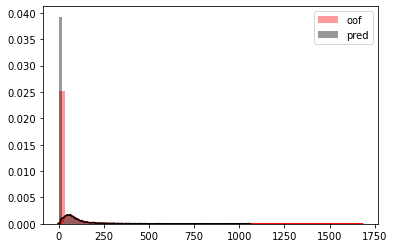

In [52]:
from make_fig import make_dist_oof_pred
make_dist_oof_pred(oof_df=oof_df,sub_df=sub_df,OUTPUT_DIR=OUTPUT_DIR)